# Experimentación - MSTGCN


https://ojs.aaai.org/index.php/AAAI/article/view/3881

## 1. Obtención de datos



In [2]:
import torch.nn.functional as F
import pandas as pd
import seaborn as sns
import networkx as nx
sns.set_palette("coolwarm_r")
import matplotlib.pyplot as plt
import numpy as np
from importlib import reload  # Python 3.4+


import os, sys

path = os.getcwd()

sys.path.insert(1, "/".join(path.split("/")[0:-1]))


from utils import powergrid

In [3]:
#folder_path = "/home/TFM/code_dataset2/datos/Natural Oscillation"
folder_path = "/Users/maguado/Documents/UGR/Master/TFM/datos_2/Natural Oscillation"

In [4]:
results_save_path = "./results"
name_model = "MSTGCN"

In [5]:
loader = powergrid.PowerGridDatasetLoader(folder_path, problem="regression")
_,_,_ =loader.process()
limit = 300
#dataset_full = loader.get_dataset( target= 20, intro=300, step=20, limit=limit, one_ts_per_situation=False)

Processing dataset...
Processing:  row_307
Node:  0  not included, including...
Node:  1  not included, including...
Node:  2  not included, including...
Node:  3  not included, including...
Node:  4  not included, including...
Node:  5  not included, including...
Node:  6  not included, including...
Node:  7  not included, including...
Node:  8  not included, including...
Node:  9  not included, including...
Node:  10  not included, including...
Node:  11  not included, including...
Node:  12  not included, including...
Node:  13  not included, including...
Node:  14  not included, including...
Node:  15  not included, including...
Node:  16  not included, including...
Node:  17  not included, including...
Node:  18  not included, including...
Node:  19  not included, including...
Node:  20  not included, including...
Node:  21  not included, including...
Node:  22  not included, including...
Processing:  row_135
Processing:  row_75
Processing:  row_338
Processing:  row_81
Processing:

## Funciones auxiliares - entrenamiento

In [7]:
from utils import pygt_loader

try:
    from tqdm import tqdm
except ImportError:
    def tqdm(iterable):
        return iterable


import torch
import torch.nn.functional as F
from utils.utils_graph import format_plot
from utils.utils_graph import plot_training_and_eval_losses, plot_predictions
from utils.general_nn import guardar_resultados



from utils.trainer import TrainerMSTGCN
from utils.models import MSTGCNModel


In [8]:
import itertools

def entrenar_y_evaluar_modelos_mstgcn(param_grid, dataset, dataloader_params, num_early_stop, num_epochs, problem="", device = torch.device("cpu")):
    resultados_list = []

    n_nodes = dataset.features[0].shape[0]
    n_target = dataset.targets[0].shape[1]
    n_features = dataset[0].x.shape[1]

    mejor_loss_test = float('inf')
    mejor_trainer = None
    mejores_parametros = None
    mejores_resultados = None
    

    for nb_block, filter_, time_strides, hidden in tqdm(list(itertools.product(param_grid['nb_block'], param_grid['filter'], param_grid['time_strides'], param_grid['hidden']))):
        print(f"Entrenando modelo con nb_block={nb_block}, nb_chev_filter={filter_}, nb_time_filter={filter_}, time_strides={time_strides}, hidden={hidden}")        
        model = MSTGCNModel(name="MSTGCN", node_features=n_features, node_count=n_nodes, n_target=n_target, nb_block=nb_block, k=2, nb_chev_filter = filter_, nb_time_filter =filter_,hidden=hidden, time_strides = time_strides)
        
        trainer = TrainerMSTGCN(model, dataset, device, f"./results/{problem}", dataloader_params)

        losses, eval_losses, r2scores = trainer.train(num_epochs=num_epochs, steps=200, num_early_stop=num_early_stop)
        r2score_tst, losses_tst, loss_nodes, _, _ = trainer.test()
    
        results_intermedio = {
            "nb_block": nb_block,
            "nb_chev_filter": filter_,
            "nb_time_filter": filter_,
            "hidden": hidden,
            "time_strides": time_strides,
            "loss_final": losses[-1],
            "r2_eval_final": np.mean(r2scores[-1]),
            "loss_eval_final": np.mean(eval_losses[-1]),
            "r2_test": np.mean(r2score_tst),
            "loss_test": np.mean(losses_tst),
            "loss_nodes": np.mean(loss_nodes, axis=0).tolist()
        }
        
        resultados_list.append(results_intermedio)

        if np.mean(losses_tst) < mejor_loss_test:
            mejor_loss_test = np.mean(losses_tst)
            mejor_trainer = trainer
            mejores_parametros = {
                "nb_block": nb_block,
                "nb_chev_filter": filter_,
                "nb_time_filter": filter_,
                "time_strides": time_strides,
                "hidden": hidden
            }
            mejores_resultados = results_intermedio

        print("Resultados intermedios: ", results_intermedio)

    resultados_gt = pd.DataFrame(resultados_list)

    return mejor_trainer, mejores_parametros, mejores_resultados, resultados_gt

## Prueba - predicción por tipos

In [13]:
dataloader_params2 = {
            "batch_size": 5,
            "data_split_ratio": [0.7, 0.15, 0.15],
            "seed": 42,
            "keep_same": True,
            "use_batch":False
}

param_grid = {
    "nb_block": [1, 2],
    "filter": [2,4,8],
    "time_strides": [2,5,10],
    "hidden":[50,80,100]
}

device = torch.device("cpu")
num_early_stop = 0
num_epochs = 30
lr = 0.01

### Gen trip

In [10]:
problem_gt = "gen_trip"
dataset_gt, situations_gt = loader.get_dataset( target= 20, intro=100, step=20, one_ts_per_situation=False, start = 1, type=problem_gt)



Number of situations:  549
Number of timestamps:  800
Number of situations of the selected type:  184


In [11]:
n_div_gt = loader.div
n_nodes =dataset_gt.features[0].shape[0]
n_target = dataset_gt.targets[0].shape[1]
n_features = dataset_gt[0].x.shape[1]
hidden_size =100

#### Sencilla 

In [11]:


device = torch.device("cpu")
model_gt = MSTGCNModel(name="MSTGCN", node_features=n_features, node_count=n_nodes, n_target=n_target, nb_block=2, k=2, nb_chev_filter = 2, nb_time_filter =2, time_strides = 2)

trainer_gt = TrainerMSTGCN(model_gt, dataset_gt,device, f"./results/{problem_gt}", dataloader_params2)

losses,eval_losses, r2scores  = trainer_gt.train(num_epochs=num_epochs, steps=200, num_early_stop=num_early_stop)




==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 942

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.4441 | Eval Loss: 0.2487 | Eval R2: -105.3719 | LR: 0.0010 | 
Epoch 2/30 | Train Loss: 0.2151 | Eval Loss: 0.1623 | Eval R2: -61.4250 | LR: 0.0010 | 
Epoch 3/30 | Train Loss: 0.1595 | Eval Loss: 0.1490 | Eval R2: -54.5947 | LR: 0.0010 | 
Epoch 4/30 | Train Loss: 0.1528 | Eval Loss: 0.1451 | Eval R2: -52.6056 | LR: 0.0010 | 
Epoch 5/30 | Train Loss: 0.1503 | Eval Loss: 0.1441 | Eval R2: -52.0710 | LR: 0.0010 | 
Epoch 6/30 | Train Loss: 0.1431 | Eval Loss: 0.0958 | Eval R2: -27.2697 | LR: 0.0010 | 
Epoch 7/30 | Train Loss: 0.1021 | Eval Loss: 0.0941 | Eval R2: -26.4016 | LR: 0.0010 | 
Epoch 8/30 | Train Loss: 0.0994 | Eval Loss: 0.0917 | Eval R2: -25.2980 | LR: 0.0010 | 
Epoch 9/30 | Train Loss: 0.0985 | Eval Loss: 0.0910 | Eval R2: -24.9865 | LR: 0.0010 | 
Epoch 10/30 | Train Loss: 0.0975 | 

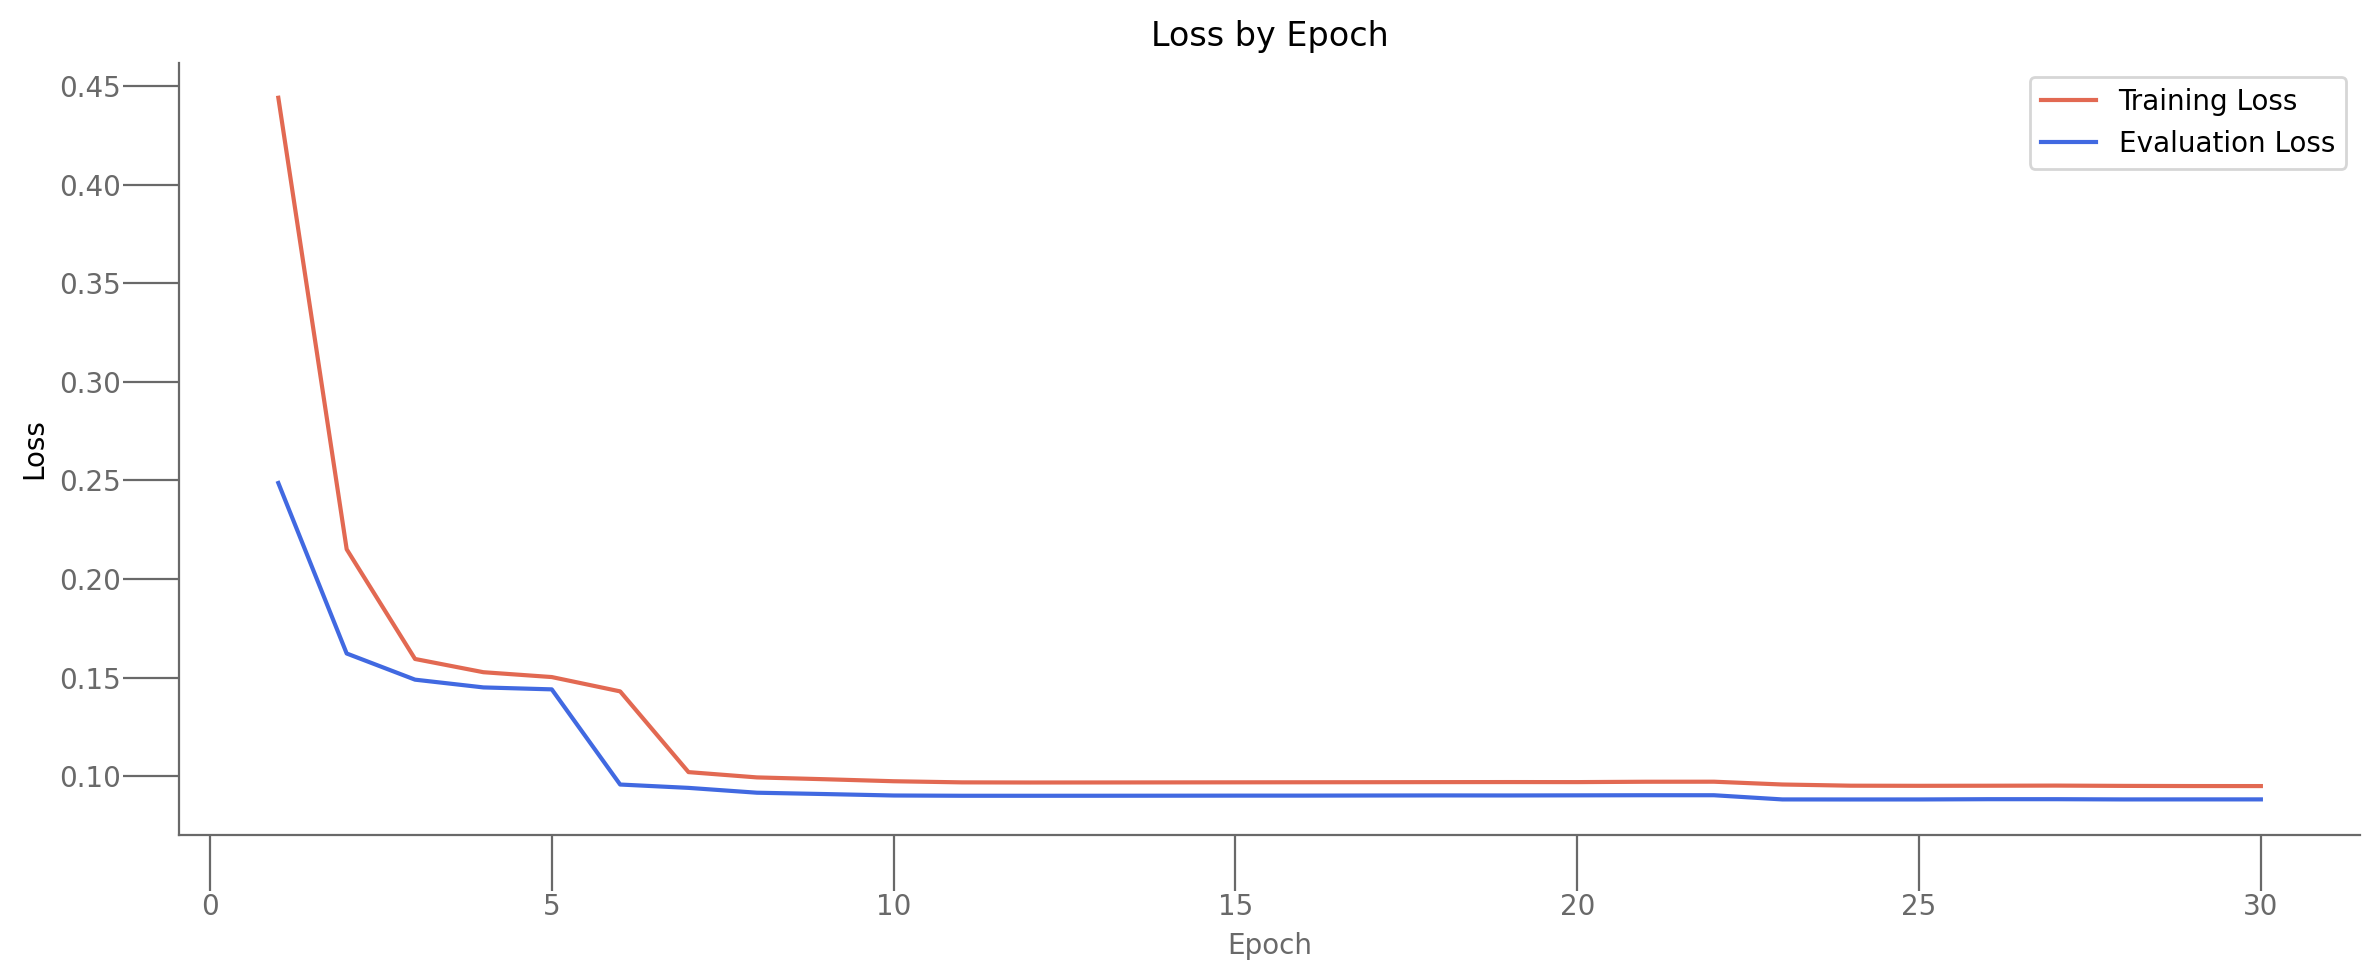


==================== TEST INFO ===================

preds:  (1, 23, 20)
test loss: 0.073295, test r2score -25.515827


In [13]:

plot_training_and_eval_losses(np.array(losses), np.array(eval_losses), num_epochs, format_plot)
losses_tst, r2score_tst, loss_nodes, predictions_gt, real_gt = trainer_gt.test()


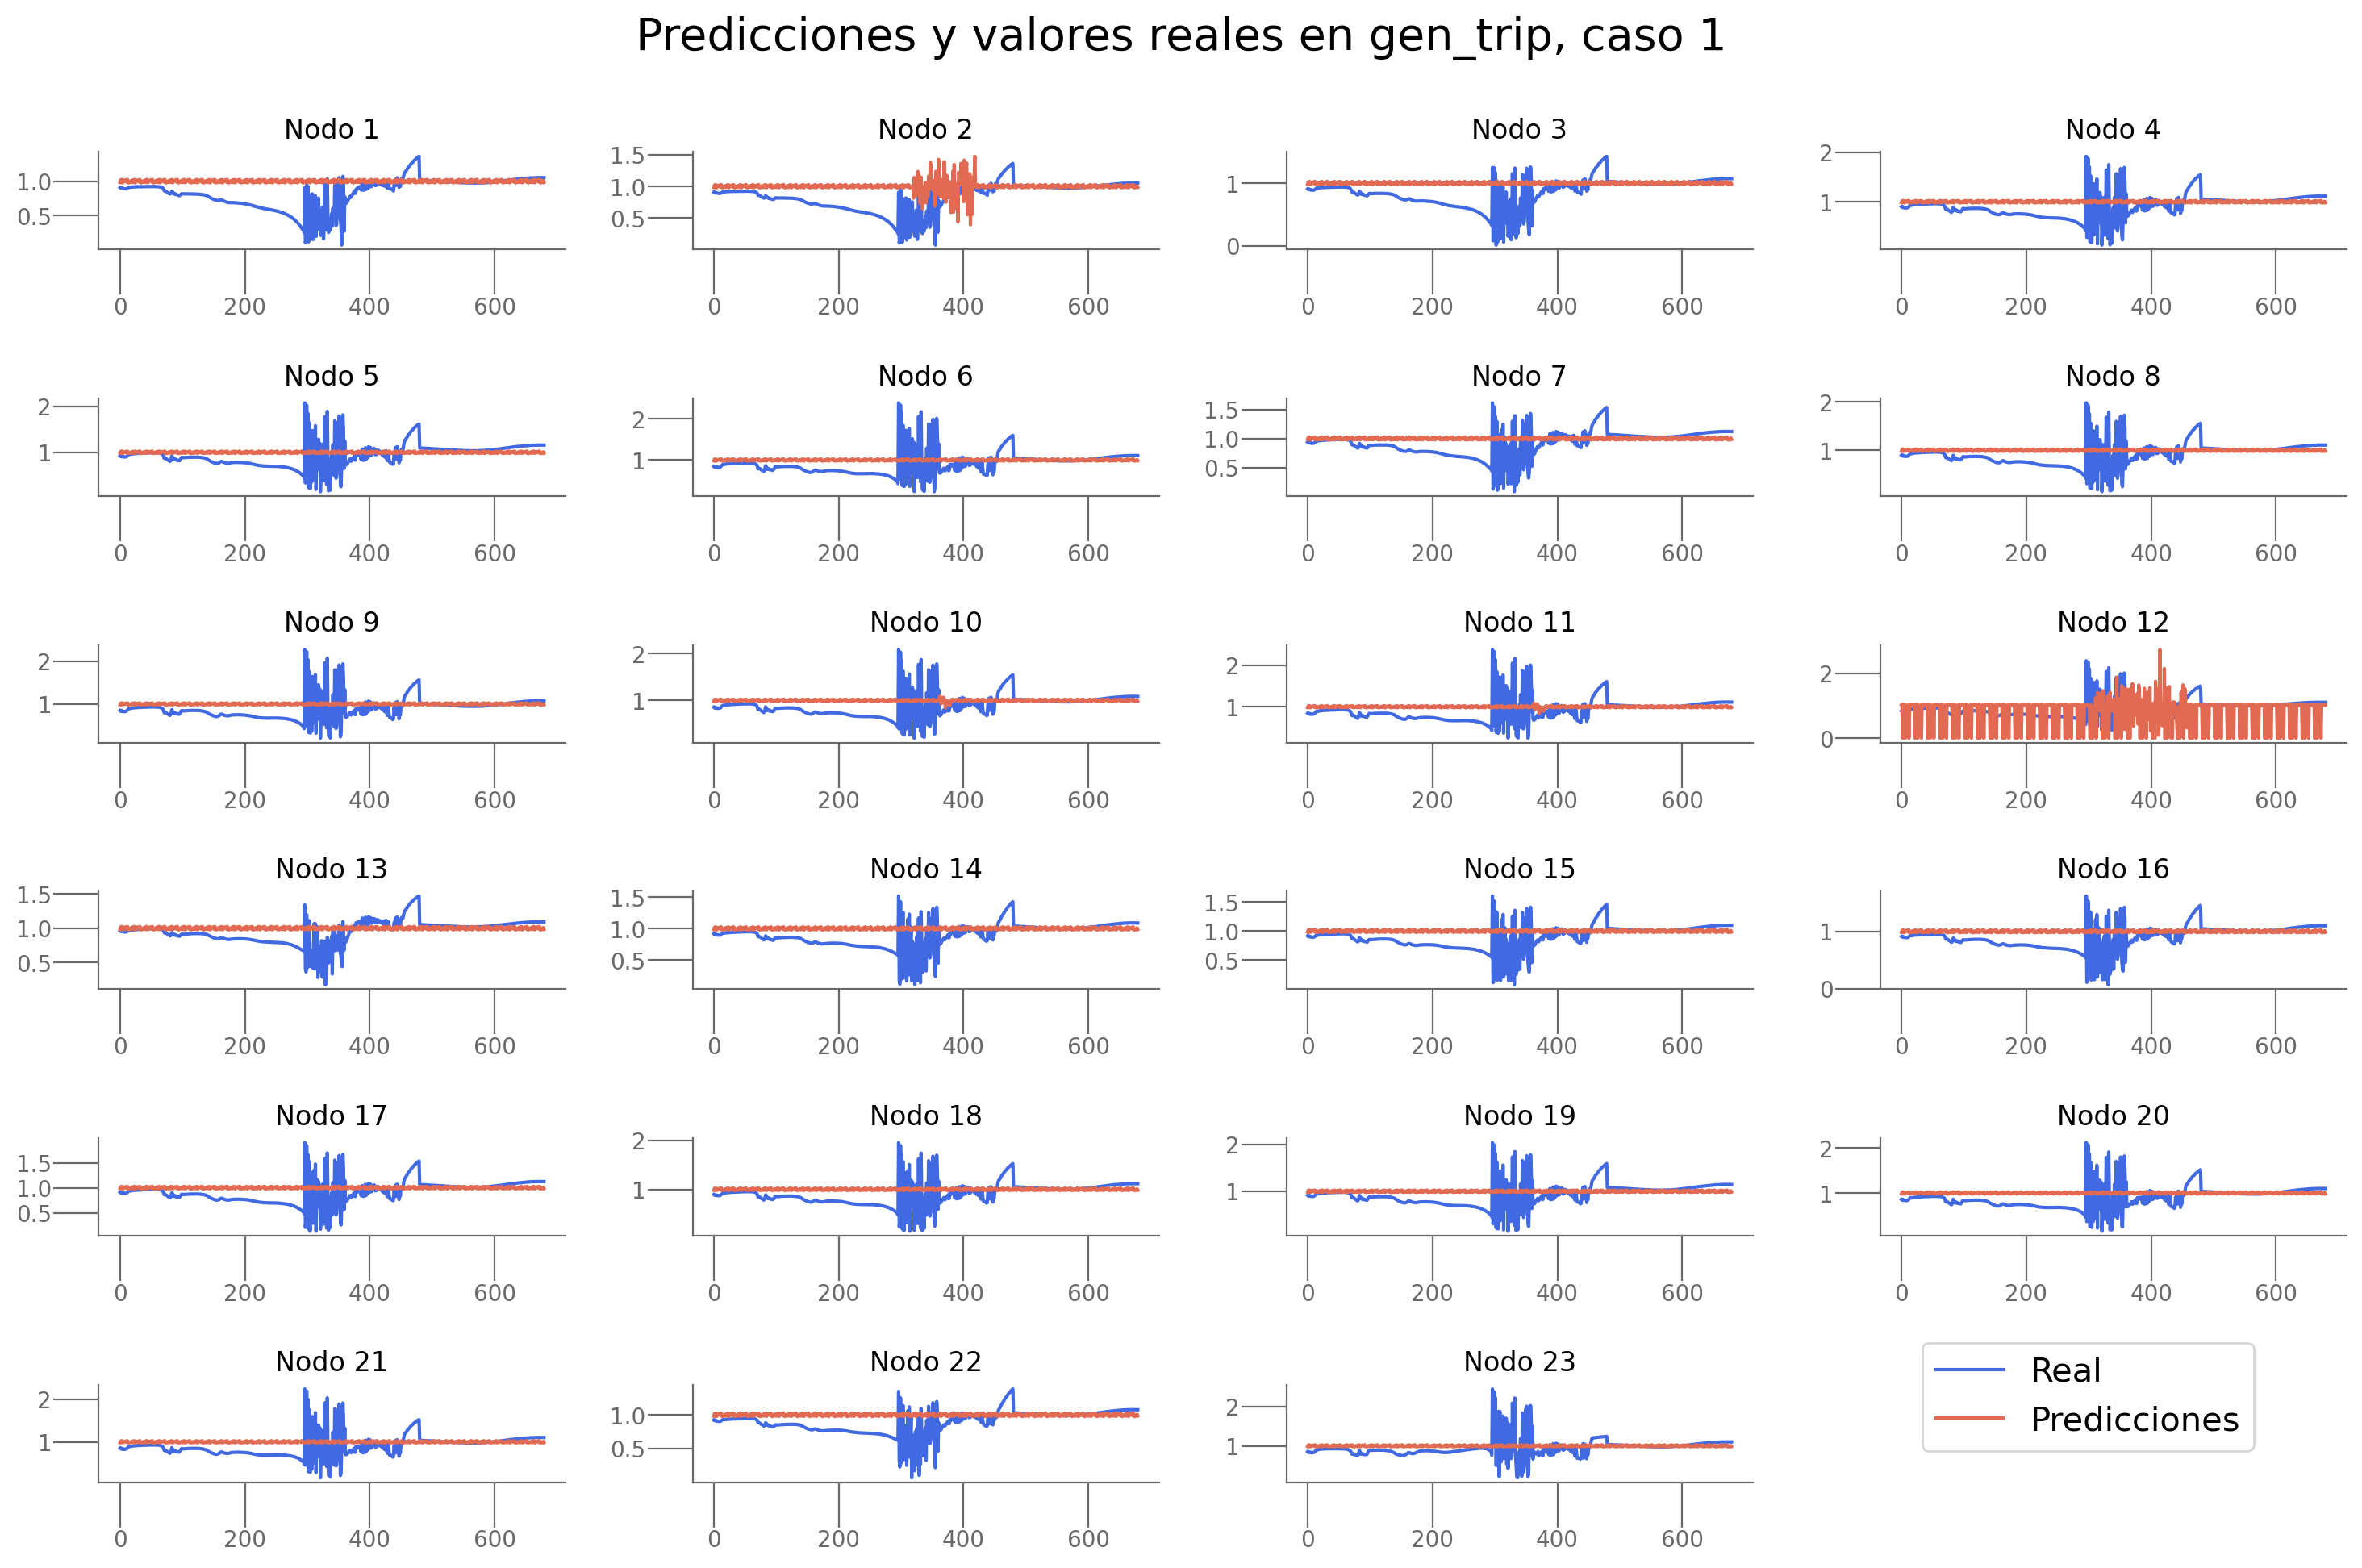

In [14]:
plot_predictions(predictions_gt, real_gt, n_target, 1, n_div_gt, problem_gt)

#### Ajuste de parámetros 

In [14]:



num_epochs = 100
num_early_stop = 10

trainer_gt,params_gt, resultados_final_gt, resultados_gt = entrenar_y_evaluar_modelos_mstgcn(param_grid, dataset_gt, dataloader_params2, num_early_stop, num_epochs, problem=problem_gt)

  0%|          | 0/54 [00:00<?, ?it/s]

Entrenando modelo con nb_block=1, nb_chev_filter=2, nb_time_filter=2, time_strides=2, hidden=50

==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 942

==================== TRAIN INFO ===================

Epoch 1/100 | Train Loss: 0.4006 | Eval Loss: 0.1761 | Eval R2: -67.8394 | LR: 0.0010 | 
Epoch 2/100 | Train Loss: 0.1470 | Eval Loss: 0.1168 | Eval R2: -36.6104 | LR: 0.0010 | 
Epoch 3/100 | Train Loss: 0.1140 | Eval Loss: 0.0981 | Eval R2: -27.4255 | LR: 0.0010 | 
Epoch 4/100 | Train Loss: 0.1013 | Eval Loss: 0.0894 | Eval R2: -23.2617 | LR: 0.0010 | 
Epoch 5/100 | Train Loss: 0.0951 | Eval Loss: 0.0853 | Eval R2: -21.4296 | LR: 0.0010 | 
Epoch 6/100 | Train Loss: 0.0922 | Eval Loss: 0.0834 | Eval R2: -20.6252 | LR: 0.0010 | 
Epoch 7/100 | Train Loss: 0.0908 | Eval Loss: 0.0825 | Eval R2: -20.3704 | LR: 0.0010 | 
Epoch 8/100 | Train Loss: 0.0898 | Eval Loss: 0.0817 | Eval R2: -20.3528 | LR: 0.0010 | 
Epoch 9/100 | Train 

  2%|▏         | 1/54 [14:47<13:03:36, 887.11s/it]

preds:  (1, 23, 20)
test loss: 0.046308, test R2 score: -16.959983
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 50, 'time_strides': 2, 'loss_final': 0.06365420669317245, 'r2_eval_final': -16.20629119873047, 'loss_eval_final': 0.059098534286022186, 'r2_test': -16.959982687066375, 'loss_test': 0.046307966113090515, 'loss_nodes': [0.06693770736455917, 0.06555157899856567, 0.02921753190457821, 0.08416535705327988, 0.10017704218626022, 0.09045886248350143, 0.07817517220973969, 0.032753586769104004, 0.035223521292209625, 0.027907447889447212, 0.03440349921584129, 0.03177209943532944, 0.019774092361330986, 0.0666506439447403, 0.02240113914012909, 0.02244948409497738, 0.03339103236794472, 0.08180943876504898, 0.032263558357954025, 0.02849649265408516, 0.02959512174129486, 0.02407032810151577, 0.027438422664999962]}
Entrenando modelo con nb_block=1, nb_chev_filter=2, nb_time_filter=2, time_strides=2, hidden=80

==================== DATASET INFO ==

  4%|▎         | 2/54 [28:49<12:25:54, 860.67s/it]

preds:  (1, 23, 20)
test loss: 0.047595, test R2 score: -17.014135
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 80, 'time_strides': 2, 'loss_final': 0.06918266415596008, 'r2_eval_final': -16.167770385742188, 'loss_eval_final': 0.06068999320268631, 'r2_test': -17.014134892170627, 'loss_test': 0.04759538918733597, 'loss_nodes': [0.06626854836940765, 0.06490206718444824, 0.03662389516830444, 0.0774485319852829, 0.09094627946615219, 0.08285550028085709, 0.07135044038295746, 0.03779047355055809, 0.041551560163497925, 0.03248672932386398, 0.041329316794872284, 0.03688111528754234, 0.02334737963974476, 0.06025514006614685, 0.02645966410636902, 0.026523863896727562, 0.037954457104206085, 0.07440347969532013, 0.039012227207422256, 0.032419249415397644, 0.0358181931078434, 0.02864173799753189, 0.02942376770079136]}
Entrenando modelo con nb_block=1, nb_chev_filter=2, nb_time_filter=2, time_strides=2, hidden=100

==================== DATASET INFO ===

  6%|▌         | 3/54 [42:08<11:47:54, 832.84s/it]

preds:  (1, 23, 20)
test loss: 0.044164, test R2 score: -14.777469
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 100, 'time_strides': 2, 'loss_final': 0.06208867207169533, 'r2_eval_final': -14.419486999511719, 'loss_eval_final': 0.056771352887153625, 'r2_test': -14.77746929668523, 'loss_test': 0.044164106249809265, 'loss_nodes': [0.0671980157494545, 0.06580886244773865, 0.02853034995496273, 0.08523963391780853, 0.10159903764724731, 0.09165263175964355, 0.07926316559314728, 0.027223408222198486, 0.02956506423652172, 0.027206527069211006, 0.03141706809401512, 0.025672050192952156, 0.014282974414527416, 0.06768101453781128, 0.021856417879462242, 0.021910520270466805, 0.026046525686979294, 0.08298007398843765, 0.030073463916778564, 0.02780166082084179, 0.026924287900328636, 0.01582968607544899, 0.020012298598885536]}
Entrenando modelo con nb_block=1, nb_chev_filter=2, nb_time_filter=2, time_strides=5, hidden=50

==================== DATASET IN

  7%|▋         | 4/54 [54:43<11:08:08, 801.76s/it]

preds:  (1, 23, 20)
test loss: 0.327084, test R2 score: -191.347280
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 50, 'time_strides': 5, 'loss_final': 0.34647291898727417, 'r2_eval_final': -155.454833984375, 'loss_eval_final': 0.3441738784313202, 'r2_test': -191.34728000603167, 'loss_test': 0.32708364725112915, 'loss_nodes': [0.2953386604785919, 0.2938764989376068, 0.30455583333969116, 0.33733946084976196, 0.36732468008995056, 0.347339004278183, 0.331727534532547, 0.33654436469078064, 0.33054691553115845, 0.32384610176086426, 0.3480083644390106, 0.32328730821609497, 0.30577993392944336, 0.3184036910533905, 0.3236340582370758, 0.32312506437301636, 0.3421691358089447, 0.33791932463645935, 0.35869383811950684, 0.3334835469722748, 0.33364734053611755, 0.3109942376613617, 0.2953384518623352]}
Entrenando modelo con nb_block=1, nb_chev_filter=2, nb_time_filter=2, time_strides=5, hidden=80

==================== DATASET INFO ===================

Tr

  9%|▉         | 5/54 [1:07:17<10:40:55, 784.82s/it]

preds:  (1, 23, 20)
test loss: 0.327084, test R2 score: -191.347280
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 80, 'time_strides': 5, 'loss_final': 0.34647291898727417, 'r2_eval_final': -155.454833984375, 'loss_eval_final': 0.3441738784313202, 'r2_test': -191.34728034381922, 'loss_test': 0.32708364725112915, 'loss_nodes': [0.2953386604785919, 0.2938765287399292, 0.30455586314201355, 0.33733946084976196, 0.3673246204853058, 0.3473389446735382, 0.331727534532547, 0.33654436469078064, 0.33054694533348083, 0.32384610176086426, 0.3480083644390106, 0.32328730821609497, 0.30577996373176575, 0.3184036910533905, 0.3236340582370758, 0.32312503457069397, 0.3421691358089447, 0.33791929483413696, 0.35869383811950684, 0.3334835469722748, 0.33364734053611755, 0.3109942674636841, 0.2953384518623352]}
Entrenando modelo con nb_block=1, nb_chev_filter=2, nb_time_filter=2, time_strides=5, hidden=100

==================== DATASET INFO ===================

T

 11%|█         | 6/54 [1:20:05<10:23:09, 778.95s/it]

preds:  (1, 23, 20)
test loss: 0.327084, test R2 score: -191.347280
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 100, 'time_strides': 5, 'loss_final': 0.34647291898727417, 'r2_eval_final': -155.454833984375, 'loss_eval_final': 0.3441738784313202, 'r2_test': -191.34727989376876, 'loss_test': 0.32708364725112915, 'loss_nodes': [0.2953386604785919, 0.2938765287399292, 0.30455583333969116, 0.33733946084976196, 0.3673246204853058, 0.3473389446735382, 0.331727534532547, 0.33654433488845825, 0.33054694533348083, 0.32384610176086426, 0.34800833463668823, 0.32328730821609497, 0.30577993392944336, 0.3184036910533905, 0.3236340582370758, 0.32312503457069397, 0.3421691358089447, 0.33791929483413696, 0.3586938679218292, 0.3334835469722748, 0.33364734053611755, 0.3109942376613617, 0.2953384518623352]}
Entrenando modelo con nb_block=1, nb_chev_filter=2, nb_time_filter=2, time_strides=10, hidden=50

==================== DATASET INFO ===================



 13%|█▎        | 7/54 [1:33:19<10:14:09, 784.03s/it]

preds:  (1, 23, 20)
test loss: 0.063261, test R2 score: -21.711275
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 50, 'time_strides': 10, 'loss_final': 0.07907655835151672, 'r2_eval_final': -18.907215118408203, 'loss_eval_final': 0.07118190079927444, 'r2_test': -21.711274901447176, 'loss_test': 0.06326070427894592, 'loss_nodes': [0.06816741079092026, 0.06714693456888199, 0.06631765514612198, 0.06969674676656723, 0.07615407556295395, 0.07187449932098389, 0.06313179433345795, 0.06999171525239944, 0.07269273698329926, 0.0660967156291008, 0.07179281115531921, 0.06411996483802795, 0.04137266427278519, 0.052715472877025604, 0.0566069558262825, 0.0565287247300148, 0.06648311764001846, 0.06523948907852173, 0.07254110276699066, 0.0648421123623848, 0.06441008299589157, 0.04809550568461418, 0.038977865129709244]}
Entrenando modelo con nb_block=1, nb_chev_filter=2, nb_time_filter=2, time_strides=10, hidden=80

==================== DATASET INFO ========

 15%|█▍        | 8/54 [1:46:13<9:58:27, 780.60s/it] 

preds:  (1, 23, 20)
test loss: 0.065083, test R2 score: -22.393248
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 80, 'time_strides': 10, 'loss_final': 0.07778823375701904, 'r2_eval_final': -19.449697494506836, 'loss_eval_final': 0.07263489067554474, 'r2_test': -22.393247909206284, 'loss_test': 0.06508336216211319, 'loss_nodes': [0.0705597996711731, 0.06954891979694366, 0.0688098669052124, 0.07070741802453995, 0.0778195858001709, 0.07437705248594284, 0.06488075107336044, 0.07193209230899811, 0.07456367462873459, 0.06802400201559067, 0.07418842613697052, 0.06672544777393341, 0.04286724701523781, 0.05468446761369705, 0.05788299813866615, 0.05777886137366295, 0.06809120625257492, 0.06617686152458191, 0.07475712150335312, 0.0662260428071022, 0.06681051105260849, 0.049339260905981064, 0.04016560688614845]}
Entrenando modelo con nb_block=1, nb_chev_filter=2, nb_time_filter=2, time_strides=10, hidden=100

==================== DATASET INFO ========

 17%|█▋        | 9/54 [1:59:38<9:51:14, 788.31s/it]

preds:  (1, 23, 20)
test loss: 0.062267, test R2 score: -21.510458
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 100, 'time_strides': 10, 'loss_final': 0.07751404494047165, 'r2_eval_final': -18.833616256713867, 'loss_eval_final': 0.0700656846165657, 'r2_test': -21.5104577960457, 'loss_test': 0.062267132103443146, 'loss_nodes': [0.060015615075826645, 0.05996797978878021, 0.062076717615127563, 0.06920389086008072, 0.07633921504020691, 0.07337284833192825, 0.06264575570821762, 0.069217748939991, 0.07226385176181793, 0.06538423150777817, 0.07178296148777008, 0.06461932510137558, 0.04128825664520264, 0.054215505719184875, 0.05619229003787041, 0.05614326894283295, 0.06583720445632935, 0.0652071088552475, 0.07211760431528091, 0.06478177756071091, 0.06409922987222672, 0.0473148413002491, 0.03805679827928543]}
Entrenando modelo con nb_block=1, nb_chev_filter=4, nb_time_filter=4, time_strides=2, hidden=50

==================== DATASET INFO =========

 19%|█▊        | 10/54 [2:14:23<9:59:57, 818.12s/it]

preds:  (1, 23, 20)
test loss: 0.229325, test R2 score: -141.019261
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 50, 'time_strides': 2, 'loss_final': 0.2338154911994934, 'r2_eval_final': -114.46078491210938, 'loss_eval_final': 0.23719976842403412, 'r2_test': -141.01926087672112, 'loss_test': 0.22932547330856323, 'loss_nodes': [0.1962461620569229, 0.19576889276504517, 0.2064211070537567, 0.23477979004383087, 0.25499776005744934, 0.24372324347496033, 0.23185180127620697, 0.23335184156894684, 0.22927145659923553, 0.2258927822113037, 0.2440502643585205, 0.2271578311920166, 0.22221292555332184, 0.22740700840950012, 0.2289496213197708, 0.22867107391357422, 0.23944298923015594, 0.2375430017709732, 0.25019097328186035, 0.2347317934036255, 0.23650163412094116, 0.2232409417629242, 0.2220819890499115]}
Entrenando modelo con nb_block=1, nb_chev_filter=4, nb_time_filter=4, time_strides=2, hidden=80

==================== DATASET INFO ==================

 20%|██        | 11/54 [2:27:34<9:40:27, 809.94s/it]

preds:  (1, 23, 20)
test loss: 0.229325, test R2 score: -141.019095
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 80, 'time_strides': 2, 'loss_final': 0.23381491005420685, 'r2_eval_final': -114.46065521240234, 'loss_eval_final': 0.23719917237758636, 'r2_test': -141.01909452493632, 'loss_test': 0.22932486236095428, 'loss_nodes': [0.19624628126621246, 0.1957690268754959, 0.20642125606536865, 0.23477959632873535, 0.25499749183654785, 0.24372321367263794, 0.2318516969680786, 0.2333509773015976, 0.22927045822143555, 0.2258925884962082, 0.24404750764369965, 0.22715707123279572, 0.2222122699022293, 0.22740550339221954, 0.2289496511220932, 0.22867107391357422, 0.23944228887557983, 0.23754283785820007, 0.25018879771232605, 0.23473165929317474, 0.2365000993013382, 0.2232402116060257, 0.22208067774772644]}
Entrenando modelo con nb_block=1, nb_chev_filter=4, nb_time_filter=4, time_strides=2, hidden=100

==================== DATASET INFO ==============

 22%|██▏       | 12/54 [2:40:48<9:23:31, 805.04s/it]

preds:  (1, 23, 20)
test loss: 0.229325, test R2 score: -141.019156
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 100, 'time_strides': 2, 'loss_final': 0.23381508886814117, 'r2_eval_final': -114.4607162475586, 'loss_eval_final': 0.2371993362903595, 'r2_test': -141.0191561550706, 'loss_test': 0.22932502627372742, 'loss_nodes': [0.19624626636505127, 0.1957690715789795, 0.20642128586769104, 0.23477959632873535, 0.2549975514411926, 0.24372321367263794, 0.23185168206691742, 0.23335124552249908, 0.22927071154117584, 0.22589273750782013, 0.24404819309711456, 0.22715723514556885, 0.22221249341964722, 0.22740581631660461, 0.2289496511220932, 0.22867116332054138, 0.23944246768951416, 0.23754294216632843, 0.2501890957355499, 0.23473168909549713, 0.2365005761384964, 0.22324031591415405, 0.2220810353755951]}
Entrenando modelo con nb_block=1, nb_chev_filter=4, nb_time_filter=4, time_strides=5, hidden=50

==================== DATASET INFO ===============

 24%|██▍       | 13/54 [2:52:49<8:52:36, 779.43s/it]

preds:  (1, 23, 20)
test loss: 0.341207, test R2 score: -216.238370
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 50, 'time_strides': 5, 'loss_final': 0.34856364130973816, 'r2_eval_final': -173.9464569091797, 'loss_eval_final': 0.35307496786117554, 'r2_test': -216.23837011097118, 'loss_test': 0.3412073850631714, 'loss_nodes': [0.29367342591285706, 0.2929766774177551, 0.30851754546165466, 0.3486098647117615, 0.379133403301239, 0.36041295528411865, 0.34534478187561035, 0.3473787009716034, 0.3402162194252014, 0.3359377086162567, 0.3614090383052826, 0.3369438648223877, 0.33201563358306885, 0.33842650055885315, 0.34222298860549927, 0.34174537658691406, 0.35679978132247925, 0.353222131729126, 0.3716399669647217, 0.3490924537181854, 0.35022515058517456, 0.333927184343338, 0.32789745926856995]}
Entrenando modelo con nb_block=1, nb_chev_filter=4, nb_time_filter=4, time_strides=5, hidden=80

==================== DATASET INFO ===================

Tra

 26%|██▌       | 14/54 [3:05:10<8:32:01, 768.04s/it]

preds:  (1, 23, 20)
test loss: 0.341208, test R2 score: -216.238498
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 80, 'time_strides': 5, 'loss_final': 0.34856417775154114, 'r2_eval_final': -173.94654846191406, 'loss_eval_final': 0.3530753552913666, 'r2_test': -216.23849769375602, 'loss_test': 0.3412078320980072, 'loss_nodes': [0.29367348551750183, 0.2929767072200775, 0.3085181415081024, 0.3486103117465973, 0.3791344165802002, 0.3604133725166321, 0.34534522891044617, 0.3473793566226959, 0.3402170240879059, 0.33593833446502686, 0.36140963435173035, 0.3369443714618683, 0.3320159912109375, 0.3384273052215576, 0.3422233760356903, 0.3417455852031708, 0.3568000793457031, 0.3532227873802185, 0.37164050340652466, 0.34909266233444214, 0.3502257466316223, 0.33392778038978577, 0.3278976380825043]}
Entrenando modelo con nb_block=1, nb_chev_filter=4, nb_time_filter=4, time_strides=5, hidden=100

==================== DATASET INFO ===================

Tra

 28%|██▊       | 15/54 [3:17:33<8:14:21, 760.56s/it]

preds:  (1, 23, 20)
test loss: 0.341208, test R2 score: -216.238547
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 100, 'time_strides': 5, 'loss_final': 0.3485643267631531, 'r2_eval_final': -173.9465789794922, 'loss_eval_final': 0.35307544469833374, 'r2_test': -216.23854692160742, 'loss_test': 0.34120798110961914, 'loss_nodes': [0.29367342591285706, 0.2929767072200775, 0.30851826071739197, 0.34861046075820923, 0.37913453578948975, 0.3604135513305664, 0.34534522891044617, 0.3473796248435974, 0.3402172029018402, 0.33593839406967163, 0.36140987277030945, 0.33694446086883545, 0.33201614022254944, 0.3384275734424591, 0.3422236144542694, 0.3417457342147827, 0.3568001091480255, 0.35322296619415283, 0.37164056301116943, 0.3490928113460541, 0.3502257764339447, 0.3339278995990753, 0.3278977572917938]}
Entrenando modelo con nb_block=1, nb_chev_filter=4, nb_time_filter=4, time_strides=10, hidden=50

==================== DATASET INFO ===================

 30%|██▉       | 16/54 [3:29:46<7:56:22, 752.17s/it]

preds:  (1, 23, 20)
test loss: 0.011316, test R2 score: -3.936530
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 50, 'time_strides': 10, 'loss_final': 0.01580759510397911, 'r2_eval_final': -4.142435550689697, 'loss_eval_final': 0.016110636293888092, 'r2_test': -3.9365295373397196, 'loss_test': 0.011316477321088314, 'loss_nodes': [0.006517869886010885, 0.006289134733378887, 0.007450866512954235, 0.012090157717466354, 0.014261196367442608, 0.017098378390073776, 0.008728026412427425, 0.01274911593645811, 0.016060762107372284, 0.01299203559756279, 0.016471587121486664, 0.013057309202849865, 0.0049157291650772095, 0.007985984906554222, 0.008627347648143768, 0.008715874515473843, 0.011926188133656979, 0.012121744453907013, 0.01379136461764574, 0.013889451511204243, 0.014865494333207607, 0.006700813304632902, 0.012972553260624409]}
Entrenando modelo con nb_block=1, nb_chev_filter=4, nb_time_filter=4, time_strides=10, hidden=80

===================

 31%|███▏      | 17/54 [3:41:16<7:32:16, 733.42s/it]

preds:  (1, 23, 20)
test loss: 0.011316, test R2 score: -3.936471
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 80, 'time_strides': 10, 'loss_final': 0.015807675197720528, 'r2_eval_final': -4.142389297485352, 'loss_eval_final': 0.01611059159040451, 'r2_test': -3.936471384075189, 'loss_test': 0.011316386051476002, 'loss_nodes': [0.006517698522657156, 0.0062889764085412025, 0.007450790610164404, 0.012090219184756279, 0.014261397533118725, 0.017098383978009224, 0.00872803945094347, 0.012749074958264828, 0.016060642898082733, 0.012991898693144321, 0.016470836475491524, 0.013057256117463112, 0.004915752448141575, 0.007985291071236134, 0.008627314120531082, 0.00871584564447403, 0.011926171369850636, 0.012121775187551975, 0.013791711069643497, 0.013889363035559654, 0.014865159057080746, 0.006700832396745682, 0.012972424738109112]}
Entrenando modelo con nb_block=1, nb_chev_filter=4, nb_time_filter=4, time_strides=10, hidden=100

==================

 33%|███▎      | 18/54 [3:53:07<7:16:02, 726.74s/it]

preds:  (1, 23, 20)
test loss: 0.011317, test R2 score: -3.940925
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 100, 'time_strides': 10, 'loss_final': 0.015803702175617218, 'r2_eval_final': -4.1451005935668945, 'loss_eval_final': 0.016111737117171288, 'r2_test': -3.9409254488087377, 'loss_test': 0.011317040771245956, 'loss_nodes': [0.0065303281880915165, 0.006301175337284803, 0.0074578686617314816, 0.012081723660230637, 0.014252721332013607, 0.017090069130063057, 0.008720282465219498, 0.012747159227728844, 0.016061270609498024, 0.01299332920461893, 0.01647169142961502, 0.013057548552751541, 0.004917786922305822, 0.00799377541989088, 0.008626656606793404, 0.008715346455574036, 0.01192275807261467, 0.012118709273636341, 0.013790488243103027, 0.013889413326978683, 0.014869504608213902, 0.006702271290123463, 0.012980086728930473]}
Entrenando modelo con nb_block=1, nb_chev_filter=8, nb_time_filter=8, time_strides=2, hidden=50

=================

 35%|███▌      | 19/54 [4:08:56<7:42:52, 793.50s/it]

preds:  (1, 23, 20)
test loss: 0.062841, test R2 score: -37.517866
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 50, 'time_strides': 2, 'loss_final': 0.06507691740989685, 'r2_eval_final': -30.337873458862305, 'loss_eval_final': 0.0668976828455925, 'r2_test': -37.51786573693866, 'loss_test': 0.06284058839082718, 'loss_nodes': [0.05154421925544739, 0.05137822404503822, 0.05491967871785164, 0.06437472999095917, 0.07035049796104431, 0.06931695342063904, 0.061752673238515854, 0.0644468143582344, 0.06526800245046616, 0.06282207369804382, 0.06965851783752441, 0.06361155211925507, 0.05746636539697647, 0.060544271022081375, 0.06147310137748718, 0.0614616684615612, 0.06562522053718567, 0.0651964470744133, 0.06955744326114655, 0.06568807363510132, 0.06699156761169434, 0.05889854207634926, 0.06298692524433136]}
Entrenando modelo con nb_block=1, nb_chev_filter=8, nb_time_filter=8, time_strides=2, hidden=80

==================== DATASET INFO ===========

 37%|███▋      | 20/54 [4:24:54<7:57:35, 842.81s/it]

preds:  (1, 23, 20)
test loss: 0.062841, test R2 score: -37.517763
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 80, 'time_strides': 2, 'loss_final': 0.06507669389247894, 'r2_eval_final': -30.337772369384766, 'loss_eval_final': 0.06689759343862534, 'r2_test': -37.517763345817926, 'loss_test': 0.06284055858850479, 'loss_nodes': [0.05154415965080261, 0.051378197968006134, 0.054919589310884476, 0.06437470763921738, 0.07035049051046371, 0.06931699812412262, 0.06175262853503227, 0.0644468367099762, 0.06526791304349899, 0.06282207369804382, 0.06965852528810501, 0.06361158937215805, 0.05746626853942871, 0.060544271022081375, 0.061473049223423004, 0.06146157905459404, 0.06562520563602448, 0.06519642472267151, 0.06955733895301819, 0.06568803638219833, 0.06699144095182419, 0.05889848619699478, 0.06298704445362091]}
Entrenando modelo con nb_block=1, nb_chev_filter=8, nb_time_filter=8, time_strides=2, hidden=100

==================== DATASET INFO ====

 39%|███▉      | 21/54 [4:40:02<7:54:23, 862.52s/it]

preds:  (1, 23, 20)
test loss: 0.062841, test R2 score: -37.517858
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 100, 'time_strides': 2, 'loss_final': 0.06507693231105804, 'r2_eval_final': -30.337865829467773, 'loss_eval_final': 0.0668976753950119, 'r2_test': -37.51785807056374, 'loss_test': 0.06284060329198837, 'loss_nodes': [0.05154421553015709, 0.05137823522090912, 0.054919686168432236, 0.06437479704618454, 0.07035055011510849, 0.06931698322296143, 0.06175270304083824, 0.06444679945707321, 0.06526793539524078, 0.06282207369804382, 0.0696585476398468, 0.06361156702041626, 0.05746637284755707, 0.06054431572556496, 0.061473116278648376, 0.0614616721868515, 0.06562519818544388, 0.06519649922847748, 0.06955748796463013, 0.06568808853626251, 0.06699161976575851, 0.05889853462576866, 0.06298689544200897]}
Entrenando modelo con nb_block=1, nb_chev_filter=8, nb_time_filter=8, time_strides=5, hidden=50

==================== DATASET INFO =========

 41%|████      | 22/54 [4:53:10<7:28:04, 840.15s/it]

preds:  (1, 23, 20)
test loss: 0.008902, test R2 score: -3.011801
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 50, 'time_strides': 5, 'loss_final': 0.01205313578248024, 'r2_eval_final': -3.0088088512420654, 'loss_eval_final': 0.012900774367153645, 'r2_test': -3.011800977949501, 'loss_test': 0.008902394212782383, 'loss_nodes': [0.00493362732231617, 0.004786314908415079, 0.005590596701949835, 0.009570828638970852, 0.010820179246366024, 0.013350198976695538, 0.006991330534219742, 0.009737547487020493, 0.012745389714837074, 0.009916299022734165, 0.01353754848241806, 0.010907893069088459, 0.003801776096224785, 0.006631449330598116, 0.006508217193186283, 0.006584904156625271, 0.008960604667663574, 0.009434573352336884, 0.010758462361991405, 0.010623171925544739, 0.012181678786873817, 0.005048319231718779, 0.01133413054049015]}
Entrenando modelo con nb_block=1, nb_chev_filter=8, nb_time_filter=8, time_strides=5, hidden=80

==================== D

 43%|████▎     | 23/54 [5:06:41<7:09:33, 831.41s/it]

preds:  (1, 23, 20)
test loss: 0.008902, test R2 score: -3.011789
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 80, 'time_strides': 5, 'loss_final': 0.012053152546286583, 'r2_eval_final': -3.0088024139404297, 'loss_eval_final': 0.012900748290121555, 'r2_test': -3.0117890523351427, 'loss_test': 0.008902370929718018, 'loss_nodes': [0.004933701362460852, 0.004786396399140358, 0.005590604152530432, 0.009570693597197533, 0.010820147581398487, 0.013350044377148151, 0.0069912332110106945, 0.009737507440149784, 0.012745355255901814, 0.009916295297443867, 0.013537545688450336, 0.010907850228250027, 0.0038017653860151768, 0.0066314623691141605, 0.006508221849799156, 0.006584906950592995, 0.008960568346083164, 0.009434577077627182, 0.010758441872894764, 0.01062315795570612, 0.012181664817035198, 0.005048300605267286, 0.011334090493619442]}
Entrenando modelo con nb_block=1, nb_chev_filter=8, nb_time_filter=8, time_strides=5, hidden=100

==============

 44%|████▍     | 24/54 [5:20:15<6:53:01, 826.04s/it]

preds:  (1, 23, 20)
test loss: 0.008902, test R2 score: -3.011879
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 100, 'time_strides': 5, 'loss_final': 0.012053175829350948, 'r2_eval_final': -3.008871555328369, 'loss_eval_final': 0.0129008237272501, 'r2_test': -3.0118786695368067, 'loss_test': 0.008902440778911114, 'loss_nodes': [0.004933647345751524, 0.004786311183124781, 0.005590715445578098, 0.00957081001251936, 0.010819902643561363, 0.013350086286664009, 0.006991300731897354, 0.009737720713019371, 0.012745669111609459, 0.009916309267282486, 0.013537570834159851, 0.010908083990216255, 0.003801926039159298, 0.006631601136177778, 0.00650815712288022, 0.0065848371013998985, 0.008960818871855736, 0.009434416890144348, 0.010758490301668644, 0.010623106732964516, 0.012181699275970459, 0.005048541817814112, 0.011334425769746304]}
Entrenando modelo con nb_block=1, nb_chev_filter=8, nb_time_filter=8, time_strides=10, hidden=50

===================

 46%|████▋     | 25/54 [5:33:22<6:33:37, 814.40s/it]

preds:  (1, 23, 20)
test loss: 0.011668, test R2 score: -4.412566
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 50, 'time_strides': 10, 'loss_final': 0.015001699328422546, 'r2_eval_final': -4.273151397705078, 'loss_eval_final': 0.015846403315663338, 'r2_test': -4.412566282831049, 'loss_test': 0.011667950078845024, 'loss_nodes': [0.006710062734782696, 0.006523928139358759, 0.0077514490112662315, 0.01214359700679779, 0.01416319515556097, 0.017303481698036194, 0.008977013640105724, 0.012785462662577629, 0.0165542121976614, 0.013105209916830063, 0.017499666661024094, 0.013856811448931694, 0.005294777452945709, 0.008081145584583282, 0.008855856955051422, 0.008949457667768002, 0.011821256019175053, 0.012353540398180485, 0.014141255058348179, 0.013933506794273853, 0.016010131686925888, 0.007083668373525143, 0.014464202336966991]}
Entrenando modelo con nb_block=1, nb_chev_filter=8, nb_time_filter=8, time_strides=10, hidden=80

====================

 48%|████▊     | 26/54 [5:46:05<6:12:52, 799.00s/it]

preds:  (1, 23, 20)
test loss: 0.011668, test R2 score: -4.412581
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 80, 'time_strides': 10, 'loss_final': 0.015001730062067509, 'r2_eval_final': -4.27315616607666, 'loss_eval_final': 0.01584637351334095, 'r2_test': -4.412580693883459, 'loss_test': 0.011667927727103233, 'loss_nodes': [0.006709676701575518, 0.006523533724248409, 0.007751516066491604, 0.012143568135797977, 0.014163094572722912, 0.017303451895713806, 0.008976944722235203, 0.012785496190190315, 0.016554225236177444, 0.01310532633215189, 0.01749960519373417, 0.013856851495802402, 0.0052948929369449615, 0.008081295527517796, 0.008855908177793026, 0.008949508890509605, 0.011821283027529716, 0.012353373691439629, 0.014141153544187546, 0.013933622278273106, 0.01601007580757141, 0.007083753123879433, 0.01446422841399908]}
Entrenando modelo con nb_block=1, nb_chev_filter=8, nb_time_filter=8, time_strides=10, hidden=100

==================== 

 50%|█████     | 27/54 [5:58:55<5:55:37, 790.26s/it]

preds:  (1, 23, 20)
test loss: 0.011668, test R2 score: -4.412503
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 100, 'time_strides': 10, 'loss_final': 0.01500172819942236, 'r2_eval_final': -4.273103713989258, 'loss_eval_final': 0.01584629900753498, 'r2_test': -4.412503243719658, 'loss_test': 0.011667891405522823, 'loss_nodes': [0.006709890440106392, 0.006523768417537212, 0.007751392666250467, 0.012143546715378761, 0.01416314672678709, 0.017303483560681343, 0.008976944722235203, 0.01278542261570692, 0.016554145142436028, 0.01310515683144331, 0.01749960146844387, 0.013856744393706322, 0.0052947234362363815, 0.008081144653260708, 0.008855799213051796, 0.008949392475187778, 0.011821195483207703, 0.012353475205600262, 0.014141221530735493, 0.013933486305177212, 0.01601007767021656, 0.0070835924707353115, 0.014464110136032104]}
Entrenando modelo con nb_block=2, nb_chev_filter=2, nb_time_filter=2, time_strides=2, hidden=50

==================== D

 52%|█████▏    | 28/54 [6:23:45<7:13:27, 1000.30s/it]

preds:  (1, 23, 20)
test loss: 0.117793, test R2 score: -56.302681
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 50, 'time_strides': 2, 'loss_final': 0.13925959169864655, 'r2_eval_final': -47.48080062866211, 'loss_eval_final': 0.1328420639038086, 'r2_test': -56.30268129221137, 'loss_test': 0.11779258400201797, 'loss_nodes': [0.11755470931529999, 0.11621181666851044, 0.11645671725273132, 0.12467080354690552, 0.13666732609272003, 0.129471093416214, 0.1184990182518959, 0.12503409385681152, 0.12579107284545898, 0.11912305653095245, 0.12911833822727203, 0.11838631331920624, 0.0949881374835968, 0.1076960414648056, 0.11110417544841766, 0.11092496663331985, 0.12324366718530655, 0.12116220593452454, 0.13195769488811493, 0.12008798122406006, 0.11980733275413513, 0.10153189301490784, 0.08974123746156693]}
Entrenando modelo con nb_block=2, nb_chev_filter=2, nb_time_filter=2, time_strides=2, hidden=80

==================== DATASET INFO ================

 54%|█████▎    | 29/54 [6:49:09<8:02:12, 1157.29s/it]

preds:  (1, 23, 20)
test loss: 0.117793, test R2 score: -56.302737
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 80, 'time_strides': 2, 'loss_final': 0.13925927877426147, 'r2_eval_final': -47.480838775634766, 'loss_eval_final': 0.13284173607826233, 'r2_test': -56.30273689170287, 'loss_test': 0.11779278516769409, 'loss_nodes': [0.117555171251297, 0.11621229350566864, 0.1164570301771164, 0.12467075884342194, 0.13666722178459167, 0.1294710636138916, 0.11849893629550934, 0.1250341683626175, 0.12579114735126495, 0.11912321299314499, 0.1291182041168213, 0.11838764697313309, 0.09498825669288635, 0.1076977401971817, 0.11110418289899826, 0.11092501133680344, 0.12324363738298416, 0.1211620345711708, 0.13195759057998657, 0.12008801102638245, 0.11980737745761871, 0.10153186321258545, 0.08974132686853409]}
Entrenando modelo con nb_block=2, nb_chev_filter=2, nb_time_filter=2, time_strides=2, hidden=100

==================== DATASET INFO ================

 56%|█████▌    | 30/54 [7:14:21<8:25:26, 1263.59s/it]

preds:  (1, 23, 20)
test loss: 0.117795, test R2 score: -56.302092
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 100, 'time_strides': 2, 'loss_final': 0.13926763832569122, 'r2_eval_final': -47.48171615600586, 'loss_eval_final': 0.1328560709953308, 'r2_test': -56.30209153869438, 'loss_test': 0.11779547482728958, 'loss_nodes': [0.11754721403121948, 0.116204172372818, 0.11645150184631348, 0.12467080354690552, 0.136671245098114, 0.1294722557067871, 0.11849914491176605, 0.12503382563591003, 0.1257893592119217, 0.11912138760089874, 0.1291196197271347, 0.11837122589349747, 0.09508553892374039, 0.1076940968632698, 0.11110453307628632, 0.11092478036880493, 0.12324517965316772, 0.12116295844316483, 0.13196030259132385, 0.12008810043334961, 0.11980760097503662, 0.10153130441904068, 0.08973979949951172]}
Entrenando modelo con nb_block=2, nb_chev_filter=2, nb_time_filter=2, time_strides=5, hidden=50

==================== DATASET INFO ==================

 57%|█████▋    | 31/54 [7:36:50<8:14:13, 1289.27s/it]

preds:  (1, 23, 20)
test loss: 0.222139, test R2 score: -123.953468
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 50, 'time_strides': 5, 'loss_final': 0.2422061413526535, 'r2_eval_final': -101.49880981445312, 'loss_eval_final': 0.23964707553386688, 'r2_test': -123.95346781685905, 'loss_test': 0.22213894128799438, 'loss_nodes': [0.20563289523124695, 0.20421604812145233, 0.20983679592609406, 0.2307601273059845, 0.25211381912231445, 0.23819144070148468, 0.22491544485092163, 0.23049816489219666, 0.22768479585647583, 0.22101837396621704, 0.23836705088615417, 0.21987660229206085, 0.2001889944076538, 0.2129538208246231, 0.21726512908935547, 0.2169041931629181, 0.23262162506580353, 0.22940191626548767, 0.24537129700183868, 0.22654199600219727, 0.22647495567798615, 0.20620307326316833, 0.19215765595436096]}
Entrenando modelo con nb_block=2, nb_chev_filter=2, nb_time_filter=2, time_strides=5, hidden=80

==================== DATASET INFO ============

 59%|█████▉    | 32/54 [7:59:54<8:03:12, 1317.86s/it]

preds:  (1, 23, 20)
test loss: 0.169960, test R2 score: -89.414382
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 80, 'time_strides': 5, 'loss_final': 0.19058208167552948, 'r2_eval_final': -74.12798309326172, 'loss_eval_final': 0.18591102957725525, 'r2_test': -89.4143817017207, 'loss_test': 0.16995996236801147, 'loss_nodes': [0.161150723695755, 0.15976504981517792, 0.1628398597240448, 0.17776893079280853, 0.19470439851284027, 0.18400844931602478, 0.17176814377307892, 0.17781740427017212, 0.1767323613166809, 0.17003795504570007, 0.18392670154571533, 0.1686490774154663, 0.14765311777591705, 0.1603194624185562, 0.1641969233751297, 0.1639174222946167, 0.17805485427379608, 0.17537741363048553, 0.18891610205173492, 0.17339102923870087, 0.17324180901050568, 0.1538403034210205, 0.14100134372711182]}
Entrenando modelo con nb_block=2, nb_chev_filter=2, nb_time_filter=2, time_strides=5, hidden=100

==================== DATASET INFO ===================

 61%|██████    | 33/54 [8:23:07<7:49:04, 1340.22s/it]

preds:  (1, 23, 20)
test loss: 0.169963, test R2 score: -89.416417
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 100, 'time_strides': 5, 'loss_final': 0.19058123230934143, 'r2_eval_final': -74.12928771972656, 'loss_eval_final': 0.1859191209077835, 'r2_test': -89.41641667626372, 'loss_test': 0.16996294260025024, 'loss_nodes': [0.16115857660770416, 0.15977279841899872, 0.16284529864788055, 0.17775477468967438, 0.19469964504241943, 0.18408170342445374, 0.1717674732208252, 0.17781728506088257, 0.17673370242118835, 0.17003950476646423, 0.18392489850521088, 0.16865003108978271, 0.14765305817127228, 0.16031941771507263, 0.1641966998577118, 0.16391701996326447, 0.1780528724193573, 0.17537614703178406, 0.18891234695911407, 0.1733902096748352, 0.17324106395244598, 0.15384066104888916, 0.14100249111652374]}
Entrenando modelo con nb_block=2, nb_chev_filter=2, nb_time_filter=2, time_strides=10, hidden=50

==================== DATASET INFO =============

 63%|██████▎   | 34/54 [8:44:22<7:20:13, 1320.69s/it]

preds:  (1, 23, 20)
test loss: 0.222772, test R2 score: -122.392585
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 50, 'time_strides': 10, 'loss_final': 0.24236860871315002, 'r2_eval_final': -100.8704605102539, 'loss_eval_final': 0.23954914510250092, 'r2_test': -122.39258522703598, 'loss_test': 0.22277221083641052, 'loss_nodes': [0.20546941459178925, 0.20405429601669312, 0.2099725902080536, 0.23152166604995728, 0.25321274995803833, 0.23926883935928345, 0.22557491064071655, 0.23129093647003174, 0.2285214364528656, 0.22176982462406158, 0.23948758840560913, 0.22072862088680267, 0.20066256821155548, 0.21328046917915344, 0.2176985740661621, 0.21734313666820526, 0.23341058194637299, 0.2301815003156662, 0.246375173330307, 0.2273780256509781, 0.22737376391887665, 0.20635570585727692, 0.19282826781272888]}
Entrenando modelo con nb_block=2, nb_chev_filter=2, nb_time_filter=2, time_strides=10, hidden=80

==================== DATASET INFO =============

 65%|██████▍   | 35/54 [9:06:29<6:58:47, 1322.51s/it]

preds:  (1, 23, 20)
test loss: 0.222772, test R2 score: -122.392586
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 80, 'time_strides': 10, 'loss_final': 0.24236860871315002, 'r2_eval_final': -100.8704605102539, 'loss_eval_final': 0.23954914510250092, 'r2_test': -122.39258625258063, 'loss_test': 0.22277221083641052, 'loss_nodes': [0.20546942949295044, 0.20405429601669312, 0.2099725902080536, 0.23152168095111847, 0.2532127797603607, 0.23926883935928345, 0.22557492554187775, 0.23129093647003174, 0.2285214513540268, 0.22176985442638397, 0.23948758840560913, 0.22072872519493103, 0.20066256821155548, 0.21328048408031464, 0.2176985740661621, 0.21734315156936646, 0.2334105670452118, 0.2301815003156662, 0.2463751584291458, 0.2273780256509781, 0.22737376391887665, 0.20635570585727692, 0.1928282529115677]}
Entrenando modelo con nb_block=2, nb_chev_filter=2, nb_time_filter=2, time_strides=10, hidden=100

==================== DATASET INFO ==============

 67%|██████▋   | 36/54 [9:28:22<6:35:57, 1319.88s/it]

preds:  (1, 23, 20)
test loss: 0.222772, test R2 score: -122.392587
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 100, 'time_strides': 10, 'loss_final': 0.24236860871315002, 'r2_eval_final': -100.8704605102539, 'loss_eval_final': 0.23954914510250092, 'r2_test': -122.39258721016763, 'loss_test': 0.22277221083641052, 'loss_nodes': [0.20546942949295044, 0.20405429601669312, 0.2099725902080536, 0.23152168095111847, 0.2532127797603607, 0.23926882445812225, 0.22557491064071655, 0.23129093647003174, 0.22852151095867157, 0.22176986932754517, 0.23948758840560913, 0.22072869539260864, 0.20066256821155548, 0.21328048408031464, 0.2176985740661621, 0.21734315156936646, 0.23341058194637299, 0.2301815003156662, 0.2463751584291458, 0.2273780256509781, 0.22737377882003784, 0.20635569095611572, 0.19282826781272888]}
Entrenando modelo con nb_block=2, nb_chev_filter=4, nb_time_filter=4, time_strides=2, hidden=50

==================== DATASET INFO ============

 69%|██████▊   | 37/54 [9:53:43<6:31:00, 1380.00s/it]

preds:  (1, 23, 20)
test loss: 0.009677, test R2 score: -3.309886
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 50, 'time_strides': 2, 'loss_final': 0.011714153923094273, 'r2_eval_final': -3.1460564136505127, 'loss_eval_final': 0.012930878438055515, 'r2_test': -3.3098859215565706, 'loss_test': 0.009677424095571041, 'loss_nodes': [0.005558735691010952, 0.005399664398282766, 0.007168129086494446, 0.009786342270672321, 0.011366777122020721, 0.01387442834675312, 0.007652197498828173, 0.01077794749289751, 0.013565362431108952, 0.010766780935227871, 0.013616979122161865, 0.011809705756604671, 0.004879605956375599, 0.006855492480099201, 0.007742122281342745, 0.007821000181138515, 0.010020580142736435, 0.009766779839992523, 0.011241758242249489, 0.011895912699401379, 0.012742379680275917, 0.00607857434079051, 0.012193466536700726]}
Entrenando modelo con nb_block=2, nb_chev_filter=4, nb_time_filter=4, time_strides=2, hidden=80

====================

 70%|███████   | 38/54 [10:18:45<6:17:48, 1416.80s/it]

preds:  (1, 23, 20)
test loss: 0.009686, test R2 score: -3.314007
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 80, 'time_strides': 2, 'loss_final': 0.011715898290276527, 'r2_eval_final': -3.1492583751678467, 'loss_eval_final': 0.01293428149074316, 'r2_test': -3.314007379730102, 'loss_test': 0.009685848839581013, 'loss_nodes': [0.00557082612067461, 0.0054139792919158936, 0.007186415139585733, 0.009794924408197403, 0.011371969245374203, 0.013882079161703587, 0.007659518159925938, 0.010788020677864552, 0.013574162498116493, 0.01077563501894474, 0.013624282553792, 0.011820072308182716, 0.004884305410087109, 0.006863737944513559, 0.007747574243694544, 0.00782629381865263, 0.01002774853259325, 0.009771335870027542, 0.011250223964452744, 0.011902679689228535, 0.012751730158925056, 0.0060842931270599365, 0.01220270711928606]}
Entrenando modelo con nb_block=2, nb_chev_filter=4, nb_time_filter=4, time_strides=2, hidden=100

==================== DAT

 72%|███████▏  | 39/54 [10:58:21<7:06:05, 1704.39s/it]

preds:  (1, 23, 20)
test loss: 0.009675, test R2 score: -3.308942
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 100, 'time_strides': 2, 'loss_final': 0.011713617481291294, 'r2_eval_final': -3.145385265350342, 'loss_eval_final': 0.01293008029460907, 'r2_test': -3.30894234482088, 'loss_test': 0.009674514643847942, 'loss_nodes': [0.005554274655878544, 0.0053942021913826466, 0.007160532288253307, 0.009783950634300709, 0.011365189217031002, 0.013872651383280754, 0.007650900166481733, 0.010773994028568268, 0.013562235981225967, 0.010763599537312984, 0.01361528318375349, 0.011805754154920578, 0.00487827742472291, 0.00685084518045187, 0.007740281522274017, 0.007819156162440777, 0.010018346831202507, 0.009765149094164371, 0.01123905461281538, 0.011893239803612232, 0.012739574536681175, 0.006076856050640345, 0.012190446257591248]}
Entrenando modelo con nb_block=2, nb_chev_filter=4, nb_time_filter=4, time_strides=5, hidden=50

==================== DA

 74%|███████▍  | 40/54 [11:20:57<6:13:17, 1599.82s/it]

preds:  (1, 23, 20)
test loss: 0.008864, test R2 score: -2.850460
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 50, 'time_strides': 5, 'loss_final': 0.012119886465370655, 'r2_eval_final': -2.9615304470062256, 'loss_eval_final': 0.013210020959377289, 'r2_test': -2.850459710507993, 'loss_test': 0.008863729424774647, 'loss_nodes': [0.00441737612709403, 0.004549655131995678, 0.005558013450354338, 0.008948842994868755, 0.009835637174546719, 0.013189918361604214, 0.008162385784089565, 0.010721083730459213, 0.01256418414413929, 0.010614165104925632, 0.01350744254887104, 0.010542553849518299, 0.004575540777295828, 0.006465726997703314, 0.006502861622720957, 0.006659236270934343, 0.008866083808243275, 0.009284396655857563, 0.010263941250741482, 0.01067869458347559, 0.011336334981024265, 0.005390133708715439, 0.01123160682618618]}
Entrenando modelo con nb_block=2, nb_chev_filter=4, nb_time_filter=4, time_strides=5, hidden=80

==================== DA

 76%|███████▌  | 41/54 [11:45:21<5:37:49, 1559.16s/it]

preds:  (1, 23, 20)
test loss: 0.008864, test R2 score: -2.850549
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 80, 'time_strides': 5, 'loss_final': 0.012119883671402931, 'r2_eval_final': -2.961606979370117, 'loss_eval_final': 0.013210095465183258, 'r2_test': -2.8505491444842037, 'loss_test': 0.008863802999258041, 'loss_nodes': [0.0044175186194479465, 0.004549836739897728, 0.0055581615306437016, 0.008948646485805511, 0.009835710749030113, 0.013189907185733318, 0.00816226378083229, 0.010721216909587383, 0.012564368546009064, 0.010614282451570034, 0.013507816940546036, 0.010542602278292179, 0.004575586412101984, 0.006465469021350145, 0.006503005977720022, 0.006659242324531078, 0.008866139687597752, 0.009284429252147675, 0.01026389840990305, 0.01067876536399126, 0.011336497962474823, 0.005390331149101257, 0.011231805197894573]}
Entrenando modelo con nb_block=2, nb_chev_filter=4, nb_time_filter=4, time_strides=5, hidden=100

==================

 78%|███████▊  | 42/54 [12:09:35<5:05:31, 1527.65s/it]

preds:  (1, 23, 20)
test loss: 0.008864, test R2 score: -2.850503
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 100, 'time_strides': 5, 'loss_final': 0.012119886465370655, 'r2_eval_final': -2.961596965789795, 'loss_eval_final': 0.013210092671215534, 'r2_test': -2.8505033216791413, 'loss_test': 0.00886375643312931, 'loss_nodes': [0.004417521879076958, 0.0045497603714466095, 0.005558103788644075, 0.008948753587901592, 0.009835540316998959, 0.013189723715186119, 0.008162243291735649, 0.010721180588006973, 0.012564253062009811, 0.01061420887708664, 0.01350758969783783, 0.010542595759034157, 0.004575586412101984, 0.006465560756623745, 0.0065028793178498745, 0.006659230217337608, 0.008866135962307453, 0.009284334257245064, 0.010263955220580101, 0.010678732767701149, 0.011336438357830048, 0.005390258971601725, 0.011231781914830208]}
Entrenando modelo con nb_block=2, nb_chev_filter=4, nb_time_filter=4, time_strides=10, hidden=50

=================

 80%|███████▉  | 43/54 [12:32:44<4:32:27, 1486.12s/it]

preds:  (1, 23, 20)
test loss: 0.066455, test R2 score: -38.631275
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 50, 'time_strides': 10, 'loss_final': 0.07127538323402405, 'r2_eval_final': -32.03077697753906, 'loss_eval_final': 0.07235591113567352, 'r2_test': -38.631274654763615, 'loss_test': 0.06645523011684418, 'loss_nodes': [0.05492038279771805, 0.054321542382240295, 0.05777718871831894, 0.0683937594294548, 0.07451099902391434, 0.07527922093868256, 0.06499140709638596, 0.06811530143022537, 0.06970156729221344, 0.06687423586845398, 0.07338463515043259, 0.06954428553581238, 0.05967092141509056, 0.06289714574813843, 0.06408889591693878, 0.06417429447174072, 0.06896328926086426, 0.06905791908502579, 0.07315002381801605, 0.06955769658088684, 0.0714988112449646, 0.061707016080617905, 0.06589001417160034]}
Entrenando modelo con nb_block=2, nb_chev_filter=4, nb_time_filter=4, time_strides=10, hidden=80

==================== DATASET INFO =======

 81%|████████▏ | 44/54 [12:56:14<4:03:50, 1463.09s/it]

preds:  (1, 23, 20)
test loss: 0.066456, test R2 score: -38.632553
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 80, 'time_strides': 10, 'loss_final': 0.0712752640247345, 'r2_eval_final': -32.031822204589844, 'loss_eval_final': 0.07235641777515411, 'r2_test': -38.632553334796995, 'loss_test': 0.0664561465382576, 'loss_nodes': [0.05492374300956726, 0.054324377328157425, 0.057779744267463684, 0.06839276105165482, 0.07451092451810837, 0.07527684420347214, 0.06499118357896805, 0.06811687350273132, 0.06970331817865372, 0.0668749287724495, 0.07338359206914902, 0.06954816728830338, 0.05967187136411667, 0.0628969818353653, 0.06408984959125519, 0.06417523324489594, 0.06896448880434036, 0.06905876845121384, 0.07315118610858917, 0.06955806910991669, 0.07149935513734818, 0.061707813292741776, 0.06589128077030182]}
Entrenando modelo con nb_block=2, nb_chev_filter=4, nb_time_filter=4, time_strides=10, hidden=100

==================== DATASET INFO ======

 83%|████████▎ | 45/54 [13:18:52<3:34:45, 1431.75s/it]

preds:  (1, 23, 20)
test loss: 0.066456, test R2 score: -38.632127
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 100, 'time_strides': 10, 'loss_final': 0.0712755098938942, 'r2_eval_final': -32.03145217895508, 'loss_eval_final': 0.07235613465309143, 'r2_test': -38.63212682044832, 'loss_test': 0.06645603477954865, 'loss_nodes': [0.054922398179769516, 0.054323650896549225, 0.05777870863676071, 0.06839358061552048, 0.07451125979423523, 0.0752776712179184, 0.06499236822128296, 0.06811603158712387, 0.0697026401758194, 0.06687445193529129, 0.07338495552539825, 0.06954723596572876, 0.059671662747859955, 0.06289692223072052, 0.06408964097499847, 0.0641750618815422, 0.06896411627531052, 0.06905847787857056, 0.07315092533826828, 0.0695578083395958, 0.071499764919281, 0.06170812249183655, 0.06589125096797943]}
Entrenando modelo con nb_block=2, nb_chev_filter=8, nb_time_filter=8, time_strides=2, hidden=50

==================== DATASET INFO ============

 85%|████████▌ | 46/54 [13:49:18<3:26:38, 1549.87s/it]

preds:  (1, 23, 20)
test loss: 0.007547, test R2 score: -1.933853
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 50, 'time_strides': 2, 'loss_final': 0.009062065742909908, 'r2_eval_final': -1.8142000436782837, 'loss_eval_final': 0.010264980606734753, 'r2_test': -1.933852671829597, 'loss_test': 0.0075470334850251675, 'loss_nodes': [0.003120212582871318, 0.0031249243766069412, 0.004419809672981501, 0.007982423529028893, 0.009134998545050621, 0.011403746902942657, 0.005560533609241247, 0.008411830291152, 0.011184248141944408, 0.009232551790773869, 0.011924234218895435, 0.010047336108982563, 0.0028999957721680403, 0.005044244695454836, 0.00541610736399889, 0.0054700057953596115, 0.007764104288071394, 0.007770387921482325, 0.00914235319942236, 0.009529711678624153, 0.010297532193362713, 0.003958695102483034, 0.01074177771806717]}
Entrenando modelo con nb_block=2, nb_chev_filter=8, nb_time_filter=8, time_strides=2, hidden=80

====================

 87%|████████▋ | 47/54 [14:19:47<3:10:36, 1633.77s/it]

preds:  (1, 23, 20)
test loss: 0.007547, test R2 score: -1.933799
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 80, 'time_strides': 2, 'loss_final': 0.009062127210199833, 'r2_eval_final': -1.8141106367111206, 'loss_eval_final': 0.010265016928315163, 'r2_test': -1.9337991656338807, 'loss_test': 0.007546999957412481, 'loss_nodes': [0.0031204475089907646, 0.003124905750155449, 0.0044195204973220825, 0.007982583716511726, 0.009134726598858833, 0.011403867043554783, 0.005560566205531359, 0.00841150339692831, 0.011183882132172585, 0.009232424199581146, 0.011924167163670063, 0.01004719827324152, 0.0029003212694078684, 0.005044532474130392, 0.005416124127805233, 0.0054700132459402084, 0.00776375737041235, 0.00777049083262682, 0.009142166003584862, 0.009529795497655869, 0.010297276079654694, 0.0039585730992257595, 0.010742166079580784]}
Entrenando modelo con nb_block=2, nb_chev_filter=8, nb_time_filter=8, time_strides=2, hidden=100

===============

 89%|████████▉ | 48/54 [14:50:47<2:50:09, 1701.59s/it]

preds:  (1, 23, 20)
test loss: 0.007547, test R2 score: -1.933716
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 100, 'time_strides': 2, 'loss_final': 0.009062105789780617, 'r2_eval_final': -1.8140721321105957, 'loss_eval_final': 0.010265018790960312, 'r2_test': -1.9337159723233497, 'loss_test': 0.007546915672719479, 'loss_nodes': [0.0031203494872897863, 0.003124907845631242, 0.004419416654855013, 0.007982595823705196, 0.0091346250846982, 0.011404111050069332, 0.005560456775128841, 0.008411392569541931, 0.011183902621269226, 0.0092322351410985, 0.011924058198928833, 0.01004716195166111, 0.0029001422226428986, 0.005044326651841402, 0.0054161944426596165, 0.00546995410695672, 0.007763672154396772, 0.00777036277577281, 0.009141756221652031, 0.00952966883778572, 0.010297265835106373, 0.00395854702219367, 0.01074195746332407]}
Entrenando modelo con nb_block=2, nb_chev_filter=8, nb_time_filter=8, time_strides=5, hidden=50

==================== DA

 91%|█████████ | 49/54 [15:16:58<2:18:32, 1662.40s/it]

preds:  (1, 23, 20)
test loss: 0.063636, test R2 score: -37.479339
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 50, 'time_strides': 5, 'loss_final': 0.06722721457481384, 'r2_eval_final': -30.824525833129883, 'loss_eval_final': 0.068804070353508, 'r2_test': -37.47933883790858, 'loss_test': 0.06363580375909805, 'loss_nodes': [0.05234153941273689, 0.05204790458083153, 0.05564597621560097, 0.06539575755596161, 0.07130786031484604, 0.07026965916156769, 0.062696173787117, 0.0652894526720047, 0.0664641335606575, 0.06387745589017868, 0.07031287252902985, 0.06441055238246918, 0.05828347057104111, 0.061082873493433, 0.06210007891058922, 0.06191899999976158, 0.06629084795713425, 0.06623563915491104, 0.07013584673404694, 0.06658124923706055, 0.067530557513237, 0.059958312660455704, 0.0634460523724556]}
Entrenando modelo con nb_block=2, nb_chev_filter=8, nb_time_filter=8, time_strides=5, hidden=80

==================== DATASET INFO ===================

 93%|█████████▎| 50/54 [15:42:45<1:48:31, 1627.80s/it]

preds:  (1, 23, 20)
test loss: 0.063636, test R2 score: -37.479263
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 80, 'time_strides': 5, 'loss_final': 0.06722723692655563, 'r2_eval_final': -30.824474334716797, 'loss_eval_final': 0.06880398839712143, 'r2_test': -37.47926288341829, 'loss_test': 0.06363572925329208, 'loss_nodes': [0.052340976893901825, 0.05204758048057556, 0.05564594641327858, 0.06539572775363922, 0.07130797952413559, 0.0702698826789856, 0.06269631534814835, 0.06528958678245544, 0.06646410375833511, 0.06387713551521301, 0.07031277567148209, 0.06441095471382141, 0.05828387290239334, 0.06108247861266136, 0.06210041418671608, 0.06191813573241234, 0.06629110127687454, 0.06623511761426926, 0.0701356902718544, 0.06658115983009338, 0.06753036379814148, 0.05995834246277809, 0.06344610452651978]}
Entrenando modelo con nb_block=2, nb_chev_filter=8, nb_time_filter=8, time_strides=5, hidden=100

==================== DATASET INFO =========

 94%|█████████▍| 51/54 [16:09:06<1:20:41, 1613.77s/it]

preds:  (1, 23, 20)
test loss: 0.063636, test R2 score: -37.479324
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 100, 'time_strides': 5, 'loss_final': 0.06722712516784668, 'r2_eval_final': -30.824525833129883, 'loss_eval_final': 0.06880394369363785, 'r2_test': -37.47932399893213, 'loss_test': 0.06363575160503387, 'loss_nodes': [0.052340950816869736, 0.052047375589609146, 0.05564609915018082, 0.06539545208215714, 0.07130788266658783, 0.07026990503072739, 0.06269615143537521, 0.06529009342193604, 0.06646375358104706, 0.06387748569250107, 0.07031203806400299, 0.06441080570220947, 0.05828400328755379, 0.061082497239112854, 0.06210005283355713, 0.061918869614601135, 0.06629104167222977, 0.0662354975938797, 0.07013536989688873, 0.06658142805099487, 0.0675308033823967, 0.059958767145872116, 0.06344599276781082]}
Entrenando modelo con nb_block=2, nb_chev_filter=8, nb_time_filter=8, time_strides=10, hidden=50

==================== DATASET INFO ====

 96%|█████████▋| 52/54 [16:33:27<52:15, 1567.99s/it]  

preds:  (1, 23, 20)
test loss: 0.011167, test R2 score: -4.053961
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 50, 'time_strides': 10, 'loss_final': 0.014320200309157372, 'r2_eval_final': -3.979022741317749, 'loss_eval_final': 0.016005590558052063, 'r2_test': -4.053960850485124, 'loss_test': 0.011166798882186413, 'loss_nodes': [0.006200023461133242, 0.006206320598721504, 0.0071390666998922825, 0.011938887648284435, 0.013328306376934052, 0.016810040920972824, 0.008658021688461304, 0.012254205532371998, 0.015425197780132294, 0.012958310544490814, 0.016297535970807076, 0.012795846909284592, 0.005101460963487625, 0.009174239821732044, 0.008697736077010632, 0.008555054664611816, 0.011230425909161568, 0.01170290820300579, 0.013619665987789631, 0.01387341134250164, 0.015007096342742443, 0.006835142150521278, 0.013027537614107132]}
Entrenando modelo con nb_block=2, nb_chev_filter=8, nb_time_filter=8, time_strides=10, hidden=80

==================

 98%|█████████▊| 53/54 [16:57:56<25:38, 1538.05s/it]

preds:  (1, 23, 20)
test loss: 0.011167, test R2 score: -4.054397
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 80, 'time_strides': 10, 'loss_final': 0.014320766553282738, 'r2_eval_final': -3.9793314933776855, 'loss_eval_final': 0.01600583642721176, 'r2_test': -4.054397159421048, 'loss_test': 0.011167285963892937, 'loss_nodes': [0.00620032474398613, 0.006207047495990992, 0.007139252964407206, 0.011939243413507938, 0.013328948989510536, 0.016810741275548935, 0.008657505735754967, 0.012254612520337105, 0.015425650402903557, 0.012959418818354607, 0.016297830268740654, 0.01279611885547638, 0.005100705195218325, 0.009176086634397507, 0.00869961827993393, 0.008556247688829899, 0.011231091804802418, 0.011702836491167545, 0.0136197404935956, 0.013874107040464878, 0.015007371082901955, 0.006835663691163063, 0.013027376495301723]}
Entrenando modelo con nb_block=2, nb_chev_filter=8, nb_time_filter=8, time_strides=10, hidden=100

==================== 

100%|██████████| 54/54 [17:22:27<00:00, 1158.29s/it]

preds:  (1, 23, 20)
test loss: 0.011167, test R2 score: -4.054144
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 100, 'time_strides': 10, 'loss_final': 0.014320525340735912, 'r2_eval_final': -3.9791901111602783, 'loss_eval_final': 0.01600559428334236, 'r2_test': -4.054144049292502, 'loss_test': 0.01116708293557167, 'loss_nodes': [0.006200277712196112, 0.006206623278558254, 0.00714010838419199, 0.011939123272895813, 0.013328524306416512, 0.016810504719614983, 0.008657905273139477, 0.012254687026143074, 0.015425251796841621, 0.012959414161741734, 0.01629730872809887, 0.012796460650861263, 0.005101457703858614, 0.009172570891678333, 0.008698972873389721, 0.008555714972317219, 0.011231005191802979, 0.011702567338943481, 0.013619557954370975, 0.013874247670173645, 0.01500724907964468, 0.00683573167771101, 0.01302762608975172]}


In [15]:
losses_tst, r2score_tst, loss_nodes, predictions, real = trainer_gt.test()



==================== TEST INFO ===================

preds:  (1, 23, 20)
test loss: 0.007547, test R2 score: -1.933738


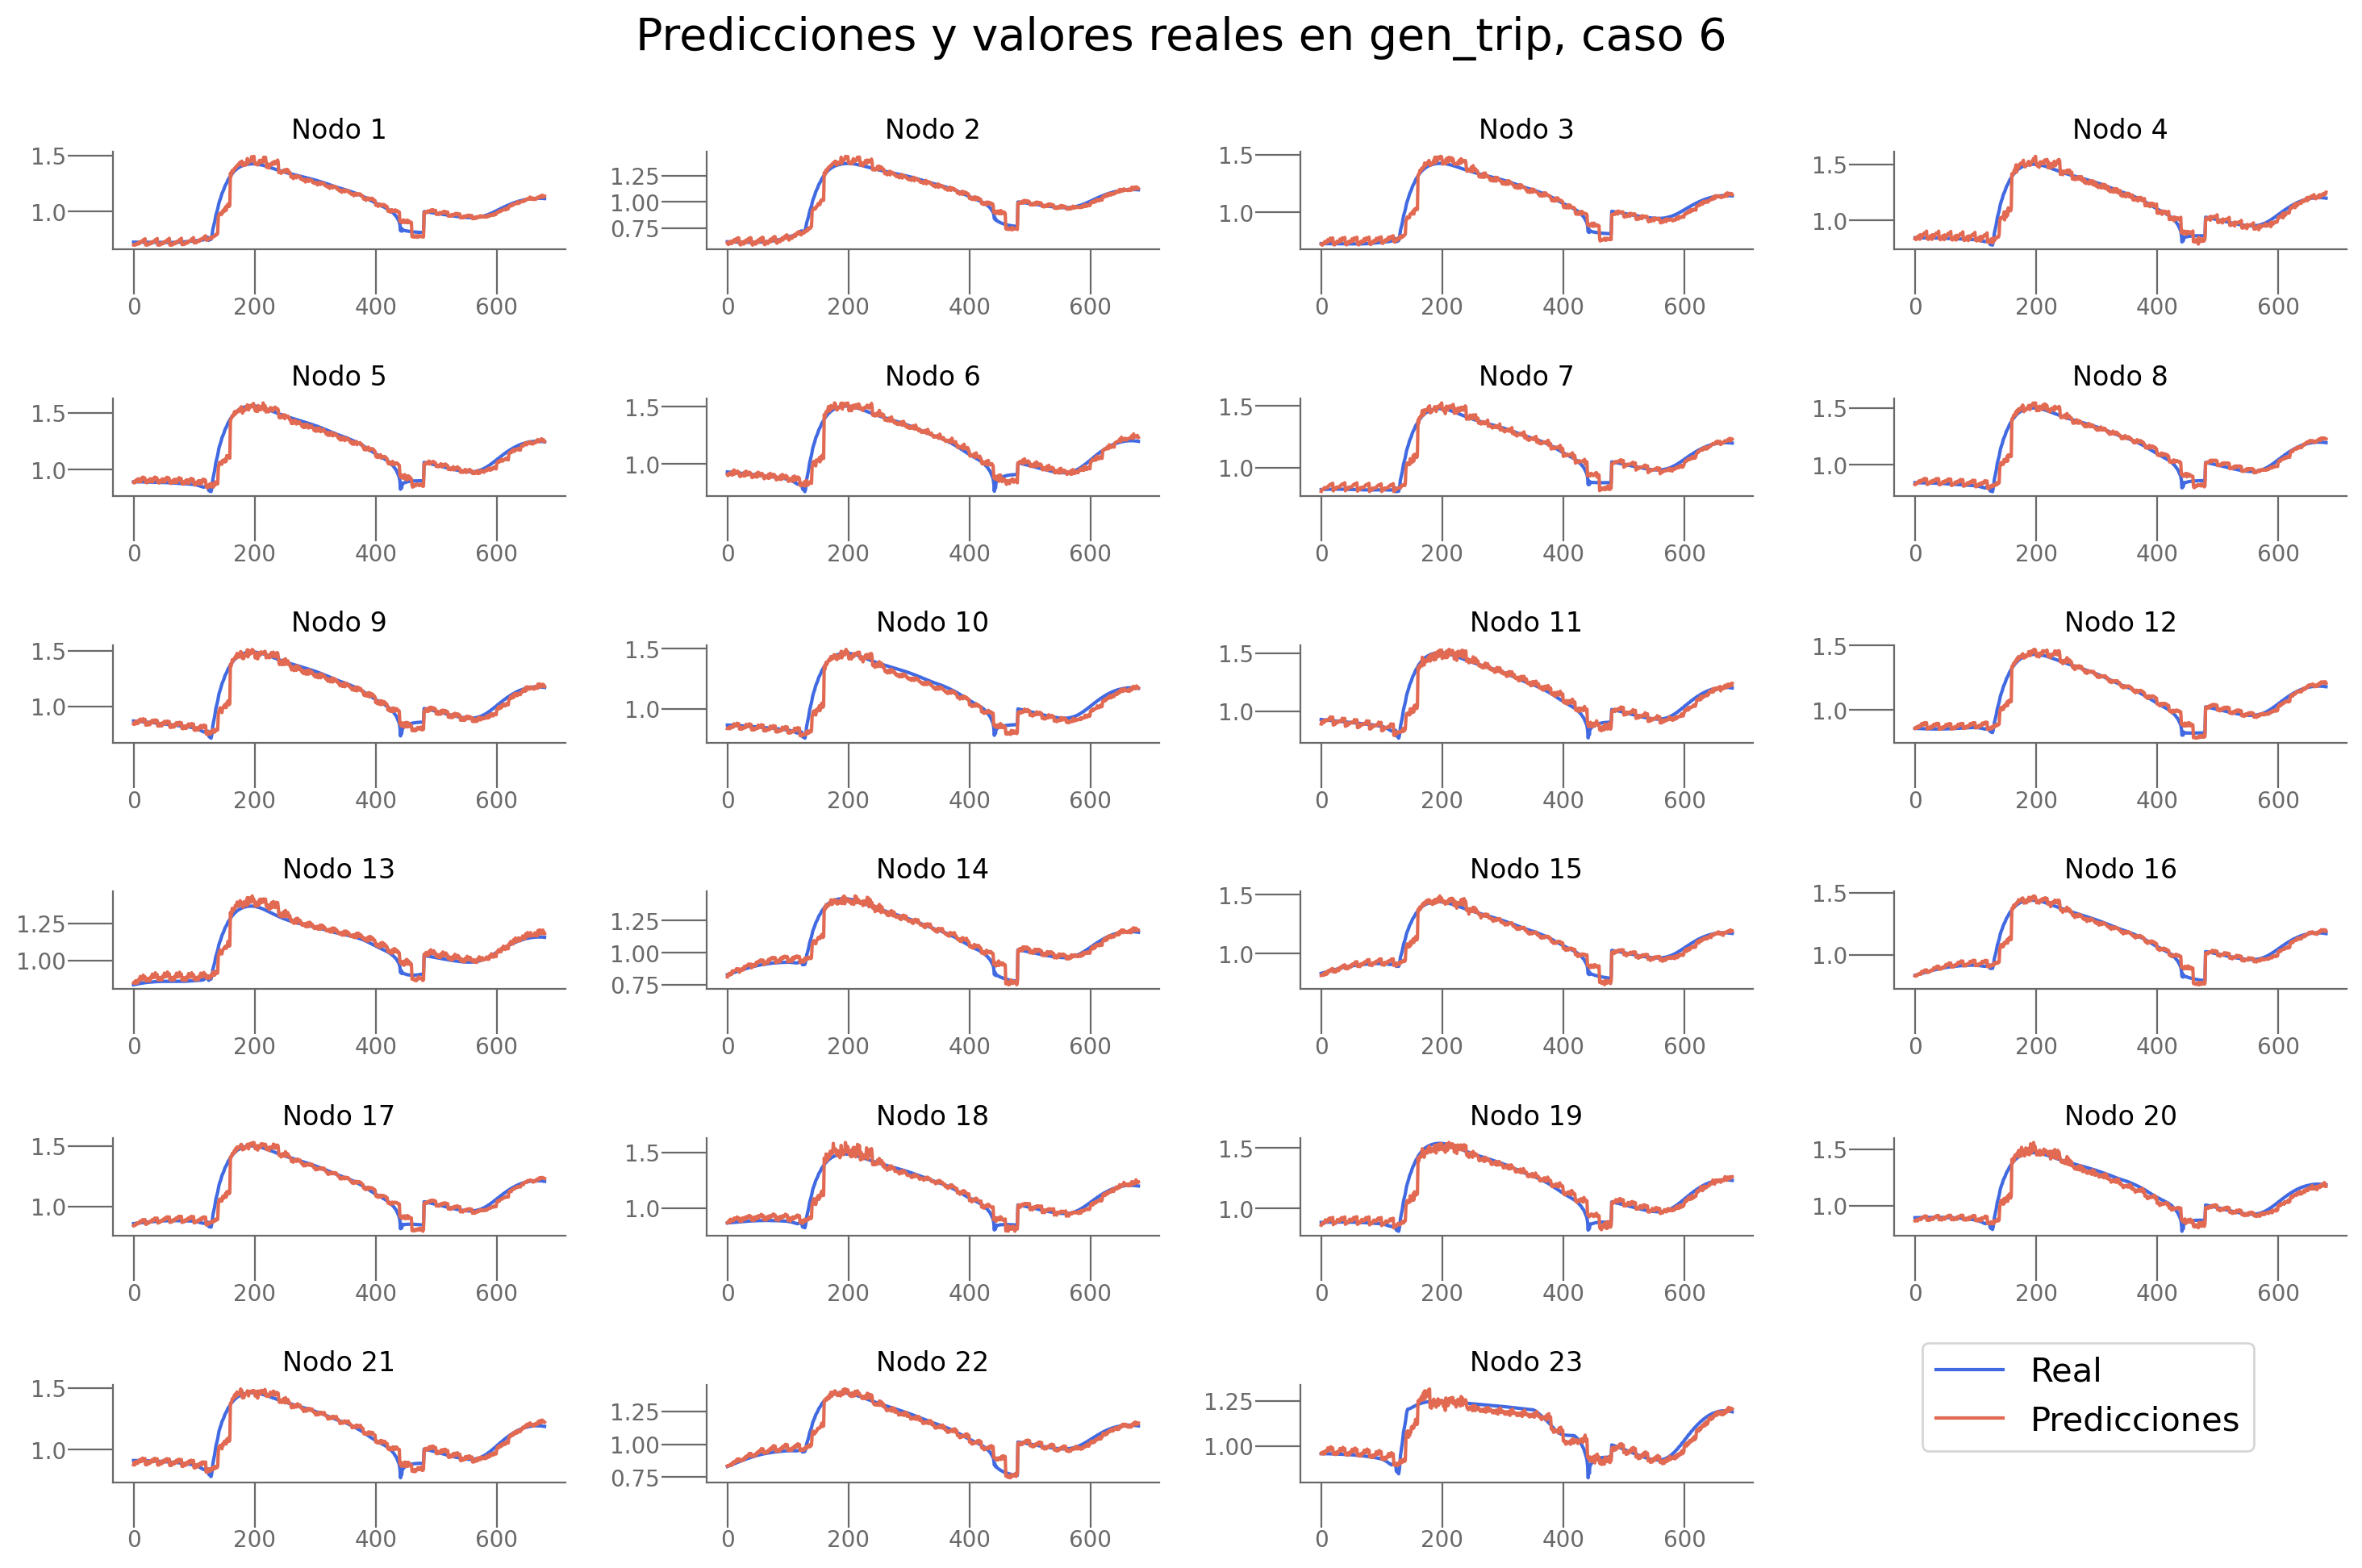

In [16]:
plot_predictions(predictions, real, n_target, 6, n_div_gt, problem_gt)

In [17]:
path_save_experiment_gt = results_save_path+f"/{problem_gt}"+ f"/ajustes/{name_model}_results.csv"
resultados_gt.to_csv(path_save_experiment_gt, index=False)

In [18]:
trainer_gt.save_model(params=params_gt, path_save_experiment= path_save_experiment_gt)


==================== GUARDANDO RESULTADOS ===================

         Modelo                                             Params  \
0          LSTM                                                NaN   
1     MPNN_LSTM                {'hidden_size': 16, 'dropout': 0.2}   
2  LSTM_NOBATCH                                                NaN   
3   DyGrEncoder              {'aggr': 'add', 'conv': 1, 'lstm': 1}   
4         AGCRN                              {'hidden': 5, 'K': 2}   
5     EvolveGCN                                                NaN   
6         DCRNN                                     {'hidden': 10}   
7        MSTGCN  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_...   

                      Fichero_resultados_experimento  Loss_tst     R2_tst  \
0                                                NaN  0.007638   0.204209   
1    ./results/gen_trip/ajustes/MPNNLSTM_results.csv  0.045889 -18.247558   
2                                                NaN  0.007437  -1.985579 

### Bus trip

In [19]:
problem_bt = "bus_trip"
dataset_bt, situations_bt = loader.get_dataset( target= 20, intro=100, step=20, one_ts_per_situation=False, start = 1, type=problem_bt)




Number of situations:  549
Number of timestamps:  800
Number of situations of the selected type:  86


In [20]:
n_div_bt = loader.div
n_nodes =dataset_bt.features[0].shape[0]
n_target = dataset_bt.targets[0].shape[1]
n_features = dataset_bt[0].x.shape[1]


num_early_stop = 0
num_epochs = 30
lr = 0.01

#### Sencilla 

In [12]:

device =  torch.device("cpu")
model_bt = MSTGCNModel(name="MSTGCN", node_features=n_features, node_count=n_nodes, n_target=n_target, nb_block=2, k=2, nb_chev_filter = 2, nb_time_filter =2, time_strides = 2)

trainer_bt = TrainerMSTGCN(model_bt, dataset_bt,device, f"./results/{problem_bt}", dataloader_params2)


losses,eval_losses, r2scores  = trainer_bt.train(num_epochs=num_epochs, steps=50, num_early_stop=num_early_stop)





==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430
AQuissss

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.3984 | Eval Loss: 0.2718 | Eval R2: -7.1887 | LR: 0.0010 | 
Epoch 2/30 | Train Loss: 0.2490 | Eval Loss: 0.2194 | Eval R2: -5.5917 | LR: 0.0010 | 
Epoch 3/30 | Train Loss: 0.2230 | Eval Loss: 0.2144 | Eval R2: -5.4394 | LR: 0.0010 | 
Epoch 4/30 | Train Loss: 0.2219 | Eval Loss: 0.1994 | Eval R2: -4.8970 | LR: 0.0010 | 
Epoch 5/30 | Train Loss: 0.2001 | Eval Loss: 0.1897 | Eval R2: -4.5734 | LR: 0.0010 | 
Epoch 6/30 | Train Loss: 0.1978 | Eval Loss: 0.1898 | Eval R2: -4.5750 | LR: 0.0010 | 
Epoch 7/30 | Train Loss: 0.1689 | Eval Loss: 0.1452 | Eval R2: -2.9278 | LR: 0.0010 | 
Epoch 8/30 | Train Loss: 0.1502 | Eval Loss: 0.1417 | Eval R2: -2.8185 | LR: 0.0010 | 
Epoch 9/30 | Train Loss: 0.1327 | Eval Loss: 0.1190 | Eval R2: -2.2451 | LR: 0.0010 | 
Epoch 10/30 | Train Loss: 0.1099 | E

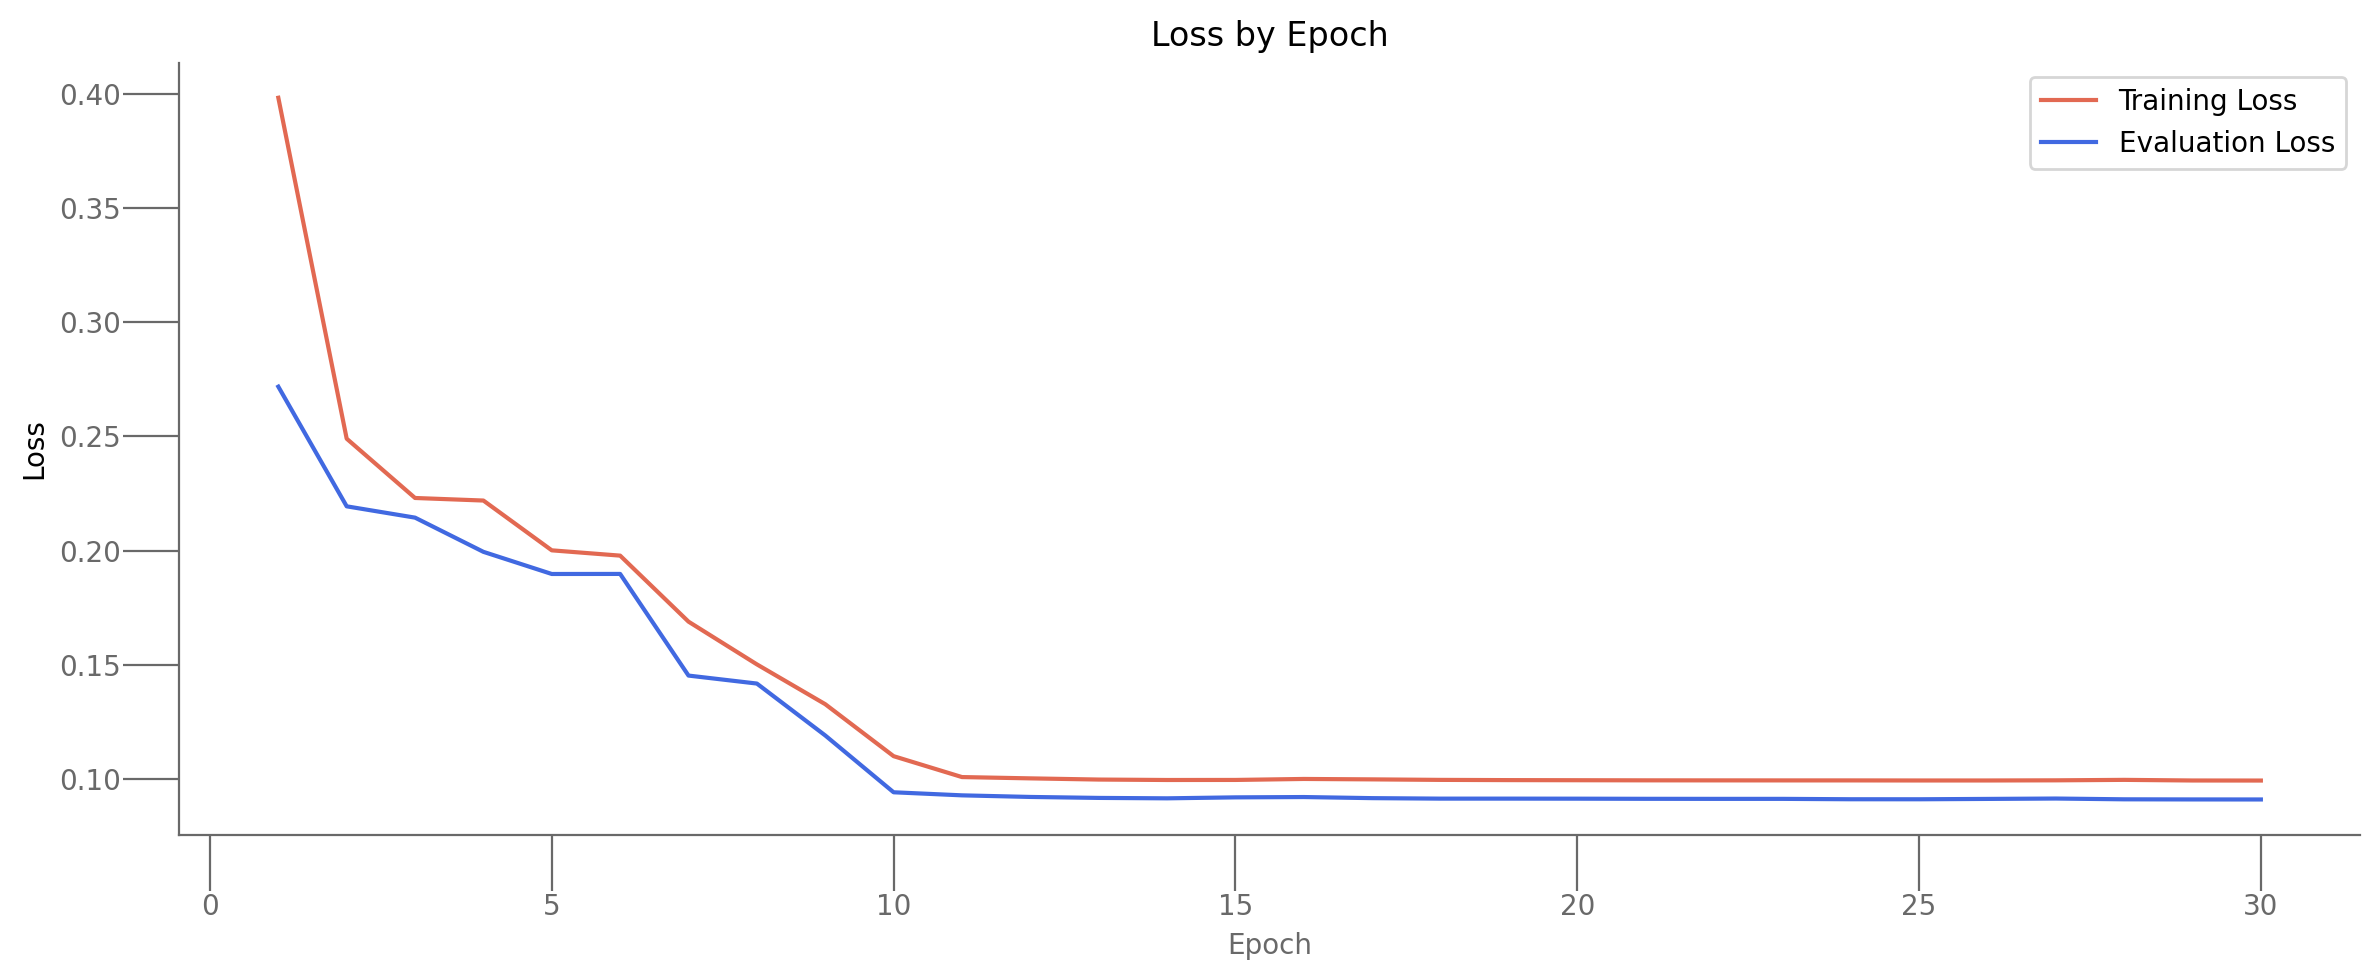


==================== TEST INFO ===================

preds:  (1, 23, 20)
test loss: 0.097667, test r2score -1.288585


In [13]:
plot_training_and_eval_losses(np.array(losses), np.array(eval_losses), num_epochs, format_plot)
losses_tst, r2score_tst, loss_nodes, predictions_bt, real_bt = trainer_bt.test()

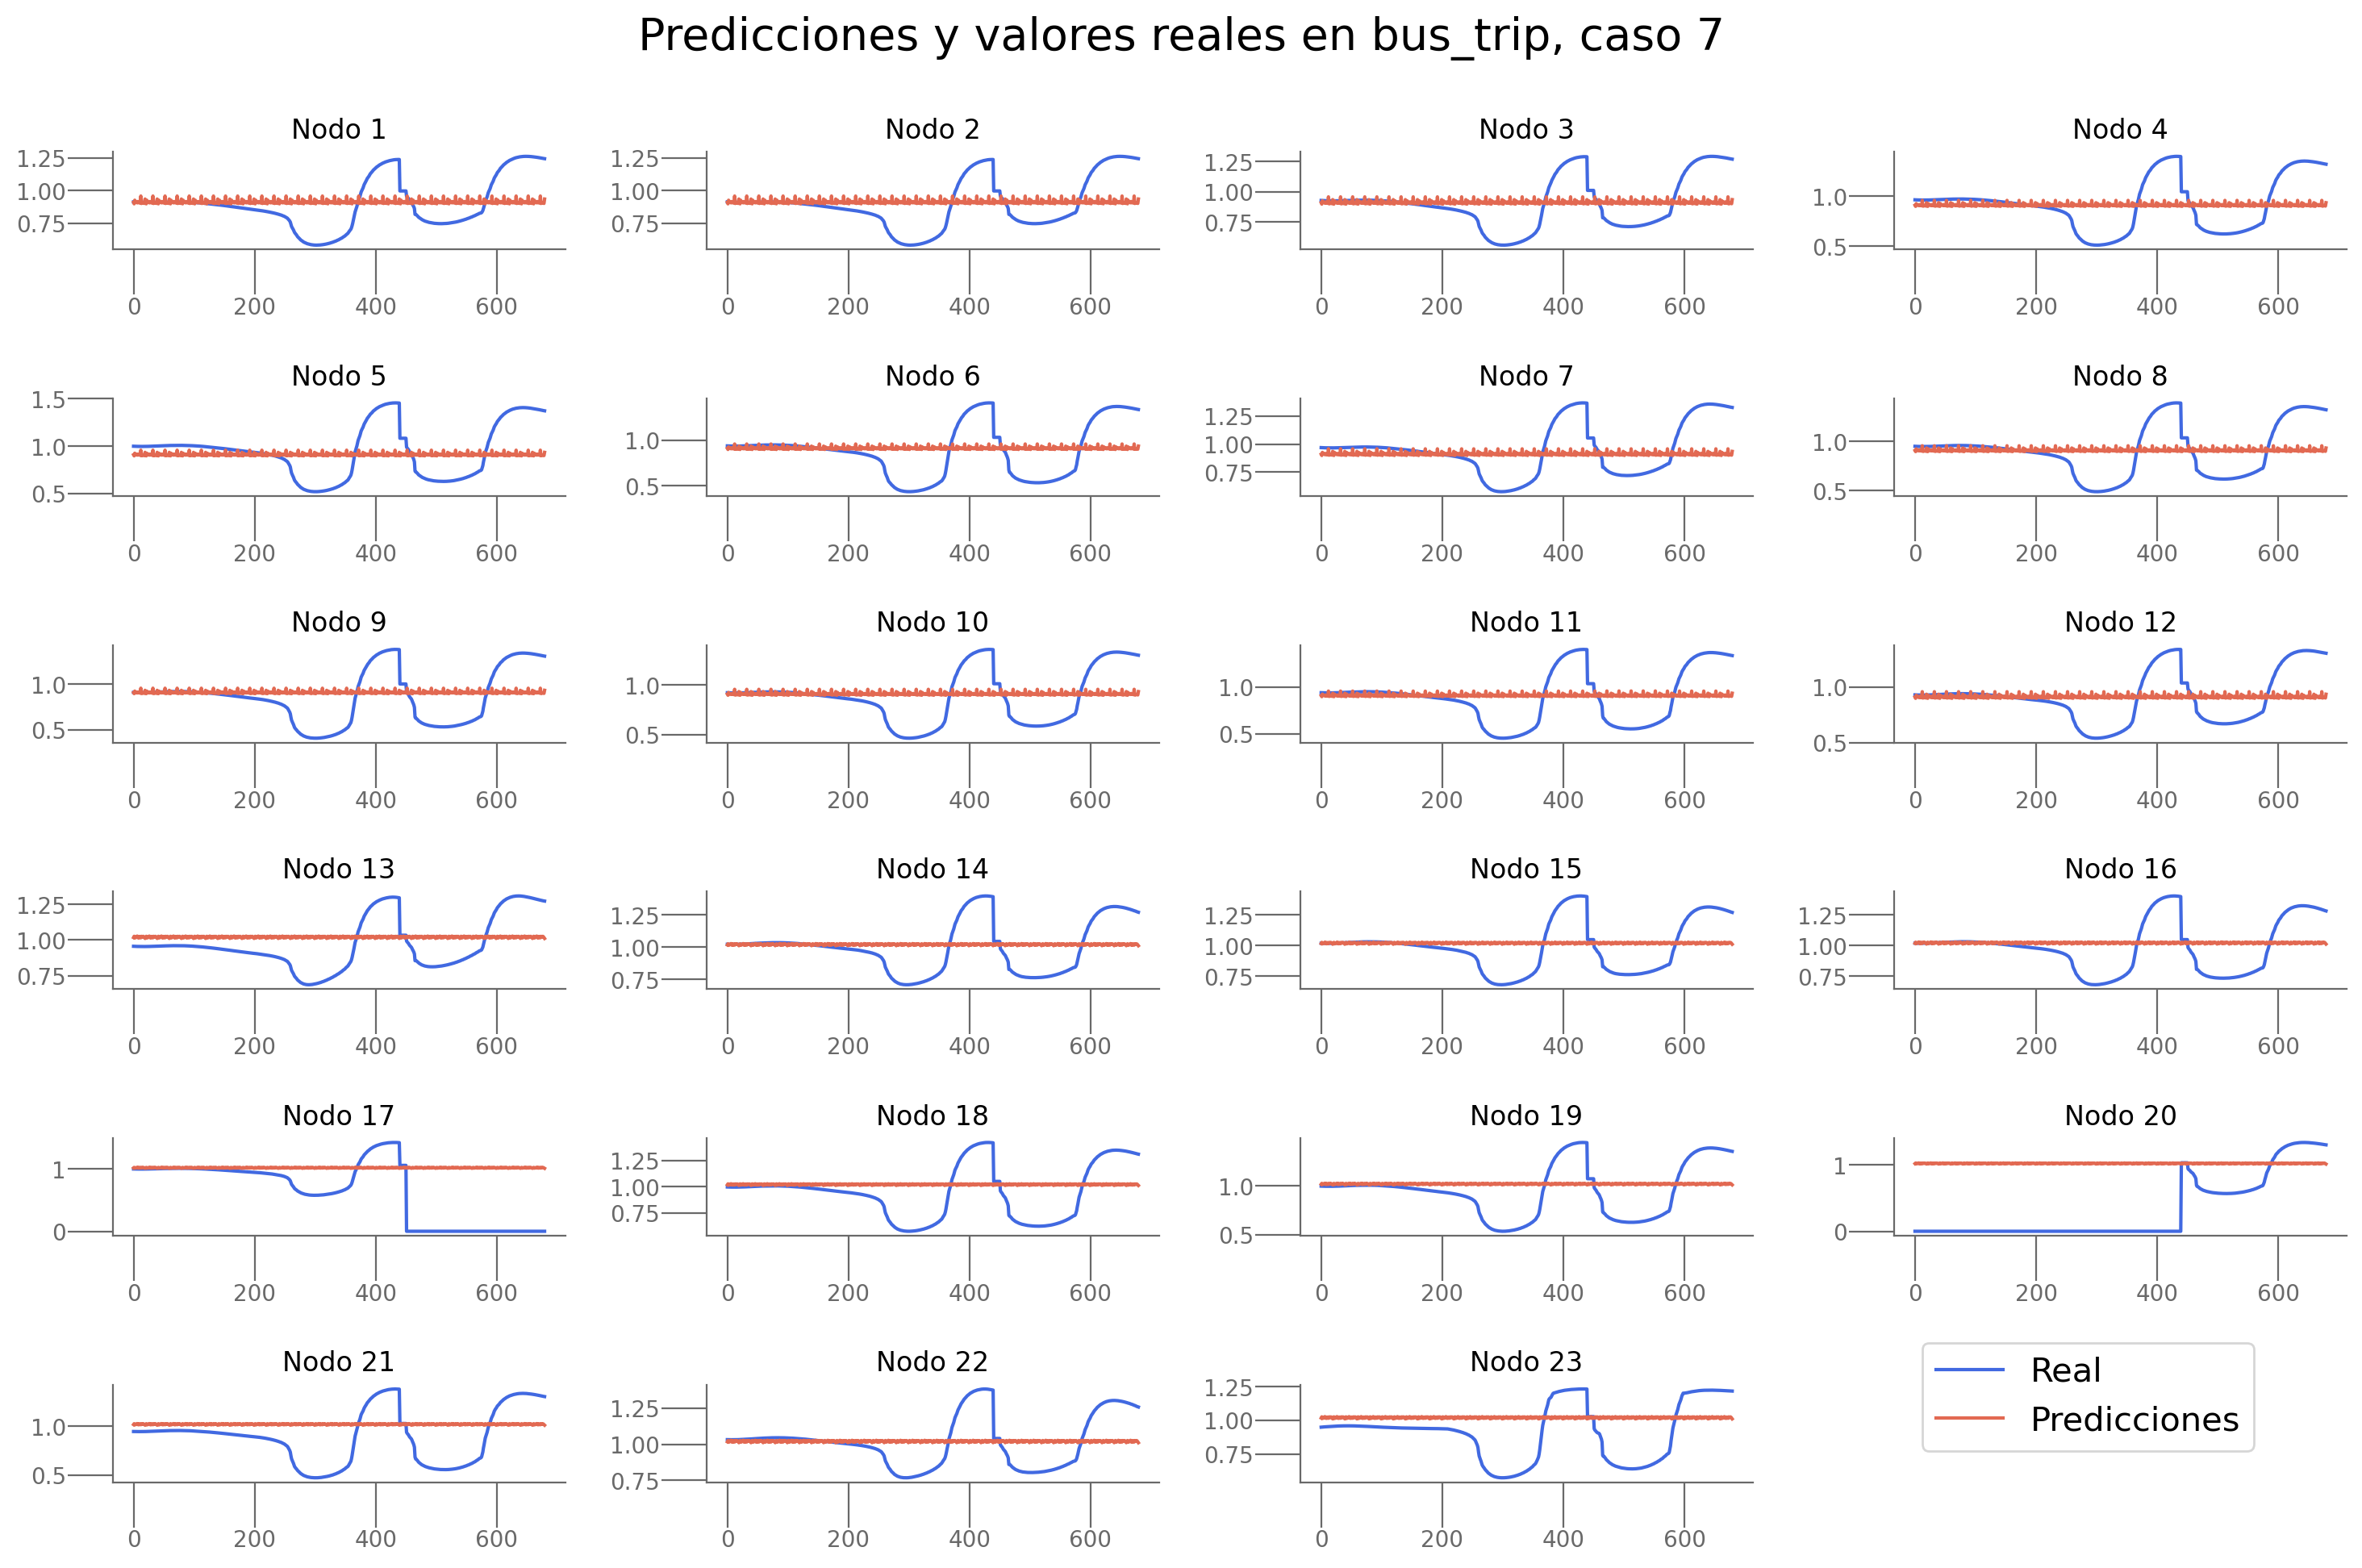

In [14]:
plot_predictions(predictions_bt, real_bt, n_target, 7, n_div_bt, problem_bt)

#### Ajuste de parámetros 

In [21]:


num_epochs = 100
num_early_stop = 10

trainer_bt,params_bt,resultados_final_bt, resultados_bt = entrenar_y_evaluar_modelos_mstgcn(param_grid, dataset_bt, dataloader_params2, num_early_stop=num_early_stop, num_epochs=num_epochs, problem=problem_bt)

  0%|          | 0/54 [00:00<?, ?it/s]

Entrenando modelo con nb_block=1, nb_chev_filter=2, nb_time_filter=2, time_strides=2, hidden=50

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== TRAIN INFO ===================

Epoch 1/100 | Train Loss: 0.5098 | Eval Loss: 0.3320 | Eval R2: -10.5925 | LR: 0.0010 | 
Epoch 2/100 | Train Loss: 0.2537 | Eval Loss: 0.1812 | Eval R2: -4.7574 | LR: 0.0010 | 
Epoch 3/100 | Train Loss: 0.1590 | Eval Loss: 0.1370 | Eval R2: -2.8521 | LR: 0.0010 | 
Epoch 4/100 | Train Loss: 0.1326 | Eval Loss: 0.1205 | Eval R2: -2.1376 | LR: 0.0010 | 
Epoch 5/100 | Train Loss: 0.1183 | Eval Loss: 0.1097 | Eval R2: -1.7428 | LR: 0.0010 | 
Epoch 6/100 | Train Loss: 0.1110 | Eval Loss: 0.1039 | Eval R2: -1.5312 | LR: 0.0010 | 
Epoch 7/100 | Train Loss: 0.1066 | Eval Loss: 0.1003 | Eval R2: -1.3830 | LR: 0.0010 | 
Epoch 8/100 | Train Loss: 0.1039 | Eval Loss: 0.0979 | Eval R2: -1.2741 | LR: 0.0010 | 
Epoch 9/100 | Train Loss: 0

  2%|▏         | 1/54 [06:50<6:02:59, 410.94s/it]

preds:  (1, 23, 20)
test loss: 0.094949, test R2 score: -1.244541
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 50, 'time_strides': 2, 'loss_final': 0.09688714146614075, 'r2_eval_final': -1.0047920942306519, 'loss_eval_final': 0.09117685258388519, 'r2_test': -1.2445414717055274, 'loss_test': 0.09494943916797638, 'loss_nodes': [0.18051038682460785, 0.06087281554937363, 0.056565381586551666, 0.1316426694393158, 0.07099281251430511, 0.07111172378063202, 0.0562332458794117, 0.13400232791900635, 0.07563592493534088, 0.1294379085302353, 0.07168538868427277, 0.05536869540810585, 0.04268877953290939, 0.11422326415777206, 0.1126641109585762, 0.04735368862748146, 0.18642933666706085, 0.05972671136260033, 0.14405269920825958, 0.17036986351013184, 0.06550915539264679, 0.04214143380522728, 0.10461881011724472]}
Entrenando modelo con nb_block=1, nb_chev_filter=2, nb_time_filter=2, time_strides=2, hidden=80

==================== DATASET INFO ============

  4%|▎         | 2/54 [13:45<5:57:56, 413.00s/it]

preds:  (1, 23, 20)
test loss: 0.094950, test R2 score: -1.244544
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 80, 'time_strides': 2, 'loss_final': 0.09688718616962433, 'r2_eval_final': -1.004792332649231, 'loss_eval_final': 0.09117689728736877, 'r2_test': -1.2445439986766973, 'loss_test': 0.09494953602552414, 'loss_nodes': [0.1805102527141571, 0.06087276712059975, 0.05656532943248749, 0.131642684340477, 0.0709928348660469, 0.07111170887947083, 0.0562332458794117, 0.13400278985500336, 0.0756361111998558, 0.12943780422210693, 0.0716853216290474, 0.055369749665260315, 0.042688749730587006, 0.11422332376241684, 0.11266423016786575, 0.047353729605674744, 0.18642939627170563, 0.059726737439632416, 0.1440526694059372, 0.17037013173103333, 0.06550915539264679, 0.042141325771808624, 0.10461924225091934]}
Entrenando modelo con nb_block=1, nb_chev_filter=2, nb_time_filter=2, time_strides=2, hidden=100

==================== DATASET INFO ============

  6%|▌         | 3/54 [20:22<5:45:03, 405.95s/it]

preds:  (1, 23, 20)
test loss: 0.094949, test R2 score: -1.244543
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 100, 'time_strides': 2, 'loss_final': 0.09688714146614075, 'r2_eval_final': -1.004789113998413, 'loss_eval_final': 0.09117677062749863, 'r2_test': -1.2445431721837552, 'loss_test': 0.09494948387145996, 'loss_nodes': [0.1805102527141571, 0.060872774571180344, 0.0565653033554554, 0.13164272904396057, 0.07099282741546631, 0.07111172378063202, 0.0562332421541214, 0.1340024620294571, 0.07563576102256775, 0.12943795323371887, 0.0716853216290474, 0.055369697511196136, 0.04268873855471611, 0.11422327905893326, 0.11266419291496277, 0.047353606671094894, 0.18642933666706085, 0.05972672253847122, 0.144052654504776, 0.17036989331245422, 0.06550914794206619, 0.04214135557413101, 0.10461918264627457]}
Entrenando modelo con nb_block=1, nb_chev_filter=2, nb_time_filter=2, time_strides=5, hidden=50

==================== DATASET INFO =============

  7%|▋         | 4/54 [26:48<5:31:30, 397.81s/it]

preds:  (1, 23, 20)
test loss: 0.321109, test R2 score: -7.612871
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 50, 'time_strides': 5, 'loss_final': 0.3250941336154938, 'r2_eval_final': -9.877485275268555, 'loss_eval_final': 0.32419729232788086, 'r2_test': -7.612870903748736, 'loss_test': 0.32110899686813354, 'loss_nodes': [0.3344358503818512, 0.2822761833667755, 0.2865068018436432, 0.34409868717193604, 0.33521562814712524, 0.30906328558921814, 0.3112456202507019, 0.3383781313896179, 0.2950023412704468, 0.32360073924064636, 0.3098454773426056, 0.29139086604118347, 0.29489800333976746, 0.33772870898246765, 0.3430887758731842, 0.3115995526313782, 0.37640970945358276, 0.31377124786376953, 0.36623454093933105, 0.3610782325267792, 0.3021480441093445, 0.31061267852783203, 0.30687782168388367]}
Entrenando modelo con nb_block=1, nb_chev_filter=2, nb_time_filter=2, time_strides=5, hidden=80

==================== DATASET INFO ===================

Tr

  9%|▉         | 5/54 [33:00<5:17:12, 388.41s/it]

preds:  (1, 23, 20)
test loss: 0.321109, test R2 score: -7.612871
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 80, 'time_strides': 5, 'loss_final': 0.3250941336154938, 'r2_eval_final': -9.877485275268555, 'loss_eval_final': 0.32419729232788086, 'r2_test': -7.612870893464292, 'loss_test': 0.32110899686813354, 'loss_nodes': [0.3344358503818512, 0.2822762131690979, 0.2865068316459656, 0.34409868717193604, 0.33521562814712524, 0.30906328558921814, 0.3112456500530243, 0.3383781313896179, 0.2950023412704468, 0.32360073924064636, 0.3098454773426056, 0.2913908362388611, 0.29489800333976746, 0.33772870898246765, 0.3430887758731842, 0.3115995526313782, 0.37640970945358276, 0.31377124786376953, 0.36623454093933105, 0.3610782325267792, 0.30214807391166687, 0.31061267852783203, 0.30687785148620605]}
Entrenando modelo con nb_block=1, nb_chev_filter=2, nb_time_filter=2, time_strides=5, hidden=100

==================== DATASET INFO ===================

T

 11%|█         | 6/54 [38:50<5:00:20, 375.43s/it]

preds:  (1, 23, 20)
test loss: 0.321109, test R2 score: -7.612871
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 100, 'time_strides': 5, 'loss_final': 0.3250941336154938, 'r2_eval_final': -9.877485275268555, 'loss_eval_final': 0.32419729232788086, 'r2_test': -7.612870925731016, 'loss_test': 0.32110899686813354, 'loss_nodes': [0.3344358503818512, 0.2822762131690979, 0.2865068018436432, 0.34409868717193604, 0.33521562814712524, 0.30906328558921814, 0.3112456500530243, 0.3383781313896179, 0.2950023412704468, 0.32360073924064636, 0.3098454773426056, 0.2913908362388611, 0.29489800333976746, 0.33772870898246765, 0.3430887758731842, 0.3115995526313782, 0.37640970945358276, 0.31377124786376953, 0.36623454093933105, 0.3610782325267792, 0.3021480441093445, 0.31061267852783203, 0.30687785148620605]}
Entrenando modelo con nb_block=1, nb_chev_filter=2, nb_time_filter=2, time_strides=10, hidden=50

==================== DATASET INFO ===================

T

 13%|█▎        | 7/54 [44:44<4:48:38, 368.48s/it]

preds:  (1, 23, 20)
test loss: 0.058401, test R2 score: -0.388757
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 50, 'time_strides': 10, 'loss_final': 0.05835132673382759, 'r2_eval_final': -0.17026479542255402, 'loss_eval_final': 0.051636405289173126, 'r2_test': -0.38875665967381096, 'loss_test': 0.0584007203578949, 'loss_nodes': [0.03730423003435135, 0.06171640381217003, 0.064768947660923, 0.07719988375902176, 0.0729144737124443, 0.0908217579126358, 0.06292033195495605, 0.07167018204927444, 0.07806562632322311, 0.06315607577562332, 0.06724423915147781, 0.04946846142411232, 0.034647151827812195, 0.036982715129852295, 0.04809386283159256, 0.04681366682052612, 0.05887150764465332, 0.05801182612776756, 0.06742848455905914, 0.061953987926244736, 0.06204085424542427, 0.0306519977748394, 0.04046976938843727]}
Entrenando modelo con nb_block=1, nb_chev_filter=2, nb_time_filter=2, time_strides=10, hidden=80

==================== DATASET INFO =======

 15%|█▍        | 8/54 [50:40<4:39:27, 364.50s/it]

preds:  (1, 23, 20)
test loss: 0.058630, test R2 score: -0.392511
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 80, 'time_strides': 10, 'loss_final': 0.05846112594008446, 'r2_eval_final': -0.1714753359556198, 'loss_eval_final': 0.051649484783411026, 'r2_test': -0.3925105919257441, 'loss_test': 0.05863047018647194, 'loss_nodes': [0.03741450235247612, 0.06204807758331299, 0.06608489155769348, 0.07829973101615906, 0.07394643127918243, 0.09283982962369919, 0.06328605115413666, 0.0717817097902298, 0.07725410163402557, 0.06275516748428345, 0.06726367026567459, 0.0495234951376915, 0.03464779257774353, 0.03701717406511307, 0.048118945211172104, 0.04680786281824112, 0.059014081954956055, 0.05825196951627731, 0.06768972426652908, 0.06196066737174988, 0.061201438307762146, 0.030624309554696083, 0.040668945759534836]}
Entrenando modelo con nb_block=1, nb_chev_filter=2, nb_time_filter=2, time_strides=10, hidden=100

==================== DATASET INFO ==

 17%|█▋        | 9/54 [56:52<4:35:04, 366.77s/it]

preds:  (1, 23, 20)
test loss: 0.058423, test R2 score: -0.391606
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 100, 'time_strides': 10, 'loss_final': 0.05840562656521797, 'r2_eval_final': -0.17134621739387512, 'loss_eval_final': 0.05164531245827675, 'r2_test': -0.39160575805772546, 'loss_test': 0.05842331424355507, 'loss_nodes': [0.037348028272390366, 0.06162675470113754, 0.06484830379486084, 0.07731691747903824, 0.07324947416782379, 0.09173549711704254, 0.06292979419231415, 0.07182922214269638, 0.07691191136837006, 0.06235656142234802, 0.06734573841094971, 0.049628958106040955, 0.034644898027181625, 0.03699169307947159, 0.0480925552546978, 0.04680666700005531, 0.05889806151390076, 0.05782323330640793, 0.06770428270101547, 0.06209269538521767, 0.06197674944996834, 0.030628999695181847, 0.040949270129203796]}
Entrenando modelo con nb_block=1, nb_chev_filter=4, nb_time_filter=4, time_strides=2, hidden=50

==================== DATASET INFO =

 19%|█▊        | 10/54 [1:03:55<4:41:50, 384.32s/it]

preds:  (1, 23, 20)
test loss: 0.210445, test R2 score: -4.166191
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 50, 'time_strides': 2, 'loss_final': 0.21026715636253357, 'r2_eval_final': -6.001720905303955, 'loss_eval_final': 0.21453145146369934, 'r2_test': -4.166190761398831, 'loss_test': 0.2104453444480896, 'loss_nodes': [0.17156285047531128, 0.19792909920215607, 0.20479261875152588, 0.20511487126350403, 0.23872357606887817, 0.21974849700927734, 0.22351191937923431, 0.2023271918296814, 0.20708835124969482, 0.19067370891571045, 0.22170938551425934, 0.21132290363311768, 0.21855653822422028, 0.21093615889549255, 0.21073083579540253, 0.22733812034130096, 0.1977863907814026, 0.22643864154815674, 0.22055742144584656, 0.19283786416053772, 0.2180403769016266, 0.23179744184017181, 0.1907179355621338]}
Entrenando modelo con nb_block=1, nb_chev_filter=4, nb_time_filter=4, time_strides=2, hidden=80

==================== DATASET INFO ================

 20%|██        | 11/54 [1:11:00<4:44:16, 396.66s/it]

preds:  (1, 23, 20)
test loss: 0.210446, test R2 score: -4.166199
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 80, 'time_strides': 2, 'loss_final': 0.21026748418807983, 'r2_eval_final': -6.001729965209961, 'loss_eval_final': 0.2145317643880844, 'r2_test': -4.166198507643174, 'loss_test': 0.21044567227363586, 'loss_nodes': [0.17156292498111725, 0.19792936742305756, 0.20479291677474976, 0.20511536300182343, 0.238724023103714, 0.21974895894527435, 0.22351239621639252, 0.20232754945755005, 0.20708847045898438, 0.1906740516424179, 0.22170966863632202, 0.2113230675458908, 0.21855656802654266, 0.21093666553497314, 0.21073128283023834, 0.22733843326568604, 0.19778668880462646, 0.22643910348415375, 0.2205577790737152, 0.19283819198608398, 0.2180406153202057, 0.2317974865436554, 0.19071809947490692]}
Entrenando modelo con nb_block=1, nb_chev_filter=4, nb_time_filter=4, time_strides=2, hidden=100

==================== DATASET INFO ==================

 22%|██▏       | 12/54 [1:18:01<4:42:50, 404.06s/it]

preds:  (1, 23, 20)
test loss: 0.210446, test R2 score: -4.166198
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 100, 'time_strides': 2, 'loss_final': 0.21026743948459625, 'r2_eval_final': -6.001728534698486, 'loss_eval_final': 0.21453167498111725, 'r2_test': -4.166197633279351, 'loss_test': 0.2104455977678299, 'loss_nodes': [0.17156296968460083, 0.19792936742305756, 0.20479273796081543, 0.20511527359485626, 0.2387239784002304, 0.21974879503250122, 0.22351224720478058, 0.20232753455638885, 0.20708836615085602, 0.1906738579273224, 0.22170953452587128, 0.21132303774356842, 0.2185564935207367, 0.21093687415122986, 0.21073119342327118, 0.22733837366104126, 0.1977865993976593, 0.22643901407718658, 0.22055752575397491, 0.19283805787563324, 0.21804063022136688, 0.23179741203784943, 0.19071820378303528]}
Entrenando modelo con nb_block=1, nb_chev_filter=4, nb_time_filter=4, time_strides=5, hidden=50

==================== DATASET INFO ===============

 24%|██▍       | 13/54 [1:24:12<4:29:11, 393.95s/it]

preds:  (1, 23, 20)
test loss: 0.414252, test R2 score: -11.663723
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 50, 'time_strides': 5, 'loss_final': 0.4153633117675781, 'r2_eval_final': -14.756658554077148, 'loss_eval_final': 0.4218195378780365, 'r2_test': -11.663722909801631, 'loss_test': 0.41425150632858276, 'loss_nodes': [0.3402698040008545, 0.39192718267440796, 0.40450310707092285, 0.4033180773258209, 0.46667537093162537, 0.4297164976596832, 0.4415796399116516, 0.3975164294242859, 0.40488165616989136, 0.375042587518692, 0.4328387677669525, 0.4173998534679413, 0.43416428565979004, 0.415780633687973, 0.4170297384262085, 0.44963768124580383, 0.38840019702911377, 0.44424641132354736, 0.43205979466438293, 0.3796229064464569, 0.4259384870529175, 0.46058526635169983, 0.374650776386261]}
Entrenando modelo con nb_block=1, nb_chev_filter=4, nb_time_filter=4, time_strides=5, hidden=80

==================== DATASET INFO ===================

Train

 26%|██▌       | 14/54 [1:30:36<4:20:47, 391.19s/it]

preds:  (1, 23, 20)
test loss: 0.414252, test R2 score: -11.663728
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 80, 'time_strides': 5, 'loss_final': 0.41536352038383484, 'r2_eval_final': -14.756664276123047, 'loss_eval_final': 0.4218197762966156, 'r2_test': -11.663727874170146, 'loss_test': 0.4142517149448395, 'loss_nodes': [0.34026992321014404, 0.3919273316860199, 0.40450331568717957, 0.40331852436065674, 0.46667584776878357, 0.4297167658805847, 0.4415798783302307, 0.3975166976451874, 0.40488189458847046, 0.3750428259372711, 0.4328390061855316, 0.4174000322818756, 0.4341643452644348, 0.41578081250190735, 0.4170299172401428, 0.4496380090713501, 0.3884004056453705, 0.44424673914909363, 0.4320600926876068, 0.3796231150627136, 0.4259386658668518, 0.4605853855609894, 0.3746509253978729]}
Entrenando modelo con nb_block=1, nb_chev_filter=4, nb_time_filter=4, time_strides=5, hidden=100

==================== DATASET INFO ===================

Trai

 28%|██▊       | 15/54 [1:36:51<4:11:04, 386.26s/it]

preds:  (1, 23, 20)
test loss: 0.414252, test R2 score: -11.663730
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 100, 'time_strides': 5, 'loss_final': 0.415363609790802, 'r2_eval_final': -14.756665229797363, 'loss_eval_final': 0.4218198359012604, 'r2_test': -11.663729998845023, 'loss_test': 0.41425180435180664, 'loss_nodes': [0.340270072221756, 0.3919275403022766, 0.40450340509414673, 0.40331852436065674, 0.4666759669780731, 0.4297168254852295, 0.4415799379348755, 0.39751675724983215, 0.4048819839954376, 0.37504294514656067, 0.43283915519714355, 0.4174001216888428, 0.4341643452644348, 0.4157809019088745, 0.4170300364494324, 0.4496380686759949, 0.3884004056453705, 0.444246768951416, 0.4320601224899292, 0.3796231746673584, 0.42593881487846375, 0.46058541536331177, 0.3746509552001953]}
Entrenando modelo con nb_block=1, nb_chev_filter=4, nb_time_filter=4, time_strides=10, hidden=50

==================== DATASET INFO ===================

Train 

 30%|██▉       | 16/54 [1:42:39<3:57:21, 374.78s/it]

preds:  (1, 23, 20)
test loss: 0.064049, test R2 score: -0.390009
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 50, 'time_strides': 10, 'loss_final': 0.061431027948856354, 'r2_eval_final': -0.6467544436454773, 'loss_eval_final': 0.06468981504440308, 'r2_test': -0.3900090056712704, 'loss_test': 0.06404922902584076, 'loss_nodes': [0.04926789924502373, 0.05628178268671036, 0.05966091528534889, 0.06439056992530823, 0.07453205436468124, 0.07162441313266754, 0.06564124673604965, 0.06711027771234512, 0.06866300851106644, 0.060783322900533676, 0.07075191289186478, 0.06253214180469513, 0.059683676809072495, 0.05982249975204468, 0.061316706240177155, 0.06528379023075104, 0.06476138532161713, 0.06886246800422668, 0.0695343092083931, 0.061729516834020615, 0.06847868859767914, 0.06298290193080902, 0.05943696200847626]}
Entrenando modelo con nb_block=1, nb_chev_filter=4, nb_time_filter=4, time_strides=10, hidden=80

==================== DATASET INFO ===

 31%|███▏      | 17/54 [1:48:36<3:47:44, 369.32s/it]

preds:  (1, 23, 20)
test loss: 0.064049, test R2 score: -0.390016
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 80, 'time_strides': 10, 'loss_final': 0.061431266367435455, 'r2_eval_final': -0.646764874458313, 'loss_eval_final': 0.06468997150659561, 'r2_test': -0.3900158934296399, 'loss_test': 0.06404935568571091, 'loss_nodes': [0.04926786944270134, 0.05628189444541931, 0.05966108292341232, 0.06439082324504852, 0.07453219592571259, 0.07162469625473022, 0.06564142554998398, 0.06711041927337646, 0.06866315007209778, 0.060783542692661285, 0.07075199484825134, 0.06253227591514587, 0.059683773666620255, 0.0598222017288208, 0.06131681054830551, 0.06528390198945999, 0.06476162374019623, 0.06886260211467743, 0.0695342943072319, 0.06172966957092285, 0.06847876310348511, 0.0629829689860344, 0.0594370998442173]}
Entrenando modelo con nb_block=1, nb_chev_filter=4, nb_time_filter=4, time_strides=10, hidden=100

==================== DATASET INFO ========

 33%|███▎      | 18/54 [1:54:53<3:42:53, 371.49s/it]

preds:  (1, 23, 20)
test loss: 0.064049, test R2 score: -0.390015
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 100, 'time_strides': 10, 'loss_final': 0.06143132597208023, 'r2_eval_final': -0.646774411201477, 'loss_eval_final': 0.06469012051820755, 'r2_test': -0.390014649096795, 'loss_test': 0.06404929608106613, 'loss_nodes': [0.04926786199212074, 0.056281980127096176, 0.0596611388027668, 0.06439077854156494, 0.07453220337629318, 0.0716247409582138, 0.065641388297081, 0.06711036711931229, 0.0686630830168724, 0.0607835091650486, 0.07075181603431702, 0.0625322163105011, 0.05968372896313667, 0.05982240289449692, 0.061316732317209244, 0.06528384983539581, 0.06476140022277832, 0.0688626766204834, 0.0695340633392334, 0.061729561537504196, 0.06847856193780899, 0.0629829466342926, 0.05943691357970238]}
Entrenando modelo con nb_block=1, nb_chev_filter=8, nb_time_filter=8, time_strides=2, hidden=50

==================== DATASET INFO ================

 35%|███▌      | 19/54 [2:02:40<3:53:26, 400.19s/it]

preds:  (1, 23, 20)
test loss: 0.207438, test R2 score: -4.723640
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 50, 'time_strides': 2, 'loss_final': 0.20708364248275757, 'r2_eval_final': -6.3643479347229, 'loss_eval_final': 0.21247801184654236, 'r2_test': -4.723639620570229, 'loss_test': 0.20743811130523682, 'loss_nodes': [0.16885001957416534, 0.19495004415512085, 0.20150917768478394, 0.2012900412082672, 0.2334558218717575, 0.21561944484710693, 0.22044681012630463, 0.1992568075656891, 0.20410828292369843, 0.18774890899658203, 0.21831965446472168, 0.2089870423078537, 0.2170245498418808, 0.20844899117946625, 0.20798203349113464, 0.22474485635757446, 0.19554011523723602, 0.2223263382911682, 0.21703527867794037, 0.19000226259231567, 0.21482382714748383, 0.22995005548000336, 0.188655823469162]}
Entrenando modelo con nb_block=1, nb_chev_filter=8, nb_time_filter=8, time_strides=2, hidden=80

==================== DATASET INFO ===================



 37%|███▋      | 20/54 [2:10:23<3:57:30, 419.14s/it]

preds:  (1, 23, 20)
test loss: 0.207438, test R2 score: -4.723639
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 80, 'time_strides': 2, 'loss_final': 0.20708361268043518, 'r2_eval_final': -6.364347457885742, 'loss_eval_final': 0.21247798204421997, 'r2_test': -4.723639146497125, 'loss_test': 0.20743809640407562, 'loss_nodes': [0.16885000467300415, 0.19495002925395966, 0.20150916278362274, 0.20128996670246124, 0.2334558218717575, 0.21561937034130096, 0.22044673562049866, 0.1992567926645279, 0.20410819351673126, 0.18774890899658203, 0.2183196097612381, 0.20898698270320892, 0.21702447533607483, 0.20844919979572296, 0.2079821079969406, 0.22474484145641327, 0.19554005563259125, 0.22232626378536224, 0.21703515946865082, 0.19000226259231567, 0.21482382714748383, 0.2299502044916153, 0.18865591287612915]}
Entrenando modelo con nb_block=1, nb_chev_filter=8, nb_time_filter=8, time_strides=2, hidden=100

==================== DATASET INFO ===============

 39%|███▉      | 21/54 [2:18:11<3:58:35, 433.79s/it]

preds:  (1, 23, 20)
test loss: 0.207438, test R2 score: -4.723638
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 100, 'time_strides': 2, 'loss_final': 0.207083597779274, 'r2_eval_final': -6.364348888397217, 'loss_eval_final': 0.21247801184654236, 'r2_test': -4.723638456591416, 'loss_test': 0.20743808150291443, 'loss_nodes': [0.16885001957416534, 0.19495001435279846, 0.20150917768478394, 0.20128993690013885, 0.2334558367729187, 0.21561932563781738, 0.22044678032398224, 0.19925673305988312, 0.2041081041097641, 0.18774887919425964, 0.21831953525543213, 0.20898686349391937, 0.21702447533607483, 0.2084493190050125, 0.20798207819461823, 0.22474482655525208, 0.19553999602794647, 0.22232630848884583, 0.217035174369812, 0.19000224769115448, 0.21482375264167786, 0.22995014488697052, 0.1886557936668396]}
Entrenando modelo con nb_block=1, nb_chev_filter=8, nb_time_filter=8, time_strides=5, hidden=50

==================== DATASET INFO ==================

 41%|████      | 22/54 [2:24:49<3:45:43, 423.22s/it]

preds:  (1, 23, 20)
test loss: 0.110693, test R2 score: -2.018196
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 50, 'time_strides': 5, 'loss_final': 0.108751580119133, 'r2_eval_final': -2.844691038131714, 'loss_eval_final': 0.11279591172933578, 'r2_test': -2.0181955564480516, 'loss_test': 0.11069297045469284, 'loss_nodes': [0.08864117413759232, 0.10175135731697083, 0.1061563789844513, 0.10854405909776688, 0.12629465758800507, 0.11788211762905121, 0.11619564890861511, 0.10844996571540833, 0.11196542531251907, 0.10169494897127151, 0.11907642334699631, 0.11040735244750977, 0.11162615567445755, 0.10844854265451431, 0.10905256122350693, 0.11769289523363113, 0.10629589110612869, 0.11936689168214798, 0.11750641465187073, 0.10323674976825714, 0.11665880680084229, 0.11806198209524155, 0.100931815803051]}
Entrenando modelo con nb_block=1, nb_chev_filter=8, nb_time_filter=8, time_strides=5, hidden=80

==================== DATASET INFO ===============

 43%|████▎     | 23/54 [2:31:40<3:36:42, 419.42s/it]

preds:  (1, 23, 20)
test loss: 0.110693, test R2 score: -2.018193
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 80, 'time_strides': 5, 'loss_final': 0.10875158756971359, 'r2_eval_final': -2.8446896076202393, 'loss_eval_final': 0.1127958819270134, 'r2_test': -2.0181933411412505, 'loss_test': 0.11069289594888687, 'loss_nodes': [0.08864114433526993, 0.10175129026174545, 0.10615638643503189, 0.10854394733905792, 0.12629452347755432, 0.11788194626569748, 0.1161956787109375, 0.10844989120960236, 0.11196529120206833, 0.10169479250907898, 0.11907630413770676, 0.110407255589962, 0.11162614077329636, 0.10844846069812775, 0.10905247926712036, 0.11769283562898636, 0.10629585385322571, 0.11936689913272858, 0.11750628799200058, 0.10323665291070938, 0.1166587844491005, 0.11806195974349976, 0.1009318009018898]}
Entrenando modelo con nb_block=1, nb_chev_filter=8, nb_time_filter=8, time_strides=5, hidden=100

==================== DATASET INFO ==============

 44%|████▍     | 24/54 [2:38:28<3:27:58, 415.94s/it]

preds:  (1, 23, 20)
test loss: 0.110693, test R2 score: -2.018194
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 100, 'time_strides': 5, 'loss_final': 0.1087515652179718, 'r2_eval_final': -2.8446900844573975, 'loss_eval_final': 0.11279591172933578, 'r2_test': -2.0181937378213086, 'loss_test': 0.11069292575120926, 'loss_nodes': [0.08864112943410873, 0.10175135731697083, 0.1061563566327095, 0.10854391753673553, 0.1262945830821991, 0.11788196861743927, 0.1161956712603569, 0.10844992846250534, 0.1119653582572937, 0.10169480741024017, 0.11907637864351273, 0.11040732264518738, 0.11162613332271576, 0.10844859480857849, 0.10905256122350693, 0.11769284307956696, 0.1062958836555481, 0.11936694383621216, 0.11750634014606476, 0.103236623108387, 0.11665884405374527, 0.11806196719408035, 0.100931815803051]}
Entrenando modelo con nb_block=1, nb_chev_filter=8, nb_time_filter=8, time_strides=10, hidden=50

==================== DATASET INFO =================

 46%|████▋     | 25/54 [2:44:39<3:14:35, 402.61s/it]

preds:  (1, 23, 20)
test loss: 0.014706, test R2 score: 0.656196
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 50, 'time_strides': 10, 'loss_final': 0.011212058365345001, 'r2_eval_final': 0.6967832446098328, 'loss_eval_final': 0.01237921416759491, 'r2_test': 0.6561955251783164, 'loss_test': 0.014705976471304893, 'loss_nodes': [0.007649064529687166, 0.009420567192137241, 0.010737310163676739, 0.01545898150652647, 0.017792321741580963, 0.020888155326247215, 0.012195137329399586, 0.020564522594213486, 0.022272884845733643, 0.01584881916642189, 0.021982312202453613, 0.013131530955433846, 0.007027256302535534, 0.00801782961934805, 0.010708661749958992, 0.010642836801707745, 0.019846951588988304, 0.014811400324106216, 0.019644711166620255, 0.01628834195435047, 0.02031542733311653, 0.006661924999207258, 0.016330501064658165]}
Entrenando modelo con nb_block=1, nb_chev_filter=8, nb_time_filter=8, time_strides=10, hidden=80

==================== DAT

 48%|████▊     | 26/54 [2:51:08<3:05:56, 398.46s/it]

preds:  (1, 23, 20)
test loss: 0.014706, test R2 score: 0.656187
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 80, 'time_strides': 10, 'loss_final': 0.011212192475795746, 'r2_eval_final': 0.6967750191688538, 'loss_eval_final': 0.012379386462271214, 'r2_test': 0.6561869833238063, 'loss_test': 0.01470622606575489, 'loss_nodes': [0.007649087347090244, 0.009420499205589294, 0.010737396776676178, 0.015459620393812656, 0.017792226746678352, 0.020888837054371834, 0.012195820920169353, 0.020564716309309006, 0.022273125126957893, 0.015848947688937187, 0.021982701495289803, 0.013131773099303246, 0.007027469575405121, 0.008018353022634983, 0.010708756744861603, 0.010642873123288155, 0.019847312942147255, 0.014811435714364052, 0.01964500918984413, 0.016288474202156067, 0.02031584642827511, 0.006662089377641678, 0.016330817714333534]}
Entrenando modelo con nb_block=1, nb_chev_filter=8, nb_time_filter=8, time_strides=10, hidden=100

====================

 50%|█████     | 27/54 [2:57:42<2:58:45, 397.24s/it]

preds:  (1, 23, 20)
test loss: 0.014706, test R2 score: 0.656194
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 100, 'time_strides': 10, 'loss_final': 0.011212111450731754, 'r2_eval_final': 0.6967822313308716, 'loss_eval_final': 0.012379264459013939, 'r2_test': 0.6561944343271653, 'loss_test': 0.014706030488014221, 'loss_nodes': [0.007649074774235487, 0.00942044798284769, 0.010737239383161068, 0.015459141694009304, 0.017792340368032455, 0.02088838443160057, 0.012195312418043613, 0.020564552396535873, 0.022272989153862, 0.015848934650421143, 0.021982379257678986, 0.013131566345691681, 0.007027235347777605, 0.008018157444894314, 0.010708616115152836, 0.010642803274095058, 0.019846998155117035, 0.014811408706009388, 0.019644713029265404, 0.016288472339510918, 0.02031550742685795, 0.006661918945610523, 0.016330523416399956]}
Entrenando modelo con nb_block=2, nb_chev_filter=2, nb_time_filter=2, time_strides=2, hidden=50

==================== DAT

 52%|█████▏    | 28/54 [3:09:28<3:32:13, 489.74s/it]

preds:  (1, 23, 20)
test loss: 0.140208, test R2 score: -2.813154
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 50, 'time_strides': 2, 'loss_final': 0.1426449716091156, 'r2_eval_final': -3.2495968341827393, 'loss_eval_final': 0.13773858547210693, 'r2_test': -2.813153971994445, 'loss_test': 0.14020764827728271, 'loss_nodes': [0.2026045173406601, 0.10302137583494186, 0.1009807139635086, 0.1780582219362259, 0.12592999637126923, 0.11818959563970566, 0.10841407626867294, 0.17657659947872162, 0.1174105852842331, 0.17047587037086487, 0.1166381686925888, 0.10147174447774887, 0.0886128693819046, 0.1570896953344345, 0.1638636589050293, 0.10218720883131027, 0.2296925187110901, 0.11160259693861008, 0.18807516992092133, 0.21523123979568481, 0.11040158569812775, 0.091263048350811, 0.1469845175743103]}
Entrenando modelo con nb_block=2, nb_chev_filter=2, nb_time_filter=2, time_strides=2, hidden=80

==================== DATASET INFO ===================

Tr

 54%|█████▎    | 29/54 [3:22:15<3:58:40, 572.81s/it]

preds:  (1, 23, 20)
test loss: 0.140198, test R2 score: -2.812790
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 80, 'time_strides': 2, 'loss_final': 0.14258068799972534, 'r2_eval_final': -3.248818874359131, 'loss_eval_final': 0.1377296894788742, 'r2_test': -2.812790156566823, 'loss_test': 0.1401982307434082, 'loss_nodes': [0.20264624059200287, 0.1030229702591896, 0.10098174214363098, 0.17807500064373016, 0.12591244280338287, 0.11818651854991913, 0.10840152204036713, 0.17659635841846466, 0.11741814017295837, 0.17050260305404663, 0.11663324385881424, 0.10120771825313568, 0.08854877203702927, 0.15709112584590912, 0.16386987268924713, 0.10216794908046722, 0.22972404956817627, 0.11158591508865356, 0.18808196485042572, 0.21526367962360382, 0.11039800196886063, 0.09123721718788147, 0.14700601994991302]}
Entrenando modelo con nb_block=2, nb_chev_filter=2, nb_time_filter=2, time_strides=2, hidden=100

==================== DATASET INFO =============

 56%|█████▌    | 30/54 [3:36:02<4:19:41, 649.23s/it]

preds:  (1, 23, 20)
test loss: 0.140198, test R2 score: -2.812798
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 100, 'time_strides': 2, 'loss_final': 0.14258112013339996, 'r2_eval_final': -3.248833417892456, 'loss_eval_final': 0.1377299726009369, 'r2_test': -2.8127984399772674, 'loss_test': 0.1401982307434082, 'loss_nodes': [0.2026471346616745, 0.10302309691905975, 0.10098181664943695, 0.17807519435882568, 0.125912144780159, 0.11818650364875793, 0.10840130597352982, 0.17659693956375122, 0.1174183264374733, 0.17050319910049438, 0.11663316935300827, 0.1012055054306984, 0.08854852616786957, 0.15709127485752106, 0.1638699322938919, 0.10216755419969559, 0.2297246903181076, 0.11158580332994461, 0.18808187544345856, 0.21526429057121277, 0.11039794236421585, 0.09123677760362625, 0.14700643718242645]}
Entrenando modelo con nb_block=2, nb_chev_filter=2, nb_time_filter=2, time_strides=5, hidden=50

==================== DATASET INFO ==================

 57%|█████▋    | 31/54 [3:47:41<4:14:32, 664.04s/it]

preds:  (1, 23, 20)
test loss: 0.228571, test R2 score: -5.330230
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 50, 'time_strides': 5, 'loss_final': 0.2311810553073883, 'r2_eval_final': -6.175002574920654, 'loss_eval_final': 0.23142199218273163, 'r2_test': -5.330230440116303, 'loss_test': 0.22857050597667694, 'loss_nodes': [0.2690587341785431, 0.19269372522830963, 0.1936928629875183, 0.26133760809898376, 0.23010873794555664, 0.21345150470733643, 0.20950308442115784, 0.2578100562095642, 0.20621319115161896, 0.2474934458732605, 0.21303629875183105, 0.19512054324150085, 0.1913861632347107, 0.20062460005283356, 0.25348949432373047, 0.20645485818386078, 0.3036717176437378, 0.21235142648220062, 0.2771834135055542, 0.28868287801742554, 0.2060975432395935, 0.20038427412509918, 0.2272747904062271]}
Entrenando modelo con nb_block=2, nb_chev_filter=2, nb_time_filter=2, time_strides=5, hidden=80

==================== DATASET INFO ===================



 59%|█████▉    | 32/54 [3:59:58<4:11:31, 686.00s/it]

preds:  (1, 23, 20)
test loss: 0.230519, test R2 score: -5.364459
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 80, 'time_strides': 5, 'loss_final': 0.23272055387496948, 'r2_eval_final': -6.168939113616943, 'loss_eval_final': 0.23140886425971985, 'r2_test': -5.364458841598318, 'loss_test': 0.230519101023674, 'loss_nodes': [0.26856422424316406, 0.19255171716213226, 0.19366540014743805, 0.2609538733959198, 0.23051543533802032, 0.21352143585681915, 0.20979195833206177, 0.25735050439834595, 0.2060394585132599, 0.24687281250953674, 0.2131490707397461, 0.19521558284759521, 0.19173963367938995, 0.2473377138376236, 0.2533458471298218, 0.20686304569244385, 0.30294179916381836, 0.21262744069099426, 0.27702194452285767, 0.2879314124584198, 0.20618315041065216, 0.20097845792770386, 0.2267775982618332]}
Entrenando modelo con nb_block=2, nb_chev_filter=2, nb_time_filter=2, time_strides=5, hidden=100

==================== DATASET INFO ===================

 61%|██████    | 33/54 [4:10:48<3:56:16, 675.09s/it]

preds:  (1, 23, 20)
test loss: 0.228602, test R2 score: -5.330949
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 100, 'time_strides': 5, 'loss_final': 0.23121939599514008, 'r2_eval_final': -6.175203323364258, 'loss_eval_final': 0.2314295470714569, 'r2_test': -5.3309488435738155, 'loss_test': 0.2286020815372467, 'loss_nodes': [0.26907825469970703, 0.19269412755966187, 0.19369301199913025, 0.2613380551338196, 0.23010782897472382, 0.21345168352127075, 0.20950236916542053, 0.2578105926513672, 0.2062138170003891, 0.2474948763847351, 0.2130362093448639, 0.19512046873569489, 0.19138532876968384, 0.20133505761623383, 0.2534886300563812, 0.2064540535211563, 0.30367133021354675, 0.2123507857322693, 0.27718207240104675, 0.28868263959884644, 0.20609751343727112, 0.20038296282291412, 0.22727596759796143]}
Entrenando modelo con nb_block=2, nb_chev_filter=2, nb_time_filter=2, time_strides=10, hidden=50

==================== DATASET INFO ==================

 63%|██████▎   | 34/54 [4:21:30<3:41:47, 665.36s/it]

preds:  (1, 23, 20)
test loss: 0.230738, test R2 score: -4.748537
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 50, 'time_strides': 10, 'loss_final': 0.2334650605916977, 'r2_eval_final': -5.637312412261963, 'loss_eval_final': 0.23171330988407135, 'r2_test': -4.748536500966597, 'loss_test': 0.2307378053665161, 'loss_nodes': [0.26811373233795166, 0.19281046092510223, 0.19398003816604614, 0.26109927892684937, 0.23098909854888916, 0.2138267159461975, 0.21022291481494904, 0.2572936713695526, 0.2063085287809372, 0.24690881371498108, 0.21346540749073029, 0.1955156922340393, 0.19213253259658813, 0.2474939078092575, 0.2537146210670471, 0.20736022293567657, 0.30280235409736633, 0.21305067837238312, 0.2772943079471588, 0.2879032492637634, 0.2064993977546692, 0.20135504007339478, 0.22682830691337585]}
Entrenando modelo con nb_block=2, nb_chev_filter=2, nb_time_filter=2, time_strides=10, hidden=80

==================== DATASET INFO ===================


 65%|██████▍   | 35/54 [4:31:48<3:26:09, 651.02s/it]

preds:  (1, 23, 20)
test loss: 0.230738, test R2 score: -4.748530
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 80, 'time_strides': 10, 'loss_final': 0.2334643006324768, 'r2_eval_final': -5.637289524078369, 'loss_eval_final': 0.23171265423297882, 'r2_test': -4.74853023087653, 'loss_test': 0.23073776066303253, 'loss_nodes': [0.26811373233795166, 0.19281050562858582, 0.19397999346256256, 0.2611001431941986, 0.23098914325237274, 0.21382662653923035, 0.21022236347198486, 0.2572908401489258, 0.2063075453042984, 0.24690738320350647, 0.21346721053123474, 0.19551768898963928, 0.19213168323040009, 0.24749410152435303, 0.25371497869491577, 0.20735803246498108, 0.3028048276901245, 0.21304981410503387, 0.27729469537734985, 0.28790661692619324, 0.20649896562099457, 0.20135101675987244, 0.22683124244213104]}
Entrenando modelo con nb_block=2, nb_chev_filter=2, nb_time_filter=2, time_strides=10, hidden=100

==================== DATASET INFO ==============

 67%|██████▋   | 36/54 [4:42:50<3:16:16, 654.27s/it]

preds:  (1, 23, 20)
test loss: 0.230738, test R2 score: -4.748539
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 100, 'time_strides': 10, 'loss_final': 0.23346520960330963, 'r2_eval_final': -5.637318134307861, 'loss_eval_final': 0.2317134588956833, 'r2_test': -4.748538682910217, 'loss_test': 0.2307378351688385, 'loss_nodes': [0.2681138813495636, 0.192810520529747, 0.193979874253273, 0.261099249124527, 0.230989009141922, 0.21382679045200348, 0.21022294461727142, 0.257294237613678, 0.20630870759487152, 0.24690915644168854, 0.21346509456634521, 0.1955154836177826, 0.19213265180587769, 0.24749377369880676, 0.2537147104740143, 0.20736069977283478, 0.30280253291130066, 0.2130509465932846, 0.2772943377494812, 0.2879023849964142, 0.20649944245815277, 0.2013562023639679, 0.22682738304138184]}
Entrenando modelo con nb_block=2, nb_chev_filter=4, nb_time_filter=4, time_strides=2, hidden=50

==================== DATASET INFO ===================

Train d

 69%|██████▊   | 37/54 [4:55:32<3:14:33, 686.68s/it]

preds:  (1, 23, 20)
test loss: 0.160031, test R2 score: -3.381219
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 50, 'time_strides': 2, 'loss_final': 0.15923847258090973, 'r2_eval_final': -4.61870813369751, 'loss_eval_final': 0.1617944836616516, 'r2_test': -3.38121940604202, 'loss_test': 0.16003136336803436, 'loss_nodes': [0.12852393090724945, 0.14940913021564484, 0.1550416499376297, 0.1552858054637909, 0.18204239010810852, 0.16711929440498352, 0.16871002316474915, 0.15526992082595825, 0.15907467901706696, 0.14590777456760406, 0.16911068558692932, 0.16122578084468842, 0.1661374270915985, 0.15822915732860565, 0.15966352820396423, 0.1721610277891159, 0.15200550854206085, 0.17406108975410461, 0.16810671985149384, 0.14773380756378174, 0.1662815660238266, 0.17441028356552124, 0.1452103704214096]}
Entrenando modelo con nb_block=2, nb_chev_filter=4, nb_time_filter=4, time_strides=2, hidden=80

==================== DATASET INFO ===================


 70%|███████   | 38/54 [5:08:08<3:08:37, 707.35s/it]

preds:  (1, 23, 20)
test loss: 0.160039, test R2 score: -3.381433
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 80, 'time_strides': 2, 'loss_final': 0.1592385172843933, 'r2_eval_final': -4.618973255157471, 'loss_eval_final': 0.16180458664894104, 'r2_test': -3.381433340841627, 'loss_test': 0.1600387990474701, 'loss_nodes': [0.12851330637931824, 0.1494525671005249, 0.15505348145961761, 0.155299574136734, 0.18204045295715332, 0.16713958978652954, 0.1687145084142685, 0.1552695333957672, 0.1590738147497177, 0.14590704441070557, 0.16911056637763977, 0.16131696105003357, 0.16612619161605835, 0.15823230147361755, 0.15966488420963287, 0.17216038703918457, 0.15200859308242798, 0.1740630567073822, 0.1681068390607834, 0.14773529767990112, 0.16628168523311615, 0.17440879344940186, 0.14521245658397675]}
Entrenando modelo con nb_block=2, nb_chev_filter=4, nb_time_filter=4, time_strides=2, hidden=100

==================== DATASET INFO ===================


 72%|███████▏  | 39/54 [5:20:05<2:57:35, 710.35s/it]

preds:  (1, 23, 20)
test loss: 0.160039, test R2 score: -3.381434
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 100, 'time_strides': 2, 'loss_final': 0.15923847258090973, 'r2_eval_final': -4.618971347808838, 'loss_eval_final': 0.16180455684661865, 'r2_test': -3.381434153986808, 'loss_test': 0.16003884375095367, 'loss_nodes': [0.12851333618164062, 0.1494528353214264, 0.15505357086658478, 0.15529976785182953, 0.18204060196876526, 0.16713973879814148, 0.16871465742588043, 0.1552695482969284, 0.1590738147497177, 0.14590702950954437, 0.1691105216741562, 0.1613176167011261, 0.16612616181373596, 0.1582324057817459, 0.15966497361660004, 0.172160342335701, 0.15200859308242798, 0.17406313121318817, 0.16810666024684906, 0.14773529767990112, 0.1662815362215042, 0.17440879344940186, 0.1452123522758484]}
Entrenando modelo con nb_block=2, nb_chev_filter=4, nb_time_filter=4, time_strides=5, hidden=50

==================== DATASET INFO ===================


 74%|███████▍  | 40/54 [5:30:32<2:39:55, 685.43s/it]

preds:  (1, 23, 20)
test loss: 0.059508, test R2 score: -0.293497
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 50, 'time_strides': 5, 'loss_final': 0.05848152935504913, 'r2_eval_final': -0.5308828949928284, 'loss_eval_final': 0.06098118796944618, 'r2_test': -0.2934969301391018, 'loss_test': 0.05950770527124405, 'loss_nodes': [0.046525631099939346, 0.0521082729101181, 0.05422114580869675, 0.05702744796872139, 0.0649084597826004, 0.06340642273426056, 0.06461577862501144, 0.06172363832592964, 0.06227290630340576, 0.05813699588179588, 0.06723019480705261, 0.06026012450456619, 0.05725647136569023, 0.05668860673904419, 0.05639081075787544, 0.06079849600791931, 0.057717062532901764, 0.06520137190818787, 0.06438030302524567, 0.05734194070100784, 0.06372150033712387, 0.06209971010684967, 0.05464392900466919]}
Entrenando modelo con nb_block=2, nb_chev_filter=4, nb_time_filter=4, time_strides=5, hidden=80

==================== DATASET INFO =========

 76%|███████▌  | 41/54 [5:41:05<2:25:06, 669.77s/it]

preds:  (1, 23, 20)
test loss: 0.059508, test R2 score: -0.293500
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 80, 'time_strides': 5, 'loss_final': 0.05848158523440361, 'r2_eval_final': -0.5308854579925537, 'loss_eval_final': 0.06098135560750961, 'r2_test': -0.29350003122866214, 'loss_test': 0.05950791388750076, 'loss_nodes': [0.04652527719736099, 0.05210833624005318, 0.05422140657901764, 0.057028140872716904, 0.06490851938724518, 0.06340690702199936, 0.0646168664097786, 0.06172369420528412, 0.06227302551269531, 0.05813717097043991, 0.06723031401634216, 0.06026024743914604, 0.05725667253136635, 0.05668885260820389, 0.05639113113284111, 0.0607987642288208, 0.05771720036864281, 0.06520193070173264, 0.06438033282756805, 0.05734216421842575, 0.06372150033712387, 0.062099751085042953, 0.05464393272995949]}
Entrenando modelo con nb_block=2, nb_chev_filter=4, nb_time_filter=4, time_strides=5, hidden=100

==================== DATASET INFO =======

 78%|███████▊  | 42/54 [5:55:28<2:25:32, 727.68s/it]

preds:  (1, 23, 20)
test loss: 0.059508, test R2 score: -0.293501
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 100, 'time_strides': 5, 'loss_final': 0.05848155915737152, 'r2_eval_final': -0.5308837294578552, 'loss_eval_final': 0.06098130717873573, 'r2_test': -0.2935010749518115, 'loss_test': 0.059507954865694046, 'loss_nodes': [0.046525564044713974, 0.05210815370082855, 0.05422123149037361, 0.05702781304717064, 0.06490827351808548, 0.06340666115283966, 0.06461654603481293, 0.0617237463593483, 0.062273167073726654, 0.05813734978437424, 0.06723043322563171, 0.06026029959321022, 0.057256538420915604, 0.05668984726071358, 0.05639130622148514, 0.060798946768045425, 0.05771743506193161, 0.06520197540521622, 0.06438042223453522, 0.057342227548360825, 0.06372156739234924, 0.06209961697459221, 0.054643966257572174]}
Entrenando modelo con nb_block=2, nb_chev_filter=4, nb_time_filter=4, time_strides=10, hidden=50

==================== DATASET INFO =

 80%|███████▉  | 43/54 [6:07:43<2:13:49, 729.91s/it]

preds:  (1, 23, 20)
test loss: 0.115872, test R2 score: -1.536767
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 50, 'time_strides': 10, 'loss_final': 0.11342604458332062, 'r2_eval_final': -2.46846079826355, 'loss_eval_final': 0.11568306386470795, 'r2_test': -1.5367668870420073, 'loss_test': 0.1158723309636116, 'loss_nodes': [0.09301500022411346, 0.10442297905683517, 0.10937640070915222, 0.11418194323778152, 0.13081416487693787, 0.12381982058286667, 0.1201288104057312, 0.11678329110145569, 0.11985137313604355, 0.110450878739357, 0.1255084127187729, 0.11573299020528793, 0.113731250166893, 0.1113036647439003, 0.11306971311569214, 0.12083083391189575, 0.11283032596111298, 0.1229410320520401, 0.12342295795679092, 0.11049090325832367, 0.12417963892221451, 0.12178845703601837, 0.10638882219791412]}
Entrenando modelo con nb_block=2, nb_chev_filter=4, nb_time_filter=4, time_strides=10, hidden=80

==================== DATASET INFO ==================

 81%|████████▏ | 44/54 [6:19:34<2:00:41, 724.19s/it]

preds:  (1, 23, 20)
test loss: 0.115923, test R2 score: -1.539053
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 80, 'time_strides': 10, 'loss_final': 0.11344699561595917, 'r2_eval_final': -2.4711179733276367, 'loss_eval_final': 0.11573048681020737, 'r2_test': -1.5390532607666283, 'loss_test': 0.11592268943786621, 'loss_nodes': [0.09309178590774536, 0.10448754578828812, 0.10944908857345581, 0.11422398686408997, 0.13085418939590454, 0.1238802894949913, 0.12019069492816925, 0.11682412028312683, 0.11990034580230713, 0.11050949990749359, 0.12554655969142914, 0.11581321805715561, 0.1137651726603508, 0.1113363727927208, 0.11311960965394974, 0.12086858600378036, 0.11289452016353607, 0.12299362570047379, 0.12345758825540543, 0.1105242371559143, 0.124249666929245, 0.12179207056760788, 0.10644935071468353]}
Entrenando modelo con nb_block=2, nb_chev_filter=4, nb_time_filter=4, time_strides=10, hidden=100

==================== DATASET INFO ============

 83%|████████▎ | 45/54 [6:30:53<1:46:35, 710.64s/it]

preds:  (1, 23, 20)
test loss: 0.115913, test R2 score: -1.538628
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 100, 'time_strides': 10, 'loss_final': 0.11344318836927414, 'r2_eval_final': -2.470722198486328, 'loss_eval_final': 0.11572329699993134, 'r2_test': -1.538628433352977, 'loss_test': 0.11591260880231857, 'loss_nodes': [0.09308833628892899, 0.10447809100151062, 0.10942927747964859, 0.11421742290258408, 0.1308489888906479, 0.12387090176343918, 0.12017469108104706, 0.11681347340345383, 0.11988982558250427, 0.11048771440982819, 0.1255352944135666, 0.11579526960849762, 0.11375795304775238, 0.11133608222007751, 0.11310911923646927, 0.12086305022239685, 0.11288202553987503, 0.12297634035348892, 0.12345331162214279, 0.11051295697689056, 0.12424380332231522, 0.12179060280323029, 0.10643532872200012]}
Entrenando modelo con nb_block=2, nb_chev_filter=8, nb_time_filter=8, time_strides=2, hidden=50

==================== DATASET INFO ===========

 85%|████████▌ | 46/54 [6:45:33<1:41:30, 761.26s/it]

preds:  (1, 23, 20)
test loss: 0.007690, test R2 score: 0.820900
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 50, 'time_strides': 2, 'loss_final': 0.005874278023838997, 'r2_eval_final': 0.8419660925865173, 'loss_eval_final': 0.006998374592512846, 'r2_test': 0.8208999545586178, 'loss_test': 0.007689866237342358, 'loss_nodes': [0.002768623875454068, 0.004293796140700579, 0.00669190613552928, 0.008561767637729645, 0.009918137453496456, 0.011267034336924553, 0.006398232653737068, 0.010562962852418423, 0.011725220829248428, 0.008790744468569756, 0.010871639475226402, 0.006355177611112595, 0.003477415069937706, 0.005039236042648554, 0.005291433073580265, 0.005691904108971357, 0.010626966133713722, 0.009395943023264408, 0.009436782449483871, 0.009028215892612934, 0.009630990214645863, 0.0034085861407220364, 0.007634202484041452]}
Entrenando modelo con nb_block=2, nb_chev_filter=8, nb_time_filter=8, time_strides=2, hidden=80

====================

 87%|████████▋ | 47/54 [7:00:21<1:33:15, 799.31s/it]

preds:  (1, 23, 20)
test loss: 0.007690, test R2 score: 0.820901
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 80, 'time_strides': 2, 'loss_final': 0.005874050781130791, 'r2_eval_final': 0.8419704437255859, 'loss_eval_final': 0.006998039782047272, 'r2_test': 0.8209008721917033, 'loss_test': 0.0076896268874406815, 'loss_nodes': [0.002768364269286394, 0.004293669480830431, 0.0066917953081429005, 0.008561519905924797, 0.009916656650602818, 0.011266914196312428, 0.006398921832442284, 0.010562472976744175, 0.01172646600753069, 0.008790845982730389, 0.010871754959225655, 0.006355322897434235, 0.003476796904578805, 0.005039079114794731, 0.005291604902595282, 0.005691893864423037, 0.010626174509525299, 0.009395346976816654, 0.009436061605811119, 0.009027871303260326, 0.009631628170609474, 0.0034082322381436825, 0.0076319812797009945]}
Entrenando modelo con nb_block=2, nb_chev_filter=8, nb_time_filter=8, time_strides=2, hidden=100

================

 89%|████████▉ | 48/54 [7:15:14<1:22:44, 827.48s/it]

preds:  (1, 23, 20)
test loss: 0.007690, test R2 score: 0.820907
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 100, 'time_strides': 2, 'loss_final': 0.005874119699001312, 'r2_eval_final': 0.8419710993766785, 'loss_eval_final': 0.006998161319643259, 'r2_test': 0.8209069752407868, 'loss_test': 0.007689540274441242, 'loss_nodes': [0.002768444363027811, 0.004293666686862707, 0.006691859569400549, 0.008561328053474426, 0.009917370975017548, 0.011266945861279964, 0.006398768164217472, 0.010562796145677567, 0.011725060641765594, 0.008790381252765656, 0.010871604084968567, 0.006354881450533867, 0.0034773247316479683, 0.00503917969763279, 0.005291438661515713, 0.00569183100014925, 0.010626803152263165, 0.009394553489983082, 0.009435833431780338, 0.009028319269418716, 0.009631052613258362, 0.003408248769119382, 0.007631709333509207]}
Entrenando modelo con nb_block=2, nb_chev_filter=8, nb_time_filter=8, time_strides=5, hidden=50

====================

 91%|█████████ | 49/54 [7:28:16<1:07:49, 813.86s/it]

preds:  (1, 23, 20)
test loss: 0.208296, test R2 score: -3.850044
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 50, 'time_strides': 5, 'loss_final': 0.20827244222164154, 'r2_eval_final': -5.851962566375732, 'loss_eval_final': 0.21265441179275513, 'r2_test': -3.8500443877367614, 'loss_test': 0.2082955539226532, 'loss_nodes': [0.16961179673671722, 0.19588088989257812, 0.20291611552238464, 0.20248767733573914, 0.2345915138721466, 0.21661606431007385, 0.22178912162780762, 0.1996999830007553, 0.2046930342912674, 0.1886553168296814, 0.2180538773536682, 0.20972348749637604, 0.2174060195684433, 0.20870386064052582, 0.20880074799060822, 0.22543494403362274, 0.19578604400157928, 0.22342795133590698, 0.2174050211906433, 0.19128239154815674, 0.21566839516162872, 0.23144450783729553, 0.19071891903877258]}
Entrenando modelo con nb_block=2, nb_chev_filter=8, nb_time_filter=8, time_strides=5, hidden=80

==================== DATASET INFO ==================

 93%|█████████▎| 50/54 [7:39:56<51:59, 779.80s/it]  

preds:  (1, 23, 20)
test loss: 0.208296, test R2 score: -3.850047
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 80, 'time_strides': 5, 'loss_final': 0.20827241241931915, 'r2_eval_final': -5.851963043212891, 'loss_eval_final': 0.21265439689159393, 'r2_test': -3.8500472952193543, 'loss_test': 0.20829570293426514, 'loss_nodes': [0.16961191594600677, 0.19588083028793335, 0.20291687548160553, 0.20248857140541077, 0.2345917969942093, 0.2166166454553604, 0.2217901200056076, 0.19969995319843292, 0.20469282567501068, 0.1886550784111023, 0.21805338561534882, 0.2097233086824417, 0.21740593016147614, 0.20870433747768402, 0.20880068838596344, 0.22543486952781677, 0.19578608870506287, 0.2234279066324234, 0.21740520000457764, 0.1912824809551239, 0.2156691551208496, 0.2314443588256836, 0.19071848690509796]}
Entrenando modelo con nb_block=2, nb_chev_filter=8, nb_time_filter=8, time_strides=5, hidden=100

==================== DATASET INFO ==================

 94%|█████████▍| 51/54 [7:51:59<38:08, 762.68s/it]

preds:  (1, 23, 20)
test loss: 0.208296, test R2 score: -3.850050
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 100, 'time_strides': 5, 'loss_final': 0.20827250182628632, 'r2_eval_final': -5.85196590423584, 'loss_eval_final': 0.21265442669391632, 'r2_test': -3.8500497398711526, 'loss_test': 0.20829574763774872, 'loss_nodes': [0.16961170732975006, 0.19588087499141693, 0.2029164582490921, 0.2024887502193451, 0.2345917671918869, 0.21661695837974548, 0.22179003059864044, 0.19970004260540009, 0.20469315350055695, 0.1886548548936844, 0.2180536836385727, 0.20972314476966858, 0.21740590035915375, 0.20870421826839447, 0.20880062878131866, 0.22543483972549438, 0.19578605890274048, 0.22342802584171295, 0.21740537881851196, 0.19128252565860748, 0.21566906571388245, 0.23144477605819702, 0.19071903824806213]}
Entrenando modelo con nb_block=2, nb_chev_filter=8, nb_time_filter=8, time_strides=10, hidden=50

==================== DATASET INFO ==============

 96%|█████████▋| 52/54 [8:02:36<24:09, 724.90s/it]

preds:  (1, 23, 20)
test loss: 0.013797, test R2 score: 0.694412
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 50, 'time_strides': 10, 'loss_final': 0.01055928971618414, 'r2_eval_final': 0.7317206859588623, 'loss_eval_final': 0.011885838583111763, 'r2_test': 0.6944117340476632, 'loss_test': 0.013797370716929436, 'loss_nodes': [0.0069884140975773335, 0.008451520465314388, 0.011671017855405807, 0.016085980460047722, 0.018034541979432106, 0.022194750607013702, 0.012757526710629463, 0.01885075494647026, 0.02034790813922882, 0.014788500033318996, 0.019216075539588928, 0.011975603178143501, 0.0059495000168681145, 0.009724182076752186, 0.009656471200287342, 0.009795265272259712, 0.016909487545490265, 0.015639303252100945, 0.017208954319357872, 0.015135609544813633, 0.01654541678726673, 0.006082738284021616, 0.01333001907914877]}
Entrenando modelo con nb_block=2, nb_chev_filter=8, nb_time_filter=8, time_strides=10, hidden=80

==================== 

 98%|█████████▊| 53/54 [8:13:21<11:40, 700.87s/it]

preds:  (1, 23, 20)
test loss: 0.013797, test R2 score: 0.694409
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 80, 'time_strides': 10, 'loss_final': 0.010559306479990482, 'r2_eval_final': 0.7317171096801758, 'loss_eval_final': 0.011885784566402435, 'r2_test': 0.6944088619666807, 'loss_test': 0.01379735954105854, 'loss_nodes': [0.006988527253270149, 0.008451638743281364, 0.01167219877243042, 0.016085250303149223, 0.01803446374833584, 0.02219618670642376, 0.01275750994682312, 0.018849758431315422, 0.02034773677587509, 0.01478891633450985, 0.019215300679206848, 0.011974040418863297, 0.005949049722403288, 0.009723157621920109, 0.00965791568160057, 0.009795592166483402, 0.016909902915358543, 0.01563955657184124, 0.017208300530910492, 0.015135073103010654, 0.016545400023460388, 0.006083786953240633, 0.013330000452697277]}
Entrenando modelo con nb_block=2, nb_chev_filter=8, nb_time_filter=8, time_strides=10, hidden=100

==================== DATAS

100%|██████████| 54/54 [8:24:12<00:00, 560.24s/it]

preds:  (1, 23, 20)
test loss: 0.013797, test R2 score: 0.694411
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 100, 'time_strides': 10, 'loss_final': 0.010559282265603542, 'r2_eval_final': 0.731723427772522, 'loss_eval_final': 0.011885772459208965, 'r2_test': 0.6944113760629164, 'loss_test': 0.013797392137348652, 'loss_nodes': [0.0069884504191577435, 0.008451545611023903, 0.011671146377921104, 0.016085952520370483, 0.01803446188569069, 0.022195987403392792, 0.012758038938045502, 0.018849585205316544, 0.020347319543361664, 0.014788590371608734, 0.01921568624675274, 0.011974583379924297, 0.005948984529823065, 0.009722176939249039, 0.00965844001621008, 0.00979580357670784, 0.016910206526517868, 0.015639476478099823, 0.017209213227033615, 0.015135562978684902, 0.01654534600675106, 0.006083931308239698, 0.013329517096281052]}


In [22]:
_, _, _, predictions_bt_ajuste, real_bt_ajuste = trainer_bt.test()


==================== TEST INFO ===================

preds:  (1, 23, 20)
test loss: 0.007690, test R2 score: 0.820908


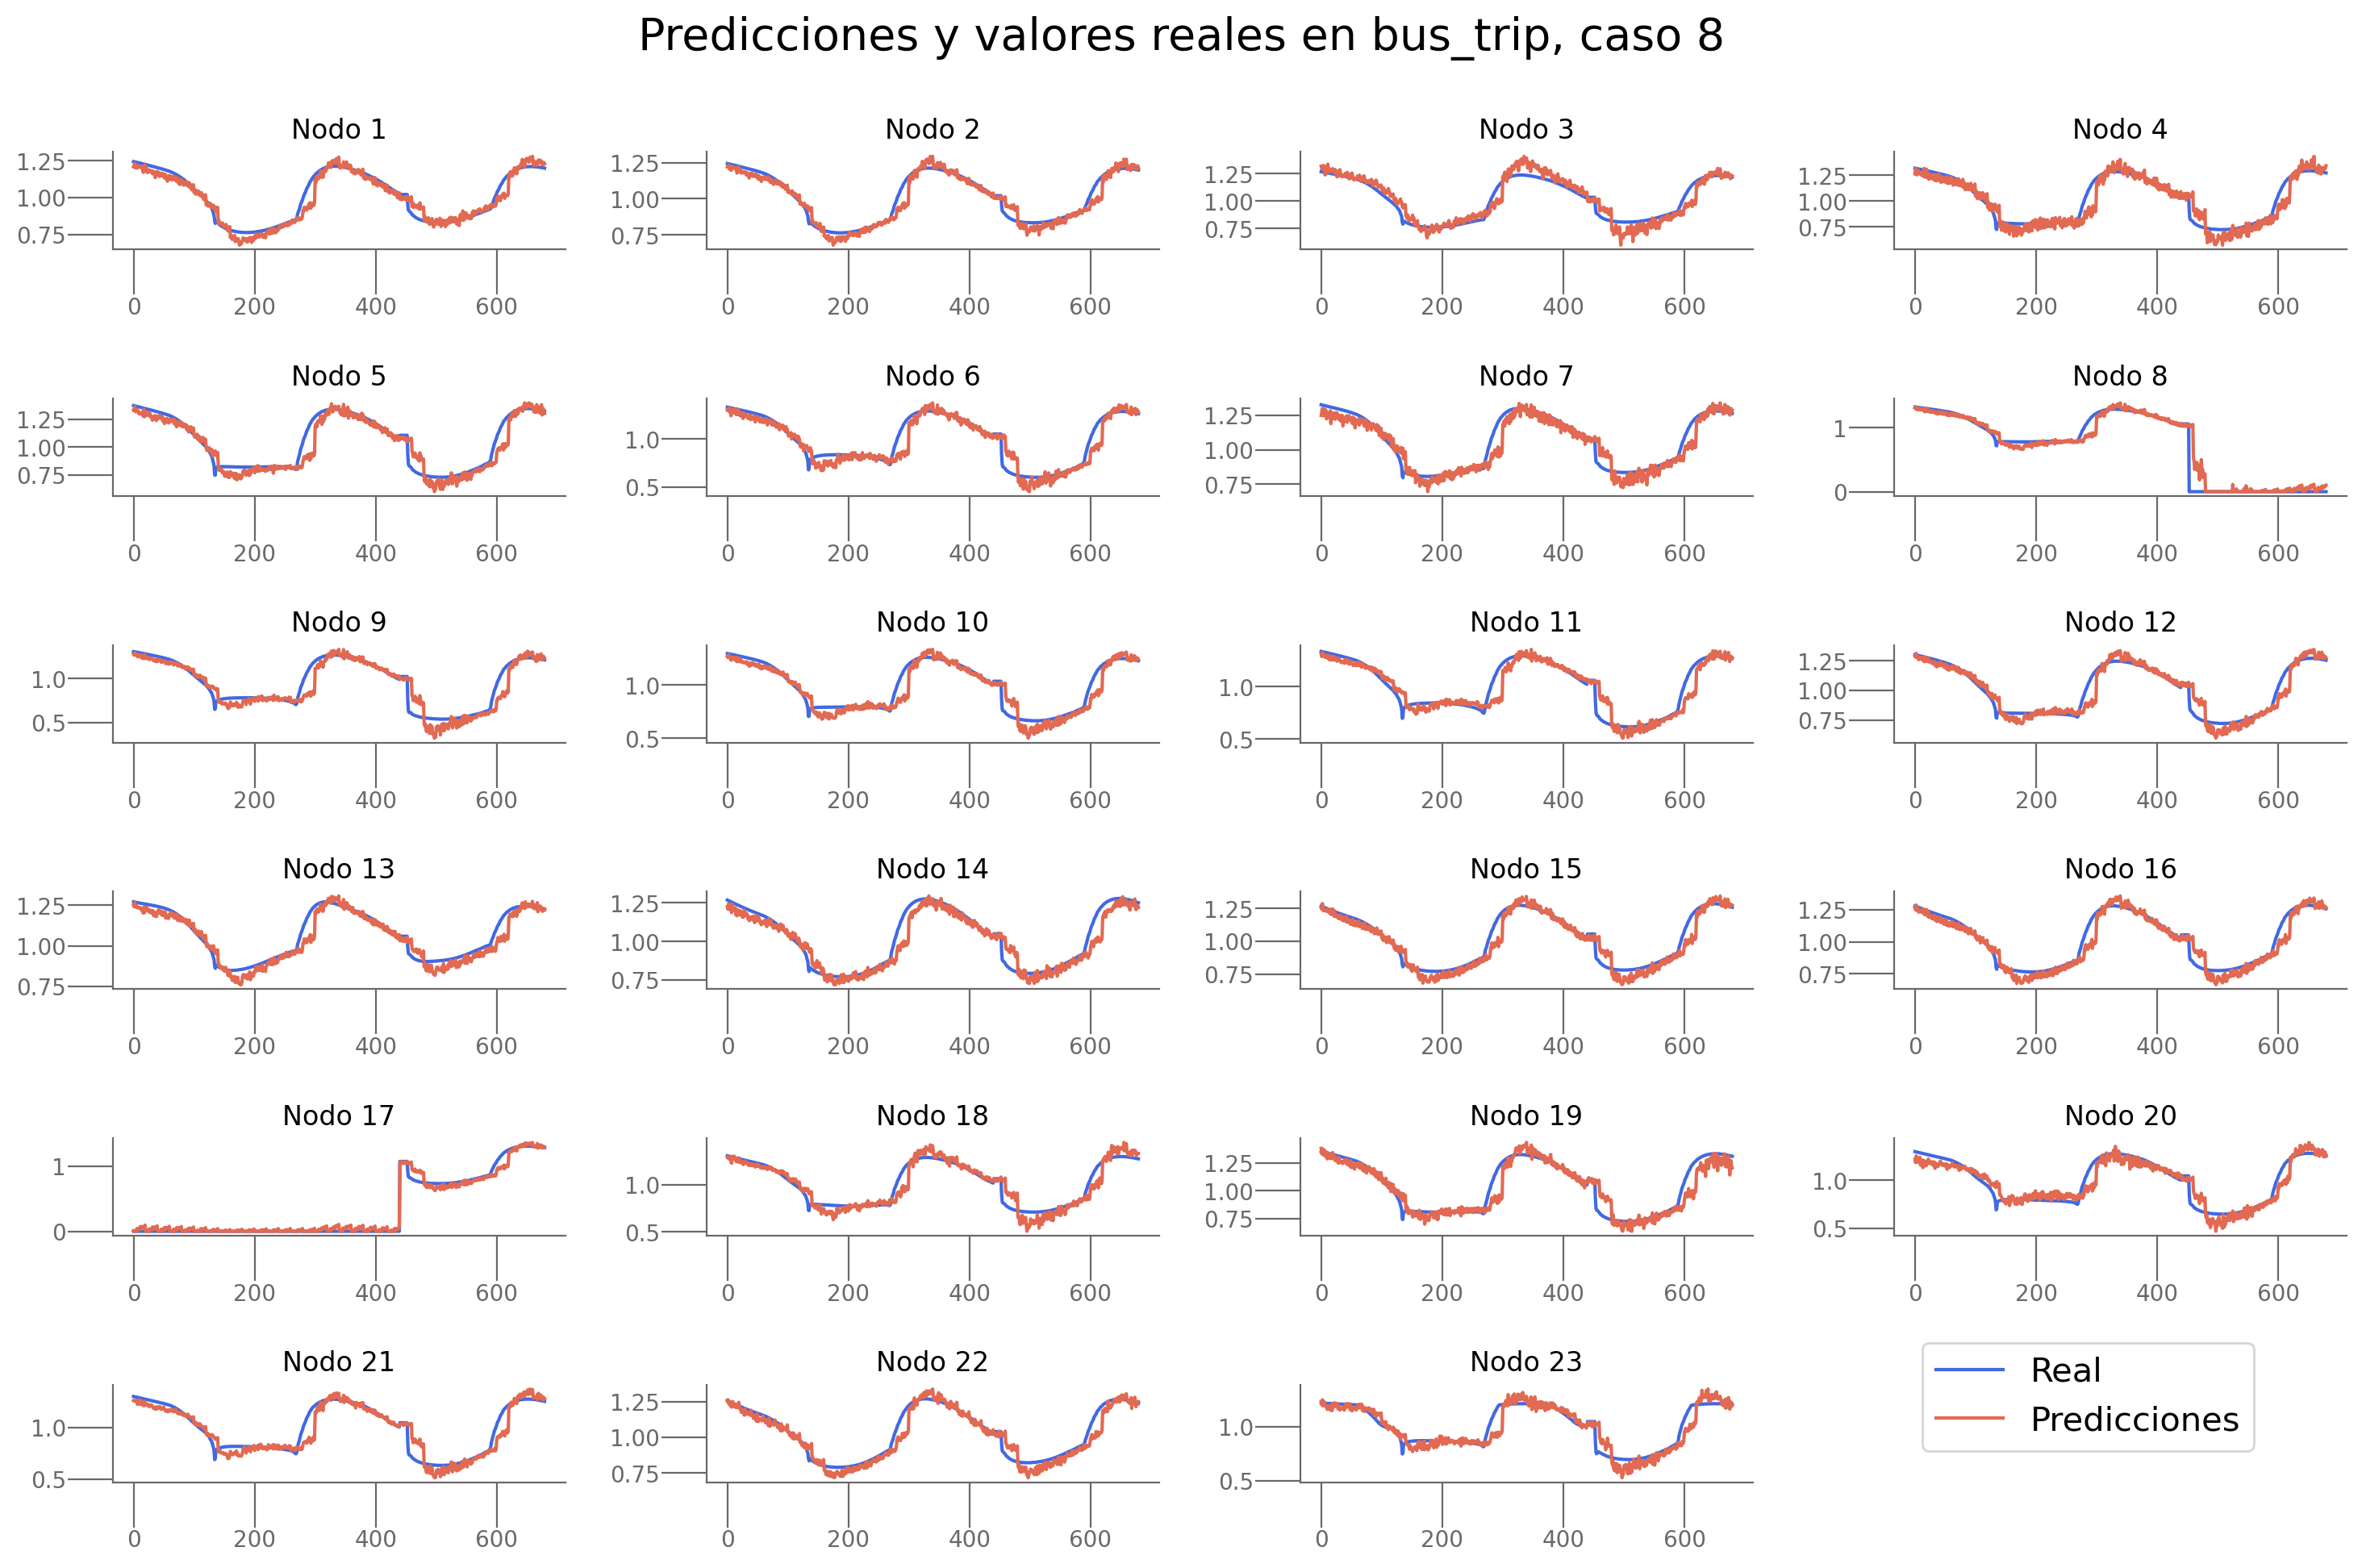

In [23]:
plot_predictions(predictions_bt_ajuste, real_bt_ajuste, n_target, 8, n_div_bt, problem_bt)

In [24]:
path_save_experiment_bt = results_save_path+f"/{problem_bt}"+ f"/ajustes/{name_model}_results.csv"
resultados_bt.to_csv(path_save_experiment_bt, index=False)

In [25]:
trainer_bt.save_model(path_save_experiment=path_save_experiment_bt, params=params_bt)


==================== GUARDANDO RESULTADOS ===================

         Modelo                                             Params  \
0          LSTM                                                NaN   
1  LSTM_NOBATCH                                                NaN   
2     MPNN_LSTM                                          (32, 0.8)   
3   DyGrEncoder              {'aggr': 'add', 'conv': 1, 'lstm': 1}   
4         AGCRN                              {'hidden': 5, 'K': 2}   
5         DCRNN                                     {'hidden': 60}   
6     EvolveGCN                                                NaN   
7        MSTGCN  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_...   

                      Fichero_resultados_experimento  Loss_tst    R2_tst  \
0                                                NaN  0.005474  0.923150   
1                                                NaN  0.005606  0.865487   
2    ./results/bus_trip/ajustes/MPNNLSTM_results.csv  0.006753  0.845855   
3

### Bus fault

In [26]:
problem_bf = "bus_fault"
dataset_bf, situations_bf = loader.get_dataset( target= 20, intro=100, step=20, one_ts_per_situation=False, start = 1, type=problem_bf)




Number of situations:  549
Number of timestamps:  800
Number of situations of the selected type:  86


In [27]:
n_div_bf = loader.div
n_nodes =dataset_bf.features[0].shape[0]
n_target = dataset_bf.targets[0].shape[1]
n_features = dataset_bf[0].x.shape[1]
hidden_size =32
dropout = 0.5

num_early_stop = 0
num_epochs = 30
lr = 0.01

#### Sencilla 

In [28]:

device =  torch.device("cpu")
model_bf = MSTGCNModel(name="MSTGCN", node_features=n_features, node_count=n_nodes, n_target=n_target, nb_block=2, k=2, nb_chev_filter = 2, nb_time_filter =2, time_strides = 2)


trainer_bf = TrainerMSTGCN(model_bf, dataset_bf,device, f"./results/{problem_bf}", dataloader_params2)


losses,eval_losses, r2scores  = trainer_bf.train(num_epochs=num_epochs, steps=50, num_early_stop=num_early_stop)





==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.2157 | Eval Loss: 0.1900 | Eval R2: -34.7477 | LR: 0.0010 | 
Epoch 2/30 | Train Loss: 0.1825 | Eval Loss: 0.1889 | Eval R2: -35.0900 | LR: 0.0010 | 
Epoch 3/30 | Train Loss: 0.1822 | Eval Loss: 0.1890 | Eval R2: -34.9072 | LR: 0.0010 | 
Epoch 4/30 | Train Loss: 0.1823 | Eval Loss: 0.1890 | Eval R2: -34.8570 | LR: 0.0010 | 
Epoch 5/30 | Train Loss: 0.1823 | Eval Loss: 0.1889 | Eval R2: -34.8757 | LR: 0.0010 | 
Epoch 6/30 | Train Loss: 0.1822 | Eval Loss: 0.1889 | Eval R2: -34.9345 | LR: 0.0010 | 
Epoch 7/30 | Train Loss: 0.1822 | Eval Loss: 0.1888 | Eval R2: -35.0194 | LR: 0.0010 | 
Epoch 8/30 | Train Loss: 0.1821 | Eval Loss: 0.1887 | Eval R2: -35.1069 | LR: 0.0010 | 
Epoch 9/30 | Train Loss: 0.1821 | Eval Loss: 0.1885 | Eval R2: -35.2109 | LR: 0.0010 | 
Epoch 10/30 | Train Loss: 0.1820 | E

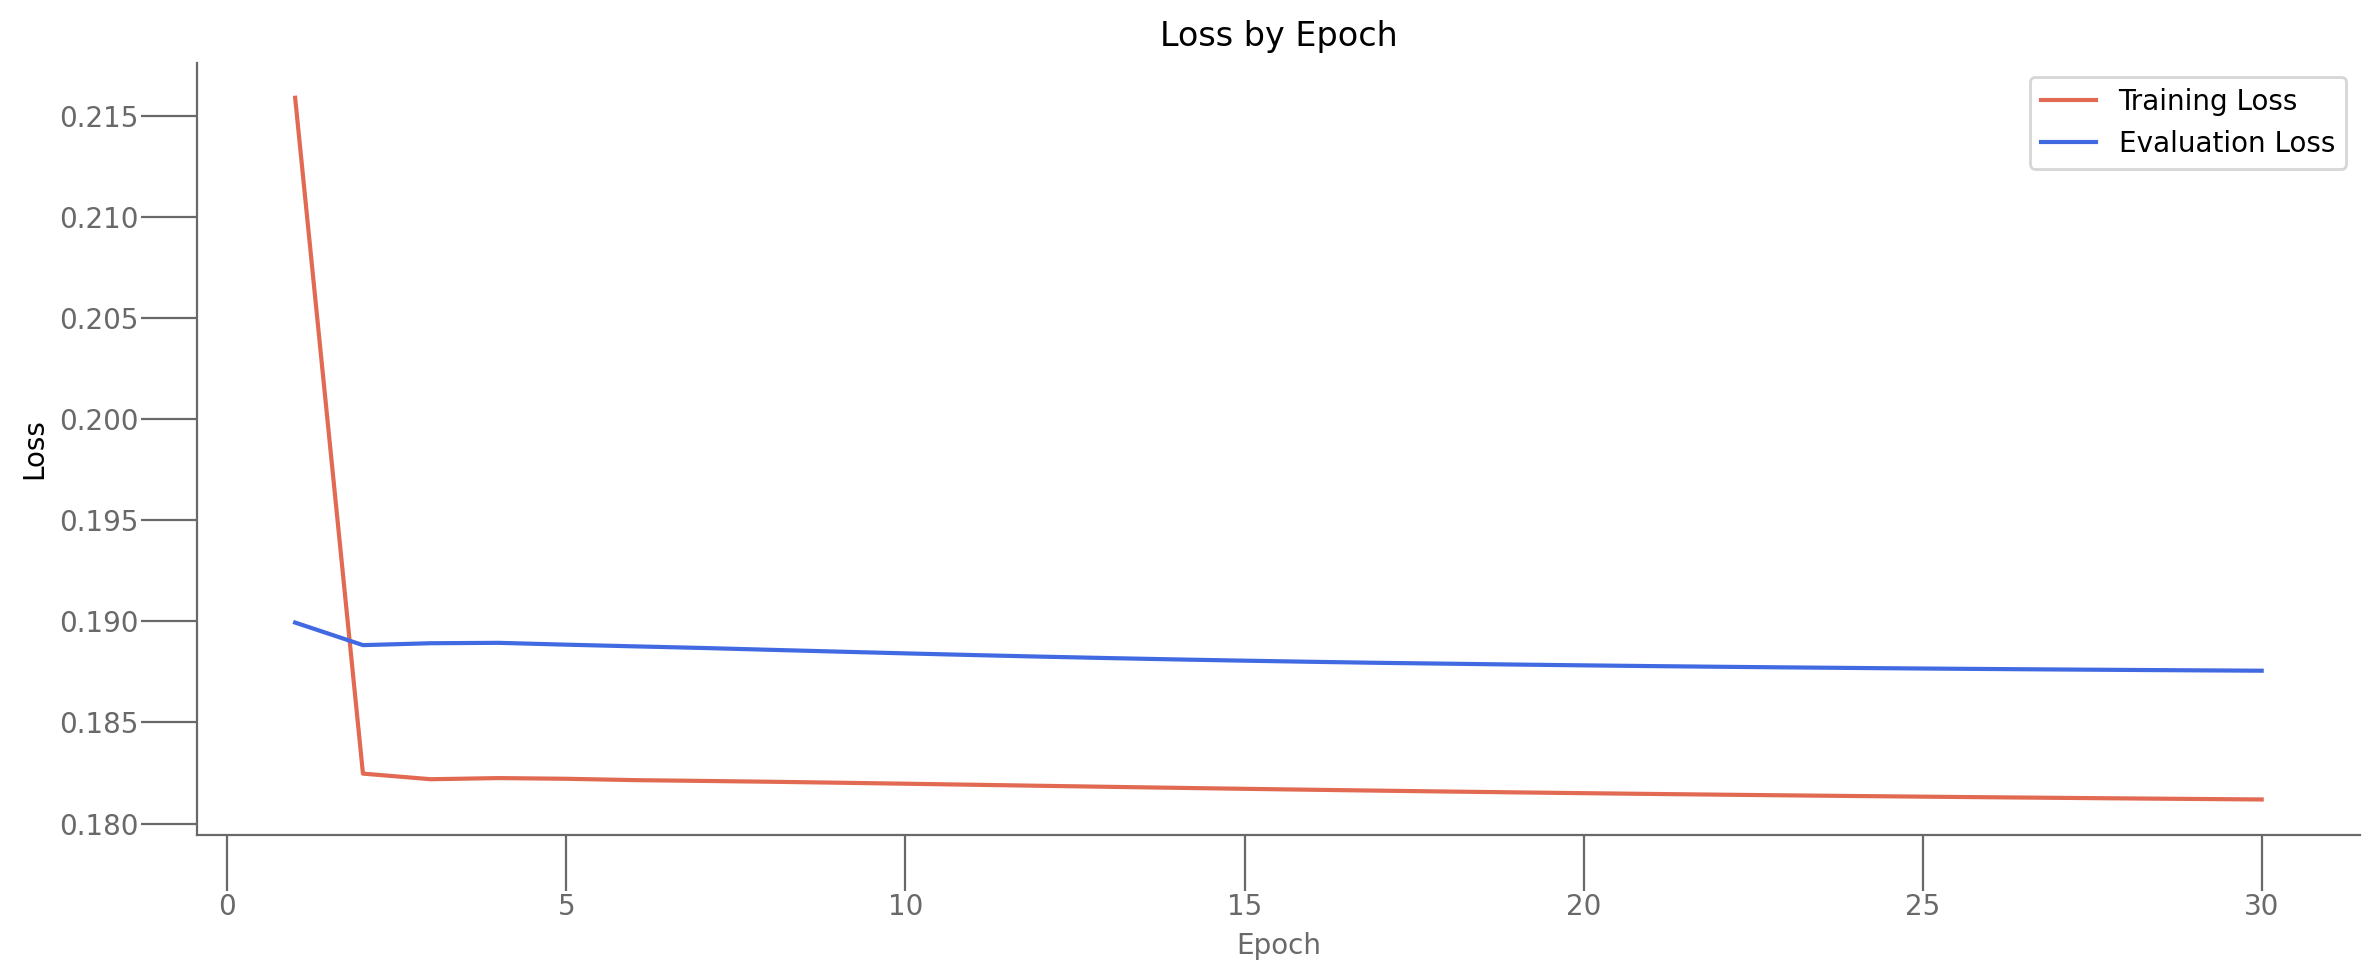


==================== TEST INFO ===================

preds:  (1, 23, 20)
test loss: 0.150332, test r2score -27.624034


In [23]:
plot_training_and_eval_losses(np.array(losses), np.array(eval_losses), num_epochs, format_plot)
losses_tst, r2score_tst, loss_nodes, predictions_bf, real_bf = trainer_bf.test()

#### Ajuste de parámetros 

In [29]:

num_epochs = 100
num_early_stop = 10
trainer_bf,params_bf,resultados_final_bf, resultados_bf = entrenar_y_evaluar_modelos_mstgcn(param_grid, dataset_bf, dataloader_params2, num_early_stop=num_early_stop, num_epochs=num_epochs, problem=problem_bf)

  0%|          | 0/54 [00:00<?, ?it/s]

Entrenando modelo con nb_block=1, nb_chev_filter=2, nb_time_filter=2, time_strides=2, hidden=50

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== TRAIN INFO ===================

Epoch 1/100 | Train Loss: 0.5841 | Eval Loss: 0.3680 | Eval R2: -69.8562 | LR: 0.0010 | 
Epoch 2/100 | Train Loss: 0.3034 | Eval Loss: 0.2542 | Eval R2: -52.1949 | LR: 0.0010 | 
Epoch 3/100 | Train Loss: 0.2419 | Eval Loss: 0.2274 | Eval R2: -49.9254 | LR: 0.0010 | 
Epoch 4/100 | Train Loss: 0.2180 | Eval Loss: 0.2115 | Eval R2: -45.0385 | LR: 0.0010 | 
Epoch 5/100 | Train Loss: 0.2031 | Eval Loss: 0.1991 | Eval R2: -40.7461 | LR: 0.0010 | 
Epoch 6/100 | Train Loss: 0.1922 | Eval Loss: 0.1911 | Eval R2: -39.2047 | LR: 0.0010 | 
Epoch 7/100 | Train Loss: 0.1840 | Eval Loss: 0.1845 | Eval R2: -36.4209 | LR: 0.0010 | 
Epoch 8/100 | Train Loss: 0.1767 | Eval Loss: 0.1781 | Eval R2: -33.9309 | LR: 0.0010 | 
Epoch 9/100 | Train 

  2%|▏         | 1/54 [06:12<5:29:06, 372.57s/it]

preds:  (1, 23, 20)
test loss: 0.064200, test R2 score: -7.635544
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 50, 'time_strides': 2, 'loss_final': 0.08413126319646835, 'r2_eval_final': -10.977245330810547, 'loss_eval_final': 0.09651867300271988, 'r2_test': -7.635543541640371, 'loss_test': 0.06419992446899414, 'loss_nodes': [0.07145623117685318, 0.05728942155838013, 0.05205522105097771, 0.08427750319242477, 0.08307438343763351, 0.10093610733747482, 0.07892487943172455, 0.05360836163163185, 0.0824626013636589, 0.051467958837747574, 0.06183823570609093, 0.04607810452580452, 0.051768556237220764, 0.08887319266796112, 0.051552265882492065, 0.04916832596063614, 0.05745438486337662, 0.08252213895320892, 0.06643210351467133, 0.06212495639920235, 0.057956255972385406, 0.0429067425429821, 0.042370304465293884]}
Entrenando modelo con nb_block=1, nb_chev_filter=2, nb_time_filter=2, time_strides=2, hidden=80

==================== DATASET INFO =======

  4%|▎         | 2/54 [12:38<5:29:31, 380.22s/it]

preds:  (1, 23, 20)
test loss: 0.064668, test R2 score: -7.501410
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 80, 'time_strides': 2, 'loss_final': 0.08597265928983688, 'r2_eval_final': -11.051156044006348, 'loss_eval_final': 0.09767608344554901, 'r2_test': -7.501409768311363, 'loss_test': 0.06466824561357498, 'loss_nodes': [0.06866442412137985, 0.05526582524180412, 0.05098627507686615, 0.08575879782438278, 0.07872789353132248, 0.10023535043001175, 0.08277352899312973, 0.0538424514234066, 0.08090262860059738, 0.050994180142879486, 0.0648103579878807, 0.04630500450730324, 0.04978200048208237, 0.10184751451015472, 0.05174684152007103, 0.04961340129375458, 0.05712467059493065, 0.07848980277776718, 0.06968188285827637, 0.06179679185152054, 0.06014631688594818, 0.04545537382364273, 0.042418308556079865]}
Entrenando modelo con nb_block=1, nb_chev_filter=2, nb_time_filter=2, time_strides=2, hidden=100

==================== DATASET INFO =========

  6%|▌         | 3/54 [19:01<5:24:21, 381.61s/it]

preds:  (1, 23, 20)
test loss: 0.064320, test R2 score: -7.580030
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 100, 'time_strides': 2, 'loss_final': 0.08486907929182053, 'r2_eval_final': -11.083836555480957, 'loss_eval_final': 0.09747231751680374, 'r2_test': -7.580029931214483, 'loss_test': 0.06432018429040909, 'loss_nodes': [0.07085181027650833, 0.056627385318279266, 0.050968680530786514, 0.08455482870340347, 0.08318450301885605, 0.10225850343704224, 0.07831420749425888, 0.053873710334300995, 0.08289740979671478, 0.05145819112658501, 0.06377365440130234, 0.04550040140748024, 0.050584577023983, 0.08935321867465973, 0.051294002681970596, 0.048849355429410934, 0.05737357586622238, 0.08323207497596741, 0.06779385358095169, 0.06242961809039116, 0.05899592861533165, 0.04307625815272331, 0.04211832582950592]}
Entrenando modelo con nb_block=1, nb_chev_filter=2, nb_time_filter=2, time_strides=5, hidden=50

==================== DATASET INFO ======

  7%|▋         | 4/54 [24:22<4:58:14, 357.89s/it]

preds:  (1, 23, 20)
test loss: 0.244383, test R2 score: -51.548486
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 50, 'time_strides': 5, 'loss_final': 0.2642301321029663, 'r2_eval_final': -62.92231369018555, 'loss_eval_final': 0.26056599617004395, 'r2_test': -51.54848625409408, 'loss_test': 0.24438273906707764, 'loss_nodes': [0.23375844955444336, 0.22761303186416626, 0.21628446877002716, 0.23236864805221558, 0.2551645040512085, 0.23926705121994019, 0.2323639690876007, 0.23148252069950104, 0.25406914949417114, 0.21841943264007568, 0.23703554272651672, 0.21798238158226013, 0.2684473693370819, 0.2765599489212036, 0.27303189039230347, 0.2674742639064789, 0.25432059168815613, 0.2568081021308899, 0.26042452454566956, 0.24068114161491394, 0.23218189179897308, 0.30501270294189453, 0.19005125761032104]}
Entrenando modelo con nb_block=1, nb_chev_filter=2, nb_time_filter=2, time_strides=5, hidden=80

==================== DATASET INFO =================

  9%|▉         | 5/54 [30:14<4:50:19, 355.50s/it]

preds:  (1, 23, 20)
test loss: 0.244383, test R2 score: -51.548487
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 80, 'time_strides': 5, 'loss_final': 0.2642301321029663, 'r2_eval_final': -62.92231369018555, 'loss_eval_final': 0.26056599617004395, 'r2_test': -51.54848659535712, 'loss_test': 0.24438273906707764, 'loss_nodes': [0.23375844955444336, 0.22761306166648865, 0.21628446877002716, 0.2323686182498932, 0.2551645040512085, 0.239267036318779, 0.2323639690876007, 0.23148252069950104, 0.25406914949417114, 0.21841944754123688, 0.23703554272651672, 0.21798238158226013, 0.2684473693370819, 0.2765599489212036, 0.2730318605899811, 0.26747429370880127, 0.25432059168815613, 0.2568081319332123, 0.26042452454566956, 0.24068112671375275, 0.23218189179897308, 0.3050127327442169, 0.19005127251148224]}
Entrenando modelo con nb_block=1, nb_chev_filter=2, nb_time_filter=2, time_strides=5, hidden=100

==================== DATASET INFO ===================


 11%|█         | 6/54 [35:53<4:40:01, 350.03s/it]

preds:  (1, 23, 20)
test loss: 0.244383, test R2 score: -51.548486
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 100, 'time_strides': 5, 'loss_final': 0.2642301321029663, 'r2_eval_final': -62.92231369018555, 'loss_eval_final': 0.26056599617004395, 'r2_test': -51.54848611643228, 'loss_test': 0.24438273906707764, 'loss_nodes': [0.23375847935676575, 0.22761304676532745, 0.21628446877002716, 0.23236864805221558, 0.2551645040512085, 0.23926708102226257, 0.2323639690876007, 0.23148250579833984, 0.25406914949417114, 0.21841944754123688, 0.23703554272651672, 0.21798233687877655, 0.2684473693370819, 0.2765599489212036, 0.27303189039230347, 0.26747429370880127, 0.25432059168815613, 0.2568081319332123, 0.26042458415031433, 0.24068112671375275, 0.23218189179897308, 0.30501270294189453, 0.19005122780799866]}
Entrenando modelo con nb_block=1, nb_chev_filter=2, nb_time_filter=2, time_strides=10, hidden=50

==================== DATASET INFO ==============

 13%|█▎        | 7/54 [41:33<4:31:30, 346.61s/it]

preds:  (1, 23, 20)
test loss: 0.128557, test R2 score: -22.862793
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 50, 'time_strides': 10, 'loss_final': 0.16490083932876587, 'r2_eval_final': -31.32716941833496, 'loss_eval_final': 0.16918903589248657, 'r2_test': -22.862793344115225, 'loss_test': 0.12855744361877441, 'loss_nodes': [0.10859892517328262, 0.08684925734996796, 0.09226188063621521, 0.1299818456172943, 0.14896856248378754, 0.14974473416805267, 0.10102194547653198, 0.13277031481266022, 0.18194998800754547, 0.12078998237848282, 0.1422073245048523, 0.09570387005805969, 0.09774399548768997, 0.12880486249923706, 0.1382950395345688, 0.13052338361740112, 0.1464730054140091, 0.1542690396308899, 0.15847325325012207, 0.14824622869491577, 0.14286181330680847, 0.1336437165737152, 0.08663852512836456]}
Entrenando modelo con nb_block=1, nb_chev_filter=2, nb_time_filter=2, time_strides=10, hidden=80

==================== DATASET INFO =============

 15%|█▍        | 8/54 [50:54<5:18:05, 414.91s/it]

preds:  (1, 23, 20)
test loss: 0.128558, test R2 score: -22.863033
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 80, 'time_strides': 10, 'loss_final': 0.16490088403224945, 'r2_eval_final': -31.327455520629883, 'loss_eval_final': 0.16918893158435822, 'r2_test': -22.86303344736169, 'loss_test': 0.12855777144432068, 'loss_nodes': [0.10859937965869904, 0.08684996515512466, 0.09226225316524506, 0.12998193502426147, 0.14896878600120544, 0.14974446594715118, 0.10102248936891556, 0.132770374417305, 0.18194960057735443, 0.12079007923603058, 0.14220717549324036, 0.09570429474115372, 0.09774528443813324, 0.12880584597587585, 0.13829568028450012, 0.13052402436733246, 0.146473228931427, 0.15426906943321228, 0.15847338736057281, 0.14824603497982025, 0.14286167919635773, 0.13364504277706146, 0.08663858473300934]}
Entrenando modelo con nb_block=1, nb_chev_filter=2, nb_time_filter=2, time_strides=10, hidden=100

==================== DATASET INFO ==========

 17%|█▋        | 9/54 [57:12<5:02:27, 403.27s/it]

preds:  (1, 23, 20)
test loss: 0.128557, test R2 score: -22.862739
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 100, 'time_strides': 10, 'loss_final': 0.16490083932876587, 'r2_eval_final': -31.327106475830078, 'loss_eval_final': 0.16918908059597015, 'r2_test': -22.862739063757942, 'loss_test': 0.12855738401412964, 'loss_nodes': [0.10859880596399307, 0.08684904128313065, 0.09226176887750626, 0.1299818456172943, 0.14896850287914276, 0.14974473416805267, 0.10102179646492004, 0.13277031481266022, 0.18195009231567383, 0.12078998237848282, 0.14220742881298065, 0.09570379555225372, 0.09774371981620789, 0.1288047730922699, 0.13829492032527924, 0.1305231899023056, 0.14647294580936432, 0.1542689949274063, 0.1584731638431549, 0.148246169090271, 0.14286191761493683, 0.13364344835281372, 0.08663851767778397]}
Entrenando modelo con nb_block=1, nb_chev_filter=4, nb_time_filter=4, time_strides=2, hidden=50

==================== DATASET INFO =============

 19%|█▊        | 10/54 [1:02:36<4:37:55, 379.00s/it]

preds:  (1, 23, 20)
test loss: 0.135491, test R2 score: -28.418604
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 50, 'time_strides': 2, 'loss_final': 0.13170665502548218, 'r2_eval_final': -33.174072265625, 'loss_eval_final': 0.13628676533699036, 'r2_test': -28.418604228772033, 'loss_test': 0.13549137115478516, 'loss_nodes': [0.1331627368927002, 0.13992320001125336, 0.13031095266342163, 0.12854498624801636, 0.13613829016685486, 0.12692417204380035, 0.14038404822349548, 0.12470751255750656, 0.11725373566150665, 0.12054797261953354, 0.12585878372192383, 0.13057300448417664, 0.16502854228019714, 0.15960097312927246, 0.14912283420562744, 0.15062926709651947, 0.13478051126003265, 0.13318008184432983, 0.1333180069923401, 0.1241941750049591, 0.12052582949399948, 0.1748717576265335, 0.1167200580239296]}
Entrenando modelo con nb_block=1, nb_chev_filter=4, nb_time_filter=4, time_strides=2, hidden=80

==================== DATASET INFO ================

 20%|██        | 11/54 [1:08:12<4:22:05, 365.71s/it]

preds:  (1, 23, 20)
test loss: 0.135491, test R2 score: -28.418566
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 80, 'time_strides': 2, 'loss_final': 0.13170689344406128, 'r2_eval_final': -33.17409133911133, 'loss_eval_final': 0.13628700375556946, 'r2_test': -28.41856564504132, 'loss_test': 0.1354910135269165, 'loss_nodes': [0.13316276669502258, 0.1399233043193817, 0.1303103268146515, 0.12854526937007904, 0.13613875210285187, 0.1269243061542511, 0.14038431644439697, 0.12470655888319016, 0.11725283414125443, 0.12054769694805145, 0.12585888803005219, 0.1305720955133438, 0.16502730548381805, 0.15960033237934113, 0.14912240207195282, 0.15062889456748962, 0.13477960228919983, 0.13318030536174774, 0.13331805169582367, 0.12419407069683075, 0.12052585929632187, 0.1748705804347992, 0.11671909689903259]}
Entrenando modelo con nb_block=1, nb_chev_filter=4, nb_time_filter=4, time_strides=2, hidden=100

==================== DATASET INFO ===============

 22%|██▏       | 12/54 [1:14:11<4:14:42, 363.86s/it]

preds:  (1, 23, 20)
test loss: 0.135491, test R2 score: -28.418592
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 100, 'time_strides': 2, 'loss_final': 0.13170693814754486, 'r2_eval_final': -33.17410659790039, 'loss_eval_final': 0.13628706336021423, 'r2_test': -28.4185917541849, 'loss_test': 0.1354912370443344, 'loss_nodes': [0.13316281139850616, 0.13992328941822052, 0.13031059503555298, 0.12854531407356262, 0.1361386477947235, 0.1269245743751526, 0.14038445055484772, 0.12470693141222, 0.11725325137376785, 0.12054790556430817, 0.12585897743701935, 0.13057249784469604, 0.1650276482105255, 0.15960073471069336, 0.1491226702928543, 0.15062914788722992, 0.13477998971939087, 0.13318033516407013, 0.1333182007074356, 0.12419421225786209, 0.12052605301141739, 0.17487101256847382, 0.11671935766935349]}
Entrenando modelo con nb_block=1, nb_chev_filter=4, nb_time_filter=4, time_strides=5, hidden=50

==================== DATASET INFO ===================

 24%|██▍       | 13/54 [1:19:18<3:56:42, 346.41s/it]

preds:  (1, 23, 20)
test loss: 0.198609, test R2 score: -44.516883
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 50, 'time_strides': 5, 'loss_final': 0.1939537525177002, 'r2_eval_final': -53.02073287963867, 'loss_eval_final': 0.19953057169914246, 'r2_test': -44.51688283899712, 'loss_test': 0.19860854744911194, 'loss_nodes': [0.1961689442396164, 0.2067440003156662, 0.1915372759103775, 0.18586944043636322, 0.19950060546398163, 0.18144424259662628, 0.20597824454307556, 0.1826106458902359, 0.17182205617427826, 0.1767842173576355, 0.18410655856132507, 0.1920439451932907, 0.24317142367362976, 0.23286078870296478, 0.2206244319677353, 0.22181525826454163, 0.19767199456691742, 0.19495269656181335, 0.19731351733207703, 0.1817290484905243, 0.17660130560398102, 0.25828853249549866, 0.16835704445838928]}
Entrenando modelo con nb_block=1, nb_chev_filter=4, nb_time_filter=4, time_strides=5, hidden=80

==================== DATASET INFO ===================

 26%|██▌       | 14/54 [1:24:42<3:46:32, 339.80s/it]

preds:  (1, 23, 20)
test loss: 0.198609, test R2 score: -44.516882
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 80, 'time_strides': 5, 'loss_final': 0.1939537525177002, 'r2_eval_final': -53.02073287963867, 'loss_eval_final': 0.19953057169914246, 'r2_test': -44.51688186082717, 'loss_test': 0.19860854744911194, 'loss_nodes': [0.1961689293384552, 0.2067439705133438, 0.1915372908115387, 0.18586942553520203, 0.19950056076049805, 0.1814442127943039, 0.20597819983959198, 0.18261070549488068, 0.17182211577892303, 0.1767842024564743, 0.18410655856132507, 0.1920439600944519, 0.24317146837711334, 0.2328607589006424, 0.22062444686889648, 0.22181525826454163, 0.1976720243692398, 0.19495271146297455, 0.19731353223323822, 0.18172909319400787, 0.17660130560398102, 0.25828856229782104, 0.16835707426071167]}
Entrenando modelo con nb_block=1, nb_chev_filter=4, nb_time_filter=4, time_strides=5, hidden=100

==================== DATASET INFO ==================

 28%|██▊       | 15/54 [1:30:03<3:37:14, 334.22s/it]

preds:  (1, 23, 20)
test loss: 0.198609, test R2 score: -44.516879
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 100, 'time_strides': 5, 'loss_final': 0.193953737616539, 'r2_eval_final': -53.02073287963867, 'loss_eval_final': 0.19953054189682007, 'r2_test': -44.5168790825835, 'loss_test': 0.19860854744911194, 'loss_nodes': [0.196168914437294, 0.20674392580986023, 0.1915372610092163, 0.18586938083171844, 0.19950060546398163, 0.1814442127943039, 0.205978125333786, 0.18261069059371948, 0.17182208597660065, 0.1767842024564743, 0.18410652875900269, 0.1920439451932907, 0.24317146837711334, 0.23286063969135284, 0.2206244319677353, 0.22181525826454163, 0.1976720541715622, 0.19495269656181335, 0.19731351733207703, 0.18172907829284668, 0.1766013205051422, 0.25828853249549866, 0.16835704445838928]}
Entrenando modelo con nb_block=1, nb_chev_filter=4, nb_time_filter=4, time_strides=10, hidden=50

==================== DATASET INFO ===================

T

 30%|██▉       | 16/54 [1:35:05<3:25:26, 324.37s/it]

preds:  (1, 23, 20)
test loss: 0.022080, test R2 score: -1.611957
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 50, 'time_strides': 10, 'loss_final': 0.02841844968497753, 'r2_eval_final': -3.976560592651367, 'loss_eval_final': 0.041253712028265, 'r2_test': -1.6119574075720573, 'loss_test': 0.02208005264401436, 'loss_nodes': [0.014050782658159733, 0.011854716576635838, 0.015155764296650887, 0.025609368458390236, 0.0283951573073864, 0.0318642295897007, 0.018910707905888557, 0.024717051535844803, 0.03153810650110245, 0.023989103734493256, 0.028675459325313568, 0.016420232132077217, 0.009033510461449623, 0.019603807479143143, 0.018353968858718872, 0.0200157780200243, 0.02520936168730259, 0.02700900100171566, 0.0278897974640131, 0.027567584067583084, 0.02788078971207142, 0.013793744146823883, 0.02030320279300213]}
Entrenando modelo con nb_block=1, nb_chev_filter=4, nb_time_filter=4, time_strides=10, hidden=80

==================== DATASET INFO 

 31%|███▏      | 17/54 [1:40:24<3:19:06, 322.87s/it]

preds:  (1, 23, 20)
test loss: 0.022080, test R2 score: -1.611926
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 80, 'time_strides': 10, 'loss_final': 0.028418486937880516, 'r2_eval_final': -3.9765100479125977, 'loss_eval_final': 0.041253771632909775, 'r2_test': -1.611925753123064, 'loss_test': 0.022079987451434135, 'loss_nodes': [0.014050798490643501, 0.011854681186378002, 0.015155741944909096, 0.025609223172068596, 0.028394998982548714, 0.031864069402217865, 0.018910590559244156, 0.024717042222619057, 0.031538236886262894, 0.023989103734493256, 0.028675461187958717, 0.016420209780335426, 0.0090335039421916, 0.019603244960308075, 0.018353885039687157, 0.020015660673379898, 0.025209344923496246, 0.027008917182683945, 0.02788972668349743, 0.027567561715841293, 0.02788078971207142, 0.013793697580695152, 0.02030319534242153]}
Entrenando modelo con nb_block=1, nb_chev_filter=4, nb_time_filter=4, time_strides=10, hidden=100

====================

 33%|███▎      | 18/54 [1:45:33<3:11:05, 318.48s/it]

preds:  (1, 23, 20)
test loss: 0.022080, test R2 score: -1.611973
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 100, 'time_strides': 10, 'loss_final': 0.02841864340007305, 'r2_eval_final': -3.9765491485595703, 'loss_eval_final': 0.041253846138715744, 'r2_test': -1.611973081724701, 'loss_test': 0.022080188617110252, 'loss_nodes': [0.014051100239157677, 0.011854942888021469, 0.015155998058617115, 0.02560940384864807, 0.028395479544997215, 0.03186432644724846, 0.018910685554146767, 0.024717137217521667, 0.03153844177722931, 0.023989329114556313, 0.028675345703959465, 0.01642034947872162, 0.00903359055519104, 0.019604777917265892, 0.018354061990976334, 0.02001582831144333, 0.025209415704011917, 0.02700931392610073, 0.027889607474207878, 0.027567816898226738, 0.027880625799298286, 0.01379353180527687, 0.02030327543616295]}
Entrenando modelo con nb_block=1, nb_chev_filter=8, nb_time_filter=8, time_strides=2, hidden=50

==================== DATAS

 35%|███▌      | 19/54 [1:52:03<3:18:22, 340.08s/it]

preds:  (1, 23, 20)
test loss: 0.047552, test R2 score: -7.998375
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 50, 'time_strides': 2, 'loss_final': 0.04697585478425026, 'r2_eval_final': -10.441097259521484, 'loss_eval_final': 0.0566202737390995, 'r2_test': -7.998375350239649, 'loss_test': 0.04755183681845665, 'loss_nodes': [0.04219680652022362, 0.04298561066389084, 0.042523518204689026, 0.047600194811820984, 0.051070354878902435, 0.050538044422864914, 0.04666438698768616, 0.04727528244256973, 0.049925122410058975, 0.04495391249656677, 0.05066579207777977, 0.04297349229454994, 0.047284919768571854, 0.049701813608407974, 0.04716305434703827, 0.04897834360599518, 0.04936479032039642, 0.049375612288713455, 0.05153104290366173, 0.04777015000581741, 0.04888535290956497, 0.050999101251363754, 0.04326542839407921]}
Entrenando modelo con nb_block=1, nb_chev_filter=8, nb_time_filter=8, time_strides=2, hidden=80

==================== DATASET INFO ==

 37%|███▋      | 20/54 [1:58:33<3:21:10, 355.00s/it]

preds:  (1, 23, 20)
test loss: 0.047552, test R2 score: -7.998383
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 80, 'time_strides': 2, 'loss_final': 0.04697587713599205, 'r2_eval_final': -10.441100120544434, 'loss_eval_final': 0.05662035942077637, 'r2_test': -7.998383497441352, 'loss_test': 0.04755189269781113, 'loss_nodes': [0.04219697415828705, 0.04298575595021248, 0.04252364858984947, 0.04760025814175606, 0.051070455461740494, 0.050538089126348495, 0.046664465218782425, 0.04727524146437645, 0.04992517828941345, 0.04495406523346901, 0.05066589638590813, 0.04297346994280815, 0.04728485271334648, 0.04970185086131096, 0.047163188457489014, 0.04897846281528473, 0.04936469718813896, 0.049375828355550766, 0.05153105407953262, 0.04777027666568756, 0.048885367810726166, 0.0509989932179451, 0.04326540604233742]}
Entrenando modelo con nb_block=1, nb_chev_filter=8, nb_time_filter=8, time_strides=2, hidden=100

==================== DATASET INFO ====

 39%|███▉      | 21/54 [2:04:37<3:16:41, 357.63s/it]

preds:  (1, 23, 20)
test loss: 0.047552, test R2 score: -7.998381
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 100, 'time_strides': 2, 'loss_final': 0.0469760037958622, 'r2_eval_final': -10.441118240356445, 'loss_eval_final': 0.056620508432388306, 'r2_test': -7.998381219346491, 'loss_test': 0.04755189269781113, 'loss_nodes': [0.04219682887196541, 0.042985592037439346, 0.04252350330352783, 0.04760031774640083, 0.05107032135128975, 0.05053817853331566, 0.04666447639465332, 0.04727525636553764, 0.04992513358592987, 0.044953882694244385, 0.05066594481468201, 0.04297352582216263, 0.04728497192263603, 0.04970215633511543, 0.047163140028715134, 0.048978403210639954, 0.049364808946847916, 0.04937560483813286, 0.05153113603591919, 0.04777015373110771, 0.04888545349240303, 0.05099918320775032, 0.043265484273433685]}
Entrenando modelo con nb_block=1, nb_chev_filter=8, nb_time_filter=8, time_strides=5, hidden=50

==================== DATASET INFO ===

 41%|████      | 22/54 [2:10:10<3:06:51, 350.37s/it]

preds:  (1, 23, 20)
test loss: 0.020664, test R2 score: -1.261408
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 50, 'time_strides': 5, 'loss_final': 0.02408364973962307, 'r2_eval_final': -2.9594016075134277, 'loss_eval_final': 0.035716407001018524, 'r2_test': -1.2614084039275038, 'loss_test': 0.020664332434535027, 'loss_nodes': [0.014866609126329422, 0.012424526736140251, 0.0150536447763443, 0.02277239039540291, 0.026672493666410446, 0.0284444447606802, 0.016701985150575638, 0.023081466555595398, 0.02971349097788334, 0.02266758307814598, 0.02809089422225952, 0.01492773275822401, 0.008364733308553696, 0.015645107254385948, 0.015975188463926315, 0.0178158488124609, 0.02317291684448719, 0.02582509256899357, 0.027130678296089172, 0.026183977723121643, 0.02794703282415867, 0.011304986663162708, 0.020496860146522522]}
Entrenando modelo con nb_block=1, nb_chev_filter=8, nb_time_filter=8, time_strides=5, hidden=80

==================== DATASET INF

 43%|████▎     | 23/54 [2:15:43<2:58:17, 345.09s/it]

preds:  (1, 23, 20)
test loss: 0.020664, test R2 score: -1.261413
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 80, 'time_strides': 5, 'loss_final': 0.024083701893687248, 'r2_eval_final': -2.959411382675171, 'loss_eval_final': 0.035716455429792404, 'r2_test': -1.2614131187950737, 'loss_test': 0.020664367824792862, 'loss_nodes': [0.014866759069263935, 0.012424679473042488, 0.015053621493279934, 0.022772381082177162, 0.026672711595892906, 0.028444504365324974, 0.016701892018318176, 0.023081457242369652, 0.029713358730077744, 0.022667545825242996, 0.028091033920645714, 0.01492773275822401, 0.008364704437553883, 0.015645133331418037, 0.015975208953022957, 0.017815861850976944, 0.0231728944927454, 0.02582530304789543, 0.02713080123066902, 0.026183968409895897, 0.027947138994932175, 0.01130498293787241, 0.02049686387181282]}
Entrenando modelo con nb_block=1, nb_chev_filter=8, nb_time_filter=8, time_strides=5, hidden=100

==================== DAT

 44%|████▍     | 24/54 [2:21:04<2:49:01, 338.06s/it]

preds:  (1, 23, 20)
test loss: 0.020664, test R2 score: -1.261410
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 100, 'time_strides': 5, 'loss_final': 0.02408365160226822, 'r2_eval_final': -2.959411144256592, 'loss_eval_final': 0.03571639582514763, 'r2_test': -1.2614098127480295, 'loss_test': 0.02066432312130928, 'loss_nodes': [0.014866659417748451, 0.012424576096236706, 0.015053659677505493, 0.02277239039540291, 0.02667250484228134, 0.028444519266486168, 0.016702013090252876, 0.02308143861591816, 0.02971336618065834, 0.022667590528726578, 0.02809079922735691, 0.014927728101611137, 0.008364729583263397, 0.015645049512386322, 0.015975235030055046, 0.017815889790654182, 0.023172909393906593, 0.025825107470154762, 0.027130577713251114, 0.026183992624282837, 0.027946902438998222, 0.011305000633001328, 0.020496847108006477]}
Entrenando modelo con nb_block=1, nb_chev_filter=8, nb_time_filter=8, time_strides=10, hidden=50

==================== DAT

 46%|████▋     | 25/54 [2:26:43<2:43:31, 338.33s/it]

preds:  (1, 23, 20)
test loss: 0.022076, test R2 score: -1.504805
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 50, 'time_strides': 10, 'loss_final': 0.026852451264858246, 'r2_eval_final': -3.6290500164031982, 'loss_eval_final': 0.039125118404626846, 'r2_test': -1.5048053184340786, 'loss_test': 0.02207634411752224, 'loss_nodes': [0.014702364802360535, 0.012456579133868217, 0.01507098414003849, 0.026309117674827576, 0.028393404558300972, 0.03280850127339363, 0.01909562572836876, 0.02412889152765274, 0.03072044625878334, 0.023784974589943886, 0.02967703528702259, 0.015388739295303822, 0.008489648811519146, 0.01801939122378826, 0.01827314868569374, 0.020176751539111137, 0.024271676316857338, 0.027378177270293236, 0.02879149280488491, 0.027532855048775673, 0.02929333969950676, 0.012604090385138988, 0.02038870006799698]}
Entrenando modelo con nb_block=1, nb_chev_filter=8, nb_time_filter=8, time_strides=10, hidden=80

==================== DATASE

 48%|████▊     | 26/54 [2:32:04<2:35:24, 333.02s/it]

preds:  (1, 23, 20)
test loss: 0.022076, test R2 score: -1.504802
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 80, 'time_strides': 10, 'loss_final': 0.026852278038859367, 'r2_eval_final': -3.6290104389190674, 'loss_eval_final': 0.039124857634305954, 'r2_test': -1.504802341223108, 'loss_test': 0.022076215595006943, 'loss_nodes': [0.014702803455293179, 0.01245703175663948, 0.015071152709424496, 0.026309074833989143, 0.028393184766173363, 0.03280821815133095, 0.019095664843916893, 0.024128533899784088, 0.03072008676826954, 0.023785099387168884, 0.02967667207121849, 0.015388472937047482, 0.008489194326102734, 0.018019337207078934, 0.018273204565048218, 0.02017691545188427, 0.024271264672279358, 0.027378110215067863, 0.028791023418307304, 0.027533015236258507, 0.029292885214090347, 0.012603680603206158, 0.020388338714838028]}
Entrenando modelo con nb_block=1, nb_chev_filter=8, nb_time_filter=8, time_strides=10, hidden=100

====================

 50%|█████     | 27/54 [2:37:19<2:27:25, 327.63s/it]

preds:  (1, 23, 20)
test loss: 0.022076, test R2 score: -1.504837
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 100, 'time_strides': 10, 'loss_final': 0.02685232274234295, 'r2_eval_final': -3.6290674209594727, 'loss_eval_final': 0.03912507742643356, 'r2_test': -1.504837317514229, 'loss_test': 0.022076258435845375, 'loss_nodes': [0.014702928252518177, 0.012457353062927723, 0.015071346424520016, 0.02630908600986004, 0.02839273028075695, 0.03280871361494064, 0.019095925614237785, 0.024128392338752747, 0.03072001039981842, 0.023785222321748734, 0.02967655099928379, 0.015388528816401958, 0.008489072322845459, 0.01801968924701214, 0.018273547291755676, 0.020177224650979042, 0.024271197617053986, 0.027377823367714882, 0.02879098430275917, 0.02753319777548313, 0.029292704537510872, 0.012603637762367725, 0.020388087257742882]}
Entrenando modelo con nb_block=2, nb_chev_filter=2, nb_time_filter=2, time_strides=2, hidden=50

==================== DATAS

 52%|█████▏    | 28/54 [2:47:57<3:02:18, 420.72s/it]

preds:  (1, 23, 20)
test loss: 0.151522, test R2 score: -28.636960
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 50, 'time_strides': 2, 'loss_final': 0.18487347662448883, 'r2_eval_final': -37.794132232666016, 'loss_eval_final': 0.18706999719142914, 'r2_test': -28.636960144599783, 'loss_test': 0.15152239799499512, 'loss_nodes': [0.13315075635910034, 0.11438613384962082, 0.1166224554181099, 0.15026545524597168, 0.16998600959777832, 0.16766847670078278, 0.1268140822649002, 0.15235774219036102, 0.1965181529521942, 0.14021800458431244, 0.1611451655626297, 0.1219598799943924, 0.13106060028076172, 0.15799933671951294, 0.16471609473228455, 0.15733326971530914, 0.16780714690685272, 0.17458726465702057, 0.1786438375711441, 0.1666785478591919, 0.16072922945022583, 0.16705414652824402, 0.10731343924999237]}
Entrenando modelo con nb_block=2, nb_chev_filter=2, nb_time_filter=2, time_strides=2, hidden=80

==================== DATASET INFO ===============

 54%|█████▎    | 29/54 [2:58:15<3:20:01, 480.06s/it]

preds:  (1, 23, 20)
test loss: 0.151343, test R2 score: -28.625515
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 80, 'time_strides': 2, 'loss_final': 0.18465881049633026, 'r2_eval_final': -37.781978607177734, 'loss_eval_final': 0.18687930703163147, 'r2_test': -28.62551530957173, 'loss_test': 0.151342511177063, 'loss_nodes': [0.13325589895248413, 0.11455748975276947, 0.11693788319826126, 0.1502830684185028, 0.17001938819885254, 0.1676347702741623, 0.12694847583770752, 0.1523607075214386, 0.19641438126564026, 0.14021670818328857, 0.16113288700580597, 0.1186501756310463, 0.12907664477825165, 0.15788815915584564, 0.16486386954784393, 0.15748998522758484, 0.16784678399562836, 0.17460398375988007, 0.1786600798368454, 0.166656032204628, 0.16069459915161133, 0.16734986007213593, 0.10733530670404434]}
Entrenando modelo con nb_block=2, nb_chev_filter=2, nb_time_filter=2, time_strides=2, hidden=100

==================== DATASET INFO =================

 56%|█████▌    | 30/54 [3:09:15<3:33:34, 533.93s/it]

preds:  (1, 23, 20)
test loss: 0.151538, test R2 score: -28.638657
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 100, 'time_strides': 2, 'loss_final': 0.18487487733364105, 'r2_eval_final': -37.793949127197266, 'loss_eval_final': 0.1870676428079605, 'r2_test': -28.638657372739008, 'loss_test': 0.15153835713863373, 'loss_nodes': [0.13314951956272125, 0.11438420414924622, 0.11662133783102036, 0.1502651423215866, 0.16998572647571564, 0.16766893863677979, 0.12681256234645844, 0.15235763788223267, 0.19651944935321808, 0.14021793007850647, 0.16114529967308044, 0.12198367714881897, 0.1310572624206543, 0.1583578735589981, 0.16471438109874725, 0.15733157098293304, 0.1678066849708557, 0.17458704113960266, 0.17864356935024261, 0.1666787564754486, 0.16072973608970642, 0.16705070436000824, 0.10731321573257446]}
Entrenando modelo con nb_block=2, nb_chev_filter=2, nb_time_filter=2, time_strides=5, hidden=50

==================== DATASET INFO =============

 57%|█████▋    | 31/54 [3:19:23<3:33:11, 556.15s/it]

preds:  (1, 23, 20)
test loss: 0.197930, test R2 score: -40.418194
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 50, 'time_strides': 5, 'loss_final': 0.224711611866951, 'r2_eval_final': -50.46491241455078, 'loss_eval_final': 0.2264760136604309, 'r2_test': -40.41819393580811, 'loss_test': 0.19793038070201874, 'loss_nodes': [0.1836366504430771, 0.17131631076335907, 0.1665867269039154, 0.19122254848480225, 0.21251511573791504, 0.20324058830738068, 0.1797667145729065, 0.19177712500095367, 0.22492298483848572, 0.1791638433933258, 0.19891202449798584, 0.16896826028823853, 0.20029941201210022, 0.21748469769954681, 0.2191077470779419, 0.21262091398239136, 0.21100066602230072, 0.21558088064193726, 0.2195020318031311, 0.20346230268478394, 0.19620464742183685, 0.2366076111793518, 0.14849907159805298]}
Entrenando modelo con nb_block=2, nb_chev_filter=2, nb_time_filter=2, time_strides=5, hidden=80

==================== DATASET INFO ===================


 59%|█████▉    | 32/54 [3:29:18<3:28:11, 567.82s/it]

preds:  (1, 23, 20)
test loss: 0.197930, test R2 score: -40.418202
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 80, 'time_strides': 5, 'loss_final': 0.224711611866951, 'r2_eval_final': -50.46492004394531, 'loss_eval_final': 0.2264760285615921, 'r2_test': -40.41820224490809, 'loss_test': 0.19793041050434113, 'loss_nodes': [0.18363666534423828, 0.17131631076335907, 0.1665867269039154, 0.19122254848480225, 0.21251510083675385, 0.20324058830738068, 0.17976675927639008, 0.19177711009979248, 0.2249229997396469, 0.1791638284921646, 0.19891200959682465, 0.1689682900905609, 0.2002994567155838, 0.2174847275018692, 0.2191077619791031, 0.21262091398239136, 0.21100066602230072, 0.21558088064193726, 0.2195020318031311, 0.20346234738826752, 0.19620461761951447, 0.2366076558828354, 0.14849908649921417]}
Entrenando modelo con nb_block=2, nb_chev_filter=2, nb_time_filter=2, time_strides=5, hidden=100

==================== DATASET INFO ===================



 61%|██████    | 33/54 [3:38:56<3:19:46, 570.77s/it]

preds:  (1, 23, 20)
test loss: 0.197930, test R2 score: -40.418212
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 100, 'time_strides': 5, 'loss_final': 0.224711611866951, 'r2_eval_final': -50.46493911743164, 'loss_eval_final': 0.2264760136604309, 'r2_test': -40.4182119472052, 'loss_test': 0.19793041050434113, 'loss_nodes': [0.1836366504430771, 0.17131629586219788, 0.1665867418050766, 0.19122256338596344, 0.21251507103443146, 0.20324058830738068, 0.17976677417755127, 0.19177711009979248, 0.22492294013500214, 0.17916378378868103, 0.19891202449798584, 0.1689683496952057, 0.20029953122138977, 0.2174847424030304, 0.2191077619791031, 0.21262092888355255, 0.21100066602230072, 0.21558092534542084, 0.2195020467042923, 0.20346230268478394, 0.19620457291603088, 0.23660771548748016, 0.14849908649921417]}
Entrenando modelo con nb_block=2, nb_chev_filter=2, nb_time_filter=2, time_strides=10, hidden=50

==================== DATASET INFO ==================

 63%|██████▎   | 34/54 [3:47:54<3:06:57, 560.88s/it]

preds:  (1, 23, 20)
test loss: 0.198240, test R2 score: -40.065956
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 50, 'time_strides': 10, 'loss_final': 0.2247127890586853, 'r2_eval_final': -49.98293685913086, 'loss_eval_final': 0.225539892911911, 'r2_test': -40.06595640583548, 'loss_test': 0.19824033975601196, 'loss_nodes': [0.18398109078407288, 0.1717207431793213, 0.16692882776260376, 0.19150790572166443, 0.2128090262413025, 0.20346780121326447, 0.1800873726606369, 0.19205571711063385, 0.22512340545654297, 0.17940831184387207, 0.19913475215435028, 0.1692807972431183, 0.20068496465682983, 0.21786081790924072, 0.2194662094116211, 0.21302245557308197, 0.21134383976459503, 0.2159050852060318, 0.21976542472839355, 0.20374739170074463, 0.1964719444513321, 0.23701423406600952, 0.14873963594436646]}
Entrenando modelo con nb_block=2, nb_chev_filter=2, nb_time_filter=2, time_strides=10, hidden=80

==================== DATASET INFO ==================

 65%|██████▍   | 35/54 [3:57:16<2:57:47, 561.42s/it]

preds:  (1, 23, 20)
test loss: 0.198239, test R2 score: -40.065867
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 80, 'time_strides': 10, 'loss_final': 0.22471190989017487, 'r2_eval_final': -49.98289489746094, 'loss_eval_final': 0.22553890943527222, 'r2_test': -40.06586685620607, 'loss_test': 0.19823938608169556, 'loss_nodes': [0.18397998809814453, 0.1717190444469452, 0.16692835092544556, 0.19150768220424652, 0.2128087282180786, 0.20346824824810028, 0.18008574843406677, 0.19205577671527863, 0.2251216471195221, 0.17940834164619446, 0.1991327553987503, 0.1692824810743332, 0.20068170130252838, 0.21785792708396912, 0.21946436166763306, 0.21302038431167603, 0.21134354174137115, 0.21590490639209747, 0.21976527571678162, 0.20374760031700134, 0.1964723765850067, 0.23701012134552002, 0.1487393081188202]}
Entrenando modelo con nb_block=2, nb_chev_filter=2, nb_time_filter=2, time_strides=10, hidden=100

==================== DATASET INFO ==============

 67%|██████▋   | 36/54 [4:06:40<2:48:37, 562.09s/it]

preds:  (1, 23, 20)
test loss: 0.198239, test R2 score: -40.065990
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 100, 'time_strides': 10, 'loss_final': 0.2247113287448883, 'r2_eval_final': -49.983062744140625, 'loss_eval_final': 0.22553788125514984, 'r2_test': -40.065990063244065, 'loss_test': 0.1982387751340866, 'loss_nodes': [0.18397919833660126, 0.1717177927494049, 0.1669280230998993, 0.19150760769844055, 0.21280847489833832, 0.20346848666667938, 0.18008452653884888, 0.192055806517601, 0.22512055933475494, 0.17940835654735565, 0.19913160800933838, 0.16928334534168243, 0.20067952573299408, 0.2178562432527542, 0.21946308016777039, 0.213018998503685, 0.21134324371814728, 0.21590469777584076, 0.21976502239704132, 0.2037479430437088, 0.19647255539894104, 0.23700779676437378, 0.14873915910720825]}
Entrenando modelo con nb_block=2, nb_chev_filter=4, nb_time_filter=4, time_strides=2, hidden=50

==================== DATASET INFO ================

 69%|██████▊   | 37/54 [4:17:41<2:47:38, 591.69s/it]

preds:  (1, 23, 20)
test loss: 0.020116, test R2 score: -1.300191
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 50, 'time_strides': 2, 'loss_final': 0.024154245853424072, 'r2_eval_final': -3.2370102405548096, 'loss_eval_final': 0.03595244884490967, 'r2_test': -1.3001908578633885, 'loss_test': 0.020116107538342476, 'loss_nodes': [0.01256165374070406, 0.010939368978142738, 0.014564442448318005, 0.023341715335845947, 0.024822626262903214, 0.028210539370775223, 0.016639916226267815, 0.023128729313611984, 0.02938159927725792, 0.02255438268184662, 0.02645692229270935, 0.015629686415195465, 0.008620871230959892, 0.01586403325200081, 0.01687815971672535, 0.018446186557412148, 0.023352939635515213, 0.02364492230117321, 0.025076108053326607, 0.02529345266520977, 0.025518450886011124, 0.011718295514583588, 0.020025499165058136]}
Entrenando modelo con nb_block=2, nb_chev_filter=4, nb_time_filter=4, time_strides=2, hidden=80

==================== DATAS

 70%|███████   | 38/54 [4:28:53<2:44:16, 616.00s/it]

preds:  (1, 23, 20)
test loss: 0.020116, test R2 score: -1.300222
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 80, 'time_strides': 2, 'loss_final': 0.024154555052518845, 'r2_eval_final': -3.237058639526367, 'loss_eval_final': 0.03595243766903877, 'r2_test': -1.3002215894420281, 'loss_test': 0.020115891471505165, 'loss_nodes': [0.012560607865452766, 0.010938361287117004, 0.014565910212695599, 0.023340212181210518, 0.024821113795042038, 0.02821001596748829, 0.016639458015561104, 0.023128103464841843, 0.02938271313905716, 0.022555895149707794, 0.026456141844391823, 0.015629112720489502, 0.008620194159448147, 0.015863468870520592, 0.016879184171557426, 0.018447307869791985, 0.02335202880203724, 0.0236450657248497, 0.025075795128941536, 0.025294622406363487, 0.025517603382468224, 0.011717927642166615, 0.020024681463837624]}
Entrenando modelo con nb_block=2, nb_chev_filter=4, nb_time_filter=4, time_strides=2, hidden=100

==================== DA

 72%|███████▏  | 39/54 [4:39:31<2:35:37, 622.50s/it]

preds:  (1, 23, 20)
test loss: 0.020116, test R2 score: -1.300131
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 100, 'time_strides': 2, 'loss_final': 0.024154312908649445, 'r2_eval_final': -3.236971855163574, 'loss_eval_final': 0.035952139645814896, 'r2_test': -1.3001311923674366, 'loss_test': 0.02011561580002308, 'loss_nodes': [0.012561006471514702, 0.010938591323792934, 0.014563444070518017, 0.023339886218309402, 0.024821195751428604, 0.02821006067097187, 0.01663978397846222, 0.023128537461161613, 0.02938486821949482, 0.022553125396370888, 0.02645527757704258, 0.015629993751645088, 0.008621406741440296, 0.015862638130784035, 0.016877027228474617, 0.01844511739909649, 0.023352906107902527, 0.02364467829465866, 0.025075718760490417, 0.025292573496699333, 0.025516696274280548, 0.011719233356416225, 0.020025407895445824]}
Entrenando modelo con nb_block=2, nb_chev_filter=4, nb_time_filter=4, time_strides=5, hidden=50

==================== DAT

 74%|███████▍  | 40/54 [4:49:09<2:22:08, 609.21s/it]

preds:  (1, 23, 20)
test loss: 0.020969, test R2 score: -1.359466
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 50, 'time_strides': 5, 'loss_final': 0.024218225851655006, 'r2_eval_final': -3.1101982593536377, 'loss_eval_final': 0.03521312400698662, 'r2_test': -1.3594664486016863, 'loss_test': 0.020969124510884285, 'loss_nodes': [0.015062876977026463, 0.012155321426689625, 0.015565691515803337, 0.021294595673680305, 0.025829574093222618, 0.02780155837535858, 0.01752524822950363, 0.025349410250782967, 0.03185007721185684, 0.02426815778017044, 0.0291304774582386, 0.01856321282684803, 0.008120638318359852, 0.017489902675151825, 0.01616363413631916, 0.018053842708468437, 0.02395648881793022, 0.025600064545869827, 0.025846829637885094, 0.024532200768589973, 0.02595055103302002, 0.012418617494404316, 0.019760889932513237]}
Entrenando modelo con nb_block=2, nb_chev_filter=4, nb_time_filter=4, time_strides=5, hidden=80

==================== DATASET

 76%|███████▌  | 41/54 [4:58:50<2:10:08, 600.68s/it]

preds:  (1, 23, 20)
test loss: 0.020969, test R2 score: -1.359505
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 80, 'time_strides': 5, 'loss_final': 0.024217957630753517, 'r2_eval_final': -3.1101832389831543, 'loss_eval_final': 0.03521284833550453, 'r2_test': -1.3595047564076743, 'loss_test': 0.020969321951270103, 'loss_nodes': [0.015063556842505932, 0.012155111879110336, 0.015564976260066032, 0.021295292302966118, 0.02582952193915844, 0.02780124917626381, 0.01752539351582527, 0.025349199771881104, 0.03185145929455757, 0.024267693981528282, 0.029130378738045692, 0.018563205376267433, 0.008120677433907986, 0.01749069057404995, 0.01616346649825573, 0.018053539097309113, 0.02395712584257126, 0.025600867345929146, 0.02584705501794815, 0.024532051756978035, 0.025950908660888672, 0.012419539503753185, 0.019761476665735245]}
Entrenando modelo con nb_block=2, nb_chev_filter=4, nb_time_filter=4, time_strides=5, hidden=100

==================== DATA

 78%|███████▊  | 42/54 [5:08:41<1:59:33, 597.78s/it]

preds:  (1, 23, 20)
test loss: 0.020969, test R2 score: -1.359451
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 100, 'time_strides': 5, 'loss_final': 0.02421804703772068, 'r2_eval_final': -3.110152006149292, 'loss_eval_final': 0.03521275892853737, 'r2_test': -1.3594506022491846, 'loss_test': 0.02096901834011078, 'loss_nodes': [0.015062756836414337, 0.012154834344983101, 0.015565074980258942, 0.021294381469488144, 0.025829195976257324, 0.02780088223516941, 0.017524780705571175, 0.025349212810397148, 0.031850866973400116, 0.024267559871077538, 0.029130076989531517, 0.018562378361821175, 0.008120757527649403, 0.017490115016698837, 0.016163770109415054, 0.018053922802209854, 0.023956462740898132, 0.025601351633667946, 0.02584660053253174, 0.024532238021492958, 0.025950465351343155, 0.012418699450790882, 0.019761014729738235]}
Entrenando modelo con nb_block=2, nb_chev_filter=4, nb_time_filter=4, time_strides=10, hidden=50

==================== 

 80%|███████▉  | 43/54 [5:17:41<1:46:24, 580.43s/it]

preds:  (1, 23, 20)
test loss: 0.025770, test R2 score: -2.038977
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 50, 'time_strides': 10, 'loss_final': 0.033738940954208374, 'r2_eval_final': -4.624762058258057, 'loss_eval_final': 0.05229577422142029, 'r2_test': -2.0389765529363055, 'loss_test': 0.0257695522159338, 'loss_nodes': [0.01625051721930504, 0.013042328879237175, 0.01745443046092987, 0.02843492478132248, 0.029957374557852745, 0.03475227206945419, 0.02057173289358616, 0.029253799468278885, 0.0381598137319088, 0.030117301270365715, 0.03382871672511101, 0.023486649617552757, 0.01165951881557703, 0.022099968045949936, 0.02111140824854374, 0.022653231397271156, 0.02942184917628765, 0.03188937157392502, 0.03171861171722412, 0.03291071951389313, 0.033575329929590225, 0.014981908723711967, 0.025368085131049156]}
Entrenando modelo con nb_block=2, nb_chev_filter=4, nb_time_filter=4, time_strides=10, hidden=80

==================== DATASET INFO

 81%|████████▏ | 44/54 [5:26:48<1:35:03, 570.38s/it]

preds:  (1, 23, 20)
test loss: 0.025770, test R2 score: -2.039094
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 80, 'time_strides': 10, 'loss_final': 0.033737823367118835, 'r2_eval_final': -4.62467098236084, 'loss_eval_final': 0.05229445546865463, 'r2_test': -2.039093565348801, 'loss_test': 0.025769900530576706, 'loss_nodes': [0.016250189393758774, 0.013048752211034298, 0.017454300075769424, 0.028434917330741882, 0.02995915897190571, 0.034753330051898956, 0.02057456038892269, 0.029253939166665077, 0.038159988820552826, 0.030119499191641808, 0.03383086249232292, 0.023476101458072662, 0.011659050360321999, 0.022100765258073807, 0.021110648289322853, 0.022652478888630867, 0.029421085491776466, 0.03189513459801674, 0.0317218154668808, 0.03291004151105881, 0.03357338905334473, 0.014980399049818516, 0.025367284193634987]}
Entrenando modelo con nb_block=2, nb_chev_filter=4, nb_time_filter=4, time_strides=10, hidden=100

==================== DATAS

 83%|████████▎ | 45/54 [5:36:19<1:25:34, 570.47s/it]

preds:  (1, 23, 20)
test loss: 0.025770, test R2 score: -2.038940
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 100, 'time_strides': 10, 'loss_final': 0.03374023735523224, 'r2_eval_final': -4.624967098236084, 'loss_eval_final': 0.05229872465133667, 'r2_test': -2.0389403111411513, 'loss_test': 0.025769904255867004, 'loss_nodes': [0.01624883897602558, 0.013040274381637573, 0.017454754561185837, 0.028434598818421364, 0.029955673962831497, 0.03475420922040939, 0.02057066187262535, 0.029254700988531113, 0.038159046322107315, 0.03012082725763321, 0.033826738595962524, 0.02349657006561756, 0.011665022931993008, 0.022094422951340675, 0.021113289520144463, 0.022655315697193146, 0.029423879459500313, 0.03188798204064369, 0.031715910881757736, 0.0329107865691185, 0.03357629477977753, 0.014983312226831913, 0.02536463551223278]}
Entrenando modelo con nb_block=2, nb_chev_filter=8, nb_time_filter=8, time_strides=2, hidden=50

==================== DATASET

 85%|████████▌ | 46/54 [5:48:51<1:23:20, 625.02s/it]

preds:  (1, 23, 20)
test loss: 0.018443, test R2 score: -0.903302
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 50, 'time_strides': 2, 'loss_final': 0.017896858975291252, 'r2_eval_final': -2.1713383197784424, 'loss_eval_final': 0.027409115806221962, 'r2_test': -0.9033021452328543, 'loss_test': 0.018442552536725998, 'loss_nodes': [0.012711572460830212, 0.011941524222493172, 0.014174757525324821, 0.02061099372804165, 0.02274131402373314, 0.024861784651875496, 0.017018228769302368, 0.021550752222537994, 0.025301989167928696, 0.019351404160261154, 0.02256997860968113, 0.016424519941210747, 0.00868014432489872, 0.013144219294190407, 0.013684197328984737, 0.015509017743170261, 0.020686747506260872, 0.025417789816856384, 0.02368210256099701, 0.022492755204439163, 0.023988639935851097, 0.01031261496245861, 0.01732167787849903]}
Entrenando modelo con nb_block=2, nb_chev_filter=8, nb_time_filter=8, time_strides=2, hidden=80

==================== DAT

 87%|████████▋ | 47/54 [6:01:30<1:17:35, 665.12s/it]

preds:  (1, 23, 20)
test loss: 0.018443, test R2 score: -0.903344
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 80, 'time_strides': 2, 'loss_final': 0.01789671555161476, 'r2_eval_final': -2.1713807582855225, 'loss_eval_final': 0.027409305796027184, 'r2_test': -0.9033440379641238, 'loss_test': 0.018442708998918533, 'loss_nodes': [0.012711314484477043, 0.011941254138946533, 0.014174963347613811, 0.020610840991139412, 0.022741489112377167, 0.024862436577677727, 0.017018478363752365, 0.021550899371504784, 0.025301899760961533, 0.01935139112174511, 0.02257007732987404, 0.016425134614109993, 0.008680039085447788, 0.01314433105289936, 0.013684459030628204, 0.015509150922298431, 0.020687030628323555, 0.025418339297175407, 0.023682493716478348, 0.022492794319987297, 0.023988747969269753, 0.010312682949006557, 0.017322005704045296]}
Entrenando modelo con nb_block=2, nb_chev_filter=8, nb_time_filter=8, time_strides=2, hidden=100

====================

 89%|████████▉ | 48/54 [6:14:17<1:09:34, 695.67s/it]

preds:  (1, 23, 20)
test loss: 0.018443, test R2 score: -0.903341
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 100, 'time_strides': 2, 'loss_final': 0.01789683848619461, 'r2_eval_final': -2.1713855266571045, 'loss_eval_final': 0.027409326285123825, 'r2_test': -0.9033408587165751, 'loss_test': 0.018442710861563683, 'loss_nodes': [0.012711587361991405, 0.011941780336201191, 0.014175006188452244, 0.02061096392571926, 0.022741422057151794, 0.02486274391412735, 0.017018798738718033, 0.02155080810189247, 0.025301888585090637, 0.01935146376490593, 0.02257002517580986, 0.016424475237727165, 0.008679923601448536, 0.013144372962415218, 0.013684434816241264, 0.015509175136685371, 0.020686764270067215, 0.02541867457330227, 0.023682421073317528, 0.02249293215572834, 0.02398805320262909, 0.010312785394489765, 0.017321787774562836]}
Entrenando modelo con nb_block=2, nb_chev_filter=8, nb_time_filter=8, time_strides=5, hidden=50

==================== DATA

 91%|█████████ | 49/54 [6:24:49<56:23, 676.75s/it]  

preds:  (1, 23, 20)
test loss: 0.050861, test R2 score: -8.647005
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 50, 'time_strides': 5, 'loss_final': 0.053580451756715775, 'r2_eval_final': -11.120905876159668, 'loss_eval_final': 0.06394508481025696, 'r2_test': -8.647004886012022, 'loss_test': 0.05086078122258186, 'loss_nodes': [0.04542872682213783, 0.045903440564870834, 0.04355514794588089, 0.050221458077430725, 0.05491866543889046, 0.053683795034885406, 0.05003847926855087, 0.0516376718878746, 0.052515678107738495, 0.046811871230602264, 0.05663425475358963, 0.04492864012718201, 0.04868154227733612, 0.054316189140081406, 0.050868190824985504, 0.05224336311221123, 0.0514504536986351, 0.05692796781659126, 0.05793483182787895, 0.051006611436605453, 0.05146629363298416, 0.05399055778980255, 0.044634126126766205]}
Entrenando modelo con nb_block=2, nb_chev_filter=8, nb_time_filter=8, time_strides=5, hidden=80

==================== DATASET INFO ==

 93%|█████████▎| 50/54 [6:35:28<44:20, 665.23s/it]

preds:  (1, 23, 20)
test loss: 0.050861, test R2 score: -8.646998
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 80, 'time_strides': 5, 'loss_final': 0.05358045920729637, 'r2_eval_final': -11.12092113494873, 'loss_eval_final': 0.06394516676664352, 'r2_test': -8.646997639606878, 'loss_test': 0.050860848277807236, 'loss_nodes': [0.04542769491672516, 0.04590270295739174, 0.04355504363775253, 0.05022132769227028, 0.05491835996508598, 0.05368401110172272, 0.05003830045461655, 0.05163755267858505, 0.052515678107738495, 0.046812497079372406, 0.05663594603538513, 0.044928815215826035, 0.04868185892701149, 0.05431685224175453, 0.050868090242147446, 0.052243102341890335, 0.05145049840211868, 0.056927844882011414, 0.057934414595365524, 0.05100703239440918, 0.05146639794111252, 0.05399126932024956, 0.04463428258895874]}
Entrenando modelo con nb_block=2, nb_chev_filter=8, nb_time_filter=8, time_strides=5, hidden=100

==================== DATASET INFO ==

 94%|█████████▍| 51/54 [6:46:19<33:03, 661.12s/it]

preds:  (1, 23, 20)
test loss: 0.050861, test R2 score: -8.647051
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 100, 'time_strides': 5, 'loss_final': 0.053580392152071, 'r2_eval_final': -11.12095832824707, 'loss_eval_final': 0.06394527107477188, 'r2_test': -8.647050926040926, 'loss_test': 0.050861015915870667, 'loss_nodes': [0.045427680015563965, 0.045902423560619354, 0.04355526342988014, 0.05022120848298073, 0.05491846054792404, 0.05368420481681824, 0.05003822594881058, 0.05163763463497162, 0.05251571908593178, 0.046812620013952255, 0.05663590133190155, 0.04492904245853424, 0.04868205636739731, 0.054316818714141846, 0.05086859315633774, 0.05224362388253212, 0.051450688391923904, 0.05692828819155693, 0.057935286313295364, 0.05100693926215172, 0.05146639794111252, 0.05399133637547493, 0.04463503509759903]}
Entrenando modelo con nb_block=2, nb_chev_filter=8, nb_time_filter=8, time_strides=10, hidden=50

==================== DATASET INFO ====

 96%|█████████▋| 52/54 [6:56:18<21:25, 642.55s/it]

preds:  (1, 23, 20)
test loss: 0.022382, test R2 score: -1.539081
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 50, 'time_strides': 10, 'loss_final': 0.027231555432081223, 'r2_eval_final': -3.6300129890441895, 'loss_eval_final': 0.03912505507469177, 'r2_test': -1.5390805730529373, 'loss_test': 0.022381504997611046, 'loss_nodes': [0.01623368449509144, 0.01225531566888094, 0.016199475154280663, 0.02520487643778324, 0.027769731357693672, 0.030941013246774673, 0.019517797976732254, 0.025405708700418472, 0.03333485126495361, 0.024282023310661316, 0.028978025540709496, 0.016981976106762886, 0.008625372312963009, 0.018696537241339684, 0.01801128499209881, 0.020030172541737556, 0.025510994717478752, 0.027353515848517418, 0.02831064723432064, 0.029058953747153282, 0.027863966301083565, 0.012816826812922955, 0.021391907706856728]}
Entrenando modelo con nb_block=2, nb_chev_filter=8, nb_time_filter=8, time_strides=10, hidden=80

==================== D

 98%|█████████▊| 53/54 [7:06:31<10:33, 633.56s/it]

preds:  (1, 23, 20)
test loss: 0.022382, test R2 score: -1.539109
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 80, 'time_strides': 10, 'loss_final': 0.027231669053435326, 'r2_eval_final': -3.630030632019043, 'loss_eval_final': 0.0391252376139164, 'r2_test': -1.5391093761735612, 'loss_test': 0.02238166518509388, 'loss_nodes': [0.016233118250966072, 0.012255317531526089, 0.01619950868189335, 0.025205887854099274, 0.02776992693543434, 0.030941534787416458, 0.019518105313181877, 0.02540607377886772, 0.03333497419953346, 0.024281881749629974, 0.028978358954191208, 0.016982370987534523, 0.008625608868896961, 0.01869696006178856, 0.018011299893260002, 0.020029757171869278, 0.02551073394715786, 0.027353448793292046, 0.028310704976320267, 0.029059283435344696, 0.027864249423146248, 0.012816843576729298, 0.021392377093434334]}
Entrenando modelo con nb_block=2, nb_chev_filter=8, nb_time_filter=8, time_strides=10, hidden=100

==================== DAT

100%|██████████| 54/54 [7:16:02<00:00, 484.48s/it]

preds:  (1, 23, 20)
test loss: 0.022382, test R2 score: -1.539136
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 100, 'time_strides': 10, 'loss_final': 0.027231721207499504, 'r2_eval_final': -3.630056619644165, 'loss_eval_final': 0.03912517428398132, 'r2_test': -1.5391357242834482, 'loss_test': 0.022381749004125595, 'loss_nodes': [0.016232533380389214, 0.012255094945430756, 0.0162002295255661, 0.025205330923199654, 0.02776983007788658, 0.030940664932131767, 0.019517643377184868, 0.025406567379832268, 0.03333533555269241, 0.02428245358169079, 0.02897852472960949, 0.016982533037662506, 0.008625594899058342, 0.018697798252105713, 0.018011247739195824, 0.02003030851483345, 0.025511091575026512, 0.0273533184081316, 0.02831079065799713, 0.029059750959277153, 0.027864424511790276, 0.012816989794373512, 0.021392187103629112]}


In [30]:
_, _, _, predictions_bf_ajuste, real_bf_ajuste = trainer_bf.test()


==================== TEST INFO ===================

preds:  (1, 23, 20)
test loss: 0.018443, test R2 score: -0.903312


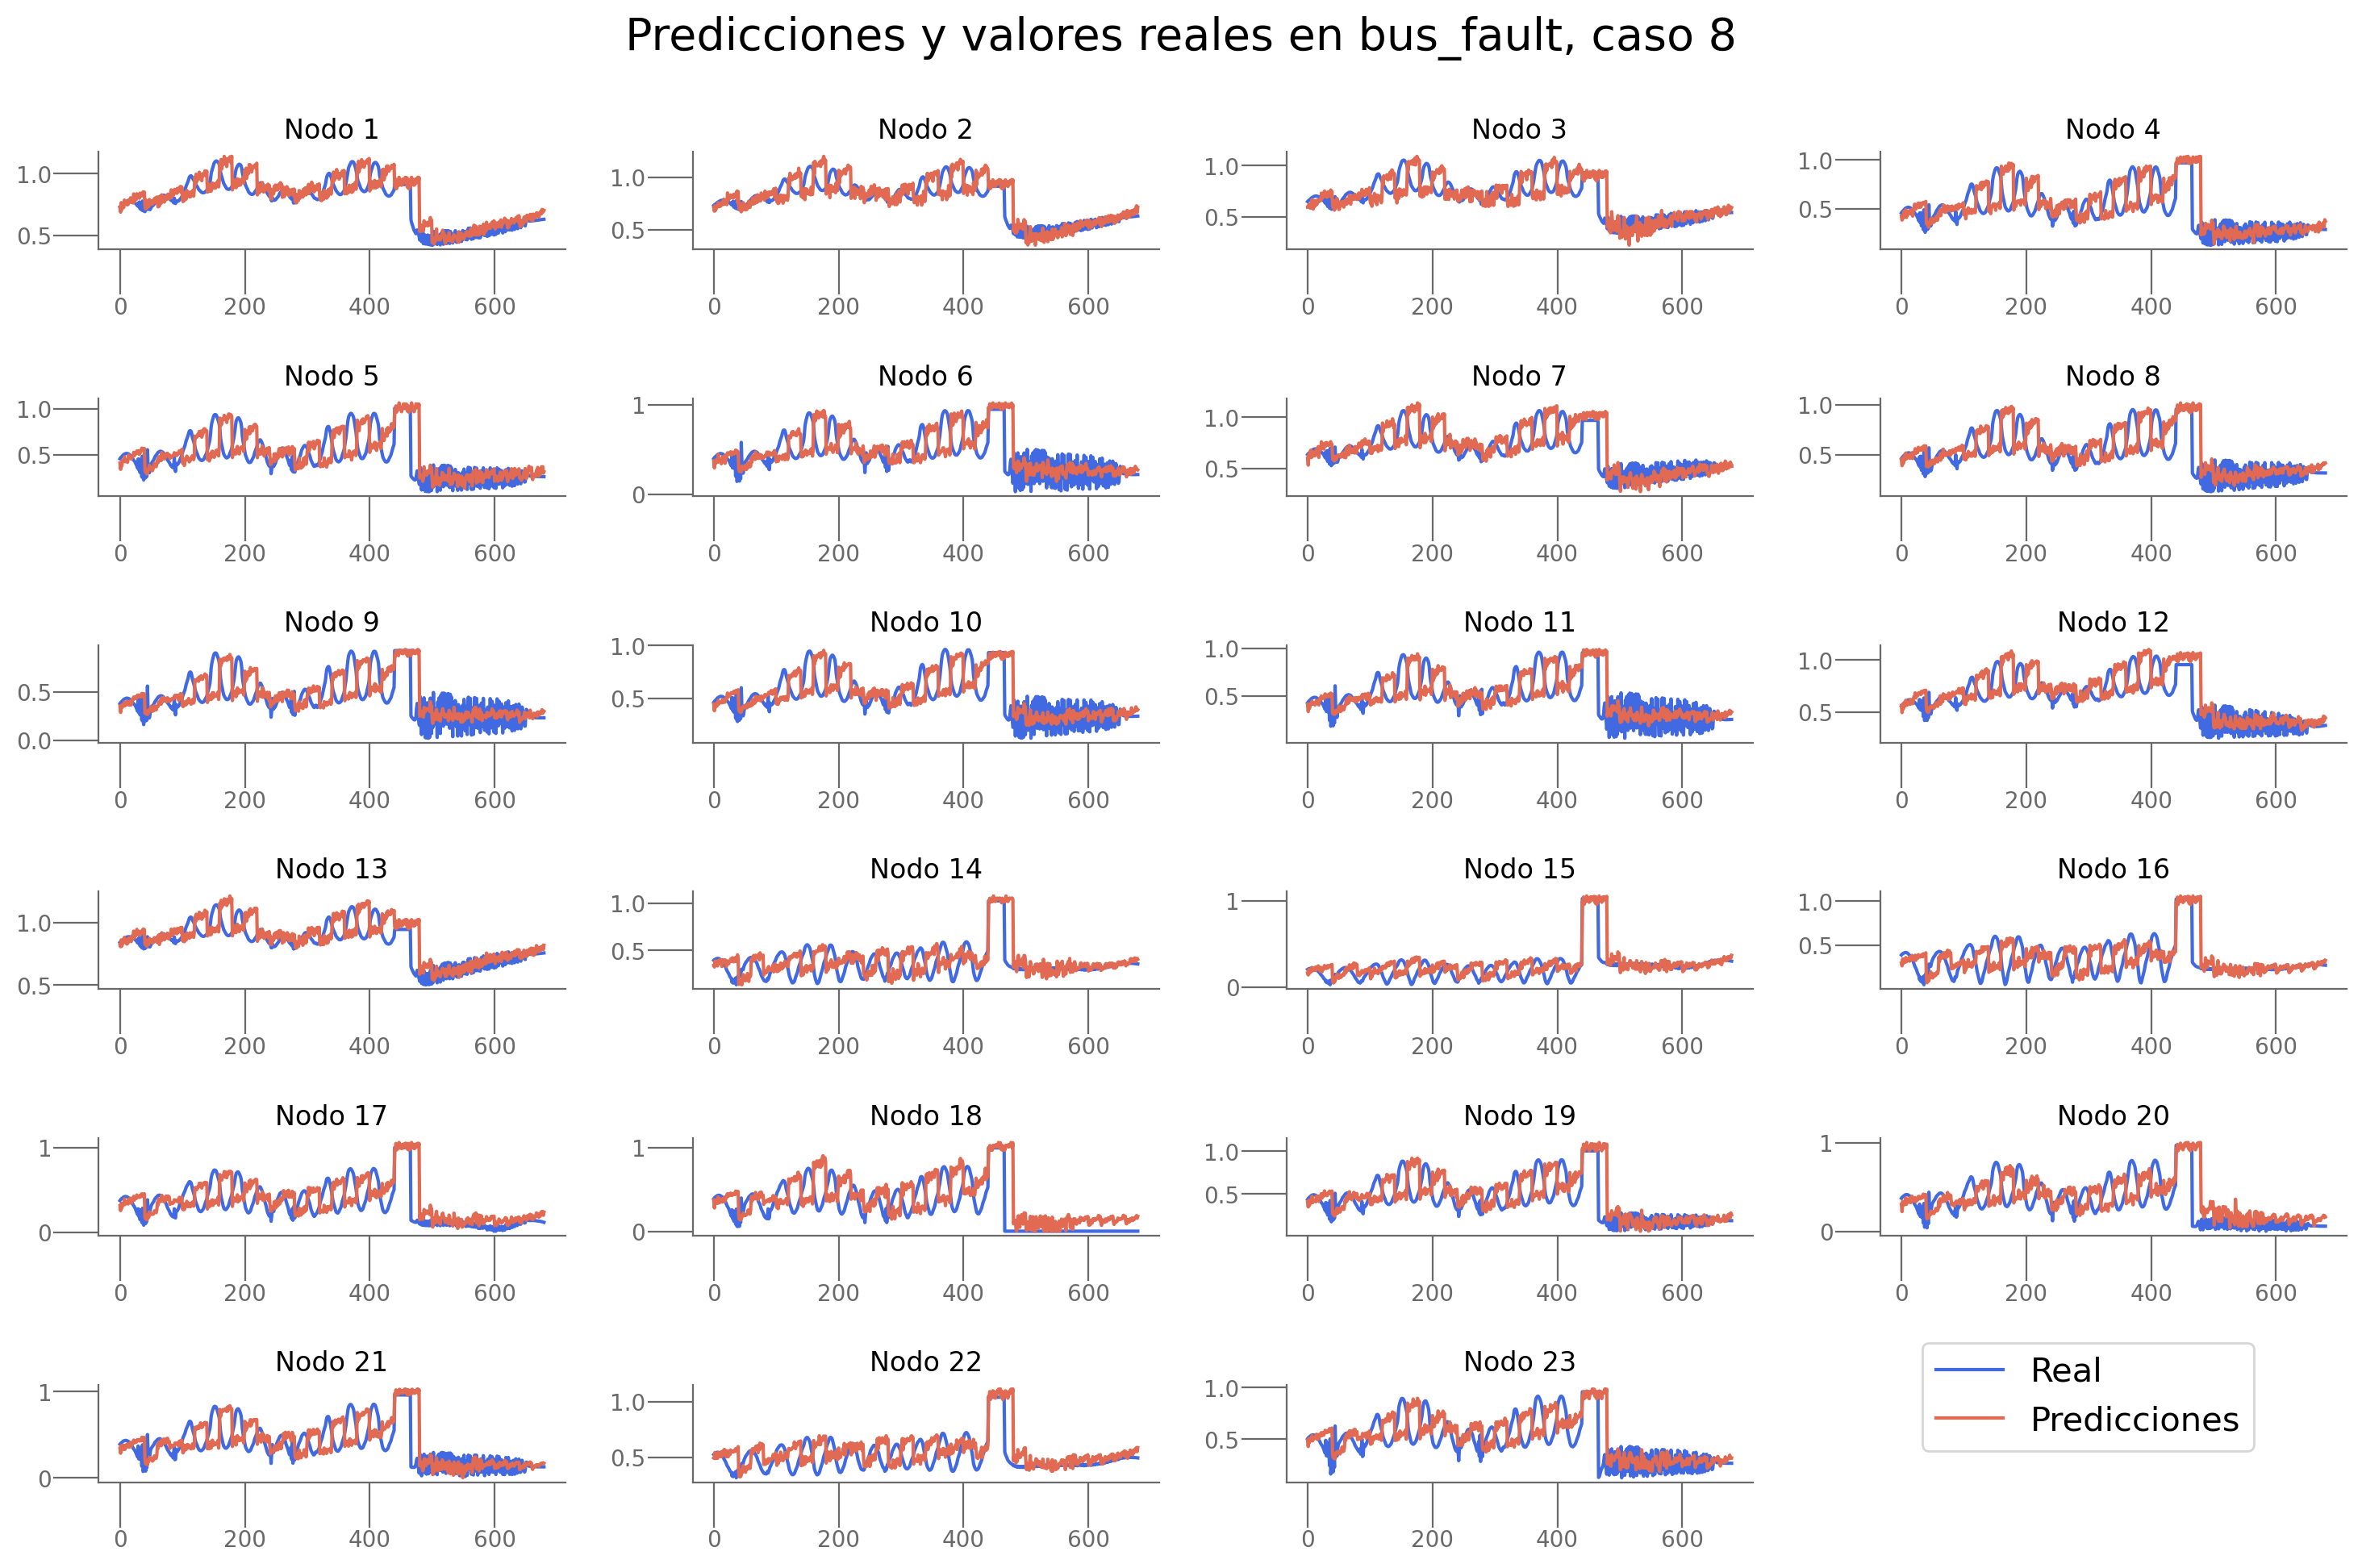

In [31]:
plot_predictions(predictions_bf_ajuste, real_bf_ajuste, n_target, 8, n_div_bf, problem_bf)

In [32]:
path_save_experiment_bf = results_save_path+f"/{problem_bf}"+ f"/ajustes/{name_model}_results.csv"
resultados_bf.to_csv(path_save_experiment_bf, index=False)

In [33]:
trainer_bf.save_model(path_save_experiment=path_save_experiment_bf, params=params_bf)


==================== GUARDANDO RESULTADOS ===================

         Modelo                                             Params  \
0          LSTM                                                NaN   
1  LSTM_NOBATCH                                                NaN   
2     MPNN_LSTM                {'hidden_size': 64, 'dropout': 0.2}   
3   DyGrEncoder             {'aggr': 'mean', 'conv': 1, 'lstm': 1}   
4         AGCRN                              {'hidden': 5, 'K': 2}   
5         DCRNN                                     {'hidden': 40}   
6        MSTGCN  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_...   

                      Fichero_resultados_experimento  Loss_tst    R2_tst  \
0                                                NaN  0.017298  0.603716   
1                                                NaN  0.017459 -1.122112   
2   ./results/bus_fault/ajustes/MPNNLSTM_results.csv  0.016746 -0.682421   
3  ./results/bus_fault/ajustes/DryGrEncoder_resul...  0.016410 -0.66477

### Branch Fault

In [34]:
problem_brf = "branch_fault"
dataset_brf, situations_brf = loader.get_dataset( target= 20, intro=100, step=20, one_ts_per_situation=False, start = 1, type=problem_brf)


Number of situations:  549
Number of timestamps:  800
Number of situations of the selected type:  92


In [35]:
n_div_brf = loader.div
n_nodes =dataset_brf.features[0].shape[0]
n_target = dataset_brf.targets[0].shape[1]
n_features = dataset_brf[0].x.shape[1]
hidden_size =32
dropout = 0.5

num_early_stop = 0
num_epochs = 30
lr = 0.01

#### Sencilla 

In [31]:

device =  torch.device("cpu")
model_brf = MSTGCNModel(name="MSTGCN", node_features=n_features, node_count=n_nodes, n_target=n_target, nb_block=2, k=2, nb_chev_filter = 2, nb_time_filter =2, time_strides = 2)


trainer_brf = TrainerMSTGCN(model_brf, dataset_brf,device, f"./results/{problem_brf}", dataloader_params2)


losses,eval_losses, r2scores  = trainer_brf.train(num_epochs=num_epochs, steps=50, num_early_stop=num_early_stop)





==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469
AQuissss

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.1875 | Eval Loss: 0.2232 | Eval R2: -25.0679 | LR: 0.0010 | 
Epoch 2/30 | Train Loss: 0.1601 | Eval Loss: 0.2219 | Eval R2: -24.9007 | LR: 0.0010 | 
Epoch 3/30 | Train Loss: 0.1598 | Eval Loss: 0.2219 | Eval R2: -24.9417 | LR: 0.0010 | 
Epoch 4/30 | Train Loss: 0.1598 | Eval Loss: 0.2220 | Eval R2: -24.9639 | LR: 0.0010 | 
Epoch 5/30 | Train Loss: 0.1598 | Eval Loss: 0.2220 | Eval R2: -24.9752 | LR: 0.0010 | 
Epoch 6/30 | Train Loss: 0.1599 | Eval Loss: 0.2222 | Eval R2: -24.9865 | LR: 0.0010 | 
Epoch 7/30 | Train Loss: 0.1598 | Eval Loss: 0.2221 | Eval R2: -24.9924 | LR: 0.0010 | 
Epoch 8/30 | Train Loss: 0.1598 | Eval Loss: 0.2221 | Eval R2: -24.9885 | LR: 0.0010 | 
Epoch 9/30 | Train Loss: 0.1597 | Eval Loss: 0.2220 | Eval R2: -24.9850 | LR: 0.0010 | 
Epoch 10/30 | Train Loss: 0

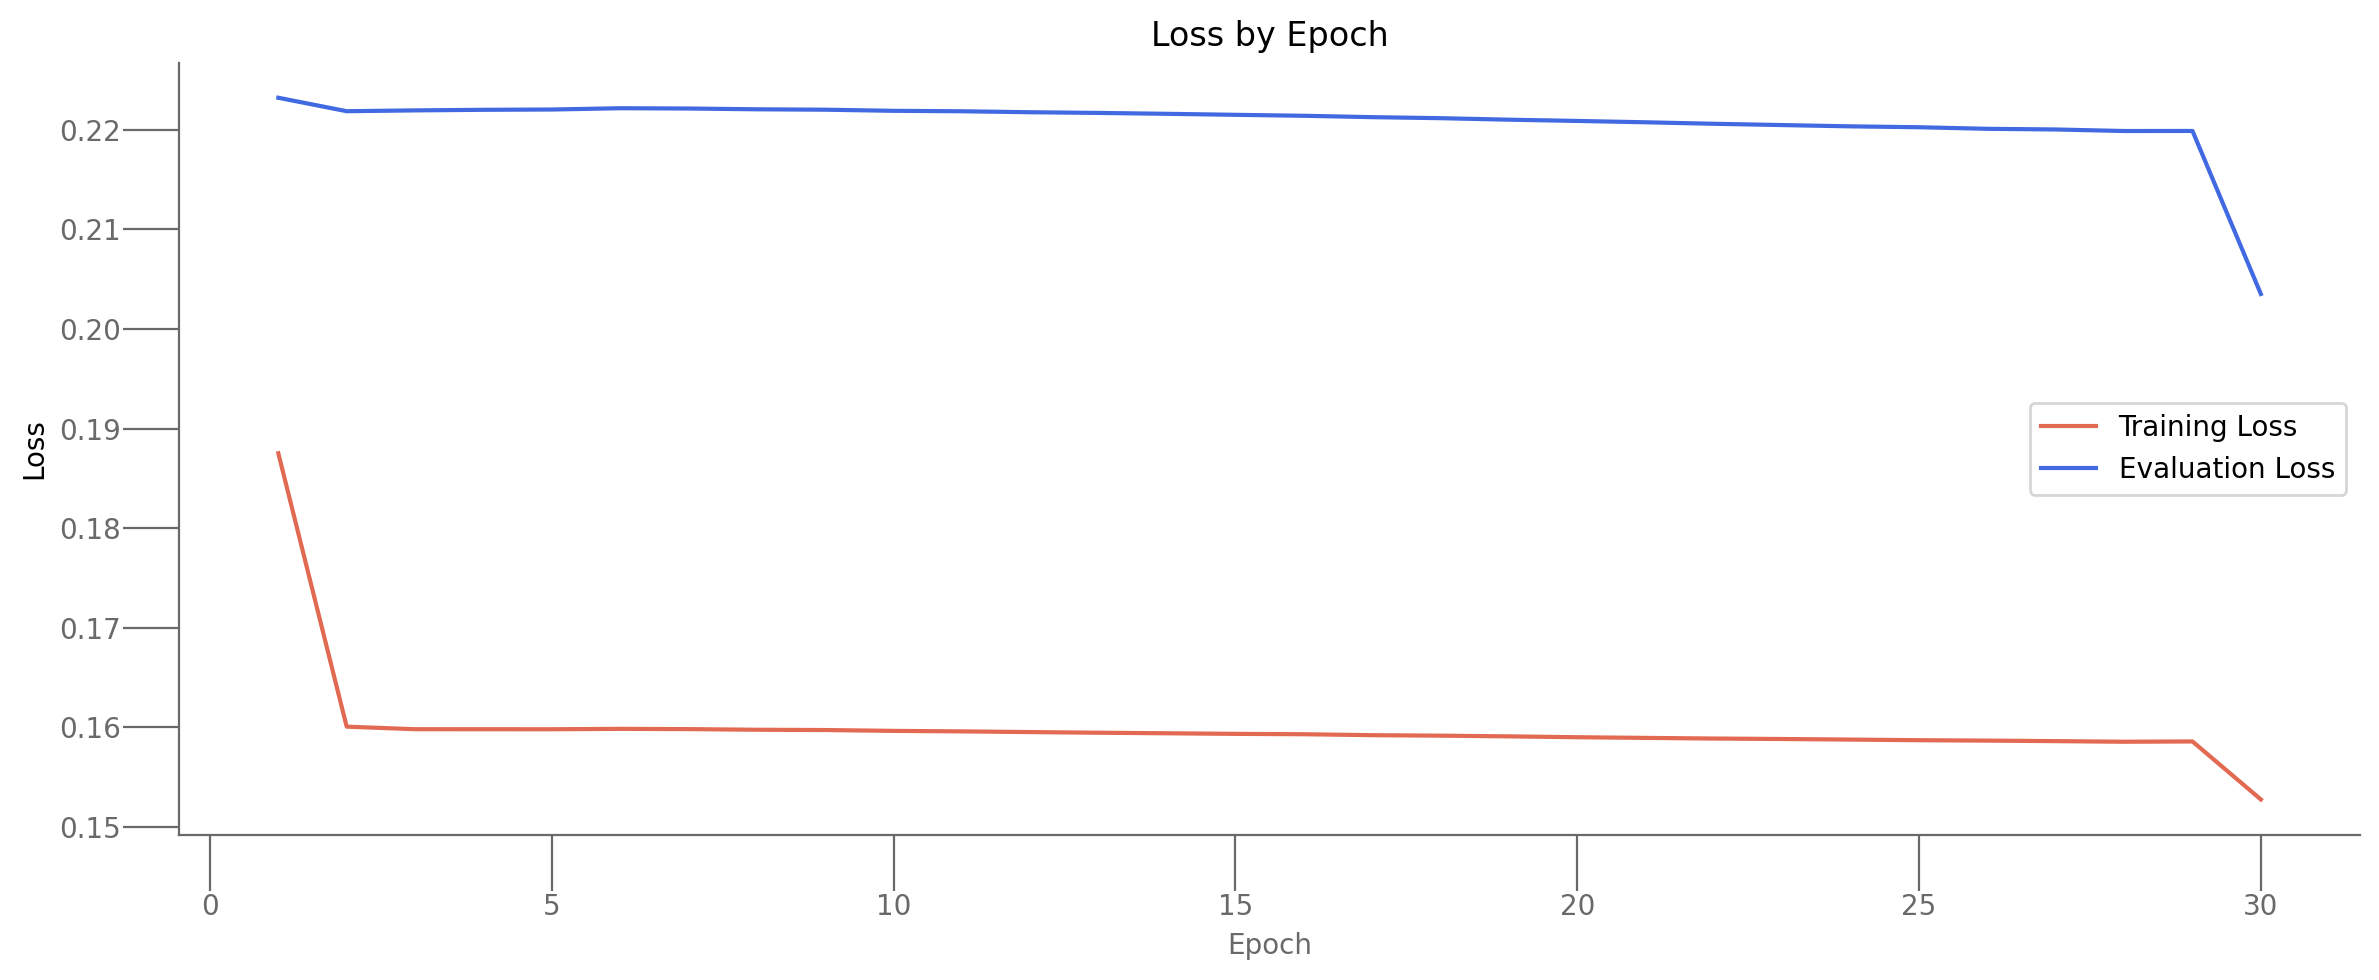


==================== TEST INFO ===================

preds:  (1, 23, 20)
test loss: 0.110374, test r2score -15.082346


In [32]:
plot_training_and_eval_losses(np.array(losses), np.array(eval_losses), num_epochs, format_plot)
losses_tst, r2score_tst, loss_nodes, predictions_brf, real_brf = trainer_brf.test()

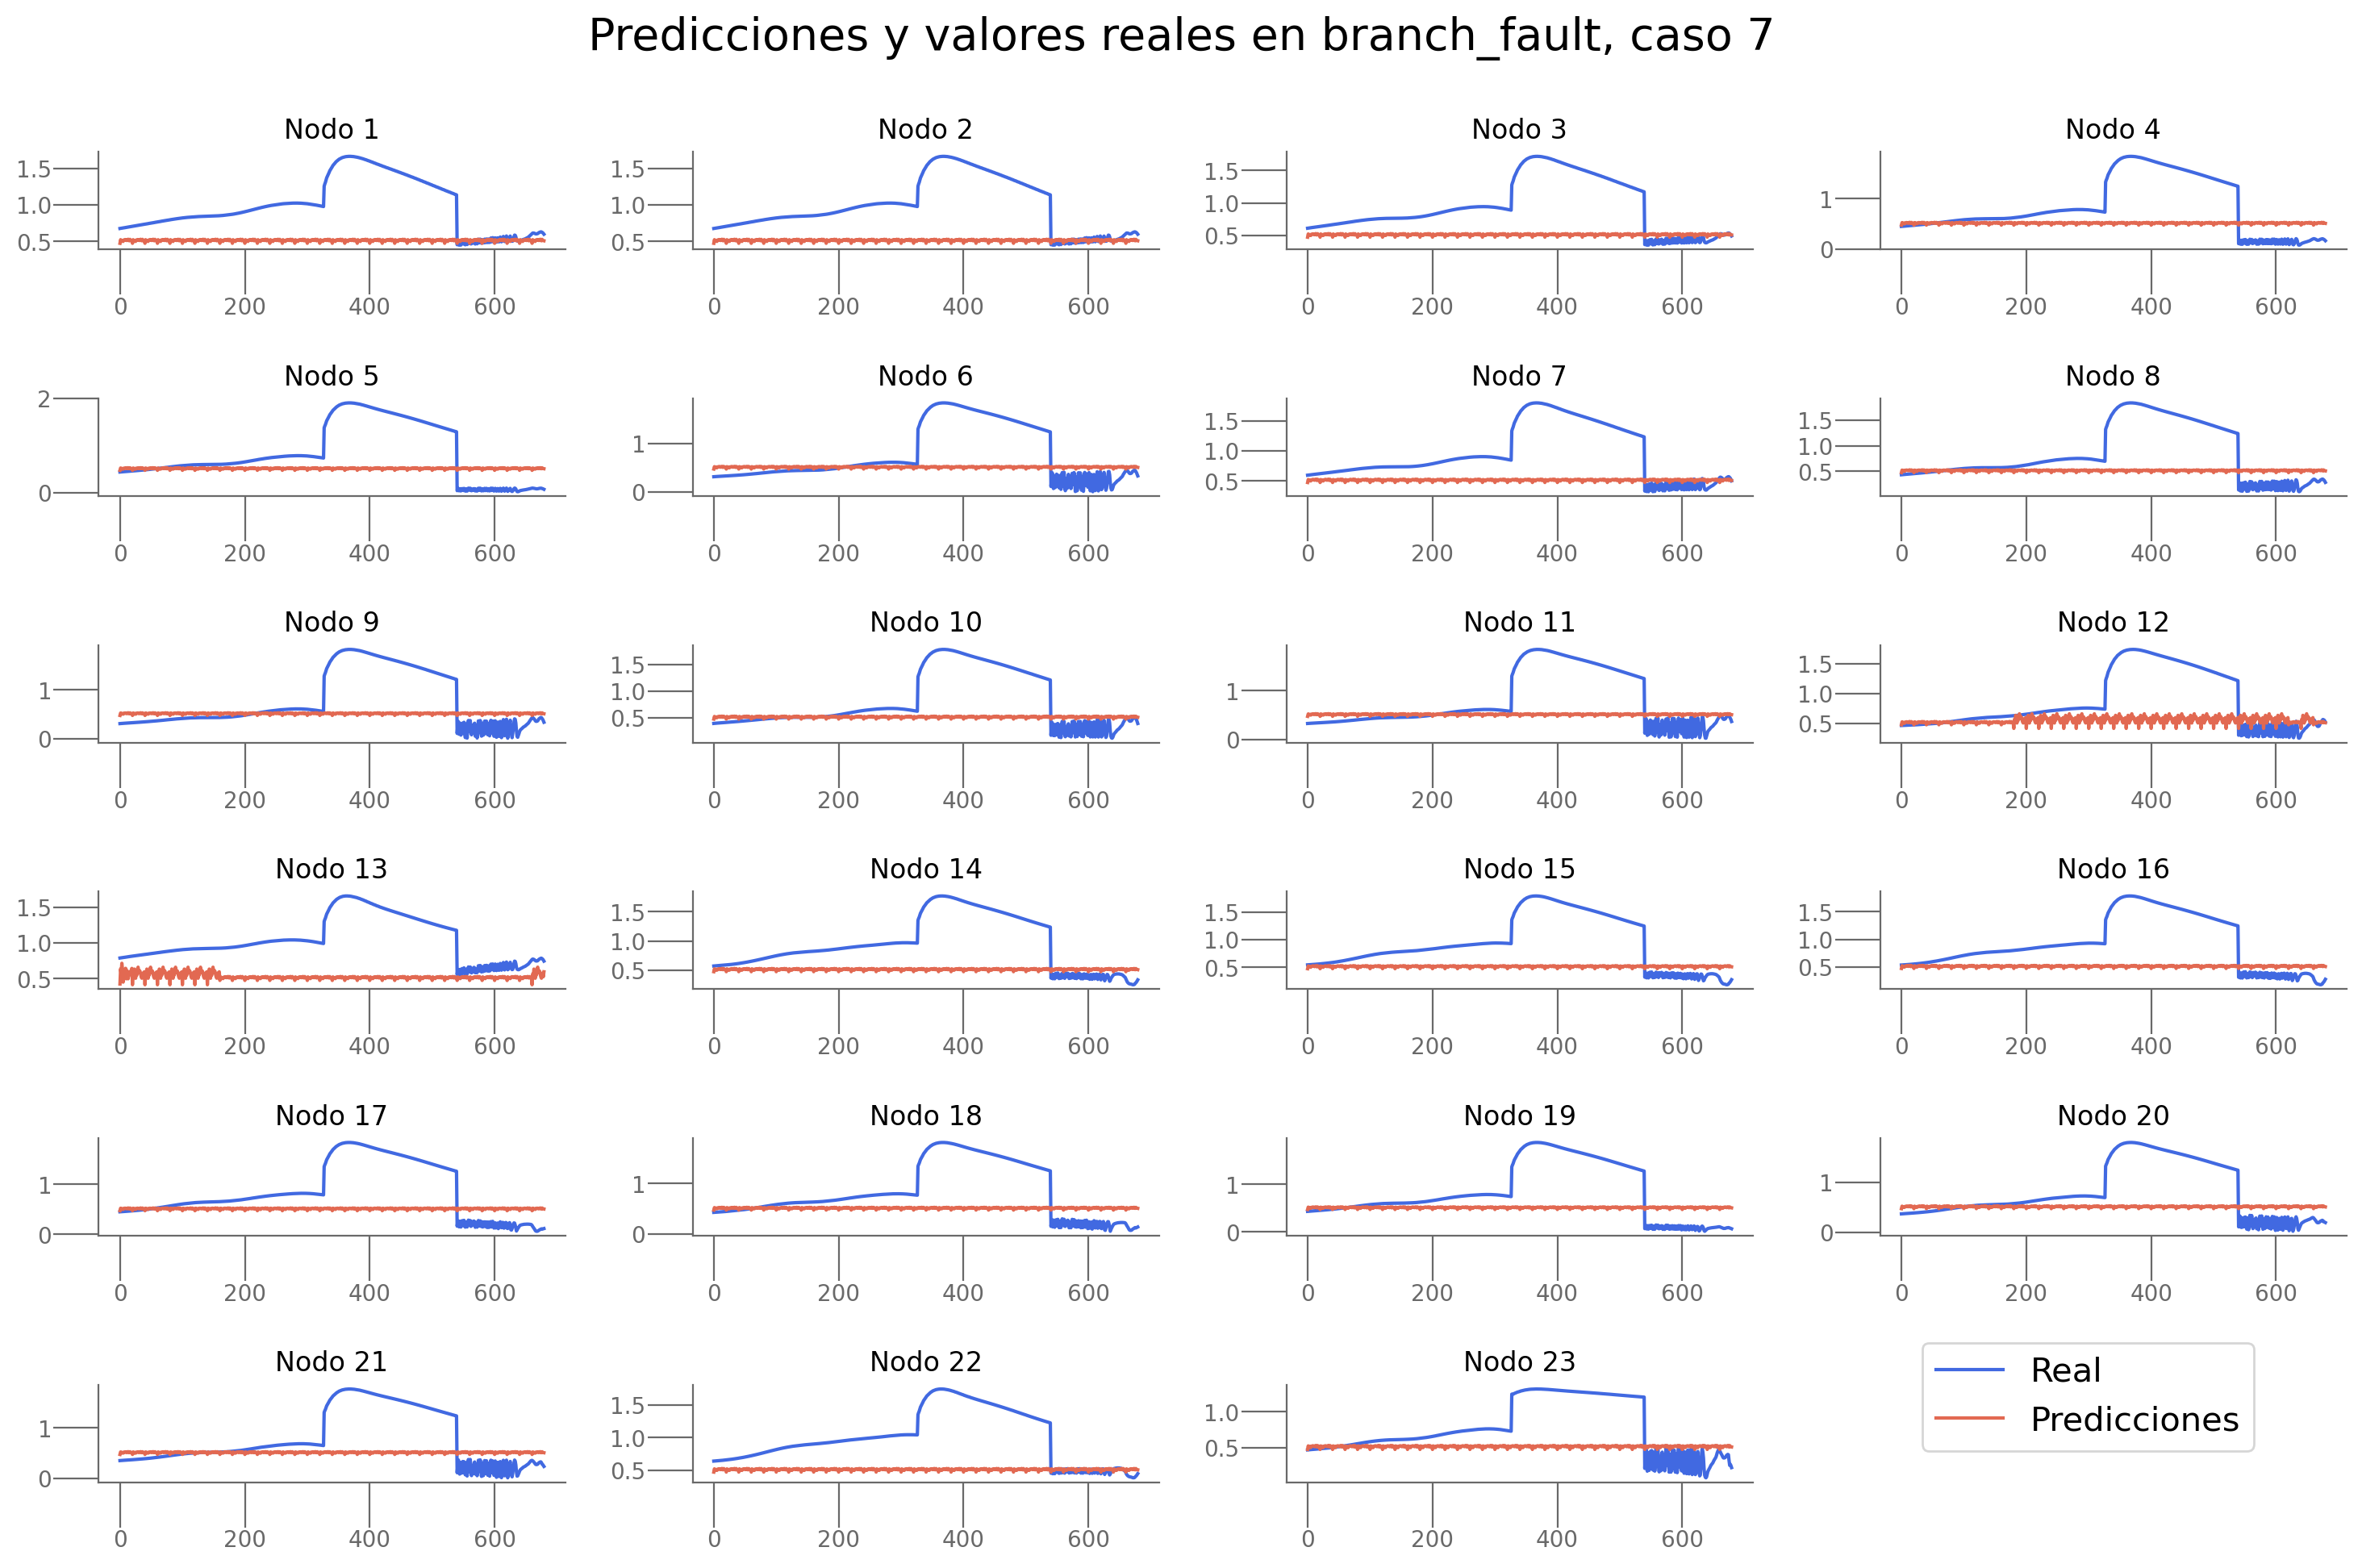

In [33]:
plot_predictions(predictions_brf, real_brf, n_target, 7, n_div_brf, problem_brf)

#### Ajuste de parámetros 

In [36]:


num_epochs = 100
num_early_stop = 10

trainer_brf,params_brf,resultados_final_brf, resultados_brf = entrenar_y_evaluar_modelos_mstgcn(param_grid, dataset_brf, dataloader_params2, num_early_stop=num_early_stop, num_epochs=num_epochs, problem=problem_brf)

  0%|          | 0/54 [00:00<?, ?it/s]

Entrenando modelo con nb_block=1, nb_chev_filter=2, nb_time_filter=2, time_strides=2, hidden=50

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469

==================== TRAIN INFO ===================

Epoch 1/100 | Train Loss: 0.5872 | Eval Loss: 0.3912 | Eval R2: -33.8658 | LR: 0.0010 | 
Epoch 2/100 | Train Loss: 0.2780 | Eval Loss: 0.2914 | Eval R2: -30.7783 | LR: 0.0010 | 
Epoch 3/100 | Train Loss: 0.2160 | Eval Loss: 0.2623 | Eval R2: -28.8603 | LR: 0.0010 | 
Epoch 4/100 | Train Loss: 0.1962 | Eval Loss: 0.2448 | Eval R2: -26.5000 | LR: 0.0010 | 
Epoch 5/100 | Train Loss: 0.1831 | Eval Loss: 0.2312 | Eval R2: -25.3074 | LR: 0.0010 | 
Epoch 6/100 | Train Loss: 0.1720 | Eval Loss: 0.2198 | Eval R2: -24.0055 | LR: 0.0010 | 
Epoch 7/100 | Train Loss: 0.1627 | Eval Loss: 0.2090 | Eval R2: -22.8083 | LR: 0.0010 | 
Epoch 8/100 | Train Loss: 0.1544 | Eval Loss: 0.2032 | Eval R2: -22.1448 | LR: 0.0010 | 
Epoch 9/100 | Train 

  2%|▏         | 1/54 [07:05<6:16:15, 425.94s/it]

preds:  (1, 23, 20)
test loss: 0.077254, test R2 score: -9.988741
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 50, 'time_strides': 2, 'loss_final': 0.09181425720453262, 'r2_eval_final': -12.366747856140137, 'loss_eval_final': 0.11332421749830246, 'r2_test': -9.988741262829977, 'loss_test': 0.07725420594215393, 'loss_nodes': [0.11129644513130188, 0.11129644513130188, 0.07889536023139954, 0.0865292102098465, 0.09643268585205078, 0.08135531097650528, 0.07518964260816574, 0.058917369693517685, 0.07108116894960403, 0.06381498277187347, 0.061214324086904526, 0.04169304668903351, 0.08721638470888138, 0.05450903996825218, 0.0700676366686821, 0.0697871521115303, 0.07829108834266663, 0.10120898485183716, 0.08322542905807495, 0.09381582587957382, 0.07443898916244507, 0.08188226819038391, 0.0446881428360939]}
Entrenando modelo con nb_block=1, nb_chev_filter=2, nb_time_filter=2, time_strides=2, hidden=80

==================== DATASET INFO ============

  4%|▎         | 2/54 [13:40<5:53:06, 407.43s/it]

preds:  (1, 23, 20)
test loss: 0.077142, test R2 score: -10.065028
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 80, 'time_strides': 2, 'loss_final': 0.09167978912591934, 'r2_eval_final': -12.403096199035645, 'loss_eval_final': 0.11324189603328705, 'r2_test': -10.06502837681007, 'loss_test': 0.07714241743087769, 'loss_nodes': [0.11106964200735092, 0.11106964200735092, 0.07866884022951126, 0.0865553542971611, 0.09560173004865646, 0.08130308240652084, 0.07529273629188538, 0.05897224321961403, 0.07132261991500854, 0.06375357508659363, 0.06116420775651932, 0.04155929759144783, 0.08655285090208054, 0.05372866615653038, 0.0698125958442688, 0.06957024335861206, 0.07841544598340988, 0.10152611136436462, 0.08303534239530563, 0.09390286356210709, 0.07444316893815994, 0.08234420418739319, 0.04461078718304634]}
Entrenando modelo con nb_block=1, nb_chev_filter=2, nb_time_filter=2, time_strides=2, hidden=100

==================== DATASET INFO ==========

  6%|▌         | 3/54 [21:35<6:12:27, 438.18s/it]

preds:  (1, 23, 20)
test loss: 0.076557, test R2 score: -9.888257
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 100, 'time_strides': 2, 'loss_final': 0.0915277749300003, 'r2_eval_final': -12.172999382019043, 'loss_eval_final': 0.11206377297639847, 'r2_test': -9.888257040187728, 'loss_test': 0.07655666023492813, 'loss_nodes': [0.11062373220920563, 0.11062373220920563, 0.07841666787862778, 0.08731462806463242, 0.09506604820489883, 0.08199262619018555, 0.07666108012199402, 0.05898776277899742, 0.07140181213617325, 0.06354641169309616, 0.06075366586446762, 0.04117010906338692, 0.07836544513702393, 0.05359232425689697, 0.06931889057159424, 0.06914637982845306, 0.07850849628448486, 0.10150055587291718, 0.08245730400085449, 0.09389910101890564, 0.0743570402264595, 0.07883195579051971, 0.04426773637533188]}
Entrenando modelo con nb_block=1, nb_chev_filter=2, nb_time_filter=2, time_strides=5, hidden=50

==================== DATASET INFO ===========

  7%|▋         | 4/54 [28:25<5:55:52, 427.04s/it]

preds:  (1, 23, 20)
test loss: 0.175774, test R2 score: -23.887393
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 50, 'time_strides': 5, 'loss_final': 0.22131581604480743, 'r2_eval_final': -32.17741012573242, 'loss_eval_final': 0.28854140639305115, 'r2_test': -23.887392753537135, 'loss_test': 0.1757742166519165, 'loss_nodes': [0.22082126140594482, 0.22082126140594482, 0.18406660854816437, 0.16373006999492645, 0.17908325791358948, 0.15937624871730804, 0.1786544770002365, 0.15678265690803528, 0.1636262834072113, 0.1544896364212036, 0.15751974284648895, 0.14728134870529175, 0.24635231494903564, 0.17375925183296204, 0.16450729966163635, 0.16374556720256805, 0.17260418832302094, 0.18202424049377441, 0.17682434618473053, 0.17614738643169403, 0.16051632165908813, 0.21438847482204437, 0.12568488717079163]}
Entrenando modelo con nb_block=1, nb_chev_filter=2, nb_time_filter=2, time_strides=5, hidden=80

==================== DATASET INFO =============

  9%|▉         | 5/54 [35:01<5:39:51, 416.15s/it]

preds:  (1, 23, 20)
test loss: 0.175774, test R2 score: -23.887393
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 80, 'time_strides': 5, 'loss_final': 0.22131581604480743, 'r2_eval_final': -32.17741012573242, 'loss_eval_final': 0.28854140639305115, 'r2_test': -23.887392866465607, 'loss_test': 0.1757742166519165, 'loss_nodes': [0.22082123160362244, 0.22082123160362244, 0.18406660854816437, 0.16373006999492645, 0.17908324301242828, 0.15937624871730804, 0.1786544770002365, 0.15678265690803528, 0.1636263132095337, 0.154489666223526, 0.15751974284648895, 0.14728136360645294, 0.24635232985019684, 0.17375925183296204, 0.16450729966163635, 0.16374556720256805, 0.17260420322418213, 0.18202424049377441, 0.17682434618473053, 0.17614738643169403, 0.16051632165908813, 0.21438847482204437, 0.12568488717079163]}
Entrenando modelo con nb_block=1, nb_chev_filter=2, nb_time_filter=2, time_strides=5, hidden=100

==================== DATASET INFO =============

 11%|█         | 6/54 [41:49<5:30:37, 413.28s/it]

preds:  (1, 23, 20)
test loss: 0.175774, test R2 score: -23.887393
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 100, 'time_strides': 5, 'loss_final': 0.22131581604480743, 'r2_eval_final': -32.17741012573242, 'loss_eval_final': 0.28854140639305115, 'r2_test': -23.887392691547845, 'loss_test': 0.1757742166519165, 'loss_nodes': [0.22082123160362244, 0.22082123160362244, 0.18406662344932556, 0.16373006999492645, 0.17908325791358948, 0.15937624871730804, 0.17865446209907532, 0.15678265690803528, 0.1636263132095337, 0.154489666223526, 0.15751974284648895, 0.14728136360645294, 0.24635232985019684, 0.17375925183296204, 0.16450731456279755, 0.16374558210372925, 0.17260417342185974, 0.18202424049377441, 0.17682434618473053, 0.17614738643169403, 0.16051632165908813, 0.21438847482204437, 0.12568488717079163]}
Entrenando modelo con nb_block=1, nb_chev_filter=2, nb_time_filter=2, time_strides=10, hidden=50

==================== DATASET INFO ===========

 13%|█▎        | 7/54 [54:46<6:56:54, 532.22s/it]

preds:  (1, 23, 20)
test loss: 0.112148, test R2 score: -14.276579
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 50, 'time_strides': 10, 'loss_final': 0.14829455316066742, 'r2_eval_final': -21.47065544128418, 'loss_eval_final': 0.20072264969348907, 'r2_test': -14.276579197003109, 'loss_test': 0.11214807629585266, 'loss_nodes': [0.10244864225387573, 0.10244864225387573, 0.09691166132688522, 0.12621913850307465, 0.14349842071533203, 0.12303747236728668, 0.09998369216918945, 0.11552448570728302, 0.13463199138641357, 0.11485084891319275, 0.11633958667516708, 0.07312995195388794, 0.10948269814252853, 0.07911123335361481, 0.08338548988103867, 0.08413376659154892, 0.1345195174217224, 0.15035904943943024, 0.1434677243232727, 0.1503559947013855, 0.129717156291008, 0.09060954302549362, 0.07523877173662186]}
Entrenando modelo con nb_block=1, nb_chev_filter=2, nb_time_filter=2, time_strides=10, hidden=80

==================== DATASET INFO ============

 15%|█▍        | 8/54 [1:10:56<8:34:46, 671.45s/it]

preds:  (1, 23, 20)
test loss: 0.112148, test R2 score: -14.276579
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 80, 'time_strides': 10, 'loss_final': 0.14829455316066742, 'r2_eval_final': -21.470653533935547, 'loss_eval_final': 0.20072266459465027, 'r2_test': -14.276579164363271, 'loss_test': 0.11214808374643326, 'loss_nodes': [0.10244864225387573, 0.10244864225387573, 0.09691166877746582, 0.12621913850307465, 0.14349843561649323, 0.12303747981786728, 0.09998369216918945, 0.11552448570728302, 0.13463200628757477, 0.11485084891319275, 0.11633958667516708, 0.07312995940446854, 0.10948270559310913, 0.07911122590303421, 0.08338548988103867, 0.08413376659154892, 0.1345195174217224, 0.15035904943943024, 0.1434677392244339, 0.1503559947013855, 0.1297171711921692, 0.09060952812433243, 0.07523877918720245]}
Entrenando modelo con nb_block=1, nb_chev_filter=2, nb_time_filter=2, time_strides=10, hidden=100

==================== DATASET INFO =========

 17%|█▋        | 9/54 [1:16:23<7:02:58, 563.97s/it]

preds:  (1, 23, 20)
test loss: 0.112148, test R2 score: -14.276579
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 100, 'time_strides': 10, 'loss_final': 0.14829455316066742, 'r2_eval_final': -21.470653533935547, 'loss_eval_final': 0.20072266459465027, 'r2_test': -14.276579028170408, 'loss_test': 0.11214808374643326, 'loss_nodes': [0.10244863480329514, 0.10244863480329514, 0.09691167622804642, 0.12621913850307465, 0.14349842071533203, 0.12303747981786728, 0.09998370707035065, 0.11552448570728302, 0.13463200628757477, 0.11485084891319275, 0.11633959412574768, 0.07312995940446854, 0.10948269814252853, 0.07911122590303421, 0.08338548988103867, 0.08413376659154892, 0.1345195174217224, 0.15035904943943024, 0.1434677392244339, 0.1503559947013855, 0.1297171711921692, 0.09060952812433243, 0.07523877173662186]}
Entrenando modelo con nb_block=1, nb_chev_filter=4, nb_time_filter=4, time_strides=2, hidden=50

==================== DATASET INFO ==========

 19%|█▊        | 10/54 [1:22:29<6:08:41, 502.76s/it]

preds:  (1, 23, 20)
test loss: 0.092562, test R2 score: -10.961389
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 50, 'time_strides': 2, 'loss_final': 0.11072760075330734, 'r2_eval_final': -15.294081687927246, 'loss_eval_final': 0.13973329961299896, 'r2_test': -10.96138931765091, 'loss_test': 0.09256157279014587, 'loss_nodes': [0.12302754819393158, 0.12302754819393158, 0.09990540146827698, 0.07699939608573914, 0.08051172643899918, 0.08151115477085114, 0.0987323746085167, 0.07682962715625763, 0.07620050758123398, 0.07481005787849426, 0.08299393951892853, 0.08982346206903458, 0.13838855922222137, 0.10949321836233139, 0.1001719981431961, 0.09908763319253922, 0.08067847788333893, 0.07987546920776367, 0.07944273203611374, 0.07579004764556885, 0.07618901133537292, 0.13041366636753082, 0.07501272112131119]}
Entrenando modelo con nb_block=1, nb_chev_filter=4, nb_time_filter=4, time_strides=2, hidden=80

==================== DATASET INFO ===========

 20%|██        | 11/54 [1:28:59<5:35:27, 468.09s/it]

preds:  (1, 23, 20)
test loss: 0.092562, test R2 score: -10.961393
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 80, 'time_strides': 2, 'loss_final': 0.11072757095098495, 'r2_eval_final': -15.294084548950195, 'loss_eval_final': 0.13973329961299896, 'r2_test': -10.961393177922684, 'loss_test': 0.09256158024072647, 'loss_nodes': [0.12302757054567337, 0.12302757054567337, 0.09990540891885757, 0.07699917256832123, 0.08051169663667679, 0.0815110057592392, 0.09873224794864655, 0.0768297016620636, 0.07620052248239517, 0.07481005042791367, 0.08299390971660614, 0.08982345461845398, 0.13838860392570496, 0.10949327051639557, 0.1001720130443573, 0.09908762574195862, 0.08067860454320908, 0.07987546920776367, 0.07944274693727493, 0.07579004019498825, 0.07618904858827591, 0.13041378557682037, 0.07501273602247238]}
Entrenando modelo con nb_block=1, nb_chev_filter=4, nb_time_filter=4, time_strides=2, hidden=100

==================== DATASET INFO ==========

 22%|██▏       | 12/54 [1:35:50<5:15:38, 450.91s/it]

preds:  (1, 23, 20)
test loss: 0.092562, test R2 score: -10.961394
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 100, 'time_strides': 2, 'loss_final': 0.11072766780853271, 'r2_eval_final': -15.294090270996094, 'loss_eval_final': 0.13973338901996613, 'r2_test': -10.961393504565343, 'loss_test': 0.09256161749362946, 'loss_nodes': [0.12302747368812561, 0.12302747368812561, 0.09990543872117996, 0.07699915021657944, 0.08051170408725739, 0.08151103556156158, 0.09873224049806595, 0.07682979106903076, 0.07620060443878174, 0.07481011003255844, 0.08299394696950912, 0.08982352912425995, 0.13838867843151093, 0.10949340462684631, 0.1001720279455185, 0.099087655544281, 0.08067862689495087, 0.07987555116415024, 0.0794428214430809, 0.07579010725021362, 0.07618910819292068, 0.13041383028030396, 0.07501280307769775]}
Entrenando modelo con nb_block=1, nb_chev_filter=4, nb_time_filter=4, time_strides=5, hidden=50

==================== DATASET INFO ===========

 24%|██▍       | 13/54 [1:41:51<4:49:31, 423.69s/it]

preds:  (1, 23, 20)
test loss: 0.150814, test R2 score: -21.657095
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 50, 'time_strides': 5, 'loss_final': 0.18101811408996582, 'r2_eval_final': -25.553316116333008, 'loss_eval_final': 0.2261536568403244, 'r2_test': -21.657095276451393, 'loss_test': 0.15081427991390228, 'loss_nodes': [0.20955894887447357, 0.20955894887447357, 0.16970396041870117, 0.12203264236450195, 0.12956088781356812, 0.1258632391691208, 0.16372913122177124, 0.12351315468549728, 0.11922510713338852, 0.1213628500699997, 0.12933272123336792, 0.1487947255373001, 0.23710794746875763, 0.17904822528362274, 0.16263388097286224, 0.16092777252197266, 0.12794308364391327, 0.12701968848705292, 0.12580350041389465, 0.12057846784591675, 0.11839622259140015, 0.21713866293430328, 0.11989462375640869]}
Entrenando modelo con nb_block=1, nb_chev_filter=4, nb_time_filter=4, time_strides=5, hidden=80

==================== DATASET INFO ============

 26%|██▌       | 14/54 [1:47:35<4:26:16, 399.42s/it]

preds:  (1, 23, 20)
test loss: 0.150814, test R2 score: -21.657097
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 80, 'time_strides': 5, 'loss_final': 0.1810181736946106, 'r2_eval_final': -25.55331802368164, 'loss_eval_final': 0.22615371644496918, 'r2_test': -21.657097469712756, 'loss_test': 0.15081430971622467, 'loss_nodes': [0.20955906808376312, 0.20955906808376312, 0.16970399022102356, 0.12203257530927658, 0.12956109642982483, 0.1258632093667984, 0.16372919082641602, 0.12351314723491669, 0.11922508478164673, 0.12136291712522507, 0.12933260202407837, 0.1487947404384613, 0.23710796236991882, 0.17904852330684662, 0.1626339554786682, 0.16092784702777863, 0.12794311344623566, 0.1270199865102768, 0.1258034110069275, 0.12057856470346451, 0.11839614808559418, 0.2171386480331421, 0.11989465355873108]}
Entrenando modelo con nb_block=1, nb_chev_filter=4, nb_time_filter=4, time_strides=5, hidden=100

==================== DATASET INFO ===============

 28%|██▊       | 15/54 [1:52:56<4:04:22, 375.96s/it]

preds:  (1, 23, 20)
test loss: 0.150814, test R2 score: -21.657098
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 100, 'time_strides': 5, 'loss_final': 0.18101811408996582, 'r2_eval_final': -25.55331802368164, 'loss_eval_final': 0.22615370154380798, 'r2_test': -21.657097808543607, 'loss_test': 0.15081429481506348, 'loss_nodes': [0.20955894887447357, 0.20955894887447357, 0.16970396041870117, 0.12203270196914673, 0.1295609176158905, 0.12586325407028198, 0.16372919082641602, 0.1235131248831749, 0.11922506988048553, 0.1213628500699997, 0.12933269143104553, 0.1487947404384613, 0.23710794746875763, 0.1790483593940735, 0.16263389587402344, 0.16092774271965027, 0.12794305384159088, 0.12701977789402008, 0.12580347061157227, 0.12057849019765854, 0.11839617043733597, 0.2171386331319809, 0.11989465355873108]}
Entrenando modelo con nb_block=1, nb_chev_filter=4, nb_time_filter=4, time_strides=10, hidden=50

==================== DATASET INFO =============

 30%|██▉       | 16/54 [1:58:23<3:48:47, 361.25s/it]

preds:  (1, 23, 20)
test loss: 0.030548, test R2 score: -2.610135
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 50, 'time_strides': 10, 'loss_final': 0.03351158648729324, 'r2_eval_final': -4.250768184661865, 'loss_eval_final': 0.042132668197155, 'r2_test': -2.6101353647047874, 'loss_test': 0.03054814040660858, 'loss_nodes': [0.012565870769321918, 0.012565870769321918, 0.018170902505517006, 0.03417368605732918, 0.03869291767477989, 0.04213438183069229, 0.024949006736278534, 0.03327564150094986, 0.040979139506816864, 0.03299243003129959, 0.03920659050345421, 0.02487894892692566, 0.012715058401226997, 0.028620535507798195, 0.02918468415737152, 0.029179269447922707, 0.03768919035792351, 0.04031132534146309, 0.037739261984825134, 0.04230108484625816, 0.03939362242817879, 0.020030289888381958, 0.030857380479574203]}
Entrenando modelo con nb_block=1, nb_chev_filter=4, nb_time_filter=4, time_strides=10, hidden=80

==================== DATASET INFO

 31%|███▏      | 17/54 [2:03:53<3:36:50, 351.63s/it]

preds:  (1, 23, 20)
test loss: 0.030547, test R2 score: -2.610032
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 80, 'time_strides': 10, 'loss_final': 0.033511992543935776, 'r2_eval_final': -4.250727653503418, 'loss_eval_final': 0.04213223233819008, 'r2_test': -2.610031785359175, 'loss_test': 0.030547278001904488, 'loss_nodes': [0.01256452314555645, 0.01256452314555645, 0.018170125782489777, 0.03417440876364708, 0.038691818714141846, 0.042135175317525864, 0.024948734790086746, 0.033274535089731216, 0.04097956418991089, 0.032992757856845856, 0.039205703884363174, 0.02487795241177082, 0.012712902389466763, 0.028620276600122452, 0.029183249920606613, 0.02917839027941227, 0.0376860685646534, 0.04031152278184891, 0.037734951823949814, 0.04230150207877159, 0.0393933467566967, 0.020027851685881615, 0.03085745871067047]}
Entrenando modelo con nb_block=1, nb_chev_filter=4, nb_time_filter=4, time_strides=10, hidden=100

==================== DATASET I

 33%|███▎      | 18/54 [2:09:04<3:23:41, 339.48s/it]

preds:  (1, 23, 20)
test loss: 0.030548, test R2 score: -2.610095
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 100, 'time_strides': 10, 'loss_final': 0.03351154550909996, 'r2_eval_final': -4.250712871551514, 'loss_eval_final': 0.04213249310851097, 'r2_test': -2.610095002767711, 'loss_test': 0.030548157170414925, 'loss_nodes': [0.01256559882313013, 0.01256559882313013, 0.018170854076743126, 0.0341741181910038, 0.038692791014909744, 0.042134858667850494, 0.02494918927550316, 0.03327563777565956, 0.04097934067249298, 0.0329926460981369, 0.03920666128396988, 0.024878963828086853, 0.01271437294781208, 0.028620928525924683, 0.029184646904468536, 0.029179349541664124, 0.037688933312892914, 0.04031158611178398, 0.03773893043398857, 0.042301349341869354, 0.03939371556043625, 0.02002980373799801, 0.030857637524604797]}
Entrenando modelo con nb_block=1, nb_chev_filter=8, nb_time_filter=8, time_strides=2, hidden=50

==================== DATASET INFO 

 35%|███▌      | 19/54 [2:16:10<3:33:13, 365.53s/it]

preds:  (1, 23, 20)
test loss: 0.056449, test R2 score: -6.041388
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 50, 'time_strides': 2, 'loss_final': 0.06538499146699905, 'r2_eval_final': -9.106240272521973, 'loss_eval_final': 0.08366566151380539, 'r2_test': -6.041387943077117, 'loss_test': 0.05644945427775383, 'loss_nodes': [0.0641205683350563, 0.0641205683350563, 0.054839275777339935, 0.0485571064054966, 0.052115775644779205, 0.05369304493069649, 0.056210100650787354, 0.049060482531785965, 0.05154179409146309, 0.048148225992918015, 0.055014822632074356, 0.052556946873664856, 0.07234865427017212, 0.06693479418754578, 0.06230578571557999, 0.06178995221853256, 0.053117044270038605, 0.053547874093055725, 0.052428003400564194, 0.051946304738521576, 0.05164273828268051, 0.07364775985479355, 0.04864981025457382]}
Entrenando modelo con nb_block=1, nb_chev_filter=8, nb_time_filter=8, time_strides=2, hidden=80

==================== DATASET INFO ===

 37%|███▋      | 20/54 [2:23:04<3:35:18, 379.94s/it]

preds:  (1, 23, 20)
test loss: 0.056449, test R2 score: -6.041371
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 80, 'time_strides': 2, 'loss_final': 0.06538479775190353, 'r2_eval_final': -9.106212615966797, 'loss_eval_final': 0.08366530388593674, 'r2_test': -6.04137086868392, 'loss_test': 0.05644923821091652, 'loss_nodes': [0.06412047892808914, 0.06412047892808914, 0.05483924224972725, 0.04855702444911003, 0.05211568996310234, 0.05369298532605171, 0.05621008574962616, 0.049060020595788956, 0.05154132470488548, 0.048148203641176224, 0.05501438304781914, 0.052556414157152176, 0.07234838604927063, 0.06693477183580399, 0.06230585277080536, 0.06179005280137062, 0.05311638116836548, 0.05354790762066841, 0.05242757126688957, 0.051946211606264114, 0.05164242908358574, 0.07364725321531296, 0.04864924028515816]}
Entrenando modelo con nb_block=1, nb_chev_filter=8, nb_time_filter=8, time_strides=2, hidden=100

==================== DATASET INFO =======

 39%|███▉      | 21/54 [2:29:46<3:32:35, 386.54s/it]

preds:  (1, 23, 20)
test loss: 0.056449, test R2 score: -6.041378
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 100, 'time_strides': 2, 'loss_final': 0.06538479030132294, 'r2_eval_final': -9.106219291687012, 'loss_eval_final': 0.08366530388593674, 'r2_test': -6.04137840789785, 'loss_test': 0.05644931271672249, 'loss_nodes': [0.0641205832362175, 0.0641205832362175, 0.05483929440379143, 0.048557206988334656, 0.05211566761136055, 0.05369314178824425, 0.05621020495891571, 0.04906003922224045, 0.051541347056627274, 0.04814816638827324, 0.05501473695039749, 0.052556511014699936, 0.07234849780797958, 0.06693466752767563, 0.06230589374899864, 0.06179008260369301, 0.05311625450849533, 0.053547874093055725, 0.052427589893341064, 0.051946233958005905, 0.05164273828268051, 0.07364732027053833, 0.04864956811070442]}
Entrenando modelo con nb_block=1, nb_chev_filter=8, nb_time_filter=8, time_strides=5, hidden=50

==================== DATASET INFO =======

 41%|████      | 22/54 [2:35:47<3:22:12, 379.13s/it]

preds:  (1, 23, 20)
test loss: 0.027849, test R2 score: -2.393000
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 50, 'time_strides': 5, 'loss_final': 0.02887764759361744, 'r2_eval_final': -4.03610372543335, 'loss_eval_final': 0.037381500005722046, 'r2_test': -2.3930003307827006, 'loss_test': 0.027848871424794197, 'loss_nodes': [0.010004669427871704, 0.010004669427871704, 0.014874282293021679, 0.02936248481273651, 0.034455519169569016, 0.03679569810628891, 0.021190201863646507, 0.029829321429133415, 0.03665781393647194, 0.029153455048799515, 0.037119071930646896, 0.022886542603373528, 0.010703584179282188, 0.027649013325572014, 0.028899196535348892, 0.028849266469478607, 0.03469149395823479, 0.03679770976305008, 0.03526962921023369, 0.03810417279601097, 0.03725838661193848, 0.02038915827870369, 0.029578791931271553]}
Entrenando modelo con nb_block=1, nb_chev_filter=8, nb_time_filter=8, time_strides=5, hidden=80

==================== DATASET 

 43%|████▎     | 23/54 [2:41:38<3:11:25, 370.49s/it]

preds:  (1, 23, 20)
test loss: 0.027849, test R2 score: -2.393010
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 80, 'time_strides': 5, 'loss_final': 0.02887766994535923, 'r2_eval_final': -4.0361199378967285, 'loss_eval_final': 0.037381548434495926, 'r2_test': -2.3930104684432174, 'loss_test': 0.02784891612827778, 'loss_nodes': [0.010004629381000996, 0.010004629381000996, 0.014874338172376156, 0.029362497851252556, 0.03445546329021454, 0.03679574280977249, 0.02119026705622673, 0.029829399660229683, 0.03665783628821373, 0.02915354259312153, 0.03711917996406555, 0.02288665436208248, 0.010703629814088345, 0.027649104595184326, 0.028899310156702995, 0.028849387541413307, 0.03469153866171837, 0.03679763153195381, 0.03526968136429787, 0.03810415789484978, 0.03725838661193848, 0.020389260724186897, 0.029578881338238716]}
Entrenando modelo con nb_block=1, nb_chev_filter=8, nb_time_filter=8, time_strides=5, hidden=100

==================== DATASET I

 44%|████▍     | 24/54 [2:47:27<3:02:00, 364.02s/it]

preds:  (1, 23, 20)
test loss: 0.027849, test R2 score: -2.393007
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 100, 'time_strides': 5, 'loss_final': 0.028877634555101395, 'r2_eval_final': -4.036105632781982, 'loss_eval_final': 0.037381481379270554, 'r2_test': -2.3930067797798538, 'loss_test': 0.0278488676995039, 'loss_nodes': [0.010004568845033646, 0.010004568845033646, 0.01487426832318306, 0.029362419620156288, 0.034455496817827225, 0.03679567202925682, 0.021190118044614792, 0.02982940338551998, 0.03665783256292343, 0.02915351651608944, 0.03711912781000137, 0.022886566817760468, 0.01070353388786316, 0.02764907479286194, 0.02889920584857464, 0.028849270194768906, 0.034691497683525085, 0.03679762780666351, 0.035269662737846375, 0.038104187697172165, 0.03725842386484146, 0.020389171317219734, 0.029578832909464836]}
Entrenando modelo con nb_block=1, nb_chev_filter=8, nb_time_filter=8, time_strides=10, hidden=50

==================== DATASET 

 46%|████▋     | 25/54 [2:53:01<2:51:41, 355.21s/it]

preds:  (1, 23, 20)
test loss: 0.030208, test R2 score: -2.597751
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 50, 'time_strides': 10, 'loss_final': 0.032859835773706436, 'r2_eval_final': -4.41978645324707, 'loss_eval_final': 0.04221314191818237, 'r2_test': -2.597750898608146, 'loss_test': 0.030207742005586624, 'loss_nodes': [0.011544611304998398, 0.011544611304998398, 0.017397191375494003, 0.03441283106803894, 0.03802863880991936, 0.04266165569424629, 0.02485762909054756, 0.031706392765045166, 0.0389968566596508, 0.031128138303756714, 0.03936772793531418, 0.024254824966192245, 0.013784444890916348, 0.029359178617596626, 0.02905459702014923, 0.028980188071727753, 0.03661884367465973, 0.03915267065167427, 0.03802170231938362, 0.04036436975002289, 0.04020514339208603, 0.021694736555218697, 0.031641069799661636]}
Entrenando modelo con nb_block=1, nb_chev_filter=8, nb_time_filter=8, time_strides=10, hidden=80

==================== DATASET INF

 48%|████▊     | 26/54 [2:58:37<2:42:59, 349.25s/it]

preds:  (1, 23, 20)
test loss: 0.030208, test R2 score: -2.597760
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 80, 'time_strides': 10, 'loss_final': 0.03285983204841614, 'r2_eval_final': -4.41977071762085, 'loss_eval_final': 0.0422130711376667, 'r2_test': -2.597760143879651, 'loss_test': 0.030207805335521698, 'loss_nodes': [0.011544655077159405, 0.011544655077159405, 0.017397260293364525, 0.03441299870610237, 0.03802880272269249, 0.04266174137592316, 0.024857765063643456, 0.03170641139149666, 0.038996826857328415, 0.03112822026014328, 0.039367761462926865, 0.02425495535135269, 0.013784310780465603, 0.02935943566262722, 0.029054764658212662, 0.02898034080862999, 0.0366189107298851, 0.03915272280573845, 0.03802166506648064, 0.04036441072821617, 0.04020509123802185, 0.021694669499993324, 0.031641121953725815]}
Entrenando modelo con nb_block=1, nb_chev_filter=8, nb_time_filter=8, time_strides=10, hidden=100

==================== DATASET INFO 

 50%|█████     | 27/54 [3:04:01<2:33:49, 341.82s/it]

preds:  (1, 23, 20)
test loss: 0.030208, test R2 score: -2.597743
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 100, 'time_strides': 10, 'loss_final': 0.03285979852080345, 'r2_eval_final': -4.419745445251465, 'loss_eval_final': 0.04221302270889282, 'r2_test': -2.597742635026429, 'loss_test': 0.030207818374037743, 'loss_nodes': [0.011544633656740189, 0.011544633656740189, 0.017397109419107437, 0.03441235050559044, 0.038028862327337265, 0.04266110435128212, 0.02485719509422779, 0.031706806272268295, 0.03899712115526199, 0.03112812153995037, 0.0393681526184082, 0.024255022406578064, 0.013784329406917095, 0.02935880981385708, 0.0290545541793108, 0.02898014895617962, 0.036619458347558975, 0.03915301710367203, 0.038022302091121674, 0.04036427289247513, 0.040205612778663635, 0.021694766357541084, 0.03164135664701462]}
Entrenando modelo con nb_block=2, nb_chev_filter=2, nb_time_filter=2, time_strides=2, hidden=50

==================== DATASET INFO

 52%|█████▏    | 28/54 [3:15:23<3:12:16, 443.69s/it]

preds:  (1, 23, 20)
test loss: 0.124033, test R2 score: -16.656042
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 50, 'time_strides': 2, 'loss_final': 0.16292524337768555, 'r2_eval_final': -23.73604393005371, 'loss_eval_final': 0.21800804138183594, 'r2_test': -16.65604235965199, 'loss_test': 0.12403266131877899, 'loss_nodes': [0.12653681635856628, 0.1265368014574051, 0.1142822653055191, 0.13238921761512756, 0.14914005994796753, 0.12872986495494843, 0.11547378450632095, 0.12255484610795975, 0.13890796899795532, 0.12143076211214066, 0.12304850667715073, 0.08860684931278229, 0.13760393857955933, 0.09772685915231705, 0.09902574867010117, 0.099423848092556, 0.14064399898052216, 0.1550160050392151, 0.14855903387069702, 0.1536284238100052, 0.13409040868282318, 0.1156080886721611, 0.08378692716360092]}
Entrenando modelo con nb_block=2, nb_chev_filter=2, nb_time_filter=2, time_strides=2, hidden=80

==================== DATASET INFO =================

 54%|█████▎    | 29/54 [3:27:07<3:37:26, 521.87s/it]

preds:  (1, 23, 20)
test loss: 0.124033, test R2 score: -16.656109
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 80, 'time_strides': 2, 'loss_final': 0.16292379796504974, 'r2_eval_final': -23.736087799072266, 'loss_eval_final': 0.21800829470157623, 'r2_test': -16.656109157692583, 'loss_test': 0.12403307855129242, 'loss_nodes': [0.1265367865562439, 0.1265367716550827, 0.11428225785493851, 0.13238920271396637, 0.14914008975028992, 0.12872986495494843, 0.11547373235225677, 0.12255486100912094, 0.13890792429447174, 0.12143074721097946, 0.12304849922657013, 0.0886089950799942, 0.13760387897491455, 0.09773380309343338, 0.09902623295783997, 0.09942381083965302, 0.14064396917819977, 0.15501606464385986, 0.14855900406837463, 0.1536284238100052, 0.13409040868282318, 0.11560802161693573, 0.08378692716360092]}
Entrenando modelo con nb_block=2, nb_chev_filter=2, nb_time_filter=2, time_strides=2, hidden=100

==================== DATASET INFO ===========

 56%|█████▌    | 30/54 [3:38:49<3:50:20, 575.85s/it]

preds:  (1, 23, 20)
test loss: 0.123692, test R2 score: -16.640991
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 100, 'time_strides': 2, 'loss_final': 0.1626768857240677, 'r2_eval_final': -23.72597885131836, 'loss_eval_final': 0.2177724689245224, 'r2_test': -16.640991056011515, 'loss_test': 0.12369249761104584, 'loss_nodes': [0.12667575478553772, 0.12667995691299438, 0.11432956159114838, 0.13227711617946625, 0.14902111887931824, 0.12861371040344238, 0.11549177020788193, 0.12245415151119232, 0.13876838982105255, 0.12132606655359268, 0.12294774502515793, 0.0862622782588005, 0.13304013013839722, 0.09779015183448792, 0.0990476906299591, 0.09944108128547668, 0.1405317336320877, 0.15488369762897491, 0.14843431115150452, 0.1534777283668518, 0.13395565748214722, 0.1157636046409607, 0.08371397107839584]}
Entrenando modelo con nb_block=2, nb_chev_filter=2, nb_time_filter=2, time_strides=5, hidden=50

==================== DATASET INFO ===============

 57%|█████▋    | 31/54 [3:49:16<3:46:40, 591.32s/it]

preds:  (1, 23, 20)
test loss: 0.136949, test R2 score: -17.762211
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 50, 'time_strides': 5, 'loss_final': 0.17779453098773956, 'r2_eval_final': -25.64008140563965, 'loss_eval_final': 0.23619344830513, 'r2_test': -17.762211255915073, 'loss_test': 0.13694940507411957, 'loss_nodes': [0.14984776079654694, 0.14984776079654694, 0.13173672556877136, 0.1403903067111969, 0.15685874223709106, 0.1372494399547577, 0.1307852864265442, 0.13112154603004456, 0.14529815316200256, 0.13045567274093628, 0.1327846497297287, 0.10277482867240906, 0.16406308114528656, 0.1157628670334816, 0.11455823481082916, 0.11470672488212585, 0.14851373434066772, 0.16175836324691772, 0.15584291517734528, 0.1596916764974594, 0.14130423963069916, 0.13916760683059692, 0.09531588852405548]}
Entrenando modelo con nb_block=2, nb_chev_filter=2, nb_time_filter=2, time_strides=5, hidden=80

==================== DATASET INFO ==================

 59%|█████▉    | 32/54 [3:59:59<3:42:27, 606.73s/it]

preds:  (1, 23, 20)
test loss: 0.124573, test R2 score: -15.952202
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 80, 'time_strides': 5, 'loss_final': 0.1632068008184433, 'r2_eval_final': -23.606168746948242, 'loss_eval_final': 0.21893228590488434, 'r2_test': -15.952202303529372, 'loss_test': 0.12457316368818283, 'loss_nodes': [0.12639623880386353, 0.12639623880386353, 0.11444036662578583, 0.13320240378379822, 0.15008725225925446, 0.13015975058078766, 0.11547479778528214, 0.12322929501533508, 0.1398799568414688, 0.12263504415750504, 0.12461071461439133, 0.08812939375638962, 0.13707217574119568, 0.09747526794672012, 0.09896774590015411, 0.09941142797470093, 0.1414290964603424, 0.15594735741615295, 0.1495521366596222, 0.15491847693920135, 0.13545216619968414, 0.11506770551204681, 0.08524774760007858]}
Entrenando modelo con nb_block=2, nb_chev_filter=2, nb_time_filter=2, time_strides=5, hidden=100

==================== DATASET INFO ===========

 61%|██████    | 33/54 [4:10:17<3:33:34, 610.23s/it]

preds:  (1, 23, 20)
test loss: 0.136950, test R2 score: -17.762062
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 100, 'time_strides': 5, 'loss_final': 0.17779511213302612, 'r2_eval_final': -25.639673233032227, 'loss_eval_final': 0.23618341982364655, 'r2_test': -17.762062206831438, 'loss_test': 0.13694976270198822, 'loss_nodes': [0.14984659850597382, 0.14984659850597382, 0.13173629343509674, 0.14039137959480286, 0.15685991942882538, 0.1372506022453308, 0.13078515231609344, 0.13112257421016693, 0.1452995091676712, 0.1304565817117691, 0.13278581202030182, 0.10277488827705383, 0.1640612930059433, 0.11576236039400101, 0.11455801874399185, 0.11470666527748108, 0.14851480722427368, 0.16175955533981323, 0.1558442860841751, 0.15969306230545044, 0.14130555093288422, 0.1391662061214447, 0.09531671553850174]}
Entrenando modelo con nb_block=2, nb_chev_filter=2, nb_time_filter=2, time_strides=10, hidden=50

==================== DATASET INFO ============

 63%|██████▎   | 34/54 [4:19:55<3:20:11, 600.59s/it]

preds:  (1, 23, 20)
test loss: 0.150113, test R2 score: -19.346608
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 50, 'time_strides': 10, 'loss_final': 0.19218969345092773, 'r2_eval_final': -27.399124145507812, 'loss_eval_final': 0.2536638081073761, 'r2_test': -19.346607819802905, 'loss_test': 0.15011349320411682, 'loss_nodes': [0.17308877408504486, 0.17308877408504486, 0.14896899461746216, 0.14869491755962372, 0.16487745940685272, 0.14484257996082306, 0.14649012684822083, 0.14002756774425507, 0.1516636610031128, 0.13870501518249512, 0.14115402102470398, 0.11756552755832672, 0.1907968372106552, 0.13526390492916107, 0.13151288032531738, 0.13138428330421448, 0.15726087987422943, 0.1693766862154007, 0.163517564535141, 0.16606871783733368, 0.1483367383480072, 0.16408735513687134, 0.10583709180355072]}
Entrenando modelo con nb_block=2, nb_chev_filter=2, nb_time_filter=2, time_strides=10, hidden=80

==================== DATASET INFO =============

 65%|██████▍   | 35/54 [4:29:33<3:07:58, 593.63s/it]

preds:  (1, 23, 20)
test loss: 0.150114, test R2 score: -19.346609
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 80, 'time_strides': 10, 'loss_final': 0.19218969345092773, 'r2_eval_final': -27.399124145507812, 'loss_eval_final': 0.2536638081073761, 'r2_test': -19.34660855766932, 'loss_test': 0.1501135230064392, 'loss_nodes': [0.17308877408504486, 0.17308877408504486, 0.14896899461746216, 0.14869484305381775, 0.16487745940685272, 0.14484253525733948, 0.1464901566505432, 0.14002756774425507, 0.15166369080543518, 0.1387050300836563, 0.14115412533283234, 0.11756553500890732, 0.1907968521118164, 0.13526391983032227, 0.1315128654241562, 0.13138426840305328, 0.15726087987422943, 0.1693766564130783, 0.163517564535141, 0.1660686582326889, 0.1483367383480072, 0.16408738493919373, 0.10583706945180893]}
Entrenando modelo con nb_block=2, nb_chev_filter=2, nb_time_filter=2, time_strides=10, hidden=100

==================== DATASET INFO =================

 67%|██████▋   | 36/54 [4:39:35<2:58:52, 596.26s/it]

preds:  (1, 23, 20)
test loss: 0.150114, test R2 score: -19.346609
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 100, 'time_strides': 10, 'loss_final': 0.19218969345092773, 'r2_eval_final': -27.399124145507812, 'loss_eval_final': 0.2536638081073761, 'r2_test': -19.34660884266931, 'loss_test': 0.1501135230064392, 'loss_nodes': [0.17308877408504486, 0.17308877408504486, 0.14896899461746216, 0.14869482815265656, 0.16487745940685272, 0.14484253525733948, 0.1464901566505432, 0.14002756774425507, 0.15166369080543518, 0.13870501518249512, 0.14115411043167114, 0.11756553500890732, 0.1907968521118164, 0.13526393473148346, 0.1315128654241562, 0.13138426840305328, 0.15726086497306824, 0.1693766564130783, 0.163517564535141, 0.1660686582326889, 0.148336723446846, 0.1640874147415161, 0.10583706945180893]}
Entrenando modelo con nb_block=2, nb_chev_filter=4, nb_time_filter=4, time_strides=2, hidden=50

==================== DATASET INFO ===================

 69%|██████▊   | 37/54 [5:21:47<5:33:26, 1176.85s/it]

preds:  (1, 23, 20)
test loss: 0.027155, test R2 score: -2.418434
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 50, 'time_strides': 2, 'loss_final': 0.028752105310559273, 'r2_eval_final': -4.180761814117432, 'loss_eval_final': 0.03806929290294647, 'r2_test': -2.418433960593549, 'loss_test': 0.027155308052897453, 'loss_nodes': [0.010702529922127724, 0.01079524029046297, 0.01545684039592743, 0.027478979900479317, 0.03252577781677246, 0.036046866327524185, 0.019749367609620094, 0.028684159740805626, 0.035083264112472534, 0.02909725345671177, 0.03488771989941597, 0.02252374216914177, 0.012087985873222351, 0.02803174778819084, 0.02824101224541664, 0.028979677706956863, 0.03401000797748566, 0.037122488021850586, 0.03295721113681793, 0.0369432158768177, 0.03473595902323723, 0.019866811111569405, 0.02856416068971157]}
Entrenando modelo con nb_block=2, nb_chev_filter=4, nb_time_filter=4, time_strides=2, hidden=80

==================== DATASET INFO 

 70%|███████   | 38/54 [5:53:10<6:10:22, 1388.94s/it]

preds:  (1, 23, 20)
test loss: 0.027156, test R2 score: -2.418536
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 80, 'time_strides': 2, 'loss_final': 0.028751950711011887, 'r2_eval_final': -4.180828094482422, 'loss_eval_final': 0.0380694605410099, 'r2_test': -2.4185361706906394, 'loss_test': 0.027155552059412003, 'loss_nodes': [0.010703076608479023, 0.01079586986452341, 0.015456785447895527, 0.0274793803691864, 0.03252642974257469, 0.03604742884635925, 0.01974986121058464, 0.028684301301836967, 0.03508340194821358, 0.02909739874303341, 0.03488795459270477, 0.022524021565914154, 0.012087673880159855, 0.028033019974827766, 0.028240958228707314, 0.028979724273085594, 0.03400988131761551, 0.03712289407849312, 0.03295731171965599, 0.03694317862391472, 0.03473607078194618, 0.019866740331053734, 0.028564367443323135]}
Entrenando modelo con nb_block=2, nb_chev_filter=4, nb_time_filter=4, time_strides=2, hidden=100

==================== DATASET INFO

 72%|███████▏  | 39/54 [6:14:05<5:37:09, 1348.61s/it]

preds:  (1, 23, 20)
test loss: 0.027155, test R2 score: -2.418528
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 100, 'time_strides': 2, 'loss_final': 0.028751997277140617, 'r2_eval_final': -4.180773735046387, 'loss_eval_final': 0.038069479167461395, 'r2_test': -2.4185279308808876, 'loss_test': 0.02715533785521984, 'loss_nodes': [0.010702558793127537, 0.010795286856591702, 0.015457086265087128, 0.027478674426674843, 0.03252595290541649, 0.03604653477668762, 0.01974908448755741, 0.028684332966804504, 0.035083696246147156, 0.02909734472632408, 0.03488805890083313, 0.0225237924605608, 0.01208751555532217, 0.028031745925545692, 0.02824096567928791, 0.028979184105992317, 0.03401026502251625, 0.037122856825590134, 0.03295755013823509, 0.03694307431578636, 0.034736327826976776, 0.019866589456796646, 0.02856423333287239]}
Entrenando modelo con nb_block=2, nb_chev_filter=4, nb_time_filter=4, time_strides=5, hidden=50

==================== DATASET IN

 74%|███████▍  | 40/54 [6:34:45<5:07:05, 1316.07s/it]

preds:  (1, 23, 20)
test loss: 0.028368, test R2 score: -2.472917
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 50, 'time_strides': 5, 'loss_final': 0.028838666155934334, 'r2_eval_final': -4.030881881713867, 'loss_eval_final': 0.03737741708755493, 'r2_test': -2.472917013674526, 'loss_test': 0.02836752124130726, 'loss_nodes': [0.009205528534948826, 0.010498291812837124, 0.018856428563594818, 0.02784978412091732, 0.03430832922458649, 0.03537612780928612, 0.022646483033895493, 0.032043326646089554, 0.038860589265823364, 0.03167783468961716, 0.03856644779443741, 0.02468189224600792, 0.01001771166920662, 0.029273631051182747, 0.029492907226085663, 0.029376070946455002, 0.034259214997291565, 0.03827553242444992, 0.033777374774217606, 0.03758255019783974, 0.03600267693400383, 0.021108156070113182, 0.028716035187244415]}
Entrenando modelo con nb_block=2, nb_chev_filter=4, nb_time_filter=4, time_strides=5, hidden=80

==================== DATASET IN

 76%|███████▌  | 41/54 [7:09:54<5:36:42, 1554.04s/it]

preds:  (1, 23, 20)
test loss: 0.028368, test R2 score: -2.473048
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 80, 'time_strides': 5, 'loss_final': 0.028839223086833954, 'r2_eval_final': -4.031052112579346, 'loss_eval_final': 0.037378937005996704, 'r2_test': -2.4730475673049663, 'loss_test': 0.028368381783366203, 'loss_nodes': [0.009206611663103104, 0.010500865057110786, 0.018861955031752586, 0.027851229533553123, 0.03430936112999916, 0.035376157611608505, 0.022646311670541763, 0.03204408288002014, 0.038860954344272614, 0.031681813299655914, 0.03856737166643143, 0.024682316929101944, 0.010018628090620041, 0.02926795184612274, 0.02949381060898304, 0.029376469552516937, 0.03426003083586693, 0.03827650845050812, 0.03377736359834671, 0.037583187222480774, 0.036004893481731415, 0.02110837958753109, 0.02871648781001568]}
Entrenando modelo con nb_block=2, nb_chev_filter=4, nb_time_filter=4, time_strides=5, hidden=100

==================== DATASE

 78%|███████▊  | 42/54 [7:25:34<4:33:58, 1369.90s/it]

preds:  (1, 23, 20)
test loss: 0.028368, test R2 score: -2.472986
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 100, 'time_strides': 5, 'loss_final': 0.028838612139225006, 'r2_eval_final': -4.030960559844971, 'loss_eval_final': 0.03737770393490791, 'r2_test': -2.4729861429489257, 'loss_test': 0.028367727994918823, 'loss_nodes': [0.009205708280205727, 0.01049854326993227, 0.018857115879654884, 0.027849791571497917, 0.03430881351232529, 0.03537605330348015, 0.02264617197215557, 0.0320432223379612, 0.03885961323976517, 0.03167792409658432, 0.03856673464179039, 0.024683179333806038, 0.01001831702888012, 0.029273614287376404, 0.0294937826693058, 0.029376579448580742, 0.034259214997291565, 0.038275476545095444, 0.033777136355638504, 0.037582576274871826, 0.03600313141942024, 0.021108509972691536, 0.028716420754790306]}
Entrenando modelo con nb_block=2, nb_chev_filter=4, nb_time_filter=4, time_strides=10, hidden=50

==================== DATASET I

 80%|███████▉  | 43/54 [7:45:02<4:00:02, 1309.31s/it]

preds:  (1, 23, 20)
test loss: 0.035011, test R2 score: -2.823948
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 50, 'time_strides': 10, 'loss_final': 0.039807435125112534, 'r2_eval_final': -4.818199634552002, 'loss_eval_final': 0.04918641597032547, 'r2_test': -2.8239480002334316, 'loss_test': 0.0350111685693264, 'loss_nodes': [0.017049122601747513, 0.012887043878436089, 0.022781064733862877, 0.039100825786590576, 0.04266863316297531, 0.04665972292423248, 0.03075270913541317, 0.037966471165418625, 0.046197645366191864, 0.037762369960546494, 0.04366728290915489, 0.030454494059085846, 0.020172283053398132, 0.033085644245147705, 0.031634047627449036, 0.032662179321050644, 0.04160648584365845, 0.04467705637216568, 0.042198725044727325, 0.04736495763063431, 0.04611728712916374, 0.020018314942717552, 0.037772469222545624]}
Entrenando modelo con nb_block=2, nb_chev_filter=4, nb_time_filter=4, time_strides=10, hidden=80

==================== DATASE

 81%|████████▏ | 44/54 [8:02:42<3:25:43, 1234.33s/it]

preds:  (1, 23, 20)
test loss: 0.035011, test R2 score: -2.823818
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 80, 'time_strides': 10, 'loss_final': 0.03980657085776329, 'r2_eval_final': -4.8180317878723145, 'loss_eval_final': 0.04918549209833145, 'r2_test': -2.82381813792615, 'loss_test': 0.03501075506210327, 'loss_nodes': [0.01705082692205906, 0.01288623921573162, 0.022778863087296486, 0.03910064697265625, 0.04266706854104996, 0.04666002839803696, 0.03074844926595688, 0.03796529769897461, 0.04619632288813591, 0.0377596952021122, 0.043666303157806396, 0.030453721061348915, 0.020177427679300308, 0.03309563547372818, 0.031630322337150574, 0.03265685960650444, 0.04160482436418533, 0.04467847943305969, 0.04219631850719452, 0.04736173152923584, 0.04611720144748688, 0.020016778260469437, 0.03777822107076645]}
Entrenando modelo con nb_block=2, nb_chev_filter=4, nb_time_filter=4, time_strides=10, hidden=100

==================== DATASET INFO ===

 83%|████████▎ | 45/54 [8:20:16<2:57:02, 1180.25s/it]

preds:  (1, 23, 20)
test loss: 0.035011, test R2 score: -2.823779
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 100, 'time_strides': 10, 'loss_final': 0.039806172251701355, 'r2_eval_final': -4.817963600158691, 'loss_eval_final': 0.04918495565652847, 'r2_test': -2.8237789539675835, 'loss_test': 0.03501056879758835, 'loss_nodes': [0.01705084927380085, 0.012886326760053635, 0.02277899906039238, 0.039100199937820435, 0.04266677796840668, 0.046660006046295166, 0.03074830025434494, 0.037964828312397, 0.04619599133729935, 0.03775918856263161, 0.043666135519742966, 0.03045397251844406, 0.0201773289591074, 0.0330948680639267, 0.03162996098399162, 0.03265644237399101, 0.04160446673631668, 0.04467838630080223, 0.042196501046419144, 0.047361403703689575, 0.046116992831230164, 0.020016882568597794, 0.03777817636728287]}
Entrenando modelo con nb_block=2, nb_chev_filter=8, nb_time_filter=8, time_strides=2, hidden=50

==================== DATASET INFO ===

 85%|████████▌ | 46/54 [8:42:33<2:43:39, 1227.46s/it]

preds:  (1, 23, 20)
test loss: 0.023473, test R2 score: -1.998759
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 50, 'time_strides': 2, 'loss_final': 0.02234872244298458, 'r2_eval_final': -3.384601354598999, 'loss_eval_final': 0.030510008335113525, 'r2_test': -1.9987590024253157, 'loss_test': 0.023473182693123817, 'loss_nodes': [0.007676409091800451, 0.007727272808551788, 0.012813853099942207, 0.023814968764781952, 0.027608245611190796, 0.030665939673781395, 0.017174679785966873, 0.024325206875801086, 0.03054584190249443, 0.02401578053832054, 0.029875971376895905, 0.019182205200195312, 0.008353941142559052, 0.025121983140707016, 0.026410270482301712, 0.026739466935396194, 0.02920541539788246, 0.032649457454681396, 0.028425276279449463, 0.032577596604824066, 0.031141182407736778, 0.019035635516047478, 0.024796616286039352]}
Entrenando modelo con nb_block=2, nb_chev_filter=8, nb_time_filter=8, time_strides=2, hidden=80

==================== D

 87%|████████▋ | 47/54 [9:04:56<2:27:13, 1261.87s/it]

preds:  (1, 23, 20)
test loss: 0.023473, test R2 score: -1.998717
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 80, 'time_strides': 2, 'loss_final': 0.022348368540406227, 'r2_eval_final': -3.3846170902252197, 'loss_eval_final': 0.030509792268276215, 'r2_test': -1.9987166751023344, 'loss_test': 0.023472847416996956, 'loss_nodes': [0.007675892673432827, 0.007727133110165596, 0.012814082205295563, 0.02381555177271366, 0.027608519420027733, 0.030665909871459007, 0.017175594344735146, 0.024323489516973495, 0.03054535761475563, 0.024016592651605606, 0.029875556007027626, 0.01918233558535576, 0.008353286422789097, 0.02512259967625141, 0.02640928328037262, 0.026738008484244347, 0.029203342273831367, 0.03264933079481125, 0.02842450886964798, 0.032577067613601685, 0.031140979379415512, 0.019035449251532555, 0.02479560859501362]}
Entrenando modelo con nb_block=2, nb_chev_filter=8, nb_time_filter=8, time_strides=2, hidden=100

==================== DAT

 89%|████████▉ | 48/54 [9:25:50<2:05:57, 1259.52s/it]

preds:  (1, 23, 20)
test loss: 0.023473, test R2 score: -1.998797
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 100, 'time_strides': 2, 'loss_final': 0.022348681464791298, 'r2_eval_final': -3.3846333026885986, 'loss_eval_final': 0.030510002747178078, 'r2_test': -1.9987968445789557, 'loss_test': 0.023473113775253296, 'loss_nodes': [0.0076759918592870235, 0.007727346383035183, 0.012813323177397251, 0.02381391078233719, 0.027607936412096024, 0.030665528029203415, 0.017175525426864624, 0.024325864389538765, 0.030546065419912338, 0.024015994742512703, 0.02987624518573284, 0.019182585179805756, 0.008353895507752895, 0.02512231282889843, 0.026410145685076714, 0.026740243658423424, 0.029206089675426483, 0.03264604136347771, 0.028425399214029312, 0.03257755562663078, 0.031141266226768494, 0.01903551071882248, 0.024796806275844574]}
Entrenando modelo con nb_block=2, nb_chev_filter=8, nb_time_filter=8, time_strides=5, hidden=50

==================== 

 91%|█████████ | 49/54 [9:44:46<1:41:52, 1222.53s/it]

preds:  (1, 23, 20)
test loss: 0.044462, test R2 score: -4.905150
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 50, 'time_strides': 5, 'loss_final': 0.050056420266628265, 'r2_eval_final': -7.196372985839844, 'loss_eval_final': 0.06274320185184479, 'r2_test': -4.905150496133688, 'loss_test': 0.044462352991104126, 'loss_nodes': [0.0382973849773407, 0.03865545243024826, 0.03686860203742981, 0.04225107282400131, 0.04631553590297699, 0.04835641756653786, 0.04153086245059967, 0.04311087727546692, 0.047365669161081314, 0.040999919176101685, 0.048767250031232834, 0.04018938168883324, 0.04358216002583504, 0.04770590364933014, 0.047202218323946, 0.04655718058347702, 0.04605097696185112, 0.04800252616405487, 0.046640221029520035, 0.047918081283569336, 0.04713011533021927, 0.04790063947439194, 0.04123590514063835]}
Entrenando modelo con nb_block=2, nb_chev_filter=8, nb_time_filter=8, time_strides=5, hidden=80

==================== DATASET INFO =======

 93%|█████████▎| 50/54 [10:03:31<1:19:33, 1193.30s/it]

preds:  (1, 23, 20)
test loss: 0.044463, test R2 score: -4.905116
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 80, 'time_strides': 5, 'loss_final': 0.050056587904691696, 'r2_eval_final': -7.196356773376465, 'loss_eval_final': 0.06274338811635971, 'r2_test': -4.905115737068314, 'loss_test': 0.04446253925561905, 'loss_nodes': [0.038297805935144424, 0.038655951619148254, 0.03686860203742981, 0.042251117527484894, 0.04631566256284714, 0.048356521874666214, 0.04153056442737579, 0.04311150312423706, 0.047365762293338776, 0.04099969193339348, 0.04876846820116043, 0.04018956795334816, 0.04358183220028877, 0.047705210745334625, 0.04720214381814003, 0.04655671864748001, 0.04605139419436455, 0.04800199344754219, 0.04664115235209465, 0.047918517142534256, 0.04713236168026924, 0.047899872064590454, 0.0412362664937973]}
Entrenando modelo con nb_block=2, nb_chev_filter=8, nb_time_filter=8, time_strides=5, hidden=100

==================== DATASET INFO ==

 94%|█████████▍| 51/54 [10:23:28<59:43, 1194.39s/it]  

preds:  (1, 23, 20)
test loss: 0.044462, test R2 score: -4.905138
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 100, 'time_strides': 5, 'loss_final': 0.05005638673901558, 'r2_eval_final': -7.19639253616333, 'loss_eval_final': 0.06274344772100449, 'r2_test': -4.90513797339239, 'loss_test': 0.044462352991104126, 'loss_nodes': [0.03829757869243622, 0.038655586540699005, 0.036868661642074585, 0.04225108027458191, 0.046315450221300125, 0.048356346786022186, 0.04153025150299072, 0.04311119765043259, 0.04736527428030968, 0.0409996323287487, 0.048767607659101486, 0.040189437568187714, 0.04358221963047981, 0.047705840319395065, 0.047202132642269135, 0.04655718058347702, 0.04605118930339813, 0.04800168424844742, 0.046640221029520035, 0.047918107360601425, 0.04713144525885582, 0.047899987548589706, 0.04123608022928238]}
Entrenando modelo con nb_block=2, nb_chev_filter=8, nb_time_filter=8, time_strides=10, hidden=50

==================== DATASET INFO 

 96%|█████████▋| 52/54 [10:41:39<38:46, 1163.45s/it]

preds:  (1, 23, 20)
test loss: 0.030158, test R2 score: -2.814731
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 50, 'time_strides': 10, 'loss_final': 0.03252451494336128, 'r2_eval_final': -4.693814277648926, 'loss_eval_final': 0.042474307119846344, 'r2_test': -2.814730948544549, 'loss_test': 0.030158068984746933, 'loss_nodes': [0.011216694489121437, 0.013014247640967369, 0.018446700647473335, 0.031087229028344154, 0.03709423169493675, 0.04041794687509537, 0.024043694138526917, 0.030829885974526405, 0.03995111584663391, 0.03144842013716698, 0.03746309131383896, 0.02428801730275154, 0.013444679789245129, 0.02937735803425312, 0.03197048604488373, 0.032440006732940674, 0.03634830564260483, 0.03832581266760826, 0.03685230761766434, 0.041598424315452576, 0.03864714503288269, 0.02379995584487915, 0.03152986243367195]}
Entrenando modelo con nb_block=2, nb_chev_filter=8, nb_time_filter=8, time_strides=10, hidden=80

==================== DATASET INF

 98%|█████████▊| 53/54 [10:59:18<18:52, 1132.01s/it]

preds:  (1, 23, 20)
test loss: 0.030158, test R2 score: -2.814618
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 80, 'time_strides': 10, 'loss_final': 0.032524507492780685, 'r2_eval_final': -4.693622589111328, 'loss_eval_final': 0.04247325658798218, 'r2_test': -2.814618010296356, 'loss_test': 0.030158137902617455, 'loss_nodes': [0.011216575279831886, 0.013014881871640682, 0.01844814047217369, 0.031082794070243835, 0.03709166496992111, 0.04041986167430878, 0.02404746599495411, 0.030827341601252556, 0.03995039314031601, 0.03144704923033714, 0.03746332600712776, 0.024286983534693718, 0.013444360345602036, 0.029379982501268387, 0.031972646713256836, 0.03244128078222275, 0.03634712100028992, 0.038324106484651566, 0.036854036152362823, 0.041602905839681625, 0.03864842653274536, 0.023796046152710915, 0.03152982518076897]}
Entrenando modelo con nb_block=2, nb_chev_filter=8, nb_time_filter=8, time_strides=10, hidden=100

==================== DATASET

100%|██████████| 54/54 [11:18:49<00:00, 754.25s/it] 

preds:  (1, 23, 20)
test loss: 0.030157, test R2 score: -2.814802
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 100, 'time_strides': 10, 'loss_final': 0.03252417594194412, 'r2_eval_final': -4.693861961364746, 'loss_eval_final': 0.04247438162565231, 'r2_test': -2.8148020290127658, 'loss_test': 0.03015745058655739, 'loss_nodes': [0.01121646910905838, 0.01301519200205803, 0.01844860054552555, 0.031088100746273994, 0.037094756960868835, 0.04041876643896103, 0.024045241996645927, 0.030828729271888733, 0.03994842246174812, 0.03144703805446625, 0.03745760768651962, 0.02428624965250492, 0.013443874195218086, 0.029385648667812347, 0.0319674015045166, 0.032436203211545944, 0.03635092079639435, 0.038328081369400024, 0.03684956580400467, 0.0415954627096653, 0.038644224405288696, 0.023799065500497818, 0.03152574226260185]}


In [37]:
_, _, _, predictions_brf_ajuste, real_brf_ajuste = trainer_brf.test()


==================== TEST INFO ===================

preds:  (1, 23, 20)
test loss: 0.023473, test R2 score: -1.998757


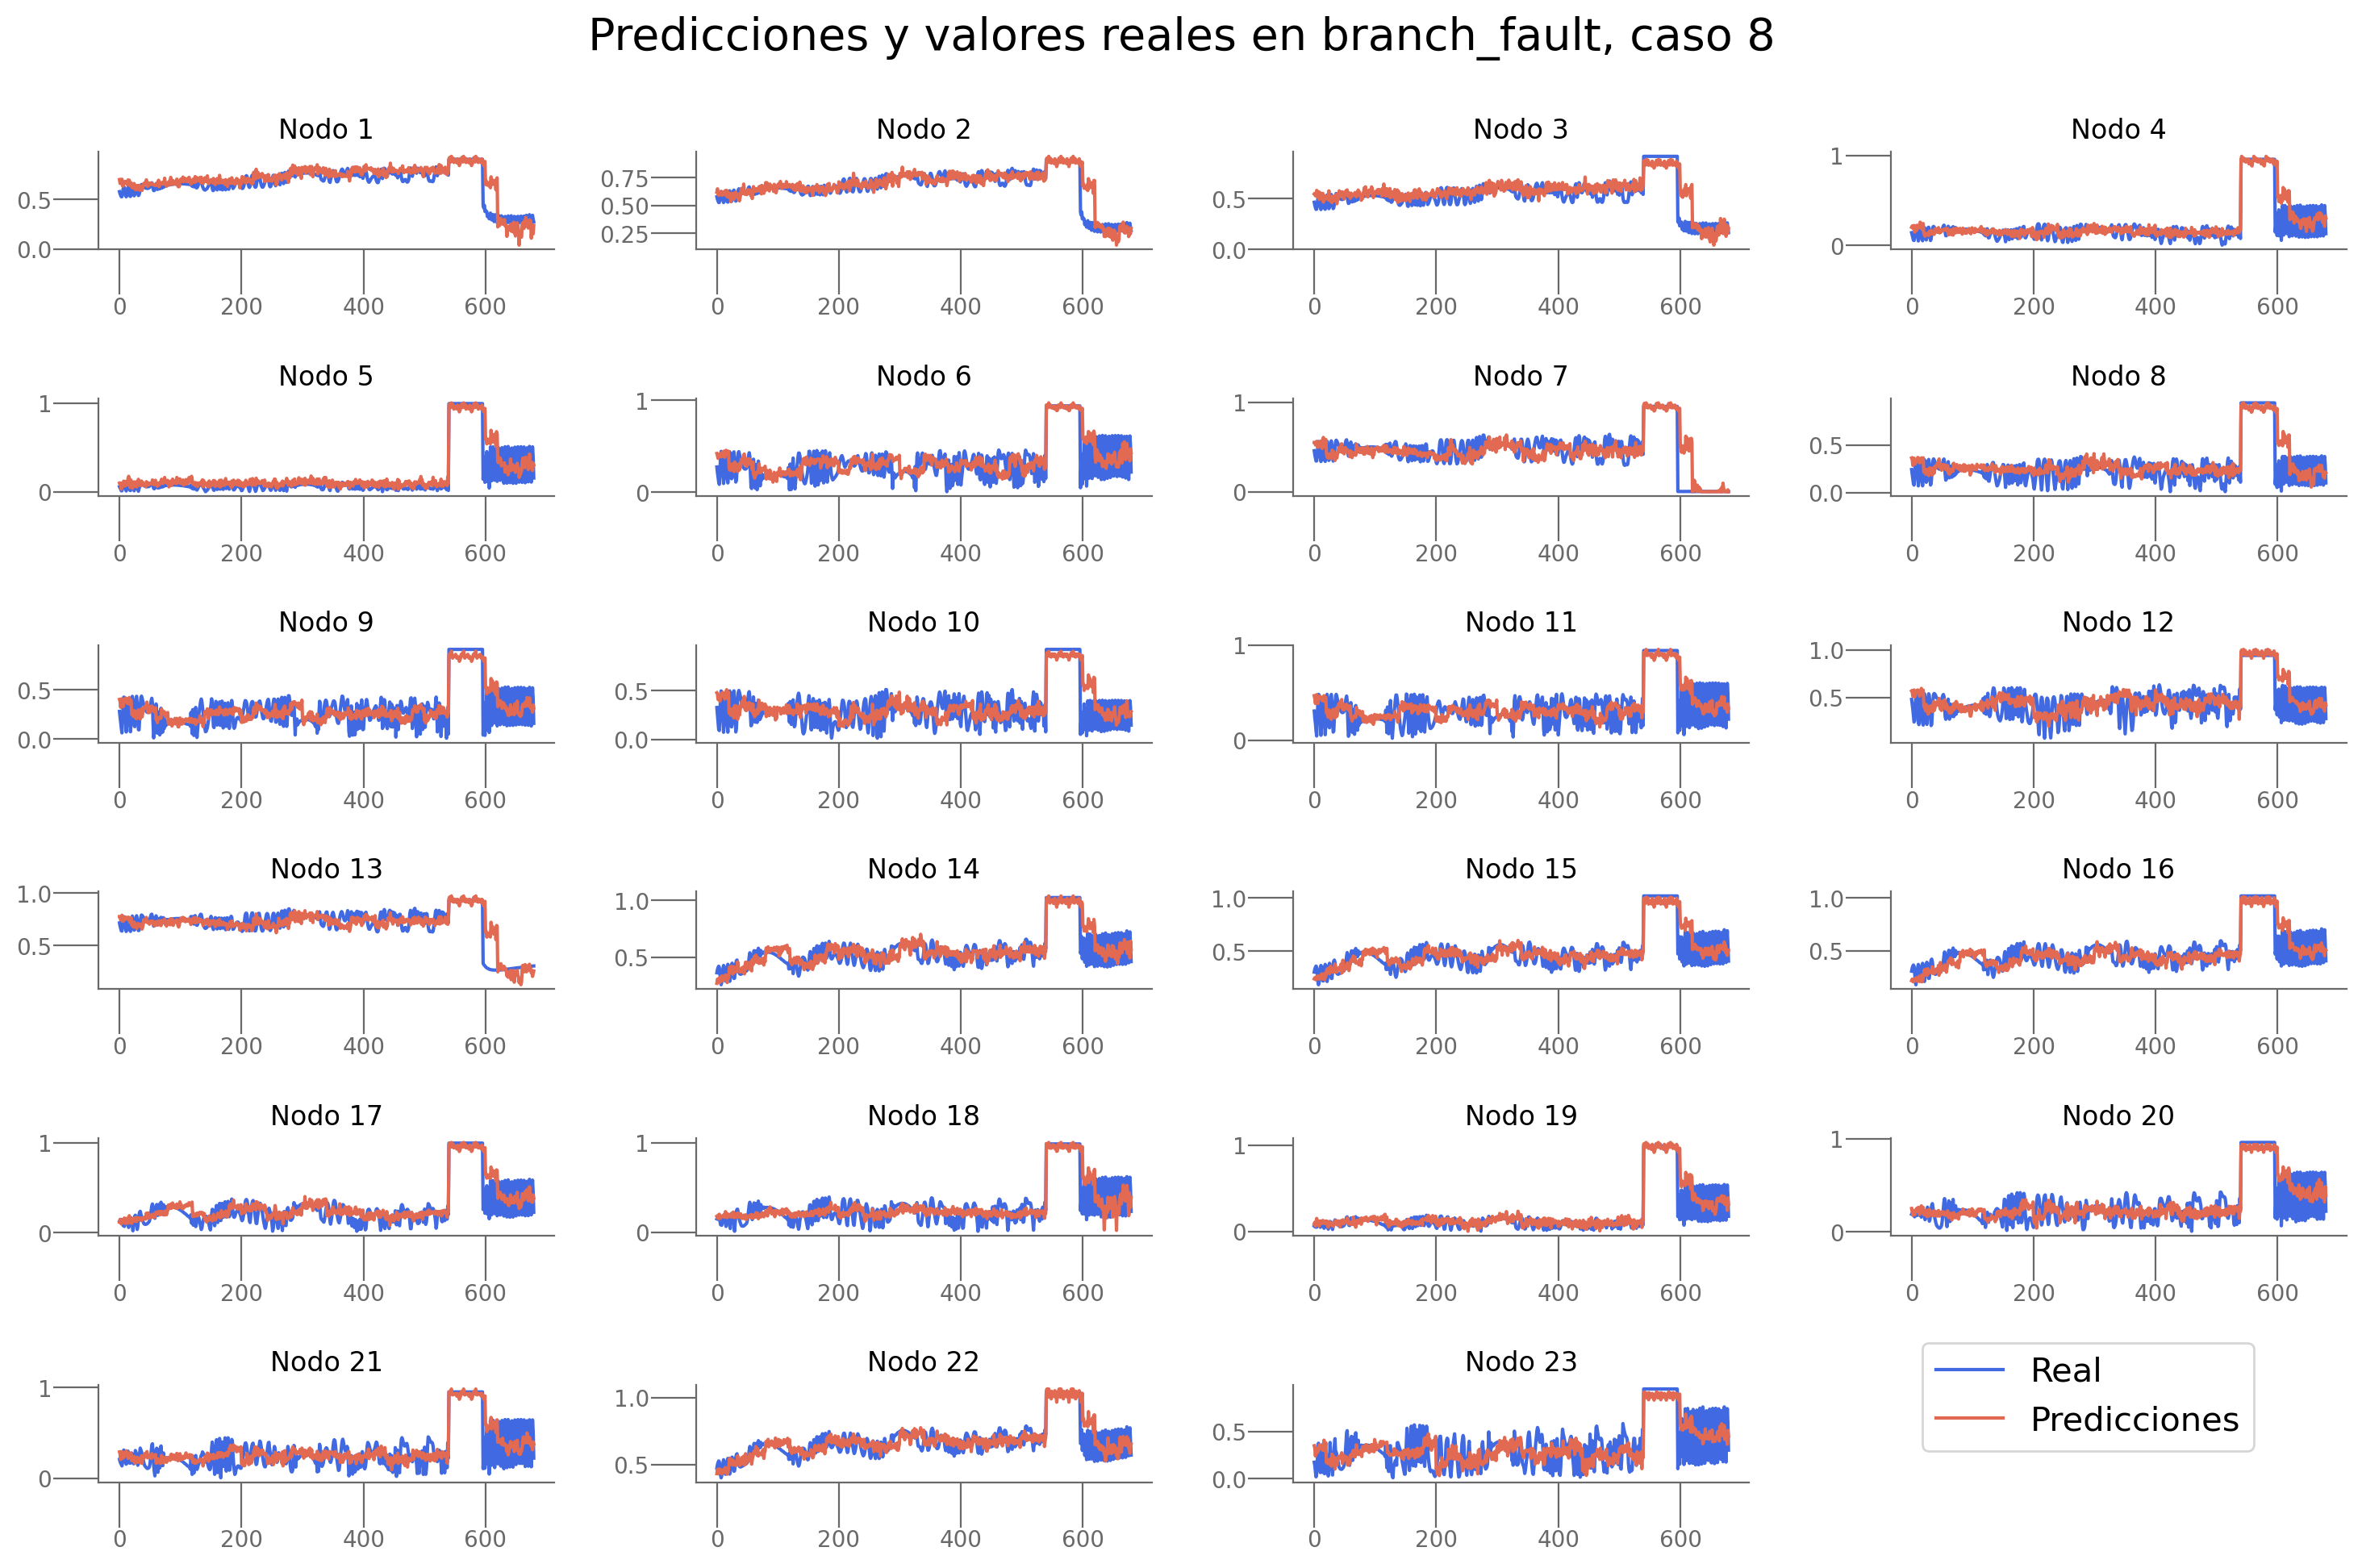

In [46]:
plot_predictions(predictions_brf_ajuste, real_brf_ajuste, n_target, 8, n_div_brf, problem_brf)

In [38]:
path_save_experiment_brf = results_save_path+f"/{problem_brf}"+ f"/ajustes/{name_model}_results.csv"
resultados_brf.to_csv(path_save_experiment_brf, index=False)

In [39]:
trainer_brf.save_model(path_save_experiment=path_save_experiment_brf, params=params_brf)


==================== GUARDANDO RESULTADOS ===================

         Modelo                                             Params  \
0          LSTM                                                NaN   
1  LSTM_NOBATCH                                                NaN   
2   DyGrEncoder              {'aggr': 'add', 'conv': 1, 'lstm': 1}   
3     MPNN_LSTM                {'hidden_size': 64, 'dropout': 0.2}   
4         AGCRN                              {'hidden': 5, 'K': 2}   
5         DCRNN                                     {'hidden': 60}   
6        MSTGCN  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_...   

                      Fichero_resultados_experimento  Loss_tst    R2_tst  \
0                                                NaN  0.023216  0.608045   
1                                                NaN  0.021628 -1.528487   
2  ./results/branch_fault/ajustes/DryGrEncoder_re...  0.020580 -1.669938   
3  ./results/branch_fault/ajustes/MPNNLSTM_result...  0.021592 -1.56513

### Branch trip

In [40]:
problem_brt = "branch_trip"
dataset_brt, situations_brt = loader.get_dataset( target= 20, intro=100, step=20, one_ts_per_situation=False, start = 1, type=problem_brt)




Number of situations:  549
Number of timestamps:  800
Number of situations of the selected type:  101


In [41]:
n_div_brt = loader.div
n_nodes =dataset_brt.features[0].shape[0]
n_target = dataset_brt.targets[0].shape[1]
n_features = dataset_brt[0].x.shape[1]
hidden_size =32
dropout = 0.5

num_early_stop = 0
num_epochs = 30
lr = 0.01

#### Sencilla 

In [41]:

device =  torch.device("cpu")
model_brt = MSTGCNModel(name="MSTGCN", node_features=n_features, node_count=n_nodes, n_target=n_target, nb_block=2, k=2, nb_chev_filter = 2, nb_time_filter =2, time_strides = 2)


trainer_brt = TrainerMSTGCN(model_brt, dataset_brt,device, f"./results/{problem_brt}", dataloader_params2)


losses,eval_losses, r2scores  = trainer_brt.train(num_epochs=num_epochs, steps=50, num_early_stop=num_early_stop)





==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505
AQuissss

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.1916 | Eval Loss: 0.0999 | Eval R2: -68.3384 | LR: 0.0010 | 
Epoch 2/30 | Train Loss: 0.0910 | Eval Loss: 0.0937 | Eval R2: -63.6335 | LR: 0.0010 | 
Epoch 3/30 | Train Loss: 0.0903 | Eval Loss: 0.0938 | Eval R2: -63.9079 | LR: 0.0010 | 
Epoch 4/30 | Train Loss: 0.0902 | Eval Loss: 0.0939 | Eval R2: -64.1165 | LR: 0.0010 | 
Epoch 5/30 | Train Loss: 0.0902 | Eval Loss: 0.0940 | Eval R2: -64.2450 | LR: 0.0010 | 
Epoch 6/30 | Train Loss: 0.0902 | Eval Loss: 0.0940 | Eval R2: -64.3195 | LR: 0.0010 | 
Epoch 7/30 | Train Loss: 0.0902 | Eval Loss: 0.0940 | Eval R2: -64.3603 | LR: 0.0010 | 
Epoch 8/30 | Train Loss: 0.0902 | Eval Loss: 0.0940 | Eval R2: -64.3798 | LR: 0.0010 | 
Epoch 9/30 | Train Loss: 0.0902 | Eval Loss: 0.0940 | Eval R2: -64.3857 | LR: 0.0010 | 
Epoch 10/30 | Train Loss: 0

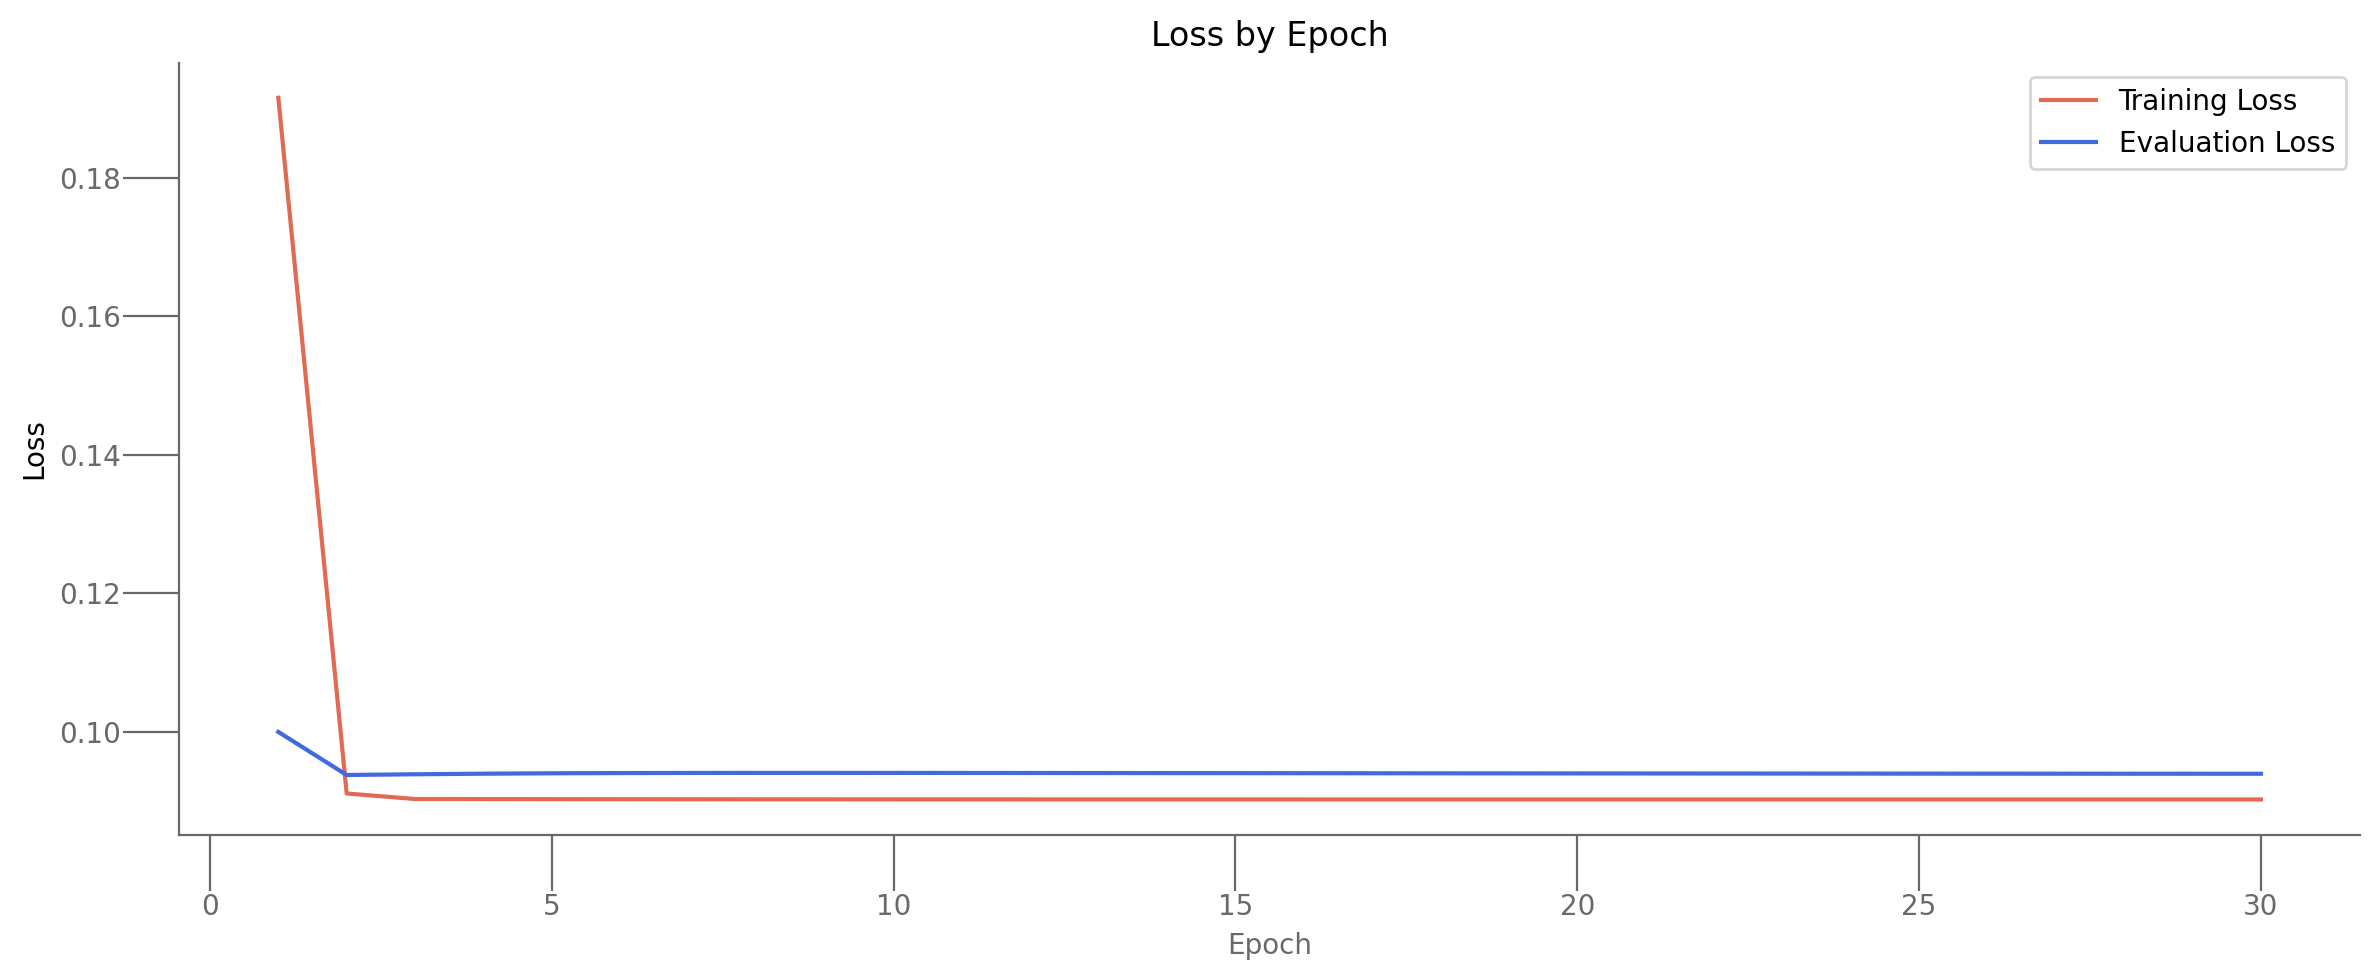


==================== TEST INFO ===================

preds:  (1, 23, 20)
test loss: 0.103355, test r2score -70.255618


In [42]:
plot_training_and_eval_losses(np.array(losses), np.array(eval_losses), num_epochs, format_plot)
losses_tst, r2score_tst, loss_nodes, predictions_brt, real_brt = trainer_brt.test()

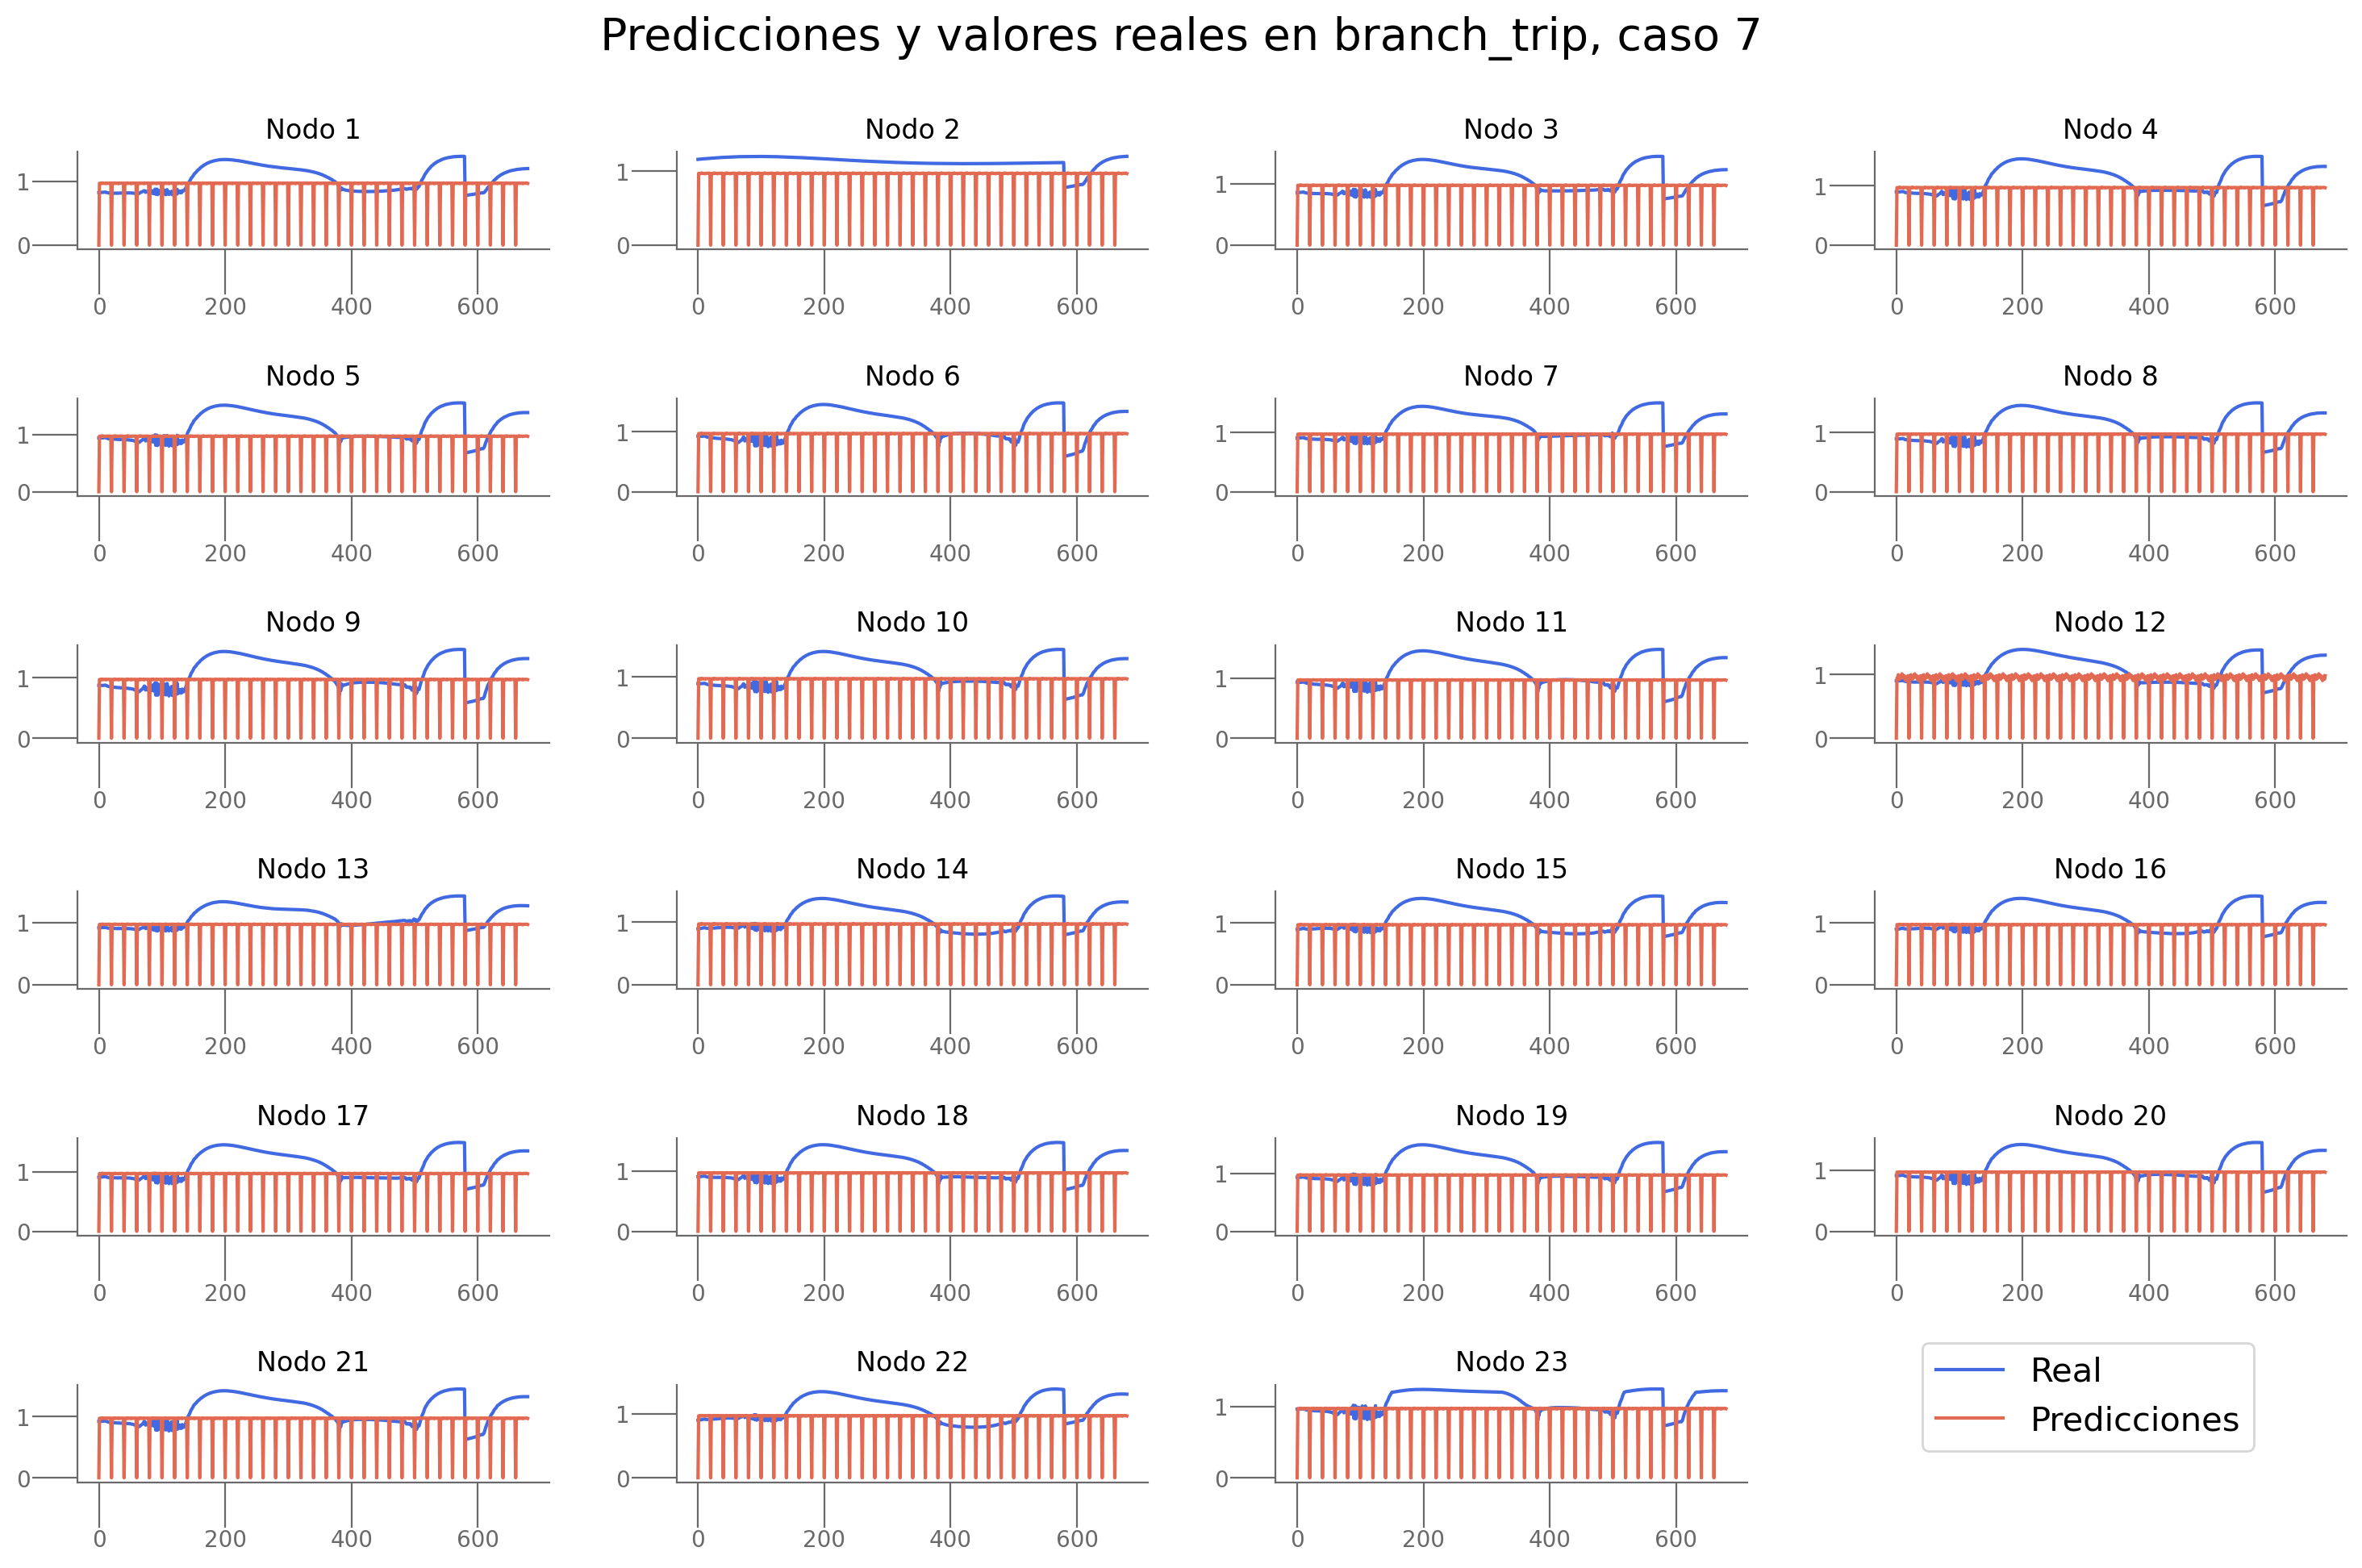

In [43]:
plot_predictions(predictions_brt, real_brt, n_target, 7, n_div_brt, problem_brt)

#### Ajuste de parámetros 

In [42]:


num_epochs = 100
num_early_stop = 10

trainer_brt,params_brt,resultados_final_brt, resultados_brt = entrenar_y_evaluar_modelos_mstgcn(param_grid, dataset_brt, dataloader_params2, num_early_stop=num_early_stop, num_epochs=num_epochs, problem=problem_brt)

  0%|          | 0/54 [00:00<?, ?it/s]

Entrenando modelo con nb_block=1, nb_chev_filter=2, nb_time_filter=2, time_strides=2, hidden=50

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505

==================== TRAIN INFO ===================

Epoch 1/100 | Train Loss: 0.4633 | Eval Loss: 0.2820 | Eval R2: -221.6480 | LR: 0.0010 | 
Epoch 2/100 | Train Loss: 0.2023 | Eval Loss: 0.1552 | Eval R2: -111.1310 | LR: 0.0010 | 
Epoch 3/100 | Train Loss: 0.1356 | Eval Loss: 0.1004 | Eval R2: -66.0496 | LR: 0.0010 | 
Epoch 4/100 | Train Loss: 0.0766 | Eval Loss: 0.0715 | Eval R2: -41.7127 | LR: 0.0010 | 
Epoch 5/100 | Train Loss: 0.0638 | Eval Loss: 0.0593 | Eval R2: -32.0857 | LR: 0.0010 | 
Epoch 6/100 | Train Loss: 0.0542 | Eval Loss: 0.0540 | Eval R2: -27.7802 | LR: 0.0010 | 
Epoch 7/100 | Train Loss: 0.0497 | Eval Loss: 0.0501 | Eval R2: -24.3710 | LR: 0.0010 | 
Epoch 8/100 | Train Loss: 0.0467 | Eval Loss: 0.0477 | Eval R2: -22.3016 | LR: 0.0010 | 
Epoch 9/100 | Trai

  2%|▏         | 1/54 [07:16<6:25:24, 436.30s/it]

preds:  (1, 23, 20)
test loss: 0.046781, test R2 score: -19.158192
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 50, 'time_strides': 2, 'loss_final': 0.03954848274588585, 'r2_eval_final': -17.593339920043945, 'loss_eval_final': 0.04155992716550827, 'r2_test': -19.15819193396587, 'loss_test': 0.04678088799118996, 'loss_nodes': [0.03270538151264191, 0.029241586104035378, 0.03888066112995148, 0.05607134848833084, 0.0662606880068779, 0.06270540505647659, 0.04831063374876976, 0.05724913254380226, 0.06506698578596115, 0.04328002408146858, 0.06091795116662979, 0.046382587403059006, 0.0280167069286108, 0.041187066584825516, 0.03357690945267677, 0.03360826149582863, 0.05344177782535553, 0.054060496389865875, 0.05962114408612251, 0.0426727794110775, 0.055854711681604385, 0.03343678638339043, 0.03341146558523178]}
Entrenando modelo con nb_block=1, nb_chev_filter=2, nb_time_filter=2, time_strides=2, hidden=80

==================== DATASET INFO =======

  4%|▎         | 2/54 [14:46<6:25:18, 444.59s/it]

preds:  (1, 23, 20)
test loss: 0.046770, test R2 score: -19.157663
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 80, 'time_strides': 2, 'loss_final': 0.0395442396402359, 'r2_eval_final': -17.593669891357422, 'loss_eval_final': 0.04156486317515373, 'r2_test': -19.157663126777745, 'loss_test': 0.04676974564790726, 'loss_nodes': [0.03270575776696205, 0.02924257144331932, 0.03888890519738197, 0.05607319623231888, 0.06626483798027039, 0.06270630657672882, 0.04831404983997345, 0.05725081264972687, 0.0649205818772316, 0.043266646564006805, 0.060917895287275314, 0.04627465829253197, 0.028011439368128777, 0.04118957743048668, 0.03356817737221718, 0.033614255487918854, 0.05344034358859062, 0.05406277999281883, 0.05961546674370766, 0.04267452657222748, 0.055875662714242935, 0.03343264013528824, 0.0333930142223835]}
Entrenando modelo con nb_block=1, nb_chev_filter=2, nb_time_filter=2, time_strides=2, hidden=100

==================== DATASET INFO =====

  6%|▌         | 3/54 [22:18<6:20:39, 447.82s/it]

preds:  (1, 23, 20)
test loss: 0.046781, test R2 score: -19.158097
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 100, 'time_strides': 2, 'loss_final': 0.03954802453517914, 'r2_eval_final': -17.593149185180664, 'loss_eval_final': 0.04155987873673439, 'r2_test': -19.158096562949332, 'loss_test': 0.0467807799577713, 'loss_nodes': [0.03270545229315758, 0.029241763055324554, 0.03887949883937836, 0.0560716837644577, 0.0662614107131958, 0.06270553916692734, 0.04831124469637871, 0.05724908411502838, 0.0650709718465805, 0.04327620565891266, 0.06091858819127083, 0.046382807195186615, 0.028016183525323868, 0.04118755832314491, 0.033576399087905884, 0.03360700607299805, 0.053441744297742844, 0.054060861468315125, 0.059620603919029236, 0.042671140283346176, 0.05585440993309021, 0.03343668580055237, 0.03341120854020119]}
Entrenando modelo con nb_block=1, nb_chev_filter=2, nb_time_filter=2, time_strides=5, hidden=50

==================== DATASET INFO ===

  7%|▋         | 4/54 [29:12<6:02:02, 434.45s/it]

preds:  (1, 23, 20)
test loss: 0.312478, test R2 score: -257.029355
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 50, 'time_strides': 5, 'loss_final': 0.2886258661746979, 'r2_eval_final': -233.60989379882812, 'loss_eval_final': 0.29344961047172546, 'r2_test': -257.0293547017673, 'loss_test': 0.3124779462814331, 'loss_nodes': [0.28308817744255066, 0.2847968339920044, 0.2934965193271637, 0.32013455033302307, 0.34901997447013855, 0.3185114562511444, 0.32574182748794556, 0.31804707646369934, 0.3049849569797516, 0.316142737865448, 0.3191605806350708, 0.29901912808418274, 0.3084627687931061, 0.3101878762245178, 0.31376388669013977, 0.3158048391342163, 0.32561954855918884, 0.3213687837123871, 0.3392208516597748, 0.31311386823654175, 0.3118131458759308, 0.3070565462112427, 0.288437157869339]}
Entrenando modelo con nb_block=1, nb_chev_filter=2, nb_time_filter=2, time_strides=5, hidden=80

==================== DATASET INFO ===================

Train

  9%|▉         | 5/54 [37:23<6:11:25, 454.80s/it]

preds:  (1, 23, 20)
test loss: 0.312478, test R2 score: -257.029356
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 80, 'time_strides': 5, 'loss_final': 0.2886258661746979, 'r2_eval_final': -233.60989379882812, 'loss_eval_final': 0.29344961047172546, 'r2_test': -257.0293558657043, 'loss_test': 0.3124779462814331, 'loss_nodes': [0.28308814764022827, 0.2847968339920044, 0.2934965491294861, 0.3201345205307007, 0.34902000427246094, 0.3185114860534668, 0.32574185729026794, 0.31804707646369934, 0.3049849569797516, 0.3161427676677704, 0.3191605806350708, 0.29901909828186035, 0.3084627687931061, 0.3101878762245178, 0.31376388669013977, 0.3158048093318939, 0.32561954855918884, 0.3213687837123871, 0.3392208516597748, 0.31311386823654175, 0.3118131458759308, 0.30705657601356506, 0.288437157869339]}
Entrenando modelo con nb_block=1, nb_chev_filter=2, nb_time_filter=2, time_strides=5, hidden=100

==================== DATASET INFO ===================

Tra

 11%|█         | 6/54 [55:13<8:51:11, 663.99s/it]

preds:  (1, 23, 20)
test loss: 0.312478, test R2 score: -257.029355
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 100, 'time_strides': 5, 'loss_final': 0.2886258661746979, 'r2_eval_final': -233.60989379882812, 'loss_eval_final': 0.29344961047172546, 'r2_test': -257.0293547531886, 'loss_test': 0.3124779462814331, 'loss_nodes': [0.28308817744255066, 0.2847968339920044, 0.2934965193271637, 0.3201345205307007, 0.34901997447013855, 0.3185114562511444, 0.32574182748794556, 0.31804707646369934, 0.3049849569797516, 0.316142737865448, 0.3191605806350708, 0.29901912808418274, 0.3084627687931061, 0.3101878762245178, 0.31376391649246216, 0.3158048391342163, 0.32561954855918884, 0.3213688135147095, 0.3392208516597748, 0.31311386823654175, 0.3118131160736084, 0.30705660581588745, 0.2884371280670166]}
Entrenando modelo con nb_block=1, nb_chev_filter=2, nb_time_filter=2, time_strides=10, hidden=50

==================== DATASET INFO ===================

Tr

 13%|█▎        | 7/54 [1:05:18<8:25:03, 644.76s/it]

preds:  (1, 23, 20)
test loss: 0.056850, test R2 score: -28.156116
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 50, 'time_strides': 10, 'loss_final': 0.06634464114904404, 'r2_eval_final': -25.84861183166504, 'loss_eval_final': 0.049941156059503555, 'r2_test': -28.15611566476074, 'loss_test': 0.05684950202703476, 'loss_nodes': [0.039610572159290314, 0.036496374756097794, 0.0461125373840332, 0.06392733752727509, 0.07546880096197128, 0.06902150809764862, 0.05712071433663368, 0.06558161973953247, 0.06959888339042664, 0.06294922530651093, 0.06851884722709656, 0.05299431458115578, 0.03960653021931648, 0.049393169581890106, 0.053040165454149246, 0.052934445440769196, 0.0636085495352745, 0.0621819905936718, 0.07091312110424042, 0.06225167214870453, 0.06276363134384155, 0.04390774294734001, 0.03953663259744644]}
Entrenando modelo con nb_block=1, nb_chev_filter=2, nb_time_filter=2, time_strides=10, hidden=80

==================== DATASET INFO =====

 15%|█▍        | 8/54 [1:12:58<7:29:13, 585.94s/it]

preds:  (1, 23, 20)
test loss: 0.056856, test R2 score: -28.187159
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 80, 'time_strides': 10, 'loss_final': 0.06640826910734177, 'r2_eval_final': -25.879684448242188, 'loss_eval_final': 0.049963369965553284, 'r2_test': -28.187158573749105, 'loss_test': 0.0568559393286705, 'loss_nodes': [0.03964345157146454, 0.036530427634716034, 0.04614630714058876, 0.06391621381044388, 0.07550739496946335, 0.06843583285808563, 0.05715884268283844, 0.0656166672706604, 0.06962985545396805, 0.06298451870679855, 0.06855347007513046, 0.05302787199616432, 0.039645563811063766, 0.049423523247241974, 0.05307747423648834, 0.05297230929136276, 0.0636458769440651, 0.06221842020750046, 0.07095182687044144, 0.062286488711833954, 0.06279788911342621, 0.04394541680812836, 0.03957090899348259]}
Entrenando modelo con nb_block=1, nb_chev_filter=2, nb_time_filter=2, time_strides=10, hidden=100

==================== DATASET INFO ===

 17%|█▋        | 9/54 [1:22:33<7:16:49, 582.42s/it]

preds:  (1, 23, 20)
test loss: 0.056823, test R2 score: -28.148928
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 100, 'time_strides': 10, 'loss_final': 0.06633200496435165, 'r2_eval_final': -25.843883514404297, 'loss_eval_final': 0.04992067813873291, 'r2_test': -28.148928411500354, 'loss_test': 0.05682267248630524, 'loss_nodes': [0.03960154950618744, 0.03648789972066879, 0.046103864908218384, 0.06388672441244125, 0.07546177506446838, 0.06861842423677444, 0.05711345747113228, 0.06557323038578033, 0.06958910822868347, 0.06294102221727371, 0.06851030886173248, 0.05298547446727753, 0.039599716663360596, 0.049381323158741, 0.05303264409303665, 0.05292709544301033, 0.06360099464654922, 0.0621742345392704, 0.07090611010789871, 0.06224321573972702, 0.06275496631860733, 0.043900422751903534, 0.0395280085504055]}
Entrenando modelo con nb_block=1, nb_chev_filter=4, nb_time_filter=4, time_strides=2, hidden=50

==================== DATASET INFO =======

 19%|█▊        | 10/54 [1:31:20<6:54:44, 565.55s/it]

preds:  (1, 23, 20)
test loss: 0.228614, test R2 score: -196.859428
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 50, 'time_strides': 2, 'loss_final': 0.21253831684589386, 'r2_eval_final': -177.83651733398438, 'loss_eval_final': 0.21519377827644348, 'r2_test': -196.8594281289513, 'loss_test': 0.2286142259836197, 'loss_nodes': [0.21147102117538452, 0.21424394845962524, 0.21687468886375427, 0.23160132765769958, 0.2522056996822357, 0.22857563197612762, 0.23888404667377472, 0.22878606617450714, 0.2164149284362793, 0.2282658815383911, 0.22941642999649048, 0.21853399276733398, 0.23280592262744904, 0.23062148690223694, 0.2307971715927124, 0.23295532166957855, 0.2361222207546234, 0.23475831747055054, 0.24455749988555908, 0.22683441638946533, 0.2259340137243271, 0.22950764000415802, 0.21795935928821564]}
Entrenando modelo con nb_block=1, nb_chev_filter=4, nb_time_filter=4, time_strides=2, hidden=80

==================== DATASET INFO ===============

 20%|██        | 11/54 [1:43:59<7:27:37, 624.60s/it]

preds:  (1, 23, 20)
test loss: 0.228614, test R2 score: -196.859426
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 80, 'time_strides': 2, 'loss_final': 0.21253831684589386, 'r2_eval_final': -177.83651733398438, 'loss_eval_final': 0.21519380807876587, 'r2_test': -196.85942630150237, 'loss_test': 0.2286142259836197, 'loss_nodes': [0.21147096157073975, 0.21424388885498047, 0.21687465906143188, 0.2316012978553772, 0.25220564007759094, 0.2285754680633545, 0.2388840764760971, 0.2287861853837967, 0.21641486883163452, 0.2282658815383911, 0.22941631078720093, 0.21853405237197876, 0.23280595242977142, 0.23062138259410858, 0.23079721629619598, 0.23295533657073975, 0.2361222803592682, 0.23475834727287292, 0.24455730617046356, 0.22683444619178772, 0.2259339839220047, 0.2295076698064804, 0.21795929968357086]}
Entrenando modelo con nb_block=1, nb_chev_filter=4, nb_time_filter=4, time_strides=2, hidden=100

==================== DATASET INFO ===============

 22%|██▏       | 12/54 [2:03:35<9:14:40, 792.39s/it]

preds:  (1, 23, 20)
test loss: 0.228614, test R2 score: -196.859464
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 100, 'time_strides': 2, 'loss_final': 0.21253837645053864, 'r2_eval_final': -177.83653259277344, 'loss_eval_final': 0.21519385278224945, 'r2_test': -196.85946422856424, 'loss_test': 0.22861431539058685, 'loss_nodes': [0.2114710509777069, 0.21424400806427002, 0.21687468886375427, 0.23160138726234436, 0.25220581889152527, 0.22857558727264404, 0.2388841211795807, 0.2287861406803131, 0.21641504764556885, 0.2282659411430359, 0.2294166088104248, 0.21853405237197876, 0.23280596733093262, 0.2306215763092041, 0.23079726099967957, 0.23295539617538452, 0.2361222803592682, 0.23475845158100128, 0.24455758929252625, 0.2268344759941101, 0.22593413293361664, 0.2295076996088028, 0.21795937418937683]}
Entrenando modelo con nb_block=1, nb_chev_filter=4, nb_time_filter=4, time_strides=5, hidden=50

==================== DATASET INFO ===============

 24%|██▍       | 13/54 [2:14:45<8:36:04, 755.22s/it]

preds:  (1, 23, 20)
test loss: 0.343962, test R2 score: -296.884656
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 50, 'time_strides': 5, 'loss_final': 0.3202047348022461, 'r2_eval_final': -269.9933166503906, 'loss_eval_final': 0.32487207651138306, 'r2_test': -296.88465608858553, 'loss_test': 0.3439615070819855, 'loss_nodes': [0.31719714403152466, 0.3216118812561035, 0.32617467641830444, 0.34874284267425537, 0.37798431515693665, 0.3440479636192322, 0.3595525622367859, 0.34511852264404297, 0.3267515301704407, 0.34417855739593506, 0.34580668807029724, 0.3294029235839844, 0.34973129630088806, 0.3455359935760498, 0.3478415310382843, 0.35076799988746643, 0.3560773432254791, 0.35206201672554016, 0.3684738278388977, 0.34195685386657715, 0.34015557169914246, 0.3454410433769226, 0.3265019357204437]}
Entrenando modelo con nb_block=1, nb_chev_filter=4, nb_time_filter=4, time_strides=5, hidden=80

==================== DATASET INFO ===================



 26%|██▌       | 14/54 [2:22:24<7:23:58, 665.97s/it]

preds:  (1, 23, 20)
test loss: 0.343961, test R2 score: -296.884556
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 80, 'time_strides': 5, 'loss_final': 0.32020461559295654, 'r2_eval_final': -269.99322509765625, 'loss_eval_final': 0.32487189769744873, 'r2_test': -296.88455588291106, 'loss_test': 0.34396126866340637, 'loss_nodes': [0.3171970248222351, 0.32161176204681396, 0.3261745870113373, 0.3487425148487091, 0.377983957529068, 0.3440476953983307, 0.3595523536205292, 0.34511828422546387, 0.3267512023448944, 0.3441784083843231, 0.3458064794540405, 0.3294025957584381, 0.34973111748695374, 0.3455357253551483, 0.3478412628173828, 0.35076767206192017, 0.35607707500457764, 0.35206177830696106, 0.36847352981567383, 0.34195664525032043, 0.3401552736759186, 0.3454408645629883, 0.32650190591812134]}
Entrenando modelo con nb_block=1, nb_chev_filter=4, nb_time_filter=4, time_strides=5, hidden=100

==================== DATASET INFO ===================



 28%|██▊       | 15/54 [2:29:34<6:26:28, 594.57s/it]

preds:  (1, 23, 20)
test loss: 0.343961, test R2 score: -296.884639
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 100, 'time_strides': 5, 'loss_final': 0.3202047049999237, 'r2_eval_final': -269.9932861328125, 'loss_eval_final': 0.32487207651138306, 'r2_test': -296.8846387612352, 'loss_test': 0.3439614772796631, 'loss_nodes': [0.31719714403152466, 0.3216118812561035, 0.32617467641830444, 0.3487427234649658, 0.3779842257499695, 0.34404799342155457, 0.3595525324344635, 0.3451184928417206, 0.3267514705657959, 0.34417852759361267, 0.34580671787261963, 0.3294028639793396, 0.34973129630088806, 0.34553587436676025, 0.3478415310382843, 0.35076799988746643, 0.35607731342315674, 0.3520619869232178, 0.36847373843193054, 0.34195685386657715, 0.3401554524898529, 0.3454410433769226, 0.3265019357204437]}
Entrenando modelo con nb_block=1, nb_chev_filter=4, nb_time_filter=4, time_strides=10, hidden=50

==================== DATASET INFO ===================



 30%|██▉       | 16/54 [2:36:33<5:43:13, 541.92s/it]

preds:  (1, 23, 20)
test loss: 0.008835, test R2 score: -3.841134
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 50, 'time_strides': 10, 'loss_final': 0.008083699271082878, 'r2_eval_final': -3.3894832134246826, 'loss_eval_final': 0.007424598094075918, 'r2_test': -3.841134057819811, 'loss_test': 0.008834817446768284, 'loss_nodes': [0.004401030950248241, 0.0035723622422665358, 0.005771759897470474, 0.010780878365039825, 0.012514336034655571, 0.014272821135818958, 0.00800315011292696, 0.01038402784615755, 0.013083687983453274, 0.009879853576421738, 0.01242834236472845, 0.007987426593899727, 0.004060942213982344, 0.006620536558330059, 0.006840127054601908, 0.007376488763839006, 0.009475122205913067, 0.010264609009027481, 0.010845781303942204, 0.011062844656407833, 0.011103625409305096, 0.004717158153653145, 0.0077538699842989445]}
Entrenando modelo con nb_block=1, nb_chev_filter=4, nb_time_filter=4, time_strides=10, hidden=80

=================

 31%|███▏      | 17/54 [2:44:48<5:25:28, 527.80s/it]

preds:  (1, 23, 20)
test loss: 0.008835, test R2 score: -3.841134
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 80, 'time_strides': 10, 'loss_final': 0.008083696477115154, 'r2_eval_final': -3.3895034790039062, 'loss_eval_final': 0.007424603682011366, 'r2_test': -3.841133738375001, 'loss_test': 0.008834795095026493, 'loss_nodes': [0.004401035141199827, 0.0035723692271858454, 0.005771750584244728, 0.010780884884297848, 0.012514354661107063, 0.01427282951772213, 0.008003171533346176, 0.0103840297088027, 0.013083693571388721, 0.009879853576421738, 0.012428352609276772, 0.007987436838448048, 0.0040609389543533325, 0.006619957275688648, 0.006840131711214781, 0.0073764934204518795, 0.00947511661797762, 0.010264613665640354, 0.010845775716006756, 0.011062846519052982, 0.011103634722530842, 0.004717150237411261, 0.0077538806945085526]}
Entrenando modelo con nb_block=1, nb_chev_filter=4, nb_time_filter=4, time_strides=10, hidden=100

===============

 33%|███▎      | 18/54 [2:56:37<5:49:16, 582.13s/it]

preds:  (1, 23, 20)
test loss: 0.008835, test R2 score: -3.841115
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 100, 'time_strides': 10, 'loss_final': 0.008083711378276348, 'r2_eval_final': -3.3894858360290527, 'loss_eval_final': 0.007424586918205023, 'r2_test': -3.841115038269655, 'loss_test': 0.008834776468575, 'loss_nodes': [0.004401032812893391, 0.0035723650362342596, 0.0057717589661479, 0.010780866257846355, 0.012514348141849041, 0.014272814616560936, 0.00800313614308834, 0.01038401573896408, 0.01308367308229208, 0.00987984798848629, 0.012428311631083488, 0.007987418211996555, 0.004060941748321056, 0.006619775667786598, 0.006840130779892206, 0.007376481778919697, 0.009475109167397022, 0.010264609009027481, 0.010845756158232689, 0.01106283813714981, 0.011103601194918156, 0.004717150703072548, 0.007753860671073198]}
Entrenando modelo con nb_block=1, nb_chev_filter=8, nb_time_filter=8, time_strides=2, hidden=50

==================== DATA

 35%|███▌      | 19/54 [3:05:45<5:33:38, 571.95s/it]

preds:  (1, 23, 20)
test loss: 0.170640, test R2 score: -147.255084
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 50, 'time_strides': 2, 'loss_final': 0.15918783843517303, 'r2_eval_final': -133.26087951660156, 'loss_eval_final': 0.16071462631225586, 'r2_test': -147.25508405981137, 'loss_test': 0.1706395149230957, 'loss_nodes': [0.15747186541557312, 0.159674271941185, 0.16175661981105804, 0.17292891442775726, 0.18669374287128448, 0.17075099050998688, 0.17843180894851685, 0.17064151167869568, 0.16147339344024658, 0.1703873574733734, 0.17165736854076385, 0.16329345107078552, 0.17427833378314972, 0.17248311638832092, 0.17207646369934082, 0.1737644225358963, 0.17608694732189178, 0.1742170751094818, 0.18335190415382385, 0.16943293809890747, 0.16908049583435059, 0.1713199019432068, 0.1634552925825119]}
Entrenando modelo con nb_block=1, nb_chev_filter=8, nb_time_filter=8, time_strides=2, hidden=80

==================== DATASET INFO ===============

 37%|███▋      | 20/54 [3:14:47<5:18:59, 562.91s/it]

preds:  (1, 23, 20)
test loss: 0.170639, test R2 score: -147.255098
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 80, 'time_strides': 2, 'loss_final': 0.15918786823749542, 'r2_eval_final': -133.26095581054688, 'loss_eval_final': 0.1607147455215454, 'r2_test': -147.25509754825862, 'loss_test': 0.17063948512077332, 'loss_nodes': [0.15747196972370148, 0.15967442095279694, 0.1617567241191864, 0.17292894423007965, 0.1866934895515442, 0.17075110971927643, 0.17843173444271088, 0.17064139246940613, 0.16147345304489136, 0.17038732767105103, 0.17165741324424744, 0.16329340636730194, 0.17427818477153778, 0.17248333990573883, 0.17207640409469604, 0.17376434803009033, 0.17608687281608582, 0.17421697080135345, 0.1833518147468567, 0.16943295300006866, 0.16908051073551178, 0.1713198721408844, 0.16345536708831787]}
Entrenando modelo con nb_block=1, nb_chev_filter=8, nb_time_filter=8, time_strides=2, hidden=100

==================== DATASET INFO ===========

 39%|███▉      | 21/54 [3:24:03<5:08:29, 560.90s/it]

preds:  (1, 23, 20)
test loss: 0.170639, test R2 score: -147.255089
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 100, 'time_strides': 2, 'loss_final': 0.15918785333633423, 'r2_eval_final': -133.2609405517578, 'loss_eval_final': 0.16071471571922302, 'r2_test': -147.25508939698074, 'loss_test': 0.17063945531845093, 'loss_nodes': [0.1574719399213791, 0.15967439115047455, 0.1617567092180252, 0.17292891442775726, 0.18669332563877106, 0.17075100541114807, 0.17843171954154968, 0.17064142227172852, 0.1614733636379242, 0.17038728296756744, 0.17165735363960266, 0.16329337656497955, 0.17427821457386017, 0.1724831610918045, 0.17207635939121246, 0.17376431822776794, 0.17608685791492462, 0.17421692609786987, 0.18335166573524475, 0.1694328933954239, 0.1690804809331894, 0.17131991684436798, 0.16345539689064026]}
Entrenando modelo con nb_block=1, nb_chev_filter=8, nb_time_filter=8, time_strides=5, hidden=50

==================== DATASET INFO =============

 41%|████      | 22/54 [3:31:57<4:45:13, 534.79s/it]

preds:  (1, 23, 20)
test loss: 0.062842, test R2 score: -51.756339
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 50, 'time_strides': 5, 'loss_final': 0.057701464742422104, 'r2_eval_final': -46.886539459228516, 'loss_eval_final': 0.058418914675712585, 'r2_test': -51.75633886984372, 'loss_test': 0.06284234672784805, 'loss_nodes': [0.055338095873594284, 0.055593278259038925, 0.05807558074593544, 0.06428338587284088, 0.07012517750263214, 0.06511595100164413, 0.06506963819265366, 0.06384508311748505, 0.062103379517793655, 0.06372173875570297, 0.06549479812383652, 0.05984862521290779, 0.0615554004907608, 0.06190935894846916, 0.06251098960638046, 0.06346065551042557, 0.06546420603990555, 0.06473549455404282, 0.06858915090560913, 0.06416421383619308, 0.06382857263088226, 0.06083611771464348, 0.059704963117837906]}
Entrenando modelo con nb_block=1, nb_chev_filter=8, nb_time_filter=8, time_strides=5, hidden=80

==================== DATASET INFO ====

 43%|████▎     | 23/54 [3:39:40<4:25:15, 513.39s/it]

preds:  (1, 23, 20)
test loss: 0.062842, test R2 score: -51.756349
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 80, 'time_strides': 5, 'loss_final': 0.05770145729184151, 'r2_eval_final': -46.886531829833984, 'loss_eval_final': 0.058418914675712585, 'r2_test': -51.75634888828273, 'loss_test': 0.06284236907958984, 'loss_nodes': [0.055338144302368164, 0.05559331923723221, 0.05807563662528992, 0.0642833486199379, 0.07012525945901871, 0.06511597335338593, 0.06506951153278351, 0.06384503841400146, 0.06210342422127724, 0.06372179836034775, 0.0654948428273201, 0.059848640114068985, 0.06155533343553543, 0.06190953403711319, 0.06251108646392822, 0.06346071511507034, 0.06546417623758316, 0.06473559886217117, 0.06858909875154495, 0.06416427344083786, 0.06382866948843002, 0.060836102813482285, 0.05970493704080582]}
Entrenando modelo con nb_block=1, nb_chev_filter=8, nb_time_filter=8, time_strides=5, hidden=100

==================== DATASET INFO ======

 44%|████▍     | 24/54 [3:48:14<4:16:40, 513.36s/it]

preds:  (1, 23, 20)
test loss: 0.062843, test R2 score: -51.756492
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 100, 'time_strides': 5, 'loss_final': 0.057701561599969864, 'r2_eval_final': -46.886661529541016, 'loss_eval_final': 0.05841909348964691, 'r2_test': -51.75649223037449, 'loss_test': 0.06284259259700775, 'loss_nodes': [0.05533839762210846, 0.055593524128198624, 0.05807576701045036, 0.06428368389606476, 0.07012569159269333, 0.06511630117893219, 0.0650697723031044, 0.06384534388780594, 0.06210361421108246, 0.06372199207544327, 0.06549496203660965, 0.0598488375544548, 0.061555586755275726, 0.06190965324640274, 0.06251130253076553, 0.06346091628074646, 0.06546448916196823, 0.06473595649003983, 0.06858912110328674, 0.06416445970535278, 0.0638287216424942, 0.06083633378148079, 0.059705156832933426]}
Entrenando modelo con nb_block=1, nb_chev_filter=8, nb_time_filter=8, time_strides=10, hidden=50

==================== DATASET INFO ======

 46%|████▋     | 25/54 [3:56:29<4:05:30, 507.96s/it]

preds:  (1, 23, 20)
test loss: 0.010494, test R2 score: -4.781474
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 50, 'time_strides': 10, 'loss_final': 0.008643451146781445, 'r2_eval_final': -4.138988971710205, 'loss_eval_final': 0.00862383097410202, 'r2_test': -4.781473970250872, 'loss_test': 0.01049426756799221, 'loss_nodes': [0.005443336442112923, 0.004527031909674406, 0.007114790380001068, 0.011333146132528782, 0.014549735002219677, 0.015422151423990726, 0.008437965996563435, 0.012054725550115108, 0.014830552041530609, 0.011964394710958004, 0.014995734207332134, 0.009467361494898796, 0.0055252970196306705, 0.008901062421500683, 0.008648541755974293, 0.009143398143351078, 0.011294570751488209, 0.012135363183915615, 0.01399494893848896, 0.012951524928212166, 0.01340461801737547, 0.005831880960613489, 0.009396023117005825]}
Entrenando modelo con nb_block=1, nb_chev_filter=8, nb_time_filter=8, time_strides=10, hidden=80

====================

 48%|████▊     | 26/54 [4:04:12<3:50:45, 494.47s/it]

preds:  (1, 23, 20)
test loss: 0.010494, test R2 score: -4.781367
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 80, 'time_strides': 10, 'loss_final': 0.008643421344459057, 'r2_eval_final': -4.138899803161621, 'loss_eval_final': 0.008623724803328514, 'r2_test': -4.781367185056342, 'loss_test': 0.010494123212993145, 'loss_nodes': [0.005443315487354994, 0.004527000244706869, 0.007114674896001816, 0.011333036236464977, 0.01454962883144617, 0.015421951189637184, 0.008437715470790863, 0.01205463707447052, 0.014830471947789192, 0.011964167468249798, 0.014995651319622993, 0.009467282332479954, 0.0055251955054700375, 0.008900640532374382, 0.008648362010717392, 0.009143213741481304, 0.011294445022940636, 0.012135226279497147, 0.013994703069329262, 0.012951272539794445, 0.01340456958860159, 0.005831806920468807, 0.009395929053425789]}
Entrenando modelo con nb_block=1, nb_chev_filter=8, nb_time_filter=8, time_strides=10, hidden=100

==================

 50%|█████     | 27/54 [4:11:45<3:36:51, 481.92s/it]

preds:  (1, 23, 20)
test loss: 0.010494, test R2 score: -4.781391
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 100, 'time_strides': 10, 'loss_final': 0.008643372915685177, 'r2_eval_final': -4.138908863067627, 'loss_eval_final': 0.008623721078038216, 'r2_test': -4.78139127279988, 'loss_test': 0.010494126938283443, 'loss_nodes': [0.005443156696856022, 0.004526874516159296, 0.007114604581147432, 0.01133314985781908, 0.014549392275512218, 0.015422188676893711, 0.008437901735305786, 0.012054650112986565, 0.01483054831624031, 0.011964039877057076, 0.014995687641203403, 0.00946733821183443, 0.005525288172066212, 0.008900779299438, 0.008648228831589222, 0.009143076837062836, 0.011294483207166195, 0.012134971097111702, 0.013994843699038029, 0.012951242737472057, 0.013404604978859425, 0.005831914488226175, 0.009395967237651348]}
Entrenando modelo con nb_block=2, nb_chev_filter=2, nb_time_filter=2, time_strides=2, hidden=50

==================== DAT

 52%|█████▏    | 28/54 [4:26:42<4:22:49, 606.53s/it]

preds:  (1, 23, 20)
test loss: 0.100908, test R2 score: -67.258562
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 50, 'time_strides': 2, 'loss_final': 0.08991586416959763, 'r2_eval_final': -61.510223388671875, 'loss_eval_final': 0.09307649731636047, 'r2_test': -67.25856180823492, 'loss_test': 0.10090785473585129, 'loss_nodes': [0.08242614567279816, 0.07987687736749649, 0.08928664028644562, 0.10792722553014755, 0.12108726054430008, 0.11324552446603775, 0.10231913626194, 0.10918949544429779, 0.11154242604970932, 0.10666224360466003, 0.11193932592868805, 0.09763410687446594, 0.08487170934677124, 0.09388136118650436, 0.09749290347099304, 0.09758681803941727, 0.10814623534679413, 0.10644446313381195, 0.11603496223688126, 0.10570497065782547, 0.10604342073202133, 0.08863221853971481, 0.08290448039770126]}
Entrenando modelo con nb_block=2, nb_chev_filter=2, nb_time_filter=2, time_strides=2, hidden=80

==================== DATASET INFO ============

 54%|█████▎    | 29/54 [4:41:55<4:51:01, 698.47s/it]

preds:  (1, 23, 20)
test loss: 0.100907, test R2 score: -67.258443
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 80, 'time_strides': 2, 'loss_final': 0.08991510421037674, 'r2_eval_final': -61.510154724121094, 'loss_eval_final': 0.09307767450809479, 'r2_test': -67.25844250680301, 'loss_test': 0.10090707242488861, 'loss_nodes': [0.08242616057395935, 0.07987691462039948, 0.089286670088768, 0.10792730748653412, 0.12108760327100754, 0.11324558407068253, 0.1023193970322609, 0.10918960720300674, 0.11154241114854813, 0.106662318110466, 0.1119394451379776, 0.09763076156377792, 0.08487197756767273, 0.09386473149061203, 0.0974929928779602, 0.09758699685335159, 0.10814639925956726, 0.10644456744194031, 0.11603521555662155, 0.10570509731769562, 0.1060434952378273, 0.08863236010074615, 0.08290454745292664]}
Entrenando modelo con nb_block=2, nb_chev_filter=2, nb_time_filter=2, time_strides=2, hidden=100

==================== DATASET INFO ================

 56%|█████▌    | 30/54 [4:55:52<4:55:59, 739.97s/it]

preds:  (1, 23, 20)
test loss: 0.100906, test R2 score: -67.257751
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 100, 'time_strides': 2, 'loss_final': 0.08991497755050659, 'r2_eval_final': -61.50940704345703, 'loss_eval_final': 0.09307602792978287, 'r2_test': -67.25775124269538, 'loss_test': 0.10090581327676773, 'loss_nodes': [0.08242622762918472, 0.07987652719020844, 0.08928631246089935, 0.10792607069015503, 0.12108486145734787, 0.11324521154165268, 0.10231706500053406, 0.10918878763914108, 0.11154315620660782, 0.10666139423847198, 0.11193884909152985, 0.09763322025537491, 0.08486964553594589, 0.09385669976472855, 0.09749142825603485, 0.09758523106575012, 0.10814475268125534, 0.10644320398569107, 0.11603303253650665, 0.10570447146892548, 0.10604306310415268, 0.08863062411546707, 0.08290406316518784]}
Entrenando modelo con nb_block=2, nb_chev_filter=2, nb_time_filter=2, time_strides=5, hidden=50

==================== DATASET INFO =========

 57%|█████▋    | 31/54 [5:13:30<5:20:12, 835.32s/it]

preds:  (1, 23, 20)
test loss: 0.048403, test R2 score: -20.069293
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 50, 'time_strides': 5, 'loss_final': 0.04006331041455269, 'r2_eval_final': -18.56279754638672, 'loss_eval_final': 0.042963478714227676, 'r2_test': -20.06929277979888, 'loss_test': 0.048403482884168625, 'loss_nodes': [0.032550811767578125, 0.028892941772937775, 0.03859111666679382, 0.055396582931280136, 0.06487949192523956, 0.062294673174619675, 0.04713140428066254, 0.05744541063904762, 0.06342647969722748, 0.05474536493420601, 0.06056900694966316, 0.04561435431241989, 0.02960381656885147, 0.04032737761735916, 0.04396415501832962, 0.04360467568039894, 0.05436750873923302, 0.05326375365257263, 0.06093365326523781, 0.054287947714328766, 0.05500667542219162, 0.034566666930913925, 0.03181619942188263]}
Entrenando modelo con nb_block=2, nb_chev_filter=2, nb_time_filter=2, time_strides=5, hidden=80

==================== DATASET INFO ==

 59%|█████▉    | 32/54 [5:29:53<5:22:34, 879.74s/it]

preds:  (1, 23, 20)
test loss: 0.047802, test R2 score: -19.851409
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 80, 'time_strides': 5, 'loss_final': 0.03940979018807411, 'r2_eval_final': -18.359107971191406, 'loss_eval_final': 0.042565926909446716, 'r2_test': -19.851409299258975, 'loss_test': 0.04780184105038643, 'loss_nodes': [0.03254769742488861, 0.028033263981342316, 0.037567079067230225, 0.05418079346418381, 0.06345859915018082, 0.060618795454502106, 0.04704437404870987, 0.05690435692667961, 0.06321445107460022, 0.054513443261384964, 0.06048125773668289, 0.04492367431521416, 0.029319338500499725, 0.039955928921699524, 0.043768614530563354, 0.04338608682155609, 0.054158516228199005, 0.05290931835770607, 0.05961858853697777, 0.0536859855055809, 0.05304914340376854, 0.03434975817799568, 0.03175339102745056]}
Entrenando modelo con nb_block=2, nb_chev_filter=2, nb_time_filter=2, time_strides=5, hidden=100

==================== DATASET INFO

 61%|██████    | 33/54 [5:42:07<4:52:33, 835.87s/it]

preds:  (1, 23, 20)
test loss: 0.154095, test R2 score: -115.068467
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 100, 'time_strides': 5, 'loss_final': 0.1393175572156906, 'r2_eval_final': -104.65096282958984, 'loss_eval_final': 0.14315837621688843, 'r2_test': -115.06846724638994, 'loss_test': 0.1540953665971756, 'loss_nodes': [0.13279928267002106, 0.13129699230194092, 0.14060135185718536, 0.16135576367378235, 0.17866569757461548, 0.16480502486228943, 0.15871667861938477, 0.16174286603927612, 0.16001011431217194, 0.15941092371940613, 0.1640099436044693, 0.14698147773742676, 0.14128945767879486, 0.14836420118808746, 0.1519756317138672, 0.15258175134658813, 0.1629563421010971, 0.1605749875307083, 0.17235617339611053, 0.15783806145191193, 0.1577342450618744, 0.14366841316223145, 0.13445787131786346]}
Entrenando modelo con nb_block=2, nb_chev_filter=2, nb_time_filter=2, time_strides=10, hidden=50

==================== DATASET INFO ============

 63%|██████▎   | 34/54 [5:53:52<4:25:32, 796.64s/it]

preds:  (1, 23, 20)
test loss: 0.207175, test R2 score: -162.347984
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 50, 'time_strides': 10, 'loss_final': 0.18896983563899994, 'r2_eval_final': -146.98516845703125, 'loss_eval_final': 0.19325986504554749, 'r2_test': -162.34798435509356, 'loss_test': 0.20717503130435944, 'loss_nodes': [0.1830405592918396, 0.18258187174797058, 0.19175288081169128, 0.21458187699317932, 0.23587217926979065, 0.21637797355651855, 0.21469250321388245, 0.21415726840496063, 0.208553284406662, 0.21187420189380646, 0.2162601202726364, 0.19798311591148376, 0.19727438688278198, 0.20255789160728455, 0.20616461336612701, 0.2072659432888031, 0.21749433875083923, 0.21448591351509094, 0.22835075855255127, 0.2099025547504425, 0.20940379798412323, 0.19836454093456268, 0.18603238463401794]}
Entrenando modelo con nb_block=2, nb_chev_filter=2, nb_time_filter=2, time_strides=10, hidden=80

==================== DATASET INFO ===========

 65%|██████▍   | 35/54 [6:05:35<4:03:24, 768.64s/it]

preds:  (1, 23, 20)
test loss: 0.207175, test R2 score: -162.347854
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 80, 'time_strides': 10, 'loss_final': 0.18896985054016113, 'r2_eval_final': -146.9850311279297, 'loss_eval_final': 0.19325989484786987, 'r2_test': -162.34785389086113, 'loss_test': 0.20717497169971466, 'loss_nodes': [0.1830405592918396, 0.1825818568468094, 0.1917528212070465, 0.21458187699317932, 0.2358720749616623, 0.21637801826000214, 0.21469247341156006, 0.21415722370147705, 0.2085532248020172, 0.2118741273880005, 0.2162594348192215, 0.19798292219638824, 0.19727429747581482, 0.20255783200263977, 0.20616456866264343, 0.20726586878299713, 0.21749433875083923, 0.21448592841625214, 0.2283506691455841, 0.20990246534347534, 0.20940379798412323, 0.19836443662643433, 0.18603236973285675]}
Entrenando modelo con nb_block=2, nb_chev_filter=2, nb_time_filter=2, time_strides=10, hidden=100

==================== DATASET INFO =============

 67%|██████▋   | 36/54 [6:17:16<3:44:29, 748.29s/it]

preds:  (1, 23, 20)
test loss: 0.207175, test R2 score: -162.347630
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 100, 'time_strides': 10, 'loss_final': 0.18896985054016113, 'r2_eval_final': -146.98484802246094, 'loss_eval_final': 0.19325989484786987, 'r2_test': -162.34763020156134, 'loss_test': 0.20717480778694153, 'loss_nodes': [0.18304067850112915, 0.18258193135261536, 0.19175280630588531, 0.21458184719085693, 0.23587198555469513, 0.21637789905071259, 0.2146923691034317, 0.21415723860263824, 0.20855329930782318, 0.21187405288219452, 0.21625865995883942, 0.1979825496673584, 0.19727416336536407, 0.20255768299102783, 0.2061644196510315, 0.20726574957370758, 0.2174941897392273, 0.21448585391044617, 0.22835063934326172, 0.20990246534347534, 0.2094039022922516, 0.19836431741714478, 0.18603229522705078]}
Entrenando modelo con nb_block=2, nb_chev_filter=4, nb_time_filter=4, time_strides=2, hidden=50

==================== DATASET INFO ==========

 69%|██████▊   | 37/54 [6:31:59<3:43:28, 788.76s/it]

preds:  (1, 23, 20)
test loss: 0.008573, test R2 score: -4.096234
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 50, 'time_strides': 2, 'loss_final': 0.006936534773558378, 'r2_eval_final': -3.475008249282837, 'loss_eval_final': 0.007049413397908211, 'r2_test': -4.0962336989093915, 'loss_test': 0.008572842925786972, 'loss_nodes': [0.004484484437853098, 0.0037428128998726606, 0.005364465527236462, 0.009371932595968246, 0.012343556620180607, 0.012313732877373695, 0.007657044567167759, 0.009642970748245716, 0.011578903533518314, 0.009809629060328007, 0.012374208308756351, 0.007399288471788168, 0.004643541295081377, 0.005725235678255558, 0.0066570863127708435, 0.007185913622379303, 0.009097629226744175, 0.01306990161538124, 0.01126995962113142, 0.010203941725194454, 0.010901507921516895, 0.004964389372617006, 0.007373245432972908]}
Entrenando modelo con nb_block=2, nb_chev_filter=4, nb_time_filter=4, time_strides=2, hidden=80

==================

 70%|███████   | 38/54 [6:46:08<3:35:07, 806.72s/it]

preds:  (1, 23, 20)
test loss: 0.008573, test R2 score: -4.096137
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 80, 'time_strides': 2, 'loss_final': 0.006936473306268454, 'r2_eval_final': -3.4749298095703125, 'loss_eval_final': 0.0070493207313120365, 'r2_test': -4.096136783796328, 'loss_test': 0.008572702296078205, 'loss_nodes': [0.004484427161514759, 0.0037427283823490143, 0.0053640990518033504, 0.009371842257678509, 0.012343434616923332, 0.012313617393374443, 0.007657126989215612, 0.009642772376537323, 0.011578816920518875, 0.009809799492359161, 0.012374583631753922, 0.007399115711450577, 0.00464326236397028, 0.005725684575736523, 0.006656557321548462, 0.007185359485447407, 0.009097390808165073, 0.013069726526737213, 0.011269665323197842, 0.01020349096506834, 0.010901346802711487, 0.004964157938957214, 0.0073731429874897]}
Entrenando modelo con nb_block=2, nb_chev_filter=4, nb_time_filter=4, time_strides=2, hidden=100

==================

 72%|███████▏  | 39/54 [7:00:41<3:26:39, 826.65s/it]

preds:  (1, 23, 20)
test loss: 0.008573, test R2 score: -4.096349
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 100, 'time_strides': 2, 'loss_final': 0.006936557590961456, 'r2_eval_final': -3.4749999046325684, 'loss_eval_final': 0.0070494175888597965, 'r2_test': -4.09634914901138, 'loss_test': 0.008572935126721859, 'loss_nodes': [0.0044845291413366795, 0.003742879955098033, 0.005364716984331608, 0.009371879510581493, 0.012343521229922771, 0.012313732877373695, 0.007656923495233059, 0.00964318960905075, 0.011578744277358055, 0.00981083046644926, 0.01237417571246624, 0.007399179972708225, 0.004643603228032589, 0.005725078284740448, 0.006657477933913469, 0.007186322472989559, 0.009097592905163765, 0.013069560751318932, 0.011270315386354923, 0.01020432822406292, 0.010901561006903648, 0.004964365623891354, 0.0073730070143938065]}
Entrenando modelo con nb_block=2, nb_chev_filter=4, nb_time_filter=4, time_strides=5, hidden=50

===================

 74%|███████▍  | 40/54 [7:13:27<3:08:38, 808.47s/it]

preds:  (1, 23, 20)
test loss: 0.009550, test R2 score: -4.664192
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 50, 'time_strides': 5, 'loss_final': 0.00750029506161809, 'r2_eval_final': -3.984257936477661, 'loss_eval_final': 0.008054329082369804, 'r2_test': -4.6641922507570035, 'loss_test': 0.009550117887556553, 'loss_nodes': [0.0036560979206115007, 0.0031148858834058046, 0.004621715750545263, 0.013056575320661068, 0.009918836876749992, 0.013016950339078903, 0.013150643557310104, 0.012857494875788689, 0.012908516451716423, 0.011805543676018715, 0.017715593799948692, 0.011821276508271694, 0.004964843858033419, 0.006675015669316053, 0.007068838458508253, 0.006247084587812424, 0.007227986119687557, 0.010119839571416378, 0.012600217014551163, 0.01150613371282816, 0.011902282014489174, 0.005623106379061937, 0.008073256351053715]}
Entrenando modelo con nb_block=2, nb_chev_filter=4, nb_time_filter=4, time_strides=5, hidden=80

==================

 76%|███████▌  | 41/54 [7:26:21<2:52:56, 798.17s/it]

preds:  (1, 23, 20)
test loss: 0.009551, test R2 score: -4.664862
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 80, 'time_strides': 5, 'loss_final': 0.007500819396227598, 'r2_eval_final': -3.984846353530884, 'loss_eval_final': 0.008055116981267929, 'r2_test': -4.664861509550243, 'loss_test': 0.009551123715937138, 'loss_nodes': [0.0036566155031323433, 0.0031153790187090635, 0.0046225194819271564, 0.013058023527264595, 0.009919674135744572, 0.013018166646361351, 0.013152272440493107, 0.012858257628977299, 0.012909363955259323, 0.011806258000433445, 0.01771675795316696, 0.011822424829006195, 0.004965645261108875, 0.006677023135125637, 0.007070021238178015, 0.00624809879809618, 0.007228885777294636, 0.010121284052729607, 0.012601729482412338, 0.011506338603794575, 0.011903258971869946, 0.005623947829008102, 0.008073899894952774]}
Entrenando modelo con nb_block=2, nb_chev_filter=4, nb_time_filter=4, time_strides=5, hidden=100

=================

 78%|███████▊  | 42/54 [7:39:09<2:37:50, 789.17s/it]

preds:  (1, 23, 20)
test loss: 0.009551, test R2 score: -4.665139
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 100, 'time_strides': 5, 'loss_final': 0.007500960025936365, 'r2_eval_final': -3.9850778579711914, 'loss_eval_final': 0.008055428974330425, 'r2_test': -4.665139131287935, 'loss_test': 0.009551463648676872, 'loss_nodes': [0.0036568590439856052, 0.0031156172044575214, 0.004622884094715118, 0.013058754615485668, 0.009920557029545307, 0.013018913567066193, 0.013152658008038998, 0.012858082540333271, 0.012909164652228355, 0.011806473135948181, 0.017716290429234505, 0.011823536828160286, 0.004966156091541052, 0.006676201708614826, 0.007070679217576981, 0.0062486459501087666, 0.007229113485664129, 0.010121448896825314, 0.012602081522345543, 0.011506859213113785, 0.01190376840531826, 0.005624343641102314, 0.008074600249528885]}
Entrenando modelo con nb_block=2, nb_chev_filter=4, nb_time_filter=4, time_strides=10, hidden=50

==============

 80%|███████▉  | 43/54 [7:51:28<2:21:53, 773.95s/it]

preds:  (1, 23, 20)
test loss: 0.065982, test R2 score: -53.252049
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 50, 'time_strides': 10, 'loss_final': 0.06087908148765564, 'r2_eval_final': -48.26387023925781, 'loss_eval_final': 0.06123797968029976, 'r2_test': -53.25204851714084, 'loss_test': 0.06598208844661713, 'loss_nodes': [0.05723446235060692, 0.055877745151519775, 0.0601034015417099, 0.06808213889598846, 0.07296212762594223, 0.06916242837905884, 0.0655297115445137, 0.06793307512998581, 0.06774189323186874, 0.06729508936405182, 0.07117611169815063, 0.06393921375274658, 0.0638958141207695, 0.06389365345239639, 0.06468483060598373, 0.06618499010801315, 0.06887878477573395, 0.07007790356874466, 0.0718158483505249, 0.0700872465968132, 0.06736928969621658, 0.06164128705859184, 0.06202087178826332]}
Entrenando modelo con nb_block=2, nb_chev_filter=4, nb_time_filter=4, time_strides=10, hidden=80

==================== DATASET INFO ============

 81%|████████▏ | 44/54 [8:03:53<2:07:35, 765.50s/it]

preds:  (1, 23, 20)
test loss: 0.065982, test R2 score: -53.252090
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 80, 'time_strides': 10, 'loss_final': 0.06087915599346161, 'r2_eval_final': -48.2639045715332, 'loss_eval_final': 0.06123802438378334, 'r2_test': -53.25208959751174, 'loss_test': 0.0659821406006813, 'loss_nodes': [0.05723436176776886, 0.055877793580293655, 0.06010331213474274, 0.06808247417211533, 0.07296181470155716, 0.0691625103354454, 0.06552992761135101, 0.06793299317359924, 0.06774186342954636, 0.06729535758495331, 0.0711761936545372, 0.06393931806087494, 0.06389565020799637, 0.06389385461807251, 0.0646849274635315, 0.06618513911962509, 0.06887898594141006, 0.07007809728384018, 0.07181589305400848, 0.07008714973926544, 0.0673694983124733, 0.06164120137691498, 0.062020935118198395]}
Entrenando modelo con nb_block=2, nb_chev_filter=4, nb_time_filter=4, time_strides=10, hidden=100

==================== DATASET INFO ===========

 83%|████████▎ | 45/54 [8:15:53<1:52:44, 751.67s/it]

preds:  (1, 23, 20)
test loss: 0.065982, test R2 score: -53.251957
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 100, 'time_strides': 10, 'loss_final': 0.06087884679436684, 'r2_eval_final': -48.263790130615234, 'loss_eval_final': 0.061237774789333344, 'r2_test': -53.25195739572524, 'loss_test': 0.06598185747861862, 'loss_nodes': [0.05723391845822334, 0.055877685546875, 0.06010310351848602, 0.06808175891637802, 0.0729612410068512, 0.06916218996047974, 0.06552916765213013, 0.06793297827243805, 0.06774134933948517, 0.06729556620121002, 0.07117632031440735, 0.06393853574991226, 0.06389555335044861, 0.06389300525188446, 0.06468479335308075, 0.06618505716323853, 0.06887945532798767, 0.07007835060358047, 0.07181581854820251, 0.07008624821901321, 0.06736931204795837, 0.06164100766181946, 0.062020543962717056]}
Entrenando modelo con nb_block=2, nb_chev_filter=8, nb_time_filter=8, time_strides=2, hidden=50

==================== DATASET INFO ========

 85%|████████▌ | 46/54 [8:32:13<1:49:21, 820.17s/it]

preds:  (1, 23, 20)
test loss: 0.004047, test R2 score: -1.404579
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 50, 'time_strides': 2, 'loss_final': 0.0036408277228474617, 'r2_eval_final': -1.1721025705337524, 'loss_eval_final': 0.0036057736724615097, 'r2_test': -1.404579201664608, 'loss_test': 0.004046682268381119, 'loss_nodes': [0.0019522110233083367, 0.0015816407976672053, 0.0026883429381996393, 0.0047296928241848946, 0.005194540601223707, 0.006501791067421436, 0.0033173540141433477, 0.004893653094768524, 0.00612161448225379, 0.0043383194133639336, 0.006199040450155735, 0.003729669377207756, 0.0018797311931848526, 0.002805834636092186, 0.0028611705638468266, 0.0031840635929256678, 0.00402598874643445, 0.004836320877075195, 0.005369588267058134, 0.005094718653708696, 0.005702323745936155, 0.0019667153246700764, 0.004099380690604448]}
Entrenando modelo con nb_block=2, nb_chev_filter=8, nb_time_filter=8, time_strides=2, hidden=80

========

 87%|████████▋ | 47/54 [8:48:16<1:40:42, 863.21s/it]

preds:  (1, 23, 20)
test loss: 0.004047, test R2 score: -1.404759
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 80, 'time_strides': 2, 'loss_final': 0.0036407781299203634, 'r2_eval_final': -1.1724196672439575, 'loss_eval_final': 0.0036059024278074503, 'r2_test': -1.404758989886381, 'loss_test': 0.004046661779284477, 'loss_nodes': [0.001950627425685525, 0.0015809276374056935, 0.0026879000943154097, 0.004731872119009495, 0.005194840021431446, 0.006503669079393148, 0.0033166329376399517, 0.0048936838284134865, 0.006121248938143253, 0.0043388856574893, 0.006199316121637821, 0.0037304391153156757, 0.0018799755489453673, 0.0028065494261682034, 0.002860963810235262, 0.003183913417160511, 0.004026093985885382, 0.004833171144127846, 0.005369899794459343, 0.005095438100397587, 0.005702303256839514, 0.001966796349734068, 0.004098069854080677]}
Entrenando modelo con nb_block=2, nb_chev_filter=8, nb_time_filter=8, time_strides=2, hidden=100

==========

 89%|████████▉ | 48/54 [9:06:35<1:33:22, 933.71s/it]

preds:  (1, 23, 20)
test loss: 0.004047, test R2 score: -1.404582
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 100, 'time_strides': 2, 'loss_final': 0.003640860551968217, 'r2_eval_final': -1.172121286392212, 'loss_eval_final': 0.0036058120895177126, 'r2_test': -1.4045823162067501, 'loss_test': 0.00404670275747776, 'loss_nodes': [0.0019522210350260139, 0.001581795047968626, 0.002688406268134713, 0.004729490261524916, 0.005194603931158781, 0.006501981522887945, 0.0033174604177474976, 0.004893723409622908, 0.0061215488240122795, 0.00433837715536356, 0.00619923509657383, 0.0037296535447239876, 0.0018796975491568446, 0.002805802971124649, 0.0028610082808882, 0.0031840240117162466, 0.004025999456644058, 0.004836279433220625, 0.005369459744542837, 0.005094803404062986, 0.0057026538997888565, 0.0019667181186378, 0.0040992246940732]}
Entrenando modelo con nb_block=2, nb_chev_filter=8, nb_time_filter=8, time_strides=5, hidden=50

==================

 91%|█████████ | 49/54 [9:20:09<1:14:49, 897.82s/it]

preds:  (1, 23, 20)
test loss: 0.226770, test R2 score: -195.857613
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 50, 'time_strides': 5, 'loss_final': 0.21117134392261505, 'r2_eval_final': -177.24273681640625, 'loss_eval_final': 0.21354573965072632, 'r2_test': -195.85761302297993, 'loss_test': 0.2267695665359497, 'loss_nodes': [0.21059294044971466, 0.21342326700687408, 0.21587319672107697, 0.22927260398864746, 0.2479550689458847, 0.22612984478473663, 0.23755665123462677, 0.22639840841293335, 0.2144271731376648, 0.22605758905410767, 0.2268141806125641, 0.2171214073896408, 0.23207180202007294, 0.22845463454723358, 0.22924643754959106, 0.23127833008766174, 0.23401378095149994, 0.2307288646697998, 0.24265065789222717, 0.22566069662570953, 0.22413088381290436, 0.2286299467086792, 0.21721120178699493]}
Entrenando modelo con nb_block=2, nb_chev_filter=8, nb_time_filter=8, time_strides=5, hidden=80

==================== DATASET INFO ==============

 93%|█████████▎| 50/54 [9:33:47<58:15, 873.89s/it]  

preds:  (1, 23, 20)
test loss: 0.226770, test R2 score: -195.857640
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 80, 'time_strides': 5, 'loss_final': 0.21117131412029266, 'r2_eval_final': -177.24276733398438, 'loss_eval_final': 0.2135457992553711, 'r2_test': -195.85764047227562, 'loss_test': 0.2267695516347885, 'loss_nodes': [0.21059279143810272, 0.21342319250106812, 0.2158733308315277, 0.229272723197937, 0.24795493483543396, 0.2261296957731247, 0.23755674064159393, 0.2263985127210617, 0.21442817151546478, 0.22605745494365692, 0.22681427001953125, 0.21712125837802887, 0.23207180202007294, 0.2284546047449112, 0.22924642264842987, 0.2312784641981125, 0.23401375114917755, 0.23072883486747742, 0.2426508069038391, 0.22566035389900208, 0.22413121163845062, 0.2286297231912613, 0.21721091866493225]}
Entrenando modelo con nb_block=2, nb_chev_filter=8, nb_time_filter=8, time_strides=5, hidden=100

==================== DATASET INFO =================

 94%|█████████▍| 51/54 [9:46:56<42:25, 848.60s/it]

preds:  (1, 23, 20)
test loss: 0.226769, test R2 score: -195.857645
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 100, 'time_strides': 5, 'loss_final': 0.21117065846920013, 'r2_eval_final': -177.24273681640625, 'loss_eval_final': 0.21354539692401886, 'r2_test': -195.8576451891774, 'loss_test': 0.22676914930343628, 'loss_nodes': [0.2105901539325714, 0.21342168748378754, 0.215873122215271, 0.2292722463607788, 0.24795714020729065, 0.22612838447093964, 0.23755759000778198, 0.2263992577791214, 0.21443982422351837, 0.2260572761297226, 0.2268141359090805, 0.2171207219362259, 0.23207105696201324, 0.22845473885536194, 0.22924546897411346, 0.2312779575586319, 0.2340131253004074, 0.2307276427745819, 0.24264803528785706, 0.22565488517284393, 0.2241308093070984, 0.22862845659255981, 0.21720705926418304]}
Entrenando modelo con nb_block=2, nb_chev_filter=8, nb_time_filter=8, time_strides=10, hidden=50

==================== DATASET INFO ==================

 96%|█████████▋| 52/54 [9:59:57<27:36, 828.20s/it]

preds:  (1, 23, 20)
test loss: 0.009079, test R2 score: -4.227267
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 50, 'time_strides': 10, 'loss_final': 0.007417306769639254, 'r2_eval_final': -3.5830276012420654, 'loss_eval_final': 0.00735892029479146, 'r2_test': -4.22726678793403, 'loss_test': 0.009079322218894958, 'loss_nodes': [0.004754311870783567, 0.003909338265657425, 0.007743673399090767, 0.012116428464651108, 0.011712171137332916, 0.013363339938223362, 0.007626103702932596, 0.010592707432806492, 0.013981688767671585, 0.010136027820408344, 0.01314074918627739, 0.007646789774298668, 0.005191241391003132, 0.0069663794711232185, 0.006804704200476408, 0.007006363943219185, 0.00963591318577528, 0.009141077287495136, 0.011222817935049534, 0.010534060187637806, 0.011240956373512745, 0.00597132183611393, 0.008386229164898396]}
Entrenando modelo con nb_block=2, nb_chev_filter=8, nb_time_filter=8, time_strides=10, hidden=80

====================

 98%|█████████▊| 53/54 [10:12:58<13:34, 814.20s/it]

preds:  (1, 23, 20)
test loss: 0.009079, test R2 score: -4.226972
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 80, 'time_strides': 10, 'loss_final': 0.007417599204927683, 'r2_eval_final': -3.5828511714935303, 'loss_eval_final': 0.007358856964856386, 'r2_test': -4.226972450167722, 'loss_test': 0.009079035371541977, 'loss_nodes': [0.004754825960844755, 0.003908960148692131, 0.0077434564009308815, 0.012113431468605995, 0.01171138696372509, 0.013364113867282867, 0.00762728787958622, 0.010592027567327023, 0.013982152566313744, 0.010135801509022713, 0.013140106573700905, 0.007645337842404842, 0.0051903557032346725, 0.006968508008867502, 0.006803386844694614, 0.007005687803030014, 0.00963590107858181, 0.009143747389316559, 0.01122151967138052, 0.010533249005675316, 0.01124055776745081, 0.005969992373138666, 0.00838601402938366]}
Entrenando modelo con nb_block=2, nb_chev_filter=8, nb_time_filter=8, time_strides=10, hidden=100

===================

100%|██████████| 54/54 [10:26:11<00:00, 695.77s/it]

preds:  (1, 23, 20)
test loss: 0.009079, test R2 score: -4.226929
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 100, 'time_strides': 10, 'loss_final': 0.007417671848088503, 'r2_eval_final': -3.582761526107788, 'loss_eval_final': 0.007358689326792955, 'r2_test': -4.226929056681716, 'loss_test': 0.009078933857381344, 'loss_nodes': [0.004754864145070314, 0.003908910788595676, 0.007743087597191334, 0.012113038450479507, 0.011711016297340393, 0.013363655656576157, 0.007627440616488457, 0.010592165403068066, 0.013982162810862064, 0.010135911405086517, 0.013140310533344746, 0.007645302917808294, 0.005190578754991293, 0.006968017667531967, 0.006803142372518778, 0.007005720399320126, 0.009636090137064457, 0.00914317462593317, 0.01122156623750925, 0.010533040389418602, 0.01124028954654932, 0.005970359779894352, 0.00838562659919262]}


In [47]:
_, _, _, predictions_brt_ajuste, real_brt_ajuste = trainer_brt.test()


==================== TEST INFO ===================

preds:  (1, 23, 20)
test loss: 0.004047, test R2 score: -1.404772


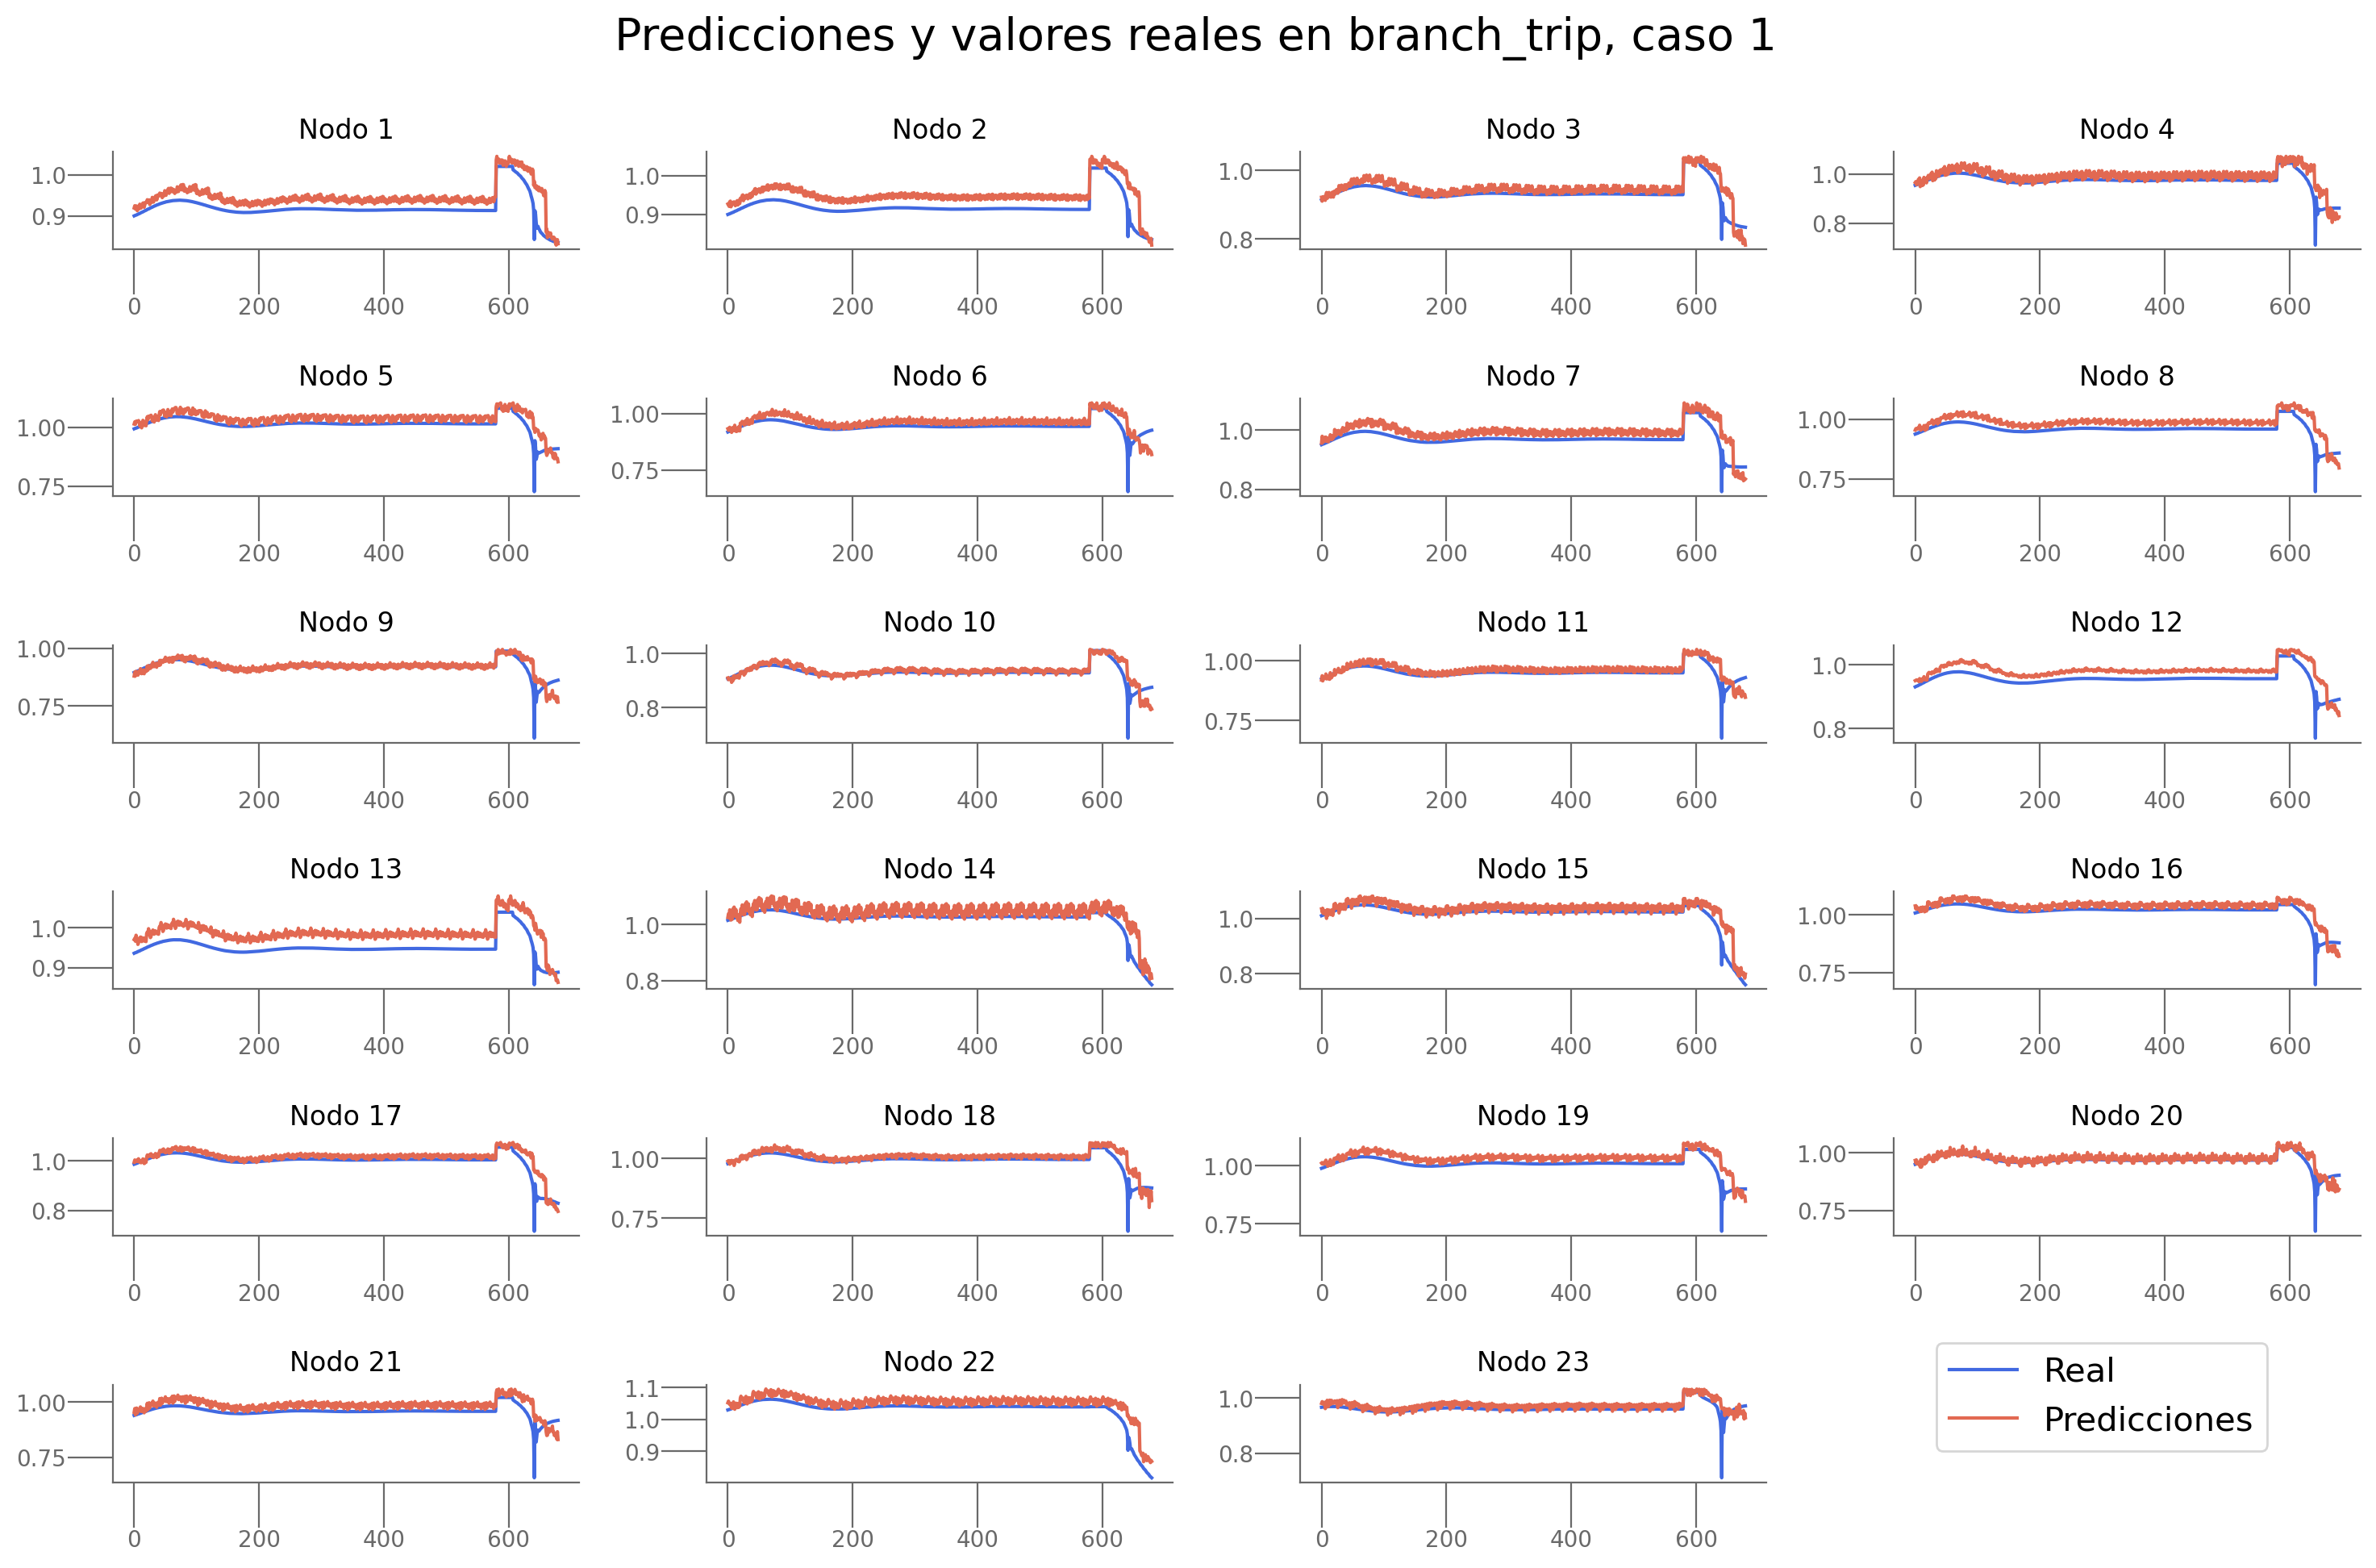

In [48]:
plot_predictions(predictions_brt_ajuste, real_brt_ajuste, n_target, 1, n_div_brt, problem_brt)

In [49]:
path_save_experiment_brt = results_save_path+f"/{problem_brt}"+ f"/ajustes/{name_model}_results.csv"
resultados_brt.to_csv(path_save_experiment_brt, index=False)

In [50]:
trainer_brt.save_model(path_save_experiment=path_save_experiment_brt, params=params_brt)


==================== GUARDANDO RESULTADOS ===================

         Modelo                                             Params  \
0          LSTM                                                NaN   
1  LSTM_NOBATCH                                                NaN   
2   DyGrEncoder              {'aggr': 'add', 'conv': 1, 'lstm': 2}   
3     MPNN_LSTM                {'hidden_size': 32, 'dropout': 0.8}   
4         AGCRN                              {'hidden': 5, 'K': 2}   
5         DCRNN                                     {'hidden': 60}   
6        MSTGCN  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_...   
7        MSTGCN  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_...   

                      Fichero_resultados_experimento  Loss_tst    R2_tst  \
0                                                NaN  0.003700  0.398922   
1                                                NaN  0.004787 -1.839737   
2  ./results/branch_trip/ajustes/DryGrEncoder_res...  0.002719 -0.549398   
3